# Loading Data

In [2]:
pip install albumentations


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 KB 2.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 KB 6.9 MB/s eta 0:00:0031m12.6 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 KB 17.5 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.5 MB/s eta 0:00:000:00:01m eta 0:00:01
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.20.1
    Uninstalling pydantic_core-2.20.1:
      Successfully uninstalled pydantic_core-2.20.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.8.2
    Uninstalling pydantic-2.8.2:
      Successfully uninstalled pydantic-2.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are ins

In [2]:
pip install imagecodecs

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 1.0 MB/s eta 0:00:00m eta 0:00:010:00:02m
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
#import tqdm as tqdm
from tqdm import tqdm as tqdm
import tifffile as tiff
import imagecodecs

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import zipfile

import random
from PIL import Image
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

TRAIN_PATH = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/stage1_train/'

def get_train_transform():
   return A.Compose(
       [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        ToTensorV2()
        ])

class LoadDataSet(Dataset):
        def __init__(self,path, transform=None):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_train_transform()
        
        def __len__(self):
            return len(self.folders)
              
        
        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(128,128))
            
            mask = self.get_mask(mask_folder, 128, 128 ).astype('float32')

            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.permute(2, 0, 1)
            return (img,mask)
        
        def get_mask(self,mask_folder,IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)
              
            return mask
        
train_dataset = LoadDataSet(TRAIN_PATH, transform=get_train_transform())

split_ratio = 0.15
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))

train_data, test_data = random_split(train_dataset, [train_size, valid_size])

test_loader = DataLoader(dataset=test_data, batch_size=10)

def format_image(img):
    img = np.array(np.transpose(img, (1,2,0)))
    mean=np.array((0.485, 0.456, 0.406))
    std=np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

def visualize_dataset(n_images, predict=None):
  """
  Function to visualize images and masks
  """
  images = random.sample(range(0, 670), n_images)
  figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
  print(images)
  for i in range(0, len(images)):
    img_no = images[i]
    image, mask = train_dataset.__getitem__(img_no)
    image = format_image(image)
    mask = format_mask(mask)
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
    ax[i, 0].set_title("Ground Truth Image")
    ax[i, 1].set_title("Mask")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
  plt.tight_layout()
  plt.show()
  
split_ratio = 0.25

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU
    
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Save and Load checkpoint functions
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    torch.save(state, checkpoint_path)
    if is_best:
        shutil.copyfile(checkpoint_path, best_model_path)

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()



/home/sayantan/.local/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# UNet


####### Fold 1/7 #######


Epoch 1 - Loss: 0.5505, IoU: 0.2899: 100%|██████| 36/36 [03:44<00:00,  6.22s/it]


Fold 1 - Epoch 1 - Train Loss: 0.6075, IoU: 0.2474
Fold 1 - Epoch 1 - Valid Loss: 0.5027, IoU: 0.3317
Fold 1 - Epoch 1 - Test Loss: 0.5252, IoU: 0.3125
Fold 1 - Epoch 1 - Valid Precision: 0.5315, Recall: 0.9596, Dice: 0.6810
Fold 1 - Epoch 1 - Test Precision: 0.5312, Recall: 0.9668, Dice: 0.6840
Validation loss decreased (inf --> 0.502654). Saving model...


Epoch 2 - Loss: 0.4724, IoU: 0.3583: 100%|██████| 36/36 [03:52<00:00,  6.47s/it]


Fold 1 - Epoch 2 - Train Loss: 0.5107, IoU: 0.3267
Fold 1 - Epoch 2 - Valid Loss: 0.4425, IoU: 0.3880
Fold 1 - Epoch 2 - Test Loss: 0.4801, IoU: 0.3528
Fold 1 - Epoch 2 - Valid Precision: 0.5445, Recall: 0.9623, Dice: 0.6903
Fold 1 - Epoch 2 - Test Precision: 0.5071, Recall: 0.9628, Dice: 0.6606
Validation loss decreased (0.502654 --> 0.442484). Saving model...


Epoch 3 - Loss: 0.3865, IoU: 0.4425: 100%|██████| 36/36 [03:52<00:00,  6.47s/it]


Fold 1 - Epoch 3 - Train Loss: 0.4342, IoU: 0.3965
Fold 1 - Epoch 3 - Valid Loss: 0.4548, IoU: 0.3760
Fold 1 - Epoch 3 - Test Loss: 0.4789, IoU: 0.3569
Fold 1 - Epoch 3 - Valid Precision: 0.4316, Recall: 0.9567, Dice: 0.5931
Fold 1 - Epoch 3 - Test Precision: 0.4169, Recall: 0.9609, Dice: 0.5717


Epoch 4 - Loss: 0.3287, IoU: 0.5052: 100%|██████| 36/36 [03:43<00:00,  6.21s/it]


Fold 1 - Epoch 4 - Train Loss: 0.3509, IoU: 0.4831
Fold 1 - Epoch 4 - Valid Loss: 0.3324, IoU: 0.5027
Fold 1 - Epoch 4 - Test Loss: 0.3475, IoU: 0.4878
Fold 1 - Epoch 4 - Valid Precision: 0.6444, Recall: 0.9139, Dice: 0.7527
Fold 1 - Epoch 4 - Test Precision: 0.6290, Recall: 0.9436, Dice: 0.7487
Validation loss decreased (0.442484 --> 0.332418). Saving model...


Epoch 5 - Loss: 0.1820, IoU: 0.6920: 100%|██████| 36/36 [03:44<00:00,  6.23s/it]


Fold 1 - Epoch 5 - Train Loss: 0.2946, IoU: 0.5487
Fold 1 - Epoch 5 - Valid Loss: 0.2672, IoU: 0.5808
Fold 1 - Epoch 5 - Test Loss: 0.2566, IoU: 0.5951
Fold 1 - Epoch 5 - Valid Precision: 0.6755, Recall: 0.9445, Dice: 0.7854
Fold 1 - Epoch 5 - Test Precision: 0.7167, Recall: 0.9495, Dice: 0.8113
Validation loss decreased (0.332418 --> 0.267216). Saving model...


Epoch 6 - Loss: 0.1883, IoU: 0.6831: 100%|██████| 36/36 [03:43<00:00,  6.22s/it]


Fold 1 - Epoch 6 - Train Loss: 0.2644, IoU: 0.5865
Fold 1 - Epoch 6 - Valid Loss: 0.2739, IoU: 0.5704
Fold 1 - Epoch 6 - Test Loss: 0.2798, IoU: 0.5665
Fold 1 - Epoch 6 - Valid Precision: 0.7718, Recall: 0.7590, Dice: 0.7622
Fold 1 - Epoch 6 - Test Precision: 0.7921, Recall: 0.7494, Dice: 0.7663


Epoch 7 - Loss: 0.2117, IoU: 0.6505: 100%|██████| 36/36 [03:44<00:00,  6.24s/it]


Fold 1 - Epoch 7 - Train Loss: 0.2146, IoU: 0.6483
Fold 1 - Epoch 7 - Valid Loss: 0.2084, IoU: 0.6574
Fold 1 - Epoch 7 - Test Loss: 0.2170, IoU: 0.6462
Fold 1 - Epoch 7 - Valid Precision: 0.8479, Recall: 0.8393, Dice: 0.8416
Fold 1 - Epoch 7 - Test Precision: 0.8591, Recall: 0.8286, Dice: 0.8400
Validation loss decreased (0.267216 --> 0.208403). Saving model...


Epoch 8 - Loss: 0.1670, IoU: 0.7138: 100%|██████| 36/36 [03:44<00:00,  6.24s/it]


Fold 1 - Epoch 8 - Train Loss: 0.1930, IoU: 0.6776
Fold 1 - Epoch 8 - Valid Loss: 0.2312, IoU: 0.6247
Fold 1 - Epoch 8 - Test Loss: 0.2278, IoU: 0.6302
Fold 1 - Epoch 8 - Valid Precision: 0.7872, Recall: 0.8089, Dice: 0.7953
Fold 1 - Epoch 8 - Test Precision: 0.7867, Recall: 0.8298, Dice: 0.8049


Epoch 9 - Loss: 0.1633, IoU: 0.7193: 100%|██████| 36/36 [03:43<00:00,  6.21s/it]


Fold 1 - Epoch 9 - Train Loss: 0.2100, IoU: 0.6554
Fold 1 - Epoch 9 - Valid Loss: 0.5248, IoU: 0.3148
Fold 1 - Epoch 9 - Test Loss: 0.5741, IoU: 0.2742
Fold 1 - Epoch 9 - Valid Precision: 0.3235, Recall: 0.9309, Dice: 0.4764
Fold 1 - Epoch 9 - Test Precision: 0.2804, Recall: 0.9416, Dice: 0.4270


Epoch 10 - Loss: 0.1802, IoU: 0.6946: 100%|█████| 36/36 [03:44<00:00,  6.23s/it]


Fold 1 - Epoch 10 - Train Loss: 0.1770, IoU: 0.7010
Fold 1 - Epoch 10 - Valid Loss: 0.2114, IoU: 0.6521
Fold 1 - Epoch 10 - Test Loss: 0.2131, IoU: 0.6504
Fold 1 - Epoch 10 - Valid Precision: 0.7649, Recall: 0.8706, Dice: 0.8132
Fold 1 - Epoch 10 - Test Precision: 0.7787, Recall: 0.8662, Dice: 0.8156


Epoch 11 - Loss: 0.1602, IoU: 0.7239: 100%|█████| 36/36 [03:44<00:00,  6.23s/it]


Fold 1 - Epoch 11 - Train Loss: 0.1635, IoU: 0.7200
Fold 1 - Epoch 11 - Valid Loss: 0.1574, IoU: 0.7289
Fold 1 - Epoch 11 - Test Loss: 0.1514, IoU: 0.7374
Fold 1 - Epoch 11 - Valid Precision: 0.8638, Recall: 0.8745, Dice: 0.8688
Fold 1 - Epoch 11 - Test Precision: 0.8779, Recall: 0.8833, Dice: 0.8802
Validation loss decreased (0.208403 --> 0.157382). Saving model...


Epoch 12 - Loss: 0.1744, IoU: 0.7030: 100%|█████| 36/36 [03:39<00:00,  6.09s/it]


Fold 1 - Epoch 12 - Train Loss: 0.1602, IoU: 0.7250
Fold 1 - Epoch 12 - Valid Loss: 0.2905, IoU: 0.5516
Fold 1 - Epoch 12 - Test Loss: 0.2770, IoU: 0.5693
Fold 1 - Epoch 12 - Valid Precision: 0.8423, Recall: 0.6551, Dice: 0.7329
Fold 1 - Epoch 12 - Test Precision: 0.8747, Recall: 0.6680, Dice: 0.7529


Epoch 13 - Loss: 0.1332, IoU: 0.7650: 100%|█████| 36/36 [03:39<00:00,  6.11s/it]


Fold 1 - Epoch 13 - Train Loss: 0.1541, IoU: 0.7337
Fold 1 - Epoch 13 - Valid Loss: 0.1548, IoU: 0.7324
Fold 1 - Epoch 13 - Test Loss: 0.1482, IoU: 0.7424
Fold 1 - Epoch 13 - Valid Precision: 0.8410, Recall: 0.9058, Dice: 0.8718
Fold 1 - Epoch 13 - Test Precision: 0.8545, Recall: 0.9176, Dice: 0.8844
Validation loss decreased (0.157382 --> 0.154822). Saving model...


Epoch 14 - Loss: 0.1863, IoU: 0.6860: 100%|█████| 36/36 [03:40<00:00,  6.12s/it]


Fold 1 - Epoch 14 - Train Loss: 0.1538, IoU: 0.7344
Fold 1 - Epoch 14 - Valid Loss: 0.1459, IoU: 0.7457
Fold 1 - Epoch 14 - Test Loss: 0.1408, IoU: 0.7535
Fold 1 - Epoch 14 - Valid Precision: 0.8311, Recall: 0.9196, Dice: 0.8728
Fold 1 - Epoch 14 - Test Precision: 0.8378, Recall: 0.9319, Dice: 0.8819
Validation loss decreased (0.154822 --> 0.145949). Saving model...


Epoch 15 - Loss: 0.1708, IoU: 0.7082: 100%|█████| 36/36 [03:40<00:00,  6.13s/it]


Fold 1 - Epoch 15 - Train Loss: 0.1481, IoU: 0.7427
Fold 1 - Epoch 15 - Valid Loss: 0.1454, IoU: 0.7465
Fold 1 - Epoch 15 - Test Loss: 0.1445, IoU: 0.7481
Fold 1 - Epoch 15 - Valid Precision: 0.8457, Recall: 0.9008, Dice: 0.8716
Fold 1 - Epoch 15 - Test Precision: 0.8408, Recall: 0.9157, Dice: 0.8758
Validation loss decreased (0.145949 --> 0.145401). Saving model...


Epoch 16 - Loss: 0.1392, IoU: 0.7556: 100%|█████| 36/36 [03:40<00:00,  6.12s/it]


Fold 1 - Epoch 16 - Train Loss: 0.1414, IoU: 0.7530
Fold 1 - Epoch 16 - Valid Loss: 0.1362, IoU: 0.7607
Fold 1 - Epoch 16 - Test Loss: 0.1322, IoU: 0.7670
Fold 1 - Epoch 16 - Valid Precision: 0.8534, Recall: 0.9157, Dice: 0.8830
Fold 1 - Epoch 16 - Test Precision: 0.8624, Recall: 0.9245, Dice: 0.8918
Validation loss decreased (0.145401 --> 0.136196). Saving model...


Epoch 17 - Loss: 0.1135, IoU: 0.7961: 100%|█████| 36/36 [03:39<00:00,  6.11s/it]


Fold 1 - Epoch 17 - Train Loss: 0.1386, IoU: 0.7570
Fold 1 - Epoch 17 - Valid Loss: 0.1588, IoU: 0.7262
Fold 1 - Epoch 17 - Test Loss: 0.1551, IoU: 0.7320
Fold 1 - Epoch 17 - Valid Precision: 0.7854, Recall: 0.9355, Dice: 0.8537
Fold 1 - Epoch 17 - Test Precision: 0.7902, Recall: 0.9462, Dice: 0.8606


Epoch 18 - Loss: 0.1506, IoU: 0.7382: 100%|█████| 36/36 [03:40<00:00,  6.13s/it]


Fold 1 - Epoch 18 - Train Loss: 0.1474, IoU: 0.7442
Fold 1 - Epoch 18 - Valid Loss: 0.1378, IoU: 0.7584
Fold 1 - Epoch 18 - Test Loss: 0.1309, IoU: 0.7690
Fold 1 - Epoch 18 - Valid Precision: 0.8694, Recall: 0.8958, Dice: 0.8817
Fold 1 - Epoch 18 - Test Precision: 0.8835, Recall: 0.9045, Dice: 0.8931


Epoch 19 - Loss: 0.1269, IoU: 0.7749: 100%|█████| 36/36 [03:44<00:00,  6.23s/it]


Fold 1 - Epoch 19 - Train Loss: 0.1379, IoU: 0.7585
Fold 1 - Epoch 19 - Valid Loss: 0.1565, IoU: 0.7297
Fold 1 - Epoch 19 - Test Loss: 0.1560, IoU: 0.7312
Fold 1 - Epoch 19 - Valid Precision: 0.8344, Recall: 0.8833, Dice: 0.8574
Fold 1 - Epoch 19 - Test Precision: 0.8232, Recall: 0.9044, Dice: 0.8602


Epoch 20 - Loss: 0.1255, IoU: 0.7770: 100%|█████| 36/36 [03:45<00:00,  6.27s/it]


Fold 1 - Epoch 20 - Train Loss: 0.1354, IoU: 0.7620
Fold 1 - Epoch 20 - Valid Loss: 0.1396, IoU: 0.7554
Fold 1 - Epoch 20 - Test Loss: 0.1316, IoU: 0.7679
Fold 1 - Epoch 20 - Valid Precision: 0.8645, Recall: 0.8908, Dice: 0.8768
Fold 1 - Epoch 20 - Test Precision: 0.8737, Recall: 0.9068, Dice: 0.8894

####### Fold 2/7 #######


Epoch 1 - Loss: 0.1788, IoU: 0.6967: 100%|██████| 36/36 [03:43<00:00,  6.22s/it]


Fold 2 - Epoch 1 - Train Loss: 0.1384, IoU: 0.7574
Fold 2 - Epoch 1 - Valid Loss: 0.1272, IoU: 0.7746
Fold 2 - Epoch 1 - Test Loss: 0.1263, IoU: 0.7762
Fold 2 - Epoch 1 - Valid Precision: 0.8258, Recall: 0.9582, Dice: 0.8869
Fold 2 - Epoch 1 - Test Precision: 0.8451, Recall: 0.9415, Dice: 0.8901
Validation loss decreased (0.136196 --> 0.127240). Saving model...


Epoch 2 - Loss: 0.1081, IoU: 0.8049: 100%|██████| 36/36 [03:41<00:00,  6.16s/it]


Fold 2 - Epoch 2 - Train Loss: 0.1341, IoU: 0.7642
Fold 2 - Epoch 2 - Valid Loss: 0.1266, IoU: 0.7757
Fold 2 - Epoch 2 - Test Loss: 0.1334, IoU: 0.7651
Fold 2 - Epoch 2 - Valid Precision: 0.8864, Recall: 0.9042, Dice: 0.8952
Fold 2 - Epoch 2 - Test Precision: 0.8932, Recall: 0.8873, Dice: 0.8897
Validation loss decreased (0.127240 --> 0.126554). Saving model...


Epoch 3 - Loss: 0.1741, IoU: 0.7035: 100%|██████| 36/36 [03:37<00:00,  6.03s/it]


Fold 2 - Epoch 3 - Train Loss: 0.1356, IoU: 0.7620
Fold 2 - Epoch 3 - Valid Loss: 0.1369, IoU: 0.7594
Fold 2 - Epoch 3 - Test Loss: 0.1352, IoU: 0.7625
Fold 2 - Epoch 3 - Valid Precision: 0.8016, Recall: 0.9612, Dice: 0.8741
Fold 2 - Epoch 3 - Test Precision: 0.8189, Recall: 0.9464, Dice: 0.8776


Epoch 4 - Loss: 0.1115, IoU: 0.7993: 100%|██████| 36/36 [03:37<00:00,  6.05s/it]


Fold 2 - Epoch 4 - Train Loss: 0.1360, IoU: 0.7612
Fold 2 - Epoch 4 - Valid Loss: 0.1323, IoU: 0.7663
Fold 2 - Epoch 4 - Test Loss: 0.1354, IoU: 0.7620
Fold 2 - Epoch 4 - Valid Precision: 0.8434, Recall: 0.9381, Dice: 0.8881
Fold 2 - Epoch 4 - Test Precision: 0.8517, Recall: 0.9235, Dice: 0.8856


Epoch 5 - Loss: 0.1527, IoU: 0.7350: 100%|██████| 36/36 [03:37<00:00,  6.04s/it]


Fold 2 - Epoch 5 - Train Loss: 0.1322, IoU: 0.7671
Fold 2 - Epoch 5 - Valid Loss: 0.1194, IoU: 0.7870
Fold 2 - Epoch 5 - Test Loss: 0.1248, IoU: 0.7785
Fold 2 - Epoch 5 - Valid Precision: 0.8919, Recall: 0.9133, Dice: 0.9024
Fold 2 - Epoch 5 - Test Precision: 0.9034, Recall: 0.8943, Dice: 0.8985
Validation loss decreased (0.126554 --> 0.119392). Saving model...


Epoch 6 - Loss: 0.1296, IoU: 0.7706: 100%|██████| 36/36 [03:36<00:00,  6.02s/it]


Fold 2 - Epoch 6 - Train Loss: 0.1329, IoU: 0.7661
Fold 2 - Epoch 6 - Valid Loss: 0.1231, IoU: 0.7810
Fold 2 - Epoch 6 - Test Loss: 0.1282, IoU: 0.7732
Fold 2 - Epoch 6 - Valid Precision: 0.8530, Recall: 0.9431, Dice: 0.8956
Fold 2 - Epoch 6 - Test Precision: 0.8691, Recall: 0.9163, Dice: 0.8917


Epoch 7 - Loss: 0.1311, IoU: 0.7682: 100%|██████| 36/36 [03:36<00:00,  6.01s/it]


Fold 2 - Epoch 7 - Train Loss: 0.1349, IoU: 0.7632
Fold 2 - Epoch 7 - Valid Loss: 0.1151, IoU: 0.7939
Fold 2 - Epoch 7 - Test Loss: 0.1215, IoU: 0.7838
Fold 2 - Epoch 7 - Valid Precision: 0.8792, Recall: 0.9363, Dice: 0.9067
Fold 2 - Epoch 7 - Test Precision: 0.8941, Recall: 0.9095, Dice: 0.9013
Validation loss decreased (0.119392 --> 0.115079). Saving model...


Epoch 8 - Loss: 0.1145, IoU: 0.7946: 100%|██████| 36/36 [03:36<00:00,  6.01s/it]


Fold 2 - Epoch 8 - Train Loss: 0.1310, IoU: 0.7689
Fold 2 - Epoch 8 - Valid Loss: 0.2577, IoU: 0.5917
Fold 2 - Epoch 8 - Test Loss: 0.2771, IoU: 0.5727
Fold 2 - Epoch 8 - Valid Precision: 0.8673, Recall: 0.6863, Dice: 0.7642
Fold 2 - Epoch 8 - Test Precision: 0.8764, Recall: 0.6579, Dice: 0.7448


Epoch 9 - Loss: 0.1474, IoU: 0.7431: 100%|██████| 36/36 [03:35<00:00,  5.99s/it]


Fold 2 - Epoch 9 - Train Loss: 0.1400, IoU: 0.7552
Fold 2 - Epoch 9 - Valid Loss: 0.1298, IoU: 0.7707
Fold 2 - Epoch 9 - Test Loss: 0.1361, IoU: 0.7611
Fold 2 - Epoch 9 - Valid Precision: 0.8775, Recall: 0.9027, Dice: 0.8897
Fold 2 - Epoch 9 - Test Precision: 0.8896, Recall: 0.8838, Dice: 0.8854


Epoch 10 - Loss: 0.1416, IoU: 0.7519: 100%|█████| 36/36 [03:36<00:00,  6.01s/it]


Fold 2 - Epoch 10 - Train Loss: 0.1328, IoU: 0.7663
Fold 2 - Epoch 10 - Valid Loss: 0.1137, IoU: 0.7961
Fold 2 - Epoch 10 - Test Loss: 0.1220, IoU: 0.7832
Fold 2 - Epoch 10 - Valid Precision: 0.8966, Recall: 0.9260, Dice: 0.9109
Fold 2 - Epoch 10 - Test Precision: 0.9026, Recall: 0.9047, Dice: 0.9031
Validation loss decreased (0.115079 --> 0.113661). Saving model...


Epoch 11 - Loss: 0.1102, IoU: 0.8015: 100%|█████| 36/36 [03:37<00:00,  6.05s/it]


Fold 2 - Epoch 11 - Train Loss: 0.1299, IoU: 0.7705
Fold 2 - Epoch 11 - Valid Loss: 0.1128, IoU: 0.7974
Fold 2 - Epoch 11 - Test Loss: 0.1200, IoU: 0.7863
Fold 2 - Epoch 11 - Valid Precision: 0.9008, Recall: 0.9250, Dice: 0.9126
Fold 2 - Epoch 11 - Test Precision: 0.9131, Recall: 0.8996, Dice: 0.9060
Validation loss decreased (0.113661 --> 0.112843). Saving model...


Epoch 12 - Loss: 0.1061, IoU: 0.8081: 100%|█████| 36/36 [03:38<00:00,  6.06s/it]


Fold 2 - Epoch 12 - Train Loss: 0.1277, IoU: 0.7739
Fold 2 - Epoch 12 - Valid Loss: 0.1155, IoU: 0.7933
Fold 2 - Epoch 12 - Test Loss: 0.1196, IoU: 0.7868
Fold 2 - Epoch 12 - Valid Precision: 0.8685, Recall: 0.9424, Dice: 0.9038
Fold 2 - Epoch 12 - Test Precision: 0.8831, Recall: 0.9220, Dice: 0.9017


Epoch 13 - Loss: 0.1040, IoU: 0.8115: 100%|█████| 36/36 [03:37<00:00,  6.05s/it]


Fold 2 - Epoch 13 - Train Loss: 0.1292, IoU: 0.7717
Fold 2 - Epoch 13 - Valid Loss: 0.1154, IoU: 0.7934
Fold 2 - Epoch 13 - Test Loss: 0.1187, IoU: 0.7883
Fold 2 - Epoch 13 - Valid Precision: 0.8718, Recall: 0.9381, Dice: 0.9037
Fold 2 - Epoch 13 - Test Precision: 0.8869, Recall: 0.9194, Dice: 0.9025


Epoch 14 - Loss: 0.1220, IoU: 0.7825: 100%|█████| 36/36 [03:37<00:00,  6.03s/it]


Fold 2 - Epoch 14 - Train Loss: 0.1265, IoU: 0.7760
Fold 2 - Epoch 14 - Valid Loss: 0.1153, IoU: 0.7935
Fold 2 - Epoch 14 - Test Loss: 0.1162, IoU: 0.7922
Fold 2 - Epoch 14 - Valid Precision: 0.8597, Recall: 0.9519, Dice: 0.9033
Fold 2 - Epoch 14 - Test Precision: 0.8753, Recall: 0.9359, Dice: 0.9043


Epoch 15 - Loss: 0.0793, IoU: 0.8530: 100%|█████| 36/36 [03:37<00:00,  6.03s/it]


Fold 2 - Epoch 15 - Train Loss: 0.1275, IoU: 0.7745
Fold 2 - Epoch 15 - Valid Loss: 0.1121, IoU: 0.7985
Fold 2 - Epoch 15 - Test Loss: 0.1228, IoU: 0.7817
Fold 2 - Epoch 15 - Valid Precision: 0.8936, Recall: 0.9324, Dice: 0.9124
Fold 2 - Epoch 15 - Test Precision: 0.9061, Recall: 0.8992, Dice: 0.9023
Validation loss decreased (0.112843 --> 0.112138). Saving model...


Epoch 16 - Loss: 0.1426, IoU: 0.7504: 100%|█████| 36/36 [03:35<00:00,  6.00s/it]


Fold 2 - Epoch 16 - Train Loss: 0.1221, IoU: 0.7829
Fold 2 - Epoch 16 - Valid Loss: 0.1338, IoU: 0.7644
Fold 2 - Epoch 16 - Test Loss: 0.1291, IoU: 0.7718
Fold 2 - Epoch 16 - Valid Precision: 0.8121, Recall: 0.9650, Dice: 0.8816
Fold 2 - Epoch 16 - Test Precision: 0.8400, Recall: 0.9452, Dice: 0.8890


Epoch 17 - Loss: 0.1311, IoU: 0.7682: 100%|█████| 36/36 [03:36<00:00,  6.01s/it]


Fold 2 - Epoch 17 - Train Loss: 0.1253, IoU: 0.7778
Fold 2 - Epoch 17 - Valid Loss: 0.1189, IoU: 0.7878
Fold 2 - Epoch 17 - Test Loss: 0.1208, IoU: 0.7849
Fold 2 - Epoch 17 - Valid Precision: 0.8552, Recall: 0.9468, Dice: 0.8984
Fold 2 - Epoch 17 - Test Precision: 0.8715, Recall: 0.9287, Dice: 0.8987


Epoch 18 - Loss: 0.1149, IoU: 0.7938: 100%|█████| 36/36 [03:35<00:00,  5.99s/it]


Fold 2 - Epoch 18 - Train Loss: 0.1226, IoU: 0.7819
Fold 2 - Epoch 18 - Valid Loss: 0.1250, IoU: 0.7778
Fold 2 - Epoch 18 - Test Loss: 0.1452, IoU: 0.7470
Fold 2 - Epoch 18 - Valid Precision: 0.9073, Recall: 0.8971, Dice: 0.9017
Fold 2 - Epoch 18 - Test Precision: 0.9187, Recall: 0.8489, Dice: 0.8816


Epoch 19 - Loss: 0.1131, IoU: 0.7968: 100%|█████| 36/36 [03:36<00:00,  6.02s/it]


Fold 2 - Epoch 19 - Train Loss: 0.1258, IoU: 0.7773
Fold 2 - Epoch 19 - Valid Loss: 0.1273, IoU: 0.7743
Fold 2 - Epoch 19 - Test Loss: 0.1300, IoU: 0.7704
Fold 2 - Epoch 19 - Valid Precision: 0.8796, Recall: 0.9144, Dice: 0.8963
Fold 2 - Epoch 19 - Test Precision: 0.8929, Recall: 0.8964, Dice: 0.8943


Epoch 20 - Loss: 0.1553, IoU: 0.7312: 100%|█████| 36/36 [03:36<00:00,  6.00s/it]


Fold 2 - Epoch 20 - Train Loss: 0.1211, IoU: 0.7844
Fold 2 - Epoch 20 - Valid Loss: 0.2186, IoU: 0.6438
Fold 2 - Epoch 20 - Test Loss: 0.2331, IoU: 0.6230
Fold 2 - Epoch 20 - Valid Precision: 0.6865, Recall: 0.9574, Dice: 0.7973
Fold 2 - Epoch 20 - Test Precision: 0.6704, Recall: 0.9454, Dice: 0.7828

####### Fold 3/7 #######


Epoch 1 - Loss: 0.1332, IoU: 0.7650: 100%|██████| 36/36 [03:34<00:00,  5.95s/it]


Fold 3 - Epoch 1 - Train Loss: 0.1218, IoU: 0.7833
Fold 3 - Epoch 1 - Valid Loss: 0.1469, IoU: 0.7446
Fold 3 - Epoch 1 - Test Loss: 0.1419, IoU: 0.7518
Fold 3 - Epoch 1 - Valid Precision: 0.8606, Recall: 0.8920, Dice: 0.8740
Fold 3 - Epoch 1 - Test Precision: 0.8932, Recall: 0.8671, Dice: 0.8793


Epoch 2 - Loss: 0.1333, IoU: 0.7647: 100%|██████| 36/36 [03:33<00:00,  5.94s/it]


Fold 3 - Epoch 2 - Train Loss: 0.1208, IoU: 0.7848
Fold 3 - Epoch 2 - Valid Loss: 0.1303, IoU: 0.7703
Fold 3 - Epoch 2 - Test Loss: 0.1197, IoU: 0.7867
Fold 3 - Epoch 2 - Valid Precision: 0.8763, Recall: 0.9165, Dice: 0.8948
Fold 3 - Epoch 2 - Test Precision: 0.9167, Recall: 0.8986, Dice: 0.9070


Epoch 3 - Loss: 0.1053, IoU: 0.8094: 100%|██████| 36/36 [03:35<00:00,  5.97s/it]


Fold 3 - Epoch 3 - Train Loss: 0.1193, IoU: 0.7873
Fold 3 - Epoch 3 - Valid Loss: 0.1228, IoU: 0.7823
Fold 3 - Epoch 3 - Test Loss: 0.1125, IoU: 0.7982
Fold 3 - Epoch 3 - Valid Precision: 0.8642, Recall: 0.9439, Dice: 0.9016
Fold 3 - Epoch 3 - Test Precision: 0.8975, Recall: 0.9272, Dice: 0.9118


Epoch 4 - Loss: 0.1200, IoU: 0.7857: 100%|██████| 36/36 [03:35<00:00,  5.99s/it]


Fold 3 - Epoch 4 - Train Loss: 0.1238, IoU: 0.7804
Fold 3 - Epoch 4 - Valid Loss: 0.1463, IoU: 0.7458
Fold 3 - Epoch 4 - Test Loss: 0.1464, IoU: 0.7454
Fold 3 - Epoch 4 - Valid Precision: 0.8392, Recall: 0.9109, Dice: 0.8726
Fold 3 - Epoch 4 - Test Precision: 0.8487, Recall: 0.8975, Dice: 0.8713


Epoch 5 - Loss: 0.1138, IoU: 0.7956: 100%|██████| 36/36 [03:34<00:00,  5.96s/it]


Fold 3 - Epoch 5 - Train Loss: 0.1213, IoU: 0.7841
Fold 3 - Epoch 5 - Valid Loss: 0.1634, IoU: 0.7207
Fold 3 - Epoch 5 - Test Loss: 0.1462, IoU: 0.7450
Fold 3 - Epoch 5 - Valid Precision: 0.8753, Recall: 0.8490, Dice: 0.8601
Fold 3 - Epoch 5 - Test Precision: 0.9070, Recall: 0.8532, Dice: 0.8783


Epoch 6 - Loss: 0.0820, IoU: 0.8484: 100%|██████| 36/36 [03:33<00:00,  5.94s/it]


Fold 3 - Epoch 6 - Train Loss: 0.1196, IoU: 0.7868
Fold 3 - Epoch 6 - Valid Loss: 0.1236, IoU: 0.7811
Fold 3 - Epoch 6 - Test Loss: 0.1115, IoU: 0.7999
Fold 3 - Epoch 6 - Valid Precision: 0.8621, Recall: 0.9419, Dice: 0.8993
Fold 3 - Epoch 6 - Test Precision: 0.9009, Recall: 0.9255, Dice: 0.9127


Epoch 7 - Loss: 0.1357, IoU: 0.7611: 100%|██████| 36/36 [03:33<00:00,  5.94s/it]


Fold 3 - Epoch 7 - Train Loss: 0.1191, IoU: 0.7875
Fold 3 - Epoch 7 - Valid Loss: 0.2029, IoU: 0.6631
Fold 3 - Epoch 7 - Test Loss: 0.1898, IoU: 0.6826
Fold 3 - Epoch 7 - Valid Precision: 0.7117, Recall: 0.9487, Dice: 0.8122
Fold 3 - Epoch 7 - Test Precision: 0.7416, Recall: 0.9369, Dice: 0.8249


Epoch 8 - Loss: 0.1326, IoU: 0.7658: 100%|██████| 36/36 [03:35<00:00,  5.98s/it]


Fold 3 - Epoch 8 - Train Loss: 0.1217, IoU: 0.7835
Fold 3 - Epoch 8 - Valid Loss: 0.1247, IoU: 0.7791
Fold 3 - Epoch 8 - Test Loss: 0.1154, IoU: 0.7937
Fold 3 - Epoch 8 - Valid Precision: 0.8863, Recall: 0.9211, Dice: 0.9024
Fold 3 - Epoch 8 - Test Precision: 0.9272, Recall: 0.9000, Dice: 0.9130


Epoch 9 - Loss: 0.1183, IoU: 0.7884: 100%|██████| 36/36 [03:34<00:00,  5.95s/it]


Fold 3 - Epoch 9 - Train Loss: 0.1204, IoU: 0.7855
Fold 3 - Epoch 9 - Valid Loss: 0.1263, IoU: 0.7767
Fold 3 - Epoch 9 - Test Loss: 0.1156, IoU: 0.7932
Fold 3 - Epoch 9 - Valid Precision: 0.8459, Recall: 0.9474, Dice: 0.8927
Fold 3 - Epoch 9 - Test Precision: 0.8815, Recall: 0.9304, Dice: 0.9049


Epoch 10 - Loss: 0.0929, IoU: 0.8300: 100%|█████| 36/36 [03:34<00:00,  5.96s/it]


Fold 3 - Epoch 10 - Train Loss: 0.1187, IoU: 0.7883
Fold 3 - Epoch 10 - Valid Loss: 0.2634, IoU: 0.5873
Fold 3 - Epoch 10 - Test Loss: 0.2359, IoU: 0.6247
Fold 3 - Epoch 10 - Valid Precision: 0.8633, Recall: 0.6937, Dice: 0.7608
Fold 3 - Epoch 10 - Test Precision: 0.9104, Recall: 0.7076, Dice: 0.7906


Epoch 11 - Loss: 0.1656, IoU: 0.7158: 100%|█████| 36/36 [03:34<00:00,  5.95s/it]


Fold 3 - Epoch 11 - Train Loss: 0.1166, IoU: 0.7918
Fold 3 - Epoch 11 - Valid Loss: 0.1183, IoU: 0.7894
Fold 3 - Epoch 11 - Test Loss: 0.1099, IoU: 0.8024
Fold 3 - Epoch 11 - Valid Precision: 0.8896, Recall: 0.9322, Dice: 0.9098
Fold 3 - Epoch 11 - Test Precision: 0.9225, Recall: 0.9152, Dice: 0.9186


Epoch 12 - Loss: 0.0933, IoU: 0.8293: 100%|█████| 36/36 [03:35<00:00,  6.00s/it]


Fold 3 - Epoch 12 - Train Loss: 0.1204, IoU: 0.7854
Fold 3 - Epoch 12 - Valid Loss: 0.1248, IoU: 0.7791
Fold 3 - Epoch 12 - Test Loss: 0.1149, IoU: 0.7944
Fold 3 - Epoch 12 - Valid Precision: 0.8713, Recall: 0.9360, Dice: 0.9014
Fold 3 - Epoch 12 - Test Precision: 0.9114, Recall: 0.9150, Dice: 0.9126


Epoch 13 - Loss: 0.1384, IoU: 0.7569: 100%|█████| 36/36 [03:39<00:00,  6.09s/it]


Fold 3 - Epoch 13 - Train Loss: 0.1159, IoU: 0.7927
Fold 3 - Epoch 13 - Valid Loss: 0.1323, IoU: 0.7672
Fold 3 - Epoch 13 - Test Loss: 0.1258, IoU: 0.7772
Fold 3 - Epoch 13 - Valid Precision: 0.8844, Recall: 0.9079, Dice: 0.8945
Fold 3 - Epoch 13 - Test Precision: 0.9276, Recall: 0.8813, Dice: 0.9032


Epoch 14 - Loss: 0.1178, IoU: 0.7892: 100%|█████| 36/36 [03:41<00:00,  6.15s/it]


Fold 3 - Epoch 14 - Train Loss: 0.1150, IoU: 0.7940
Fold 3 - Epoch 14 - Valid Loss: 0.2696, IoU: 0.5806
Fold 3 - Epoch 14 - Test Loss: 0.2564, IoU: 0.5975
Fold 3 - Epoch 14 - Valid Precision: 0.8857, Recall: 0.6737, Dice: 0.7565
Fold 3 - Epoch 14 - Test Precision: 0.9349, Recall: 0.6650, Dice: 0.7715


Epoch 15 - Loss: 0.1399, IoU: 0.7546: 100%|█████| 36/36 [03:33<00:00,  5.94s/it]


Fold 3 - Epoch 15 - Train Loss: 0.1182, IoU: 0.7891
Fold 3 - Epoch 15 - Valid Loss: 0.1517, IoU: 0.7378
Fold 3 - Epoch 15 - Test Loss: 0.1440, IoU: 0.7485
Fold 3 - Epoch 15 - Valid Precision: 0.8874, Recall: 0.8649, Dice: 0.8745
Fold 3 - Epoch 15 - Test Precision: 0.9257, Recall: 0.8443, Dice: 0.8829


Epoch 16 - Loss: 0.1161, IoU: 0.7920: 100%|█████| 36/36 [03:34<00:00,  5.96s/it]


Fold 3 - Epoch 16 - Train Loss: 0.1174, IoU: 0.7904
Fold 3 - Epoch 16 - Valid Loss: 0.1200, IoU: 0.7866
Fold 3 - Epoch 16 - Test Loss: 0.1103, IoU: 0.8017
Fold 3 - Epoch 16 - Valid Precision: 0.8716, Recall: 0.9409, Dice: 0.9040
Fold 3 - Epoch 16 - Test Precision: 0.9043, Recall: 0.9252, Dice: 0.9144


Epoch 17 - Loss: 0.1103, IoU: 0.8014: 100%|█████| 36/36 [03:34<00:00,  5.96s/it]


Fold 3 - Epoch 17 - Train Loss: 0.1149, IoU: 0.7942
Fold 3 - Epoch 17 - Valid Loss: 0.1223, IoU: 0.7829
Fold 3 - Epoch 17 - Test Loss: 0.1121, IoU: 0.7989
Fold 3 - Epoch 17 - Valid Precision: 0.8781, Recall: 0.9323, Dice: 0.9033
Fold 3 - Epoch 17 - Test Precision: 0.9179, Recall: 0.9125, Dice: 0.9149


Epoch 18 - Loss: 0.1204, IoU: 0.7850: 100%|█████| 36/36 [03:34<00:00,  5.95s/it]


Fold 3 - Epoch 18 - Train Loss: 0.1177, IoU: 0.7898
Fold 3 - Epoch 18 - Valid Loss: 0.1536, IoU: 0.7348
Fold 3 - Epoch 18 - Test Loss: 0.1379, IoU: 0.7580
Fold 3 - Epoch 18 - Valid Precision: 0.8643, Recall: 0.8826, Dice: 0.8708
Fold 3 - Epoch 18 - Test Precision: 0.9106, Recall: 0.8687, Dice: 0.8886


Epoch 19 - Loss: 0.1262, IoU: 0.7759: 100%|█████| 36/36 [03:33<00:00,  5.92s/it]


Fold 3 - Epoch 19 - Train Loss: 0.1170, IoU: 0.7911
Fold 3 - Epoch 19 - Valid Loss: 0.1229, IoU: 0.7819
Fold 3 - Epoch 19 - Test Loss: 0.1148, IoU: 0.7945
Fold 3 - Epoch 19 - Valid Precision: 0.8637, Recall: 0.9431, Dice: 0.9011
Fold 3 - Epoch 19 - Test Precision: 0.8940, Recall: 0.9255, Dice: 0.9092


Epoch 20 - Loss: 0.0894, IoU: 0.8359: 100%|█████| 36/36 [03:33<00:00,  5.92s/it]


Fold 3 - Epoch 20 - Train Loss: 0.1151, IoU: 0.7941
Fold 3 - Epoch 20 - Valid Loss: 0.3291, IoU: 0.5154
Fold 3 - Epoch 20 - Test Loss: 0.3035, IoU: 0.5460
Fold 3 - Epoch 20 - Valid Precision: 0.8617, Recall: 0.6049, Dice: 0.6943
Fold 3 - Epoch 20 - Test Precision: 0.9115, Recall: 0.6132, Dice: 0.7226

####### Fold 4/7 #######


Epoch 1 - Loss: 0.1206, IoU: 0.7847: 100%|██████| 36/36 [03:35<00:00,  6.00s/it]


Fold 4 - Epoch 1 - Train Loss: 0.1155, IoU: 0.7932
Fold 4 - Epoch 1 - Valid Loss: 0.1051, IoU: 0.8102
Fold 4 - Epoch 1 - Test Loss: 0.1093, IoU: 0.8033
Fold 4 - Epoch 1 - Valid Precision: 0.9004, Recall: 0.9320, Dice: 0.9159
Fold 4 - Epoch 1 - Test Precision: 0.9075, Recall: 0.9233, Dice: 0.9151
Validation loss decreased (0.112138 --> 0.105081). Saving model...


Epoch 2 - Loss: 0.1238, IoU: 0.7796: 100%|██████| 36/36 [03:36<00:00,  6.00s/it]


Fold 4 - Epoch 2 - Train Loss: 0.1188, IoU: 0.7881
Fold 4 - Epoch 2 - Valid Loss: 0.1142, IoU: 0.7955
Fold 4 - Epoch 2 - Test Loss: 0.1168, IoU: 0.7913
Fold 4 - Epoch 2 - Valid Precision: 0.9032, Recall: 0.9090, Dice: 0.9059
Fold 4 - Epoch 2 - Test Precision: 0.9068, Recall: 0.9073, Dice: 0.9066


Epoch 3 - Loss: 0.1021, IoU: 0.8147: 100%|██████| 36/36 [03:39<00:00,  6.09s/it]


Fold 4 - Epoch 3 - Train Loss: 0.1204, IoU: 0.7856
Fold 4 - Epoch 3 - Valid Loss: 0.1221, IoU: 0.7827
Fold 4 - Epoch 3 - Test Loss: 0.1289, IoU: 0.7721
Fold 4 - Epoch 3 - Valid Precision: 0.9021, Recall: 0.8963, Dice: 0.8991
Fold 4 - Epoch 3 - Test Precision: 0.9053, Recall: 0.8874, Dice: 0.8956


Epoch 4 - Loss: 0.1185, IoU: 0.7881: 100%|██████| 36/36 [03:40<00:00,  6.12s/it]


Fold 4 - Epoch 4 - Train Loss: 0.1187, IoU: 0.7882
Fold 4 - Epoch 4 - Valid Loss: 0.1810, IoU: 0.6941
Fold 4 - Epoch 4 - Test Loss: 0.1711, IoU: 0.7136
Fold 4 - Epoch 4 - Valid Precision: 0.7788, Recall: 0.9192, Dice: 0.8408
Fold 4 - Epoch 4 - Test Precision: 0.8158, Recall: 0.9151, Dice: 0.8539


Epoch 5 - Loss: 0.1108, IoU: 0.8005: 100%|██████| 36/36 [03:41<00:00,  6.17s/it]


Fold 4 - Epoch 5 - Train Loss: 0.1188, IoU: 0.7881
Fold 4 - Epoch 5 - Valid Loss: 0.1065, IoU: 0.8080
Fold 4 - Epoch 5 - Test Loss: 0.1101, IoU: 0.8022
Fold 4 - Epoch 5 - Valid Precision: 0.9096, Recall: 0.9243, Dice: 0.9169
Fold 4 - Epoch 5 - Test Precision: 0.9178, Recall: 0.9158, Dice: 0.9166


Epoch 6 - Loss: 0.1008, IoU: 0.8168: 100%|██████| 36/36 [03:37<00:00,  6.04s/it]


Fold 4 - Epoch 6 - Train Loss: 0.1185, IoU: 0.7887
Fold 4 - Epoch 6 - Valid Loss: 0.2540, IoU: 0.5987
Fold 4 - Epoch 6 - Test Loss: 0.2580, IoU: 0.5977
Fold 4 - Epoch 6 - Valid Precision: 0.9087, Recall: 0.6710, Dice: 0.7683
Fold 4 - Epoch 6 - Test Precision: 0.9251, Recall: 0.6700, Dice: 0.7694


Epoch 7 - Loss: 0.1304, IoU: 0.7693: 100%|██████| 36/36 [03:37<00:00,  6.05s/it]


Fold 4 - Epoch 7 - Train Loss: 0.1184, IoU: 0.7887
Fold 4 - Epoch 7 - Valid Loss: 0.2081, IoU: 0.6577
Fold 4 - Epoch 7 - Test Loss: 0.2092, IoU: 0.6568
Fold 4 - Epoch 7 - Valid Precision: 0.8948, Recall: 0.7487, Dice: 0.8126
Fold 4 - Epoch 7 - Test Precision: 0.9093, Recall: 0.7457, Dice: 0.8163


Epoch 8 - Loss: 0.1112, IoU: 0.7999: 100%|██████| 36/36 [03:38<00:00,  6.06s/it]


Fold 4 - Epoch 8 - Train Loss: 0.1182, IoU: 0.7891
Fold 4 - Epoch 8 - Valid Loss: 0.1218, IoU: 0.7832
Fold 4 - Epoch 8 - Test Loss: 0.1253, IoU: 0.7780
Fold 4 - Epoch 8 - Valid Precision: 0.8792, Recall: 0.9134, Dice: 0.8958
Fold 4 - Epoch 8 - Test Precision: 0.8798, Recall: 0.9113, Dice: 0.8947


Epoch 9 - Loss: 0.1558, IoU: 0.7304: 100%|██████| 36/36 [03:36<00:00,  6.02s/it]


Fold 4 - Epoch 9 - Train Loss: 0.1181, IoU: 0.7891
Fold 4 - Epoch 9 - Valid Loss: 0.3220, IoU: 0.5212
Fold 4 - Epoch 9 - Test Loss: 0.3127, IoU: 0.5361
Fold 4 - Epoch 9 - Valid Precision: 0.8988, Recall: 0.5863, Dice: 0.7008
Fold 4 - Epoch 9 - Test Precision: 0.9232, Recall: 0.5984, Dice: 0.7147


Epoch 10 - Loss: 0.1583, IoU: 0.7267: 100%|█████| 36/36 [03:38<00:00,  6.07s/it]


Fold 4 - Epoch 10 - Train Loss: 0.1156, IoU: 0.7931
Fold 4 - Epoch 10 - Valid Loss: 0.2599, IoU: 0.5920
Fold 4 - Epoch 10 - Test Loss: 0.2663, IoU: 0.5891
Fold 4 - Epoch 10 - Valid Precision: 0.9069, Recall: 0.6664, Dice: 0.7633
Fold 4 - Epoch 10 - Test Precision: 0.9216, Recall: 0.6621, Dice: 0.7617


Epoch 11 - Loss: 0.1008, IoU: 0.8169: 100%|█████| 36/36 [03:38<00:00,  6.07s/it]


Fold 4 - Epoch 11 - Train Loss: 0.1155, IoU: 0.7934
Fold 4 - Epoch 11 - Valid Loss: 0.1039, IoU: 0.8121
Fold 4 - Epoch 11 - Test Loss: 0.1060, IoU: 0.8089
Fold 4 - Epoch 11 - Valid Precision: 0.8957, Recall: 0.9408, Dice: 0.9177
Fold 4 - Epoch 11 - Test Precision: 0.9049, Recall: 0.9349, Dice: 0.9195
Validation loss decreased (0.105081 --> 0.103946). Saving model...


Epoch 12 - Loss: 0.1114, IoU: 0.7995: 100%|█████| 36/36 [03:37<00:00,  6.04s/it]


Fold 4 - Epoch 12 - Train Loss: 0.1153, IoU: 0.7937
Fold 4 - Epoch 12 - Valid Loss: 0.1072, IoU: 0.8068
Fold 4 - Epoch 12 - Test Loss: 0.1105, IoU: 0.8015
Fold 4 - Epoch 12 - Valid Precision: 0.9246, Recall: 0.9122, Dice: 0.9182
Fold 4 - Epoch 12 - Test Precision: 0.9310, Recall: 0.9067, Dice: 0.9183


Epoch 13 - Loss: 0.1071, IoU: 0.8066: 100%|█████| 36/36 [03:38<00:00,  6.08s/it]


Fold 4 - Epoch 13 - Train Loss: 0.1156, IoU: 0.7933
Fold 4 - Epoch 13 - Valid Loss: 0.1052, IoU: 0.8100
Fold 4 - Epoch 13 - Test Loss: 0.1080, IoU: 0.8055
Fold 4 - Epoch 13 - Valid Precision: 0.8874, Recall: 0.9441, Dice: 0.9148
Fold 4 - Epoch 13 - Test Precision: 0.8905, Recall: 0.9411, Dice: 0.9147


Epoch 14 - Loss: 0.0832, IoU: 0.8463: 100%|█████| 36/36 [03:40<00:00,  6.13s/it]


Fold 4 - Epoch 14 - Train Loss: 0.1143, IoU: 0.7954
Fold 4 - Epoch 14 - Valid Loss: 0.1101, IoU: 0.8021
Fold 4 - Epoch 14 - Test Loss: 0.1151, IoU: 0.7942
Fold 4 - Epoch 14 - Valid Precision: 0.9255, Recall: 0.9051, Dice: 0.9151
Fold 4 - Epoch 14 - Test Precision: 0.9353, Recall: 0.8946, Dice: 0.9141


Epoch 15 - Loss: 0.1554, IoU: 0.7311: 100%|█████| 36/36 [03:42<00:00,  6.17s/it]


Fold 4 - Epoch 15 - Train Loss: 0.1132, IoU: 0.7971
Fold 4 - Epoch 15 - Valid Loss: 0.1067, IoU: 0.8075
Fold 4 - Epoch 15 - Test Loss: 0.1108, IoU: 0.8010
Fold 4 - Epoch 15 - Valid Precision: 0.8817, Recall: 0.9450, Dice: 0.9122
Fold 4 - Epoch 15 - Test Precision: 0.8887, Recall: 0.9370, Dice: 0.9119


Epoch 16 - Loss: 0.1168, IoU: 0.7908: 100%|█████| 36/36 [03:41<00:00,  6.16s/it]


Fold 4 - Epoch 16 - Train Loss: 0.1161, IoU: 0.7924
Fold 4 - Epoch 16 - Valid Loss: 0.1266, IoU: 0.7755
Fold 4 - Epoch 16 - Test Loss: 0.1320, IoU: 0.7674
Fold 4 - Epoch 16 - Valid Precision: 0.8750, Recall: 0.9071, Dice: 0.8904
Fold 4 - Epoch 16 - Test Precision: 0.8909, Recall: 0.8890, Dice: 0.8889


Epoch 17 - Loss: 0.1057, IoU: 0.8088: 100%|█████| 36/36 [03:38<00:00,  6.08s/it]


Fold 4 - Epoch 17 - Train Loss: 0.1177, IoU: 0.7901
Fold 4 - Epoch 17 - Valid Loss: 0.1080, IoU: 0.8054
Fold 4 - Epoch 17 - Test Loss: 0.1120, IoU: 0.7990
Fold 4 - Epoch 17 - Valid Precision: 0.8918, Recall: 0.9389, Dice: 0.9147
Fold 4 - Epoch 17 - Test Precision: 0.9006, Recall: 0.9280, Dice: 0.9137


Epoch 18 - Loss: 0.1206, IoU: 0.7848: 100%|█████| 36/36 [03:37<00:00,  6.05s/it]


Fold 4 - Epoch 18 - Train Loss: 0.1165, IoU: 0.7917
Fold 4 - Epoch 18 - Valid Loss: 0.3115, IoU: 0.5325
Fold 4 - Epoch 18 - Test Loss: 0.3024, IoU: 0.5467
Fold 4 - Epoch 18 - Valid Precision: 0.9002, Recall: 0.5967, Dice: 0.7104
Fold 4 - Epoch 18 - Test Precision: 0.9239, Recall: 0.6111, Dice: 0.7247


Epoch 19 - Loss: 0.0951, IoU: 0.8262: 100%|█████| 36/36 [03:38<00:00,  6.06s/it]


Fold 4 - Epoch 19 - Train Loss: 0.1196, IoU: 0.7869
Fold 4 - Epoch 19 - Valid Loss: 0.1082, IoU: 0.8052
Fold 4 - Epoch 19 - Test Loss: 0.1104, IoU: 0.8016
Fold 4 - Epoch 19 - Valid Precision: 0.9059, Recall: 0.9227, Dice: 0.9139
Fold 4 - Epoch 19 - Test Precision: 0.9099, Recall: 0.9211, Dice: 0.9150


Epoch 20 - Loss: 0.0949, IoU: 0.8267: 100%|█████| 36/36 [03:36<00:00,  6.01s/it]


Fold 4 - Epoch 20 - Train Loss: 0.1155, IoU: 0.7934
Fold 4 - Epoch 20 - Valid Loss: 0.1044, IoU: 0.8112
Fold 4 - Epoch 20 - Test Loss: 0.1083, IoU: 0.8051
Fold 4 - Epoch 20 - Valid Precision: 0.8935, Recall: 0.9398, Dice: 0.9160
Fold 4 - Epoch 20 - Test Precision: 0.9003, Recall: 0.9322, Dice: 0.9157

####### Fold 5/7 #######


Epoch 1 - Loss: 0.1364, IoU: 0.7600: 100%|██████| 36/36 [03:33<00:00,  5.92s/it]


Fold 5 - Epoch 1 - Train Loss: 0.1135, IoU: 0.7965
Fold 5 - Epoch 1 - Valid Loss: 0.1531, IoU: 0.7347
Fold 5 - Epoch 1 - Test Loss: 0.1525, IoU: 0.7354
Fold 5 - Epoch 1 - Valid Precision: 0.9188, Recall: 0.8332, Dice: 0.8736
Fold 5 - Epoch 1 - Test Precision: 0.9375, Recall: 0.8208, Dice: 0.8748


Epoch 2 - Loss: 0.0949, IoU: 0.8267: 100%|██████| 36/36 [03:33<00:00,  5.92s/it]


Fold 5 - Epoch 2 - Train Loss: 0.1132, IoU: 0.7971
Fold 5 - Epoch 2 - Valid Loss: 0.1445, IoU: 0.7489
Fold 5 - Epoch 2 - Test Loss: 0.1112, IoU: 0.8004
Fold 5 - Epoch 2 - Valid Precision: 0.8467, Recall: 0.9154, Dice: 0.8776
Fold 5 - Epoch 2 - Test Precision: 0.9123, Recall: 0.9167, Dice: 0.9141


Epoch 3 - Loss: 0.1191, IoU: 0.7872: 100%|██████| 36/36 [03:34<00:00,  5.95s/it]


Fold 5 - Epoch 3 - Train Loss: 0.1110, IoU: 0.8005
Fold 5 - Epoch 3 - Valid Loss: 0.2175, IoU: 0.6458
Fold 5 - Epoch 3 - Test Loss: 0.2494, IoU: 0.6072
Fold 5 - Epoch 3 - Valid Precision: 0.9223, Recall: 0.7255, Dice: 0.8098
Fold 5 - Epoch 3 - Test Precision: 0.9310, Recall: 0.6789, Dice: 0.7786


Epoch 4 - Loss: 0.1047, IoU: 0.8105: 100%|██████| 36/36 [03:34<00:00,  5.96s/it]


Fold 5 - Epoch 4 - Train Loss: 0.1100, IoU: 0.8023
Fold 5 - Epoch 4 - Valid Loss: 0.1245, IoU: 0.7788
Fold 5 - Epoch 4 - Test Loss: 0.1056, IoU: 0.8095
Fold 5 - Epoch 4 - Valid Precision: 0.8977, Recall: 0.9027, Dice: 0.8997
Fold 5 - Epoch 4 - Test Precision: 0.8991, Recall: 0.9388, Dice: 0.9182


Epoch 5 - Loss: 0.1146, IoU: 0.7944: 100%|██████| 36/36 [03:37<00:00,  6.04s/it]


Fold 5 - Epoch 5 - Train Loss: 0.1104, IoU: 0.8015
Fold 5 - Epoch 5 - Valid Loss: 0.1538, IoU: 0.7336
Fold 5 - Epoch 5 - Test Loss: 0.1644, IoU: 0.7183
Fold 5 - Epoch 5 - Valid Precision: 0.8890, Recall: 0.8563, Dice: 0.8717
Fold 5 - Epoch 5 - Test Precision: 0.8576, Recall: 0.8689, Dice: 0.8601


Epoch 6 - Loss: 0.1142, IoU: 0.7950: 100%|██████| 36/36 [03:39<00:00,  6.10s/it]


Fold 5 - Epoch 6 - Train Loss: 0.1110, IoU: 0.8006
Fold 5 - Epoch 6 - Valid Loss: 0.1248, IoU: 0.7782
Fold 5 - Epoch 6 - Test Loss: 0.1074, IoU: 0.8065
Fold 5 - Epoch 6 - Valid Precision: 0.8893, Recall: 0.9081, Dice: 0.8978
Fold 5 - Epoch 6 - Test Precision: 0.9034, Recall: 0.9304, Dice: 0.9164


Epoch 7 - Loss: 0.1842, IoU: 0.6890: 100%|██████| 36/36 [03:39<00:00,  6.09s/it]


Fold 5 - Epoch 7 - Train Loss: 0.1123, IoU: 0.7986
Fold 5 - Epoch 7 - Valid Loss: 0.1188, IoU: 0.7878
Fold 5 - Epoch 7 - Test Loss: 0.1053, IoU: 0.8099
Fold 5 - Epoch 7 - Valid Precision: 0.8953, Recall: 0.9178, Dice: 0.9060
Fold 5 - Epoch 7 - Test Precision: 0.9067, Recall: 0.9346, Dice: 0.9203


Epoch 8 - Loss: 0.1220, IoU: 0.7825: 100%|██████| 36/36 [03:34<00:00,  5.96s/it]


Fold 5 - Epoch 8 - Train Loss: 0.1102, IoU: 0.8019
Fold 5 - Epoch 8 - Valid Loss: 0.2492, IoU: 0.6060
Fold 5 - Epoch 8 - Test Loss: 0.3020, IoU: 0.5479
Fold 5 - Epoch 8 - Valid Precision: 0.9296, Recall: 0.6761, Dice: 0.7792
Fold 5 - Epoch 8 - Test Precision: 0.9407, Recall: 0.6075, Dice: 0.7270


Epoch 9 - Loss: 0.1229, IoU: 0.7812: 100%|██████| 36/36 [03:34<00:00,  5.95s/it]


Fold 5 - Epoch 9 - Train Loss: 0.1100, IoU: 0.8023
Fold 5 - Epoch 9 - Valid Loss: 0.1199, IoU: 0.7860
Fold 5 - Epoch 9 - Test Loss: 0.1052, IoU: 0.8101
Fold 5 - Epoch 9 - Valid Precision: 0.8751, Recall: 0.9304, Dice: 0.9013
Fold 5 - Epoch 9 - Test Precision: 0.8920, Recall: 0.9433, Dice: 0.9167


Epoch 10 - Loss: 0.1226, IoU: 0.7816: 100%|█████| 36/36 [03:34<00:00,  5.95s/it]


Fold 5 - Epoch 10 - Train Loss: 0.1110, IoU: 0.8009
Fold 5 - Epoch 10 - Valid Loss: 0.1234, IoU: 0.7805
Fold 5 - Epoch 10 - Test Loss: 0.1083, IoU: 0.8051
Fold 5 - Epoch 10 - Valid Precision: 0.8725, Recall: 0.9265, Dice: 0.8980
Fold 5 - Epoch 10 - Test Precision: 0.8998, Recall: 0.9315, Dice: 0.9149


Epoch 11 - Loss: 0.1112, IoU: 0.7998: 100%|█████| 36/36 [03:34<00:00,  5.96s/it]


Fold 5 - Epoch 11 - Train Loss: 0.1112, IoU: 0.8004
Fold 5 - Epoch 11 - Valid Loss: 0.1297, IoU: 0.7706
Fold 5 - Epoch 11 - Test Loss: 0.1113, IoU: 0.8002
Fold 5 - Epoch 11 - Valid Precision: 0.8756, Recall: 0.9092, Dice: 0.8915
Fold 5 - Epoch 11 - Test Precision: 0.8924, Recall: 0.9329, Dice: 0.9120


Epoch 12 - Loss: 0.0815, IoU: 0.8492: 100%|█████| 36/36 [03:33<00:00,  5.94s/it]


Fold 5 - Epoch 12 - Train Loss: 0.1100, IoU: 0.8023
Fold 5 - Epoch 12 - Valid Loss: 0.1305, IoU: 0.7694
Fold 5 - Epoch 12 - Test Loss: 0.1104, IoU: 0.8016
Fold 5 - Epoch 12 - Valid Precision: 0.8773, Recall: 0.9037, Dice: 0.8899
Fold 5 - Epoch 12 - Test Precision: 0.8927, Recall: 0.9316, Dice: 0.9114


Epoch 13 - Loss: 0.1140, IoU: 0.7953: 100%|█████| 36/36 [03:36<00:00,  6.00s/it]


Fold 5 - Epoch 13 - Train Loss: 0.1104, IoU: 0.8019
Fold 5 - Epoch 13 - Valid Loss: 0.1198, IoU: 0.7863
Fold 5 - Epoch 13 - Test Loss: 0.1046, IoU: 0.8110
Fold 5 - Epoch 13 - Valid Precision: 0.8955, Recall: 0.9129, Dice: 0.9037
Fold 5 - Epoch 13 - Test Precision: 0.9061, Recall: 0.9349, Dice: 0.9201


Epoch 14 - Loss: 0.1004, IoU: 0.8174: 100%|█████| 36/36 [03:36<00:00,  6.02s/it]


Fold 5 - Epoch 14 - Train Loss: 0.1091, IoU: 0.8038
Fold 5 - Epoch 14 - Valid Loss: 0.1892, IoU: 0.6844
Fold 5 - Epoch 14 - Test Loss: 0.1686, IoU: 0.7140
Fold 5 - Epoch 14 - Valid Precision: 0.7638, Recall: 0.9156, Dice: 0.8307
Fold 5 - Epoch 14 - Test Precision: 0.7817, Recall: 0.9412, Dice: 0.8519


Epoch 15 - Loss: 0.1313, IoU: 0.7679: 100%|█████| 36/36 [03:36<00:00,  6.02s/it]


Fold 5 - Epoch 15 - Train Loss: 0.1096, IoU: 0.8030
Fold 5 - Epoch 15 - Valid Loss: 0.1292, IoU: 0.7715
Fold 5 - Epoch 15 - Test Loss: 0.1094, IoU: 0.8033
Fold 5 - Epoch 15 - Valid Precision: 0.9246, Recall: 0.8755, Dice: 0.8992
Fold 5 - Epoch 15 - Test Precision: 0.9265, Recall: 0.9114, Dice: 0.9187


Epoch 16 - Loss: 0.1212, IoU: 0.7838: 100%|█████| 36/36 [03:41<00:00,  6.16s/it]


Fold 5 - Epoch 16 - Train Loss: 0.1098, IoU: 0.8028
Fold 5 - Epoch 16 - Valid Loss: 0.1381, IoU: 0.7576
Fold 5 - Epoch 16 - Test Loss: 0.1157, IoU: 0.7930
Fold 5 - Epoch 16 - Valid Precision: 0.8796, Recall: 0.8952, Dice: 0.8864
Fold 5 - Epoch 16 - Test Precision: 0.9132, Recall: 0.9078, Dice: 0.9102


Epoch 17 - Loss: 0.1136, IoU: 0.7960: 100%|█████| 36/36 [03:40<00:00,  6.14s/it]


Fold 5 - Epoch 17 - Train Loss: 0.1076, IoU: 0.8060
Fold 5 - Epoch 17 - Valid Loss: 0.1184, IoU: 0.7884
Fold 5 - Epoch 17 - Test Loss: 0.1045, IoU: 0.8113
Fold 5 - Epoch 17 - Valid Precision: 0.8967, Recall: 0.9177, Dice: 0.9067
Fold 5 - Epoch 17 - Test Precision: 0.9030, Recall: 0.9387, Dice: 0.9203


Epoch 18 - Loss: 0.1074, IoU: 0.8061: 100%|█████| 36/36 [03:35<00:00,  5.98s/it]


Fold 5 - Epoch 18 - Train Loss: 0.1080, IoU: 0.8056
Fold 5 - Epoch 18 - Valid Loss: 0.1275, IoU: 0.7740
Fold 5 - Epoch 18 - Test Loss: 0.1070, IoU: 0.8071
Fold 5 - Epoch 18 - Valid Precision: 0.9066, Recall: 0.8899, Dice: 0.8976
Fold 5 - Epoch 18 - Test Precision: 0.9100, Recall: 0.9276, Dice: 0.9183


Epoch 19 - Loss: 0.1282, IoU: 0.7728: 100%|█████| 36/36 [03:35<00:00,  5.98s/it]


Fold 5 - Epoch 19 - Train Loss: 0.1097, IoU: 0.8027
Fold 5 - Epoch 19 - Valid Loss: 0.1390, IoU: 0.7563
Fold 5 - Epoch 19 - Test Loss: 0.1157, IoU: 0.7932
Fold 5 - Epoch 19 - Valid Precision: 0.8605, Recall: 0.9006, Dice: 0.8793
Fold 5 - Epoch 19 - Test Precision: 0.8750, Recall: 0.9360, Dice: 0.9040


Epoch 20 - Loss: 0.1080, IoU: 0.8050: 100%|█████| 36/36 [03:36<00:00,  6.00s/it]


Fold 5 - Epoch 20 - Train Loss: 0.1100, IoU: 0.8024
Fold 5 - Epoch 20 - Valid Loss: 0.1516, IoU: 0.7369
Fold 5 - Epoch 20 - Test Loss: 0.1485, IoU: 0.7418
Fold 5 - Epoch 20 - Valid Precision: 0.8868, Recall: 0.8495, Dice: 0.8673
Fold 5 - Epoch 20 - Test Precision: 0.8989, Recall: 0.8473, Dice: 0.8717

####### Fold 6/7 #######


Epoch 1 - Loss: 0.1028, IoU: 0.8136: 100%|██████| 36/36 [03:32<00:00,  5.90s/it]


Fold 6 - Epoch 1 - Train Loss: 0.1270, IoU: 0.7759
Fold 6 - Epoch 1 - Valid Loss: 0.1762, IoU: 0.7007
Fold 6 - Epoch 1 - Test Loss: 0.1975, IoU: 0.6708
Fold 6 - Epoch 1 - Valid Precision: 0.8610, Recall: 0.8394, Dice: 0.8496
Fold 6 - Epoch 1 - Test Precision: 0.8712, Recall: 0.7910, Dice: 0.8275


Epoch 2 - Loss: 0.1239, IoU: 0.7796: 100%|██████| 36/36 [03:32<00:00,  5.90s/it]


Fold 6 - Epoch 2 - Train Loss: 0.1188, IoU: 0.7885
Fold 6 - Epoch 2 - Valid Loss: 0.1350, IoU: 0.7623
Fold 6 - Epoch 2 - Test Loss: 0.1561, IoU: 0.7311
Fold 6 - Epoch 2 - Valid Precision: 0.8795, Recall: 0.9029, Dice: 0.8906
Fold 6 - Epoch 2 - Test Precision: 0.9118, Recall: 0.8342, Dice: 0.8698


Epoch 3 - Loss: 0.0947, IoU: 0.8269: 100%|██████| 36/36 [03:33<00:00,  5.93s/it]


Fold 6 - Epoch 3 - Train Loss: 0.1150, IoU: 0.7942
Fold 6 - Epoch 3 - Valid Loss: 0.2318, IoU: 0.6259
Fold 6 - Epoch 3 - Test Loss: 0.3149, IoU: 0.5340
Fold 6 - Epoch 3 - Valid Precision: 0.9105, Recall: 0.7140, Dice: 0.7981
Fold 6 - Epoch 3 - Test Precision: 0.9303, Recall: 0.5935, Dice: 0.7127


Epoch 4 - Loss: 0.3108, IoU: 0.5258: 100%|██████| 36/36 [03:35<00:00,  5.99s/it]


Fold 6 - Epoch 4 - Train Loss: 0.1262, IoU: 0.7780
Fold 6 - Epoch 4 - Valid Loss: 0.4705, IoU: 0.3683
Fold 6 - Epoch 4 - Test Loss: 0.4569, IoU: 0.3838
Fold 6 - Epoch 4 - Valid Precision: 0.4256, Recall: 0.7876, Dice: 0.5418
Fold 6 - Epoch 4 - Test Precision: 0.4890, Recall: 0.7132, Dice: 0.5597


Epoch 5 - Loss: 0.1201, IoU: 0.7855: 100%|██████| 36/36 [03:37<00:00,  6.03s/it]


Fold 6 - Epoch 5 - Train Loss: 0.1426, IoU: 0.7518
Fold 6 - Epoch 5 - Valid Loss: 0.1284, IoU: 0.7727
Fold 6 - Epoch 5 - Test Loss: 0.1231, IoU: 0.7815
Fold 6 - Epoch 5 - Valid Precision: 0.8533, Recall: 0.9312, Dice: 0.8901
Fold 6 - Epoch 5 - Test Precision: 0.8692, Recall: 0.9236, Dice: 0.8947


Epoch 6 - Loss: 0.1061, IoU: 0.8082: 100%|██████| 36/36 [03:37<00:00,  6.04s/it]


Fold 6 - Epoch 6 - Train Loss: 0.1264, IoU: 0.7763
Fold 6 - Epoch 6 - Valid Loss: 0.1639, IoU: 0.7192
Fold 6 - Epoch 6 - Test Loss: 0.1747, IoU: 0.7037
Fold 6 - Epoch 6 - Valid Precision: 0.8676, Recall: 0.8453, Dice: 0.8557
Fold 6 - Epoch 6 - Test Precision: 0.8856, Recall: 0.8105, Dice: 0.8447


Epoch 7 - Loss: 0.1219, IoU: 0.7826: 100%|██████| 36/36 [03:38<00:00,  6.07s/it]


Fold 6 - Epoch 7 - Train Loss: 0.1217, IoU: 0.7837
Fold 6 - Epoch 7 - Valid Loss: 0.1238, IoU: 0.7799
Fold 6 - Epoch 7 - Test Loss: 0.1157, IoU: 0.7930
Fold 6 - Epoch 7 - Valid Precision: 0.8765, Recall: 0.9254, Dice: 0.8999
Fold 6 - Epoch 7 - Test Precision: 0.8956, Recall: 0.9199, Dice: 0.9072


Epoch 8 - Loss: 0.1418, IoU: 0.7516: 100%|██████| 36/36 [03:41<00:00,  6.14s/it]


Fold 6 - Epoch 8 - Train Loss: 0.1162, IoU: 0.7925
Fold 6 - Epoch 8 - Valid Loss: 0.1274, IoU: 0.7743
Fold 6 - Epoch 8 - Test Loss: 0.1150, IoU: 0.7942
Fold 6 - Epoch 8 - Valid Precision: 0.8607, Recall: 0.9267, Dice: 0.8920
Fold 6 - Epoch 8 - Test Precision: 0.8912, Recall: 0.9224, Dice: 0.9061


Epoch 9 - Loss: 0.1350, IoU: 0.7620: 100%|██████| 36/36 [03:36<00:00,  6.01s/it]


Fold 6 - Epoch 9 - Train Loss: 0.1156, IoU: 0.7932
Fold 6 - Epoch 9 - Valid Loss: 0.1209, IoU: 0.7846
Fold 6 - Epoch 9 - Test Loss: 0.1125, IoU: 0.7984
Fold 6 - Epoch 9 - Valid Precision: 0.8736, Recall: 0.9351, Dice: 0.9029
Fold 6 - Epoch 9 - Test Precision: 0.9053, Recall: 0.9198, Dice: 0.9121


Epoch 10 - Loss: 0.1159, IoU: 0.7923: 100%|█████| 36/36 [03:36<00:00,  6.01s/it]


Fold 6 - Epoch 10 - Train Loss: 0.1131, IoU: 0.7973
Fold 6 - Epoch 10 - Valid Loss: 0.1183, IoU: 0.7886
Fold 6 - Epoch 10 - Test Loss: 0.1102, IoU: 0.8020
Fold 6 - Epoch 10 - Valid Precision: 0.8954, Recall: 0.9236, Dice: 0.9091
Fold 6 - Epoch 10 - Test Precision: 0.9172, Recall: 0.9154, Dice: 0.9160


Epoch 11 - Loss: 0.0974, IoU: 0.8224: 100%|█████| 36/36 [03:35<00:00,  5.99s/it]


Fold 6 - Epoch 11 - Train Loss: 0.1128, IoU: 0.7977
Fold 6 - Epoch 11 - Valid Loss: 0.1258, IoU: 0.7768
Fold 6 - Epoch 11 - Test Loss: 0.1273, IoU: 0.7747
Fold 6 - Epoch 11 - Valid Precision: 0.8805, Recall: 0.9191, Dice: 0.8990
Fold 6 - Epoch 11 - Test Precision: 0.9118, Recall: 0.8861, Dice: 0.8984


Epoch 12 - Loss: 0.1467, IoU: 0.7441: 100%|█████| 36/36 [03:35<00:00,  5.99s/it]


Fold 6 - Epoch 12 - Train Loss: 0.1141, IoU: 0.7958
Fold 6 - Epoch 12 - Valid Loss: 0.1171, IoU: 0.7905
Fold 6 - Epoch 12 - Test Loss: 0.1079, IoU: 0.8057
Fold 6 - Epoch 12 - Valid Precision: 0.8797, Recall: 0.9413, Dice: 0.9091
Fold 6 - Epoch 12 - Test Precision: 0.9093, Recall: 0.9283, Dice: 0.9184


Epoch 13 - Loss: 0.0950, IoU: 0.8265: 100%|█████| 36/36 [03:33<00:00,  5.94s/it]


Fold 6 - Epoch 13 - Train Loss: 0.1119, IoU: 0.7993
Fold 6 - Epoch 13 - Valid Loss: 0.1168, IoU: 0.7911
Fold 6 - Epoch 13 - Test Loss: 0.1069, IoU: 0.8074
Fold 6 - Epoch 13 - Valid Precision: 0.8789, Recall: 0.9413, Dice: 0.9088
Fold 6 - Epoch 13 - Test Precision: 0.9073, Recall: 0.9309, Dice: 0.9187


Epoch 14 - Loss: 0.1032, IoU: 0.8130: 100%|█████| 36/36 [03:35<00:00,  5.99s/it]


Fold 6 - Epoch 14 - Train Loss: 0.1110, IoU: 0.8006
Fold 6 - Epoch 14 - Valid Loss: 0.1259, IoU: 0.7769
Fold 6 - Epoch 14 - Test Loss: 0.1206, IoU: 0.7852
Fold 6 - Epoch 14 - Valid Precision: 0.8799, Recall: 0.9178, Dice: 0.8982
Fold 6 - Epoch 14 - Test Precision: 0.9178, Recall: 0.8933, Dice: 0.9051


Epoch 15 - Loss: 0.0900, IoU: 0.8349: 100%|█████| 36/36 [03:34<00:00,  5.97s/it]


Fold 6 - Epoch 15 - Train Loss: 0.1122, IoU: 0.7986
Fold 6 - Epoch 15 - Valid Loss: 0.1174, IoU: 0.7901
Fold 6 - Epoch 15 - Test Loss: 0.1066, IoU: 0.8078
Fold 6 - Epoch 15 - Valid Precision: 0.8769, Recall: 0.9415, Dice: 0.9077
Fold 6 - Epoch 15 - Test Precision: 0.9088, Recall: 0.9304, Dice: 0.9192


Epoch 16 - Loss: 0.1034, IoU: 0.8125: 100%|█████| 36/36 [03:36<00:00,  6.01s/it]


Fold 6 - Epoch 16 - Train Loss: 0.1127, IoU: 0.7981
Fold 6 - Epoch 16 - Valid Loss: 0.1184, IoU: 0.7885
Fold 6 - Epoch 16 - Test Loss: 0.1064, IoU: 0.8081
Fold 6 - Epoch 16 - Valid Precision: 0.8770, Recall: 0.9374, Dice: 0.9059
Fold 6 - Epoch 16 - Test Precision: 0.9038, Recall: 0.9333, Dice: 0.9181


Epoch 17 - Loss: 0.1314, IoU: 0.7678: 100%|█████| 36/36 [03:37<00:00,  6.03s/it]


Fold 6 - Epoch 17 - Train Loss: 0.1096, IoU: 0.8031
Fold 6 - Epoch 17 - Valid Loss: 0.1178, IoU: 0.7895
Fold 6 - Epoch 17 - Test Loss: 0.1083, IoU: 0.8050
Fold 6 - Epoch 17 - Valid Precision: 0.8772, Recall: 0.9412, Dice: 0.9078
Fold 6 - Epoch 17 - Test Precision: 0.8986, Recall: 0.9353, Dice: 0.9164


Epoch 18 - Loss: 0.1200, IoU: 0.7857: 100%|█████| 36/36 [03:38<00:00,  6.08s/it]


Fold 6 - Epoch 18 - Train Loss: 0.1157, IoU: 0.7930
Fold 6 - Epoch 18 - Valid Loss: 0.1197, IoU: 0.7864
Fold 6 - Epoch 18 - Test Loss: 0.1073, IoU: 0.8067
Fold 6 - Epoch 18 - Valid Precision: 0.8616, Recall: 0.9480, Dice: 0.9025
Fold 6 - Epoch 18 - Test Precision: 0.8935, Recall: 0.9400, Dice: 0.9160


Epoch 19 - Loss: 0.1061, IoU: 0.8082: 100%|█████| 36/36 [03:40<00:00,  6.13s/it]


Fold 6 - Epoch 19 - Train Loss: 0.1098, IoU: 0.8023
Fold 6 - Epoch 19 - Valid Loss: 0.1197, IoU: 0.7865
Fold 6 - Epoch 19 - Test Loss: 0.1094, IoU: 0.8034
Fold 6 - Epoch 19 - Valid Precision: 0.8849, Recall: 0.9321, Dice: 0.9074
Fold 6 - Epoch 19 - Test Precision: 0.9145, Recall: 0.9213, Dice: 0.9175


Epoch 20 - Loss: 0.1230, IoU: 0.7809: 100%|█████| 36/36 [03:35<00:00,  5.98s/it]


Fold 6 - Epoch 20 - Train Loss: 0.1116, IoU: 0.7999
Fold 6 - Epoch 20 - Valid Loss: 0.1180, IoU: 0.7891
Fold 6 - Epoch 20 - Test Loss: 0.1090, IoU: 0.8041
Fold 6 - Epoch 20 - Valid Precision: 0.9002, Recall: 0.9216, Dice: 0.9106
Fold 6 - Epoch 20 - Test Precision: 0.9212, Recall: 0.9162, Dice: 0.9184

####### Fold 7/7 #######


Epoch 1 - Loss: 0.1112, IoU: 0.7998: 100%|██████| 36/36 [03:42<00:00,  6.18s/it]


Fold 7 - Epoch 1 - Train Loss: 0.1113, IoU: 0.8000
Fold 7 - Epoch 1 - Valid Loss: 0.1086, IoU: 0.8041
Fold 7 - Epoch 1 - Test Loss: 0.1074, IoU: 0.8065
Fold 7 - Epoch 1 - Valid Precision: 0.8868, Recall: 0.9319, Dice: 0.9087
Fold 7 - Epoch 1 - Test Precision: 0.8969, Recall: 0.9350, Dice: 0.9153


Epoch 2 - Loss: 0.1304, IoU: 0.7692: 100%|██████| 36/36 [03:41<00:00,  6.15s/it]


Fold 7 - Epoch 2 - Train Loss: 0.1137, IoU: 0.7963
Fold 7 - Epoch 2 - Valid Loss: 0.1081, IoU: 0.8050
Fold 7 - Epoch 2 - Test Loss: 0.1078, IoU: 0.8059
Fold 7 - Epoch 2 - Valid Precision: 0.8973, Recall: 0.9291, Dice: 0.9128
Fold 7 - Epoch 2 - Test Precision: 0.9108, Recall: 0.9239, Dice: 0.9171


Epoch 3 - Loss: 0.1100, IoU: 0.8018: 100%|██████| 36/36 [03:41<00:00,  6.16s/it]


Fold 7 - Epoch 3 - Train Loss: 0.1130, IoU: 0.7976
Fold 7 - Epoch 3 - Valid Loss: 0.1073, IoU: 0.8064
Fold 7 - Epoch 3 - Test Loss: 0.1073, IoU: 0.8068
Fold 7 - Epoch 3 - Valid Precision: 0.9188, Recall: 0.9155, Dice: 0.9170
Fold 7 - Epoch 3 - Test Precision: 0.9289, Recall: 0.9145, Dice: 0.9215


Epoch 4 - Loss: 0.1226, IoU: 0.7816: 100%|██████| 36/36 [03:42<00:00,  6.18s/it]


Fold 7 - Epoch 4 - Train Loss: 0.1103, IoU: 0.8016
Fold 7 - Epoch 4 - Valid Loss: 0.1049, IoU: 0.8101
Fold 7 - Epoch 4 - Test Loss: 0.1044, IoU: 0.8115
Fold 7 - Epoch 4 - Valid Precision: 0.8876, Recall: 0.9435, Dice: 0.9146
Fold 7 - Epoch 4 - Test Precision: 0.9000, Recall: 0.9419, Dice: 0.9202


Epoch 5 - Loss: 0.1116, IoU: 0.7993: 100%|██████| 36/36 [03:42<00:00,  6.19s/it]


Fold 7 - Epoch 5 - Train Loss: 0.1102, IoU: 0.8019
Fold 7 - Epoch 5 - Valid Loss: 0.1049, IoU: 0.8102
Fold 7 - Epoch 5 - Test Loss: 0.1047, IoU: 0.8110
Fold 7 - Epoch 5 - Valid Precision: 0.9083, Recall: 0.9286, Dice: 0.9183
Fold 7 - Epoch 5 - Test Precision: 0.9164, Recall: 0.9289, Dice: 0.9224


Epoch 6 - Loss: 0.1488, IoU: 0.7409: 100%|██████| 36/36 [03:42<00:00,  6.19s/it]


Fold 7 - Epoch 6 - Train Loss: 0.1111, IoU: 0.8003
Fold 7 - Epoch 6 - Valid Loss: 0.1053, IoU: 0.8095
Fold 7 - Epoch 6 - Test Loss: 0.1040, IoU: 0.8121
Fold 7 - Epoch 6 - Valid Precision: 0.8985, Recall: 0.9344, Dice: 0.9160
Fold 7 - Epoch 6 - Test Precision: 0.9081, Recall: 0.9370, Dice: 0.9221


Epoch 7 - Loss: 0.0846, IoU: 0.8440: 100%|██████| 36/36 [03:43<00:00,  6.21s/it]


Fold 7 - Epoch 7 - Train Loss: 0.1090, IoU: 0.8037
Fold 7 - Epoch 7 - Valid Loss: 0.1077, IoU: 0.8056
Fold 7 - Epoch 7 - Test Loss: 0.1059, IoU: 0.8090
Fold 7 - Epoch 7 - Valid Precision: 0.8874, Recall: 0.9372, Dice: 0.9116
Fold 7 - Epoch 7 - Test Precision: 0.9010, Recall: 0.9365, Dice: 0.9181


Epoch 8 - Loss: 0.1204, IoU: 0.7851: 100%|██████| 36/36 [03:44<00:00,  6.24s/it]


Fold 7 - Epoch 8 - Train Loss: 0.1120, IoU: 0.7990
Fold 7 - Epoch 8 - Valid Loss: 0.1142, IoU: 0.7950
Fold 7 - Epoch 8 - Test Loss: 0.1128, IoU: 0.7978
Fold 7 - Epoch 8 - Valid Precision: 0.8578, Recall: 0.9456, Dice: 0.8995
Fold 7 - Epoch 8 - Test Precision: 0.8695, Recall: 0.9464, Dice: 0.9061


Epoch 9 - Loss: 0.1109, IoU: 0.8003: 100%|██████| 36/36 [03:48<00:00,  6.34s/it]


Fold 7 - Epoch 9 - Train Loss: 0.1117, IoU: 0.7996
Fold 7 - Epoch 9 - Valid Loss: 0.1086, IoU: 0.8042
Fold 7 - Epoch 9 - Test Loss: 0.1064, IoU: 0.8082
Fold 7 - Epoch 9 - Valid Precision: 0.8971, Recall: 0.9319, Dice: 0.9140
Fold 7 - Epoch 9 - Test Precision: 0.9066, Recall: 0.9364, Dice: 0.9209


Epoch 10 - Loss: 0.1394, IoU: 0.7553: 100%|█████| 36/36 [03:47<00:00,  6.31s/it]


Fold 7 - Epoch 10 - Train Loss: 0.1118, IoU: 0.7994
Fold 7 - Epoch 10 - Valid Loss: 0.2647, IoU: 0.5823
Fold 7 - Epoch 10 - Test Loss: 0.2793, IoU: 0.5742
Fold 7 - Epoch 10 - Valid Precision: 0.9203, Recall: 0.6452, Dice: 0.7581
Fold 7 - Epoch 10 - Test Precision: 0.9229, Recall: 0.6443, Dice: 0.7486


Epoch 11 - Loss: 0.0790, IoU: 0.8536: 100%|█████| 36/36 [03:44<00:00,  6.23s/it]


Fold 7 - Epoch 11 - Train Loss: 0.1114, IoU: 0.8000
Fold 7 - Epoch 11 - Valid Loss: 0.1092, IoU: 0.8031
Fold 7 - Epoch 11 - Test Loss: 0.1081, IoU: 0.8054
Fold 7 - Epoch 11 - Valid Precision: 0.9136, Recall: 0.9133, Dice: 0.9134
Fold 7 - Epoch 11 - Test Precision: 0.9224, Recall: 0.9167, Dice: 0.9192


Epoch 12 - Loss: 0.1132, IoU: 0.7966: 100%|█████| 36/36 [03:43<00:00,  6.21s/it]


Fold 7 - Epoch 12 - Train Loss: 0.1117, IoU: 0.7997
Fold 7 - Epoch 12 - Valid Loss: 0.1094, IoU: 0.8028
Fold 7 - Epoch 12 - Test Loss: 0.1071, IoU: 0.8069
Fold 7 - Epoch 12 - Valid Precision: 0.8935, Recall: 0.9307, Dice: 0.9116
Fold 7 - Epoch 12 - Test Precision: 0.9043, Recall: 0.9343, Dice: 0.9188


Epoch 13 - Loss: 0.1044, IoU: 0.8110: 100%|█████| 36/36 [03:43<00:00,  6.20s/it]


Fold 7 - Epoch 13 - Train Loss: 0.1103, IoU: 0.8018
Fold 7 - Epoch 13 - Valid Loss: 0.1070, IoU: 0.8068
Fold 7 - Epoch 13 - Test Loss: 0.1050, IoU: 0.8105
Fold 7 - Epoch 13 - Valid Precision: 0.9014, Recall: 0.9306, Dice: 0.9157
Fold 7 - Epoch 13 - Test Precision: 0.9120, Recall: 0.9339, Dice: 0.9225


Epoch 14 - Loss: 0.1054, IoU: 0.8092: 100%|█████| 36/36 [03:42<00:00,  6.17s/it]


Fold 7 - Epoch 14 - Train Loss: 0.1100, IoU: 0.8022
Fold 7 - Epoch 14 - Valid Loss: 0.1068, IoU: 0.8070
Fold 7 - Epoch 14 - Test Loss: 0.1048, IoU: 0.8109
Fold 7 - Epoch 14 - Valid Precision: 0.8860, Recall: 0.9386, Dice: 0.9114
Fold 7 - Epoch 14 - Test Precision: 0.8984, Recall: 0.9403, Dice: 0.9187


Epoch 15 - Loss: 0.1490, IoU: 0.7406: 100%|█████| 36/36 [03:42<00:00,  6.17s/it]


Fold 7 - Epoch 15 - Train Loss: 0.1100, IoU: 0.8022
Fold 7 - Epoch 15 - Valid Loss: 0.1071, IoU: 0.8066
Fold 7 - Epoch 15 - Test Loss: 0.1059, IoU: 0.8091
Fold 7 - Epoch 15 - Valid Precision: 0.9050, Recall: 0.9241, Dice: 0.9144
Fold 7 - Epoch 15 - Test Precision: 0.9125, Recall: 0.9285, Dice: 0.9203


Epoch 16 - Loss: 0.1017, IoU: 0.8153: 100%|█████| 36/36 [03:43<00:00,  6.20s/it]


Fold 7 - Epoch 16 - Train Loss: 0.1108, IoU: 0.8009
Fold 7 - Epoch 16 - Valid Loss: 0.1075, IoU: 0.8060
Fold 7 - Epoch 16 - Test Loss: 0.1055, IoU: 0.8097
Fold 7 - Epoch 16 - Valid Precision: 0.9023, Recall: 0.9246, Dice: 0.9132
Fold 7 - Epoch 16 - Test Precision: 0.9146, Recall: 0.9271, Dice: 0.9206


Epoch 17 - Loss: 0.0819, IoU: 0.8486: 100%|█████| 36/36 [03:43<00:00,  6.21s/it]


Fold 7 - Epoch 17 - Train Loss: 0.1117, IoU: 0.7995
Fold 7 - Epoch 17 - Valid Loss: 0.1089, IoU: 0.8037
Fold 7 - Epoch 17 - Test Loss: 0.1068, IoU: 0.8075
Fold 7 - Epoch 17 - Valid Precision: 0.8911, Recall: 0.9319, Dice: 0.9110
Fold 7 - Epoch 17 - Test Precision: 0.9051, Recall: 0.9331, Dice: 0.9186


Epoch 18 - Loss: 0.1271, IoU: 0.7745: 100%|█████| 36/36 [03:42<00:00,  6.19s/it]


Fold 7 - Epoch 18 - Train Loss: 0.1109, IoU: 0.8008
Fold 7 - Epoch 18 - Valid Loss: 0.1126, IoU: 0.7976
Fold 7 - Epoch 18 - Test Loss: 0.1089, IoU: 0.8042
Fold 7 - Epoch 18 - Valid Precision: 0.9243, Recall: 0.9009, Dice: 0.9124
Fold 7 - Epoch 18 - Test Precision: 0.9312, Recall: 0.9091, Dice: 0.9198


Epoch 19 - Loss: 0.1127, IoU: 0.7975: 100%|█████| 36/36 [03:44<00:00,  6.23s/it]


Fold 7 - Epoch 19 - Train Loss: 0.1110, IoU: 0.8011
Fold 7 - Epoch 19 - Valid Loss: 0.1070, IoU: 0.8068
Fold 7 - Epoch 19 - Test Loss: 0.1042, IoU: 0.8117
Fold 7 - Epoch 19 - Valid Precision: 0.8905, Recall: 0.9369, Dice: 0.9130
Fold 7 - Epoch 19 - Test Precision: 0.9006, Recall: 0.9421, Dice: 0.9207


Epoch 20 - Loss: 0.1046, IoU: 0.8105: 100%|█████| 36/36 [03:44<00:00,  6.24s/it]


Fold 7 - Epoch 20 - Train Loss: 0.1108, IoU: 0.8011
Fold 7 - Epoch 20 - Valid Loss: 0.1081, IoU: 0.8050
Fold 7 - Epoch 20 - Test Loss: 0.1058, IoU: 0.8092
Fold 7 - Epoch 20 - Valid Precision: 0.8981, Recall: 0.9256, Dice: 0.9116
Fold 7 - Epoch 20 - Test Precision: 0.9090, Recall: 0.9304, Dice: 0.9193


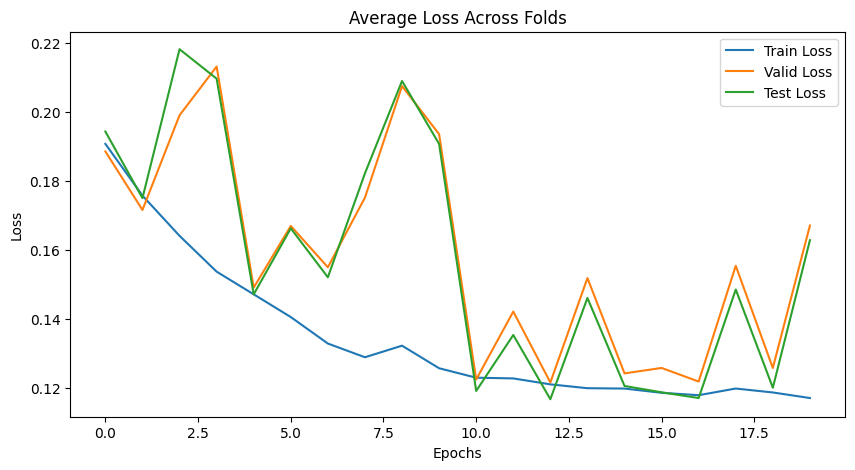

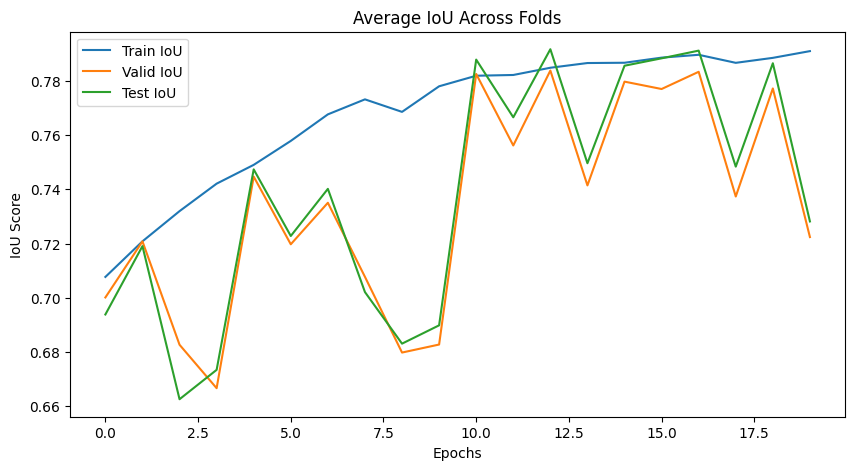

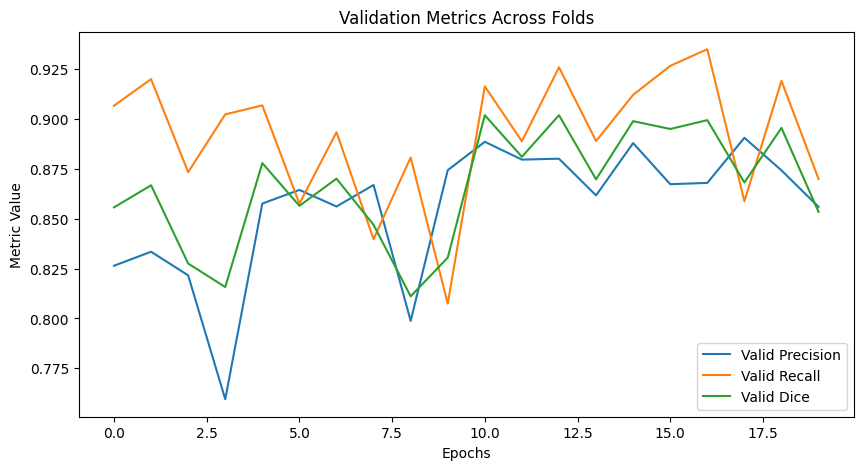

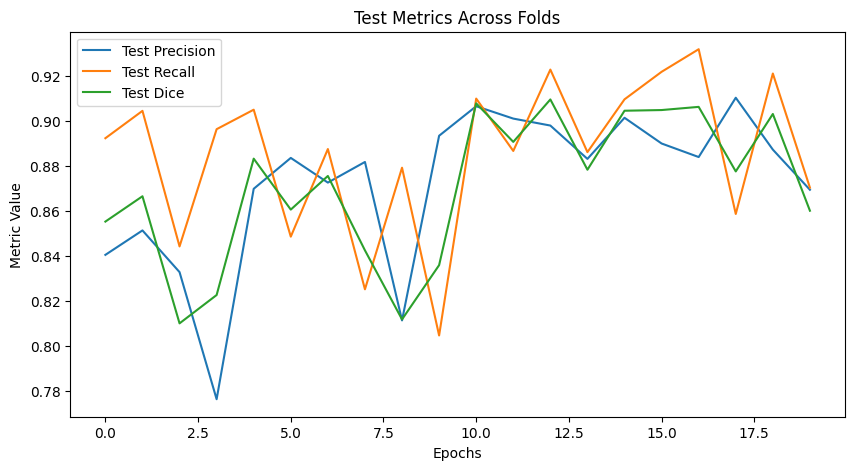

Metrics have been saved to 'Dataset1_model_Unet.csv'


/tmp/ipykernel_10497/1280507250.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_fpath)
/tmp/ipykernel_10497/2658853599.py:380: UserW

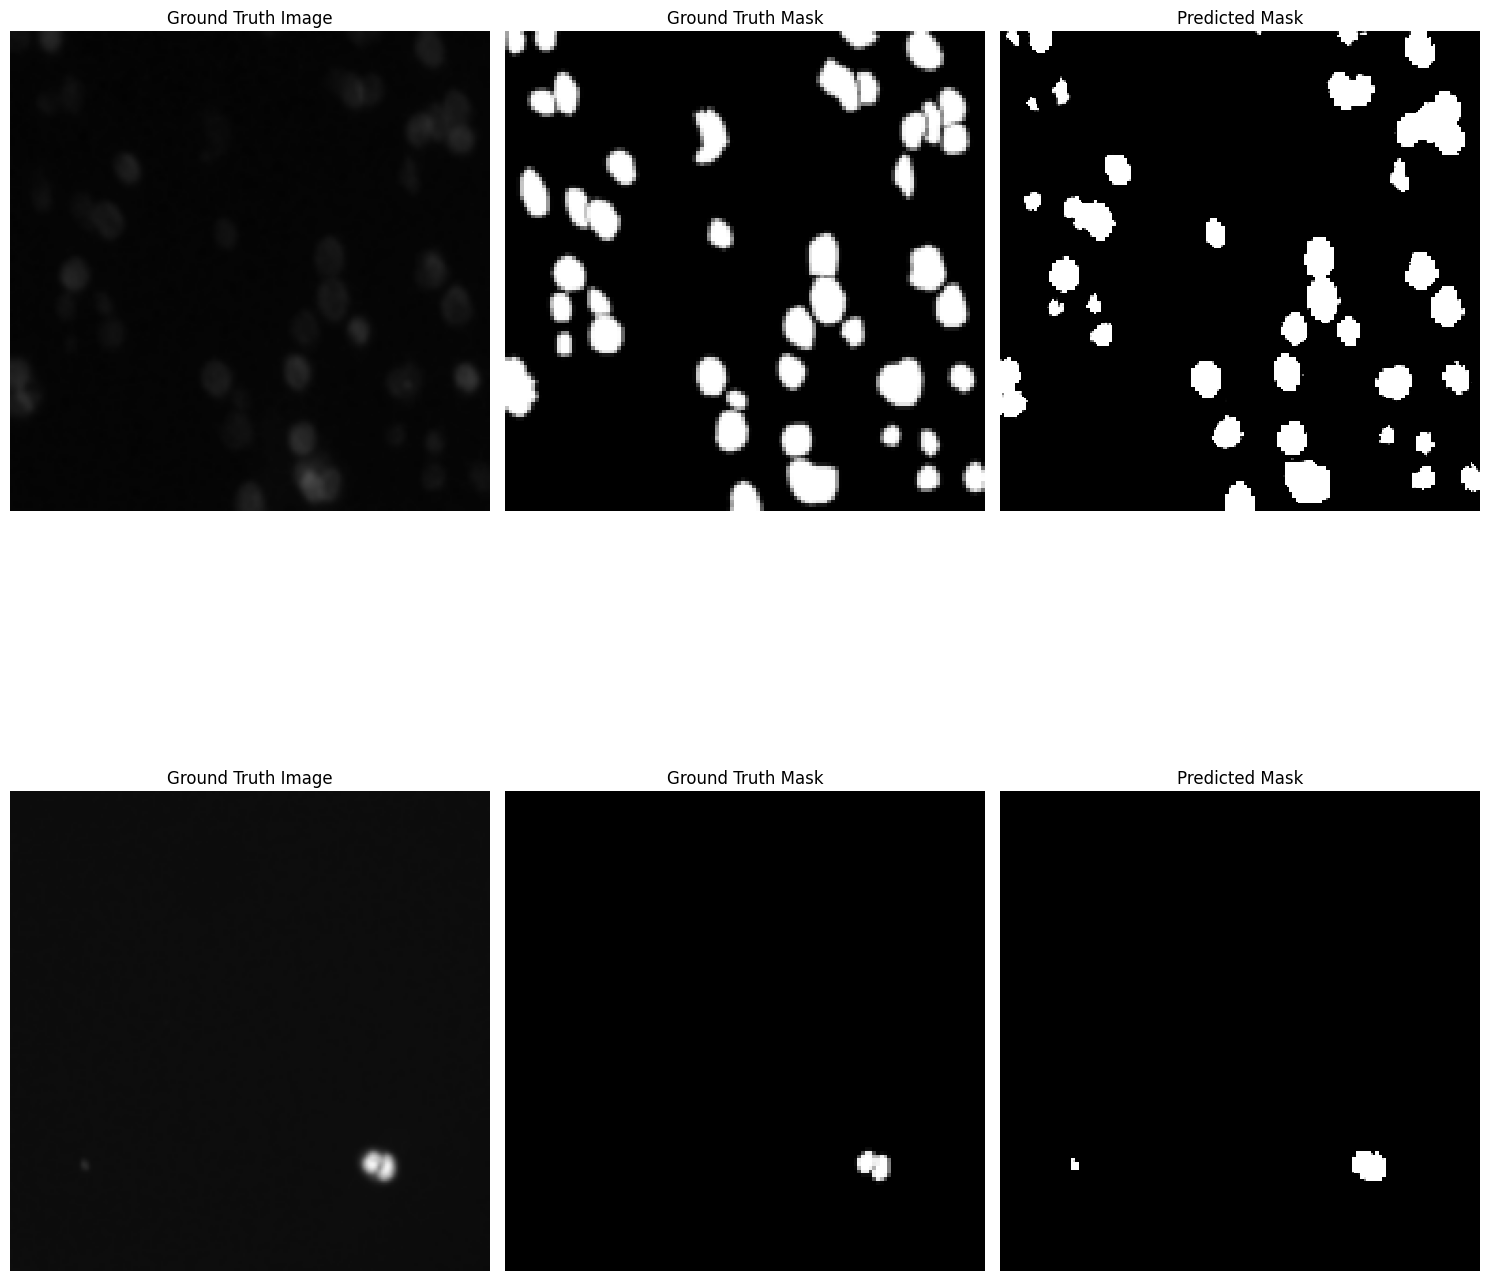

In [6]:
# Set up necessary directories and loss function
if not os.path.exists("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/UNet"):
    os.makedirs("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/UNet")

class double_conv(nn.Module):
    '''
    Double Convolution layer with both 2 BN and Activation Layer in between
    Conv2d==>BN==>Activation==>Conv2d==>BN==>Activation
    '''
    def __init__(self, in_channel, out_channel):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channel),
            nn.Conv2d(out_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channel)
        )
    def forward(self, x):
        x = self.conv(x)
        return x

class down_conv(nn.Module):
  '''
  A maxpool layer followed by a Double Convolution.
  MaxPool2d==>double_conv.
  '''
  def __init__(self, in_channel, out_channel):
    super(down_conv, self).__init__()
    self.down = nn.Sequential(
        nn.MaxPool2d(2),
        double_conv(in_channel, out_channel)
    )
  def forward(self, x):
    x = self.down(x)
    return x

class up_sample(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(up_sample, self).__init__()
    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.double_conv = double_conv(in_channel, out_channel)

  def forward(self, x1, x2):
      x1 = self.up(x1)
      x = torch.cat([x1, x2], dim=1)
      x = self.double_conv(x)
      return x

class UNet(nn.Module):
  '''Main Unet Model'''
  def __init__(self, in_channel, out_channel):
    super(UNet, self).__init__()
    ## DownSampling Block
    self.down_block1 = double_conv(in_channel, 16)
    self.down_block2 = down_conv(16, 32)
    self.down_block3 = down_conv(32, 64)
    self.down_block4 = down_conv(64, 128)
    self.down_block5 = down_conv(128, 256)
    self.down_block6 = down_conv(256, 512)
    self.down_block7 = down_conv(512, 1024)
    ## UpSampling Block
    self.up_block1 = up_sample(1024+512, 512)
    self.up_block2 = up_sample(512+256, 256)
    self.up_block3 = up_sample(256+128, 128)
    self.up_block4 = up_sample(128+64, 64)
    self.up_block5 = up_sample(64+32, 32)
    self.up_block6 = up_sample(32+16, 16)
    self.up_block7 = nn.Conv2d(16, out_channel, 1)


  def forward(self, x):
    #Down
    x1 = self.down_block1(x)
    x2 = self.down_block2(x1)
    x3 = self.down_block3(x2)
    x4 = self.down_block4(x3)
    x5 = self.down_block5(x4)
    x6 = self.down_block6(x5)
    x7 = self.down_block7(x6)
    #Up
    x8 = self.up_block1(x7, x6)
    x9 = self.up_block2(x8, x5)
    x10 = self.up_block3(x9, x4)
    x11 = self.up_block4(x10, x3)
    x12 = self.up_block5(x11, x2)
    x13 = self.up_block6(x12, x1)
    x14 = self.up_block7(x13)
    out = torch.sigmoid(x14)
    return out
  
  


# Initialize model and optimizer for each fold
model = UNet(3,1)  # Assuming UNet is defined earlier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Parameters and Data
num_epochs = 20
k_folds = 7
checkpoint_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/UNet/chkpoint_'
best_model_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/UNet/bestmodel.pt'

# Initialize metrics
accuracy_metric = IoU()  # Assuming IoU is a metric you defined earlier
criterion = DiceLoss()  # Assuming DiceLoss is defined earlier
valid_loss_min = np.inf

# Store results
total_train_loss, total_train_score  = [], []
total_valid_loss, total_valid_score  = [], []
total_test_loss, total_test_score  = [], []

total_train_precision, total_valid_precision, total_test_precision = [], [], []
total_train_recall, total_valid_recall, total_test_recall = [], [], []
total_train_dice, total_valid_dice, total_test_dice = [], [], []

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 7-fold Cross Validation Loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"\n####### Fold {fold+1}/{k_folds} #######")

    # Create data subsets for current fold
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=16, shuffle=False)

    # Track losses and scores for each fold
    fold_train_loss, fold_train_score = [], []
    fold_valid_loss, fold_valid_score = [], []
    fold_test_loss, fold_test_score = [], []
    
    fold_train_precision, fold_valid_precision, fold_test_precision = [], [], []
    fold_train_recall, fold_valid_recall, fold_test_recall = [], [], []
    fold_train_dice, fold_valid_dice, fold_test_dice = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_score = [], []

        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for x_train, y_train in pbar:
            x_train = torch.autograd.Variable(x_train)
            y_train = torch.autograd.Variable(y_train)
            optimizer.zero_grad()
            output = model(x_train)

            # Compute Loss and Score
            loss = criterion(output, y_train)
            score = accuracy_metric(output, y_train)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_score.append(score.item())
            pbar.set_description(f"Epoch {epoch+1} - Loss: {loss.item():.4f}, IoU: {score:.4f}")

        fold_train_loss.append(np.mean(train_loss))
        fold_train_score.append(np.mean(train_score))

        # Validation Loop
        model.eval()
        valid_loss, valid_score= [], []

        valid_precision = []
        valid_recall = []
        valid_dice = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = torch.autograd.Variable(x_val)
                y_val = torch.autograd.Variable(y_val)
                output = model(x_val)

                # Compute Loss and Score
                loss = criterion(output, y_val)
                score = accuracy_metric(output, y_val)

                valid_loss.append(loss.item())
                valid_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_val_bin = (y_val > 0.5).float()

                valid_precision.append(precision_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_recall.append(recall_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_dice.append(f1_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_valid_loss.append(np.mean(valid_loss))
        fold_valid_score.append(np.mean(valid_score))
        
        fold_valid_precision.append(np.mean(valid_precision))
        fold_valid_recall.append(np.mean(valid_recall))
        fold_valid_dice.append(np.mean(valid_dice))

        # Test Loop
        test_loss = []
        test_score = []
        
        test_precision = []
        test_recall = []
        test_dice = []

        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test = torch.autograd.Variable(x_test)
                y_test = torch.autograd.Variable(y_test)
                output = model(x_test)

                # Compute Loss and Score
                loss = criterion(output, y_test)
                score = accuracy_metric(output, y_test)

                test_loss.append(loss.item())
                test_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_test_bin = (y_test > 0.5).float()

                test_precision.append(precision_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_recall.append(recall_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_dice.append(f1_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_test_loss.append(np.mean(test_loss))
        fold_test_score.append(np.mean(test_score))

        fold_test_precision.append(np.mean(test_precision))
        fold_test_recall.append(np.mean(test_recall))
        fold_test_dice.append(np.mean(test_dice))

        print(f"Fold {fold+1} - Epoch {epoch+1} - Train Loss: {np.mean(train_loss):.4f}, IoU: {np.mean(train_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Loss: {np.mean(valid_loss):.4f}, IoU: {np.mean(valid_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Loss: {np.mean(test_loss):.4f}, IoU: {np.mean(test_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Precision: {np.mean(valid_precision):.4f}, Recall: {np.mean(valid_recall):.4f}, Dice: {np.mean(valid_dice):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Precision: {np.mean(test_precision):.4f}, Recall: {np.mean(test_recall):.4f}, Dice: {np.mean(test_dice):.4f}")

        # Save checkpoint and best model
        checkpoint = {
            'epoch': epoch+1,
            'valid_loss_min': fold_valid_loss[-1],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        if fold_valid_loss[-1] <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {fold_valid_loss[-1]:.6f}). Saving model...')
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = fold_valid_loss[-1]

    # Append fold results
    total_train_loss.append(fold_train_loss)
    total_train_score.append(fold_train_score)
    total_valid_loss.append(fold_valid_loss)
    total_valid_score.append(fold_valid_score)
    total_test_loss.append(fold_test_loss)
    total_test_score.append(fold_test_score)

    total_train_precision.append(fold_train_precision)
    total_valid_precision.append(fold_valid_precision)
    total_test_precision.append(fold_test_precision)

    total_train_recall.append(fold_train_recall)
    total_valid_recall.append(fold_valid_recall)
    total_test_recall.append(fold_test_recall)

    total_train_dice.append(fold_train_dice)
    total_valid_dice.append(fold_valid_dice)
    total_test_dice.append(fold_test_dice)

# Calculate average results over all folds
avg_train_loss = np.mean(total_train_loss, axis=0)
avg_train_score = np.mean(total_train_score, axis=0)
avg_valid_loss = np.mean(total_valid_loss, axis=0)
avg_valid_score = np.mean(total_valid_score, axis=0)
avg_test_loss = np.mean(total_test_loss, axis=0)
avg_test_score = np.mean(total_test_score, axis=0)

avg_train_precision = np.mean(total_train_precision, axis=0)
avg_valid_precision = np.mean(total_valid_precision, axis=0)
avg_test_precision = np.mean(total_test_precision, axis=0)

avg_train_recall = np.mean(total_train_recall, axis=0)
avg_valid_recall = np.mean(total_valid_recall, axis=0)
avg_test_recall = np.mean(total_test_recall, axis=0)

avg_train_dice = np.mean(total_train_dice, axis=0)
avg_valid_dice = np.mean(total_valid_dice, axis=0)
avg_test_dice = np.mean(total_test_dice, axis=0)

# Plot final averaged results for losses and metrics
plt.figure(figsize=(10,5))
plt.plot(avg_train_loss, label="Train Loss")
plt.plot(avg_valid_loss, label="Valid Loss")
plt.plot(avg_test_loss, label="Test Loss")
plt.legend()
plt.title("Average Loss Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot IoU scores
plt.figure(figsize=(10,5))
plt.plot(avg_train_score, label="Train IoU")
plt.plot(avg_valid_score, label="Valid IoU")
plt.plot(avg_test_score, label="Test IoU")
plt.legend()
plt.title("Average IoU Across Folds")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.show()

# Plot Precision, Recall, and Dice scores for validation and test sets
plt.figure(figsize=(10,5))
plt.plot(avg_valid_precision, label="Valid Precision")
plt.plot(avg_valid_recall, label="Valid Recall")
plt.plot(avg_valid_dice, label="Valid Dice")
plt.legend()
plt.title("Validation Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(avg_test_precision, label="Test Precision")
plt.plot(avg_test_recall, label="Test Recall")
plt.plot(avg_test_dice, label="Test Dice")
plt.legend()
plt.title("Test Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

import pandas as pd

# Create a DataFrame to store results
columns = [
    'Fold', 'Epoch', 'Train_Loss', 'Train_IoU', 'Valid_Loss', 'Valid_IoU', 'Test_Loss', 'Test_IoU',
    'Valid_Precision', 'Valid_Recall', 'Valid_Dice', 'Test_Precision', 'Test_Recall', 'Test_Dice'
]

results = []

# Collect the results after all folds and epochs
for fold in range(k_folds):
    for epoch in range(num_epochs):
        results.append([
            fold + 1, epoch + 1,
            total_train_loss[fold][epoch], total_train_score[fold][epoch],
            total_valid_loss[fold][epoch], total_valid_score[fold][epoch],total_test_loss[fold][epoch], total_test_score[fold][epoch],
            total_valid_precision[fold][epoch], total_valid_recall[fold][epoch], total_valid_dice[fold][epoch],
            total_test_precision[fold][epoch], total_test_recall[fold][epoch], total_test_dice[fold][epoch]
        ])

# Convert results to a pandas DataFrame
df = pd.DataFrame(results, columns=columns)

# Save DataFrame to CSV
df.to_csv("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/UNet/Dataset1_model_Unet.csv", index=False)

print("Metrics have been saved to 'Dataset1_model_Unet.csv'")

#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

def visualize_predict(model, n_images):
  #model = model.eval()
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in test_loader:
        data = torch.autograd.Variable(data, volatile=True)
        mask = torch.autograd.Variable(mask, volatile=True)
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Ground Truth Image")
    ax[img_no, 1].set_title("Ground Truth Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
  plt.tight_layout()
  plt.show()
  
visualize_predict(model, 2)

# SegNet


####### Fold 1/7 #######


Epoch 1 - Loss: 0.6388, IoU: 0.2204: 100%|██████| 36/36 [05:48<00:00,  9.67s/it]


Fold 1 - Epoch 1 - Train Loss: 0.7204, IoU: 0.1637
Fold 1 - Epoch 1 - Valid Loss: 0.6408, IoU: 0.2193
Fold 1 - Epoch 1 - Test Loss: 0.6544, IoU: 0.2099
Fold 1 - Epoch 1 - Valid Precision: 0.3557, Recall: 0.7963, Dice: 0.4881
Fold 1 - Epoch 1 - Test Precision: 0.3814, Recall: 0.7948, Dice: 0.5050
Validation loss decreased (inf --> 0.640811). Saving model...


Epoch 2 - Loss: 0.5700, IoU: 0.2739: 100%|██████| 36/36 [05:49<00:00,  9.70s/it]


Fold 1 - Epoch 2 - Train Loss: 0.6331, IoU: 0.2261
Fold 1 - Epoch 2 - Valid Loss: 0.6234, IoU: 0.2325
Fold 1 - Epoch 2 - Test Loss: 0.6447, IoU: 0.2174
Fold 1 - Epoch 2 - Valid Precision: 0.5460, Recall: 0.7251, Dice: 0.6196
Fold 1 - Epoch 2 - Test Precision: 0.5622, Recall: 0.7288, Dice: 0.6278
Validation loss decreased (0.640811 --> 0.623389). Saving model...


Epoch 3 - Loss: 0.5808, IoU: 0.2652: 100%|██████| 36/36 [05:49<00:00,  9.70s/it]


Fold 1 - Epoch 3 - Train Loss: 0.6089, IoU: 0.2445
Fold 1 - Epoch 3 - Valid Loss: 0.5648, IoU: 0.2786
Fold 1 - Epoch 3 - Test Loss: 0.5904, IoU: 0.2588
Fold 1 - Epoch 3 - Valid Precision: 0.5478, Recall: 0.9688, Dice: 0.6988
Fold 1 - Epoch 3 - Test Precision: 0.5322, Recall: 0.9730, Dice: 0.6867
Validation loss decreased (0.623389 --> 0.564827). Saving model...


Epoch 4 - Loss: 0.6061, IoU: 0.2453: 100%|██████| 36/36 [05:49<00:00,  9.70s/it]


Fold 1 - Epoch 4 - Train Loss: 0.5947, IoU: 0.2555
Fold 1 - Epoch 4 - Valid Loss: 0.5494, IoU: 0.2914
Fold 1 - Epoch 4 - Test Loss: 0.5764, IoU: 0.2702
Fold 1 - Epoch 4 - Valid Precision: 0.6135, Recall: 0.9694, Dice: 0.7507
Fold 1 - Epoch 4 - Test Precision: 0.6116, Recall: 0.9680, Dice: 0.7477
Validation loss decreased (0.564827 --> 0.549399). Saving model...


Epoch 5 - Loss: 0.4874, IoU: 0.3446: 100%|██████| 36/36 [05:49<00:00,  9.71s/it]


Fold 1 - Epoch 5 - Train Loss: 0.5835, IoU: 0.2641
Fold 1 - Epoch 5 - Valid Loss: 0.6422, IoU: 0.2183
Fold 1 - Epoch 5 - Test Loss: 0.6726, IoU: 0.1971
Fold 1 - Epoch 5 - Valid Precision: 0.6334, Recall: 0.5581, Dice: 0.5879
Fold 1 - Epoch 5 - Test Precision: 0.6497, Recall: 0.5236, Dice: 0.5653


Epoch 6 - Loss: 0.5579, IoU: 0.2838: 100%|██████| 36/36 [05:50<00:00,  9.74s/it]


Fold 1 - Epoch 6 - Train Loss: 0.5795, IoU: 0.2677
Fold 1 - Epoch 6 - Valid Loss: 0.5324, IoU: 0.3057
Fold 1 - Epoch 6 - Test Loss: 0.5583, IoU: 0.2849
Fold 1 - Epoch 6 - Valid Precision: 0.7307, Recall: 0.9361, Dice: 0.8205
Fold 1 - Epoch 6 - Test Precision: 0.7352, Recall: 0.9433, Dice: 0.8249
Validation loss decreased (0.549399 --> 0.532420). Saving model...


Epoch 7 - Loss: 0.5817, IoU: 0.2645: 100%|██████| 36/36 [05:50<00:00,  9.74s/it]


Fold 1 - Epoch 7 - Train Loss: 0.5635, IoU: 0.2805
Fold 1 - Epoch 7 - Valid Loss: 0.5181, IoU: 0.3179
Fold 1 - Epoch 7 - Test Loss: 0.5430, IoU: 0.2978
Fold 1 - Epoch 7 - Valid Precision: 0.6981, Recall: 0.9617, Dice: 0.8087
Fold 1 - Epoch 7 - Test Precision: 0.7095, Recall: 0.9670, Dice: 0.8173
Validation loss decreased (0.532420 --> 0.518111). Saving model...


Epoch 8 - Loss: 0.5371, IoU: 0.3012: 100%|██████| 36/36 [05:51<00:00,  9.76s/it]


Fold 1 - Epoch 8 - Train Loss: 0.5572, IoU: 0.2861
Fold 1 - Epoch 8 - Valid Loss: 0.5177, IoU: 0.3183
Fold 1 - Epoch 8 - Test Loss: 0.5427, IoU: 0.2980
Fold 1 - Epoch 8 - Valid Precision: 0.6820, Recall: 0.9526, Dice: 0.7938
Fold 1 - Epoch 8 - Test Precision: 0.6943, Recall: 0.9547, Dice: 0.8024
Validation loss decreased (0.518111 --> 0.517654). Saving model...


Epoch 9 - Loss: 0.6292, IoU: 0.2276: 100%|██████| 36/36 [05:49<00:00,  9.72s/it]


Fold 1 - Epoch 9 - Train Loss: 0.5458, IoU: 0.2952
Fold 1 - Epoch 9 - Valid Loss: 0.5022, IoU: 0.3319
Fold 1 - Epoch 9 - Test Loss: 0.5299, IoU: 0.3088
Fold 1 - Epoch 9 - Valid Precision: 0.6261, Recall: 0.9764, Dice: 0.7618
Fold 1 - Epoch 9 - Test Precision: 0.6124, Recall: 0.9775, Dice: 0.7518
Validation loss decreased (0.517654 --> 0.502220). Saving model...


Epoch 10 - Loss: 0.5497, IoU: 0.2906: 100%|█████| 36/36 [05:49<00:00,  9.72s/it]


Fold 1 - Epoch 10 - Train Loss: 0.5371, IoU: 0.3027
Fold 1 - Epoch 10 - Valid Loss: 0.4985, IoU: 0.3352
Fold 1 - Epoch 10 - Test Loss: 0.5246, IoU: 0.3135
Fold 1 - Epoch 10 - Valid Precision: 0.7416, Recall: 0.9345, Dice: 0.8265
Fold 1 - Epoch 10 - Test Precision: 0.7501, Recall: 0.9385, Dice: 0.8317
Validation loss decreased (0.502220 --> 0.498520). Saving model...


Epoch 11 - Loss: 0.6463, IoU: 0.2149: 100%|█████| 36/36 [05:49<00:00,  9.70s/it]


Fold 1 - Epoch 11 - Train Loss: 0.5244, IoU: 0.3130
Fold 1 - Epoch 11 - Valid Loss: 0.4944, IoU: 0.3389
Fold 1 - Epoch 11 - Test Loss: 0.5135, IoU: 0.3232
Fold 1 - Epoch 11 - Valid Precision: 0.6506, Recall: 0.9597, Dice: 0.7735
Fold 1 - Epoch 11 - Test Precision: 0.6915, Recall: 0.9621, Dice: 0.8012
Validation loss decreased (0.498520 --> 0.494433). Saving model...


Epoch 12 - Loss: 0.5318, IoU: 0.3057: 100%|█████| 36/36 [05:49<00:00,  9.70s/it]


Fold 1 - Epoch 12 - Train Loss: 0.5173, IoU: 0.3196
Fold 1 - Epoch 12 - Valid Loss: 0.4789, IoU: 0.3529
Fold 1 - Epoch 12 - Test Loss: 0.5043, IoU: 0.3312
Fold 1 - Epoch 12 - Valid Precision: 0.6468, Recall: 0.9713, Dice: 0.7761
Fold 1 - Epoch 12 - Test Precision: 0.6457, Recall: 0.9729, Dice: 0.7746
Validation loss decreased (0.494433 --> 0.478878). Saving model...


Epoch 13 - Loss: 0.4981, IoU: 0.3351: 100%|█████| 36/36 [05:49<00:00,  9.72s/it]


Fold 1 - Epoch 13 - Train Loss: 0.5052, IoU: 0.3302
Fold 1 - Epoch 13 - Valid Loss: 0.4666, IoU: 0.3642
Fold 1 - Epoch 13 - Test Loss: 0.4897, IoU: 0.3444
Fold 1 - Epoch 13 - Valid Precision: 0.6893, Recall: 0.9671, Dice: 0.8044
Fold 1 - Epoch 13 - Test Precision: 0.7094, Recall: 0.9689, Dice: 0.8175
Validation loss decreased (0.478878 --> 0.466581). Saving model...


Epoch 14 - Loss: 0.4685, IoU: 0.3619: 100%|█████| 36/36 [05:50<00:00,  9.74s/it]


Fold 1 - Epoch 14 - Train Loss: 0.4981, IoU: 0.3371
Fold 1 - Epoch 14 - Valid Loss: 0.4604, IoU: 0.3700
Fold 1 - Epoch 14 - Test Loss: 0.4868, IoU: 0.3469
Fold 1 - Epoch 14 - Valid Precision: 0.7105, Recall: 0.9569, Dice: 0.8153
Fold 1 - Epoch 14 - Test Precision: 0.6928, Recall: 0.9656, Dice: 0.8053
Validation loss decreased (0.466581 --> 0.460413). Saving model...


Epoch 15 - Loss: 0.4921, IoU: 0.3404: 100%|█████| 36/36 [05:50<00:00,  9.75s/it]


Fold 1 - Epoch 15 - Train Loss: 0.4858, IoU: 0.3477
Fold 1 - Epoch 15 - Valid Loss: 0.4525, IoU: 0.3774
Fold 1 - Epoch 15 - Test Loss: 0.4766, IoU: 0.3562
Fold 1 - Epoch 15 - Valid Precision: 0.7298, Recall: 0.9471, Dice: 0.8238
Fold 1 - Epoch 15 - Test Precision: 0.7405, Recall: 0.9516, Dice: 0.8308
Validation loss decreased (0.460413 --> 0.452538). Saving model...


Epoch 16 - Loss: 0.5553, IoU: 0.2859: 100%|█████| 36/36 [05:49<00:00,  9.70s/it]


Fold 1 - Epoch 16 - Train Loss: 0.4754, IoU: 0.3572
Fold 1 - Epoch 16 - Valid Loss: 0.5158, IoU: 0.3202
Fold 1 - Epoch 16 - Test Loss: 0.5314, IoU: 0.3080
Fold 1 - Epoch 16 - Valid Precision: 0.6441, Recall: 0.7603, Dice: 0.6952
Fold 1 - Epoch 16 - Test Precision: 0.6684, Recall: 0.7811, Dice: 0.7139


Epoch 17 - Loss: 0.4736, IoU: 0.3572: 100%|█████| 36/36 [05:50<00:00,  9.74s/it]


Fold 1 - Epoch 17 - Train Loss: 0.4758, IoU: 0.3576
Fold 1 - Epoch 17 - Valid Loss: 0.4335, IoU: 0.3956
Fold 1 - Epoch 17 - Test Loss: 0.4549, IoU: 0.3764
Fold 1 - Epoch 17 - Valid Precision: 0.7099, Recall: 0.9490, Dice: 0.8111
Fold 1 - Epoch 17 - Test Precision: 0.7259, Recall: 0.9513, Dice: 0.8223
Validation loss decreased (0.452538 --> 0.433526). Saving model...


Epoch 18 - Loss: 0.4776, IoU: 0.3535: 100%|█████| 36/36 [05:50<00:00,  9.73s/it]


Fold 1 - Epoch 18 - Train Loss: 0.4572, IoU: 0.3737
Fold 1 - Epoch 18 - Valid Loss: 0.4814, IoU: 0.3512
Fold 1 - Epoch 18 - Test Loss: 0.5080, IoU: 0.3292
Fold 1 - Epoch 18 - Valid Precision: 0.7478, Recall: 0.7719, Dice: 0.7566
Fold 1 - Epoch 18 - Test Precision: 0.7550, Recall: 0.7671, Dice: 0.7536


Epoch 19 - Loss: 0.4781, IoU: 0.3531: 100%|█████| 36/36 [05:52<00:00,  9.79s/it]


Fold 1 - Epoch 19 - Train Loss: 0.4565, IoU: 0.3748
Fold 1 - Epoch 19 - Valid Loss: 0.4138, IoU: 0.4151
Fold 1 - Epoch 19 - Test Loss: 0.4363, IoU: 0.3943
Fold 1 - Epoch 19 - Valid Precision: 0.7326, Recall: 0.9578, Dice: 0.8295
Fold 1 - Epoch 19 - Test Precision: 0.7514, Recall: 0.9573, Dice: 0.8407
Validation loss decreased (0.433526 --> 0.413834). Saving model...


Epoch 20 - Loss: 0.4136, IoU: 0.4148: 100%|█████| 36/36 [05:51<00:00,  9.78s/it]


Fold 1 - Epoch 20 - Train Loss: 0.4454, IoU: 0.3859
Fold 1 - Epoch 20 - Valid Loss: 0.4709, IoU: 0.3605
Fold 1 - Epoch 20 - Test Loss: 0.4912, IoU: 0.3431
Fold 1 - Epoch 20 - Valid Precision: 0.7459, Recall: 0.7716, Dice: 0.7572
Fold 1 - Epoch 20 - Test Precision: 0.7622, Recall: 0.7797, Dice: 0.7682

####### Fold 2/7 #######


Epoch 1 - Loss: 0.3774, IoU: 0.4520: 100%|██████| 36/36 [05:51<00:00,  9.77s/it]


Fold 2 - Epoch 1 - Train Loss: 0.4320, IoU: 0.3979
Fold 2 - Epoch 1 - Valid Loss: 0.4873, IoU: 0.3460
Fold 2 - Epoch 1 - Test Loss: 0.4708, IoU: 0.3612
Fold 2 - Epoch 1 - Valid Precision: 0.6777, Recall: 0.8740, Dice: 0.7625
Fold 2 - Epoch 1 - Test Precision: 0.6811, Recall: 0.8723, Dice: 0.7602


Epoch 2 - Loss: 0.3846, IoU: 0.4444: 100%|██████| 36/36 [05:47<00:00,  9.66s/it]


Fold 2 - Epoch 2 - Train Loss: 0.4362, IoU: 0.3939
Fold 2 - Epoch 2 - Valid Loss: 0.4464, IoU: 0.3838
Fold 2 - Epoch 2 - Test Loss: 0.4328, IoU: 0.3973
Fold 2 - Epoch 2 - Valid Precision: 0.7036, Recall: 0.9404, Dice: 0.8044
Fold 2 - Epoch 2 - Test Precision: 0.7260, Recall: 0.9131, Dice: 0.8079


Epoch 3 - Loss: 0.4549, IoU: 0.3746: 100%|██████| 36/36 [05:48<00:00,  9.67s/it]


Fold 2 - Epoch 3 - Train Loss: 0.4235, IoU: 0.4077
Fold 2 - Epoch 3 - Valid Loss: 0.4177, IoU: 0.4121
Fold 2 - Epoch 3 - Test Loss: 0.3996, IoU: 0.4307
Fold 2 - Epoch 3 - Valid Precision: 0.7507, Recall: 0.9726, Dice: 0.8470
Fold 2 - Epoch 3 - Test Precision: 0.7716, Recall: 0.9563, Dice: 0.8530


Epoch 4 - Loss: 0.4216, IoU: 0.4068: 100%|██████| 36/36 [05:48<00:00,  9.67s/it]


Fold 2 - Epoch 4 - Train Loss: 0.4024, IoU: 0.4273
Fold 2 - Epoch 4 - Valid Loss: 0.4115, IoU: 0.4183
Fold 2 - Epoch 4 - Test Loss: 0.3957, IoU: 0.4346
Fold 2 - Epoch 4 - Valid Precision: 0.7300, Recall: 0.9722, Dice: 0.8336
Fold 2 - Epoch 4 - Test Precision: 0.7459, Recall: 0.9562, Dice: 0.8367
Validation loss decreased (0.413834 --> 0.411492). Saving model...


Epoch 5 - Loss: 0.3816, IoU: 0.4476: 100%|██████| 36/36 [05:48<00:00,  9.68s/it]


Fold 2 - Epoch 5 - Train Loss: 0.3964, IoU: 0.4342
Fold 2 - Epoch 5 - Valid Loss: 0.4057, IoU: 0.4242
Fold 2 - Epoch 5 - Test Loss: 0.3862, IoU: 0.4444
Fold 2 - Epoch 5 - Valid Precision: 0.7318, Recall: 0.9759, Dice: 0.8359
Fold 2 - Epoch 5 - Test Precision: 0.7602, Recall: 0.9598, Dice: 0.8472
Validation loss decreased (0.411492 --> 0.405682). Saving model...


Epoch 6 - Loss: 0.4510, IoU: 0.3783: 100%|██████| 36/36 [05:49<00:00,  9.70s/it]


Fold 2 - Epoch 6 - Train Loss: 0.3862, IoU: 0.4444
Fold 2 - Epoch 6 - Valid Loss: 0.3919, IoU: 0.4384
Fold 2 - Epoch 6 - Test Loss: 0.3755, IoU: 0.4557
Fold 2 - Epoch 6 - Valid Precision: 0.8023, Recall: 0.9660, Dice: 0.8762
Fold 2 - Epoch 6 - Test Precision: 0.8271, Recall: 0.9452, Dice: 0.8815
Validation loss decreased (0.405682 --> 0.391876). Saving model...


Epoch 7 - Loss: 0.3290, IoU: 0.5049: 100%|██████| 36/36 [05:46<00:00,  9.64s/it]


Fold 2 - Epoch 7 - Train Loss: 0.3794, IoU: 0.4524
Fold 2 - Epoch 7 - Valid Loss: 0.3821, IoU: 0.4485
Fold 2 - Epoch 7 - Test Loss: 0.3643, IoU: 0.4676
Fold 2 - Epoch 7 - Valid Precision: 0.7879, Recall: 0.9734, Dice: 0.8706
Fold 2 - Epoch 7 - Test Precision: 0.8118, Recall: 0.9584, Dice: 0.8784
Validation loss decreased (0.391876 --> 0.382134). Saving model...


Epoch 8 - Loss: 0.3362, IoU: 0.4968: 100%|██████| 36/36 [05:49<00:00,  9.71s/it]


Fold 2 - Epoch 8 - Train Loss: 0.3699, IoU: 0.4620
Fold 2 - Epoch 8 - Valid Loss: 0.3782, IoU: 0.4524
Fold 2 - Epoch 8 - Test Loss: 0.3618, IoU: 0.4702
Fold 2 - Epoch 8 - Valid Precision: 0.7870, Recall: 0.9648, Dice: 0.8665
Fold 2 - Epoch 8 - Test Precision: 0.8072, Recall: 0.9472, Dice: 0.8710
Validation loss decreased (0.382134 --> 0.378245). Saving model...


Epoch 9 - Loss: 0.3239, IoU: 0.5107: 100%|██████| 36/36 [05:49<00:00,  9.70s/it]


Fold 2 - Epoch 9 - Train Loss: 0.3662, IoU: 0.4667
Fold 2 - Epoch 9 - Valid Loss: 0.3663, IoU: 0.4651
Fold 2 - Epoch 9 - Test Loss: 0.3504, IoU: 0.4826
Fold 2 - Epoch 9 - Valid Precision: 0.7706, Recall: 0.9764, Dice: 0.8611
Fold 2 - Epoch 9 - Test Precision: 0.7809, Recall: 0.9660, Dice: 0.8631
Validation loss decreased (0.378245 --> 0.366330). Saving model...


Epoch 10 - Loss: 0.4736, IoU: 0.3572: 100%|█████| 36/36 [05:50<00:00,  9.73s/it]


Fold 2 - Epoch 10 - Train Loss: 0.3575, IoU: 0.4755
Fold 2 - Epoch 10 - Valid Loss: 0.3648, IoU: 0.4667
Fold 2 - Epoch 10 - Test Loss: 0.3451, IoU: 0.4885
Fold 2 - Epoch 10 - Valid Precision: 0.7448, Recall: 0.9804, Dice: 0.8459
Fold 2 - Epoch 10 - Test Precision: 0.7684, Recall: 0.9688, Dice: 0.8565
Validation loss decreased (0.366330 --> 0.364814). Saving model...


Epoch 11 - Loss: 0.3691, IoU: 0.4609: 100%|█████| 36/36 [05:49<00:00,  9.71s/it]


Fold 2 - Epoch 11 - Train Loss: 0.3492, IoU: 0.4841
Fold 2 - Epoch 11 - Valid Loss: 0.3513, IoU: 0.4814
Fold 2 - Epoch 11 - Test Loss: 0.3336, IoU: 0.5012
Fold 2 - Epoch 11 - Valid Precision: 0.7826, Recall: 0.9795, Dice: 0.8697
Fold 2 - Epoch 11 - Test Precision: 0.8014, Recall: 0.9685, Dice: 0.8765
Validation loss decreased (0.364814 --> 0.351268). Saving model...


Epoch 12 - Loss: 0.3460, IoU: 0.4859: 100%|█████| 36/36 [05:50<00:00,  9.74s/it]


Fold 2 - Epoch 12 - Train Loss: 0.3414, IoU: 0.4928
Fold 2 - Epoch 12 - Valid Loss: 0.3481, IoU: 0.4850
Fold 2 - Epoch 12 - Test Loss: 0.3301, IoU: 0.5051
Fold 2 - Epoch 12 - Valid Precision: 0.8038, Recall: 0.9660, Dice: 0.8769
Fold 2 - Epoch 12 - Test Precision: 0.8307, Recall: 0.9502, Dice: 0.8858
Validation loss decreased (0.351268 --> 0.348101). Saving model...


Epoch 13 - Loss: 0.3016, IoU: 0.5366: 100%|█████| 36/36 [05:51<00:00,  9.77s/it]


Fold 2 - Epoch 13 - Train Loss: 0.3368, IoU: 0.4984
Fold 2 - Epoch 13 - Valid Loss: 0.3502, IoU: 0.4824
Fold 2 - Epoch 13 - Test Loss: 0.3356, IoU: 0.4987
Fold 2 - Epoch 13 - Valid Precision: 0.7447, Recall: 0.9677, Dice: 0.8414
Fold 2 - Epoch 13 - Test Precision: 0.7532, Recall: 0.9604, Dice: 0.8436


Epoch 14 - Loss: 0.2549, IoU: 0.5938: 100%|█████| 36/36 [05:50<00:00,  9.72s/it]


Fold 2 - Epoch 14 - Train Loss: 0.3287, IoU: 0.5070
Fold 2 - Epoch 14 - Valid Loss: 0.3302, IoU: 0.5048
Fold 2 - Epoch 14 - Test Loss: 0.3168, IoU: 0.5203
Fold 2 - Epoch 14 - Valid Precision: 0.7895, Recall: 0.9694, Dice: 0.8700
Fold 2 - Epoch 14 - Test Precision: 0.8049, Recall: 0.9552, Dice: 0.8727
Validation loss decreased (0.348101 --> 0.330229). Saving model...


Epoch 15 - Loss: 0.5602, IoU: 0.2819: 100%|█████| 36/36 [05:51<00:00,  9.75s/it]


Fold 2 - Epoch 15 - Train Loss: 0.3253, IoU: 0.5119
Fold 2 - Epoch 15 - Valid Loss: 0.3321, IoU: 0.5026
Fold 2 - Epoch 15 - Test Loss: 0.3152, IoU: 0.5221
Fold 2 - Epoch 15 - Valid Precision: 0.7750, Recall: 0.9754, Dice: 0.8632
Fold 2 - Epoch 15 - Test Precision: 0.7969, Recall: 0.9620, Dice: 0.8710


Epoch 16 - Loss: 0.3121, IoU: 0.5243: 100%|█████| 36/36 [05:50<00:00,  9.73s/it]


Fold 2 - Epoch 16 - Train Loss: 0.3205, IoU: 0.5167
Fold 2 - Epoch 16 - Valid Loss: 0.3164, IoU: 0.5205
Fold 2 - Epoch 16 - Test Loss: 0.3083, IoU: 0.5301
Fold 2 - Epoch 16 - Valid Precision: 0.8189, Recall: 0.9607, Dice: 0.8839
Fold 2 - Epoch 16 - Test Precision: 0.8317, Recall: 0.9347, Dice: 0.8797
Validation loss decreased (0.330229 --> 0.316442). Saving model...


Epoch 17 - Loss: 0.3308, IoU: 0.5028: 100%|█████| 36/36 [05:49<00:00,  9.70s/it]


Fold 2 - Epoch 17 - Train Loss: 0.3099, IoU: 0.5287
Fold 2 - Epoch 17 - Valid Loss: 0.3121, IoU: 0.5255
Fold 2 - Epoch 17 - Test Loss: 0.2991, IoU: 0.5410
Fold 2 - Epoch 17 - Valid Precision: 0.8245, Recall: 0.9649, Dice: 0.8889
Fold 2 - Epoch 17 - Test Precision: 0.8396, Recall: 0.9495, Dice: 0.8906
Validation loss decreased (0.316442 --> 0.312090). Saving model...


Epoch 18 - Loss: 0.2267, IoU: 0.6304: 100%|█████| 36/36 [05:50<00:00,  9.75s/it]


Fold 2 - Epoch 18 - Train Loss: 0.3073, IoU: 0.5325
Fold 2 - Epoch 18 - Valid Loss: 0.3035, IoU: 0.5356
Fold 2 - Epoch 18 - Test Loss: 0.2911, IoU: 0.5505
Fold 2 - Epoch 18 - Valid Precision: 0.8434, Recall: 0.9586, Dice: 0.8970
Fold 2 - Epoch 18 - Test Precision: 0.8599, Recall: 0.9409, Dice: 0.8981
Validation loss decreased (0.312090 --> 0.303514). Saving model...


Epoch 19 - Loss: 0.3266, IoU: 0.5076: 100%|█████| 36/36 [05:49<00:00,  9.72s/it]


Fold 2 - Epoch 19 - Train Loss: 0.2996, IoU: 0.5412
Fold 2 - Epoch 19 - Valid Loss: 0.3029, IoU: 0.5362
Fold 2 - Epoch 19 - Test Loss: 0.2860, IoU: 0.5565
Fold 2 - Epoch 19 - Valid Precision: 0.7684, Recall: 0.9804, Dice: 0.8612
Fold 2 - Epoch 19 - Test Precision: 0.7941, Recall: 0.9702, Dice: 0.8727
Validation loss decreased (0.303514 --> 0.302903). Saving model...


Epoch 20 - Loss: 0.2840, IoU: 0.5577: 100%|█████| 36/36 [05:49<00:00,  9.71s/it]


Fold 2 - Epoch 20 - Train Loss: 0.2953, IoU: 0.5459
Fold 2 - Epoch 20 - Valid Loss: 0.2960, IoU: 0.5444
Fold 2 - Epoch 20 - Test Loss: 0.2805, IoU: 0.5632
Fold 2 - Epoch 20 - Valid Precision: 0.7894, Recall: 0.9768, Dice: 0.8728
Fold 2 - Epoch 20 - Test Precision: 0.8162, Recall: 0.9624, Dice: 0.8826
Validation loss decreased (0.302903 --> 0.295993). Saving model...

####### Fold 3/7 #######


Epoch 1 - Loss: 0.2319, IoU: 0.6235: 100%|██████| 36/36 [05:48<00:00,  9.69s/it]


Fold 3 - Epoch 1 - Train Loss: 0.2865, IoU: 0.5566
Fold 3 - Epoch 1 - Valid Loss: 0.2946, IoU: 0.5461
Fold 3 - Epoch 1 - Test Loss: 0.2762, IoU: 0.5684
Fold 3 - Epoch 1 - Valid Precision: 0.7939, Recall: 0.9682, Dice: 0.8715
Fold 3 - Epoch 1 - Test Precision: 0.8296, Recall: 0.9587, Dice: 0.8888
Validation loss decreased (0.295993 --> 0.294627). Saving model...


Epoch 2 - Loss: 0.2432, IoU: 0.6087: 100%|██████| 36/36 [05:47<00:00,  9.65s/it]


Fold 3 - Epoch 2 - Train Loss: 0.2801, IoU: 0.5638
Fold 3 - Epoch 2 - Valid Loss: 0.2944, IoU: 0.5462
Fold 3 - Epoch 2 - Test Loss: 0.2747, IoU: 0.5702
Fold 3 - Epoch 2 - Valid Precision: 0.8039, Recall: 0.9570, Dice: 0.8723
Fold 3 - Epoch 2 - Test Precision: 0.8488, Recall: 0.9440, Dice: 0.8934
Validation loss decreased (0.294627 --> 0.294369). Saving model...


Epoch 3 - Loss: 0.2608, IoU: 0.5863: 100%|██████| 36/36 [05:47<00:00,  9.66s/it]


Fold 3 - Epoch 3 - Train Loss: 0.2749, IoU: 0.5705
Fold 3 - Epoch 3 - Valid Loss: 0.2837, IoU: 0.5592
Fold 3 - Epoch 3 - Test Loss: 0.2630, IoU: 0.5847
Fold 3 - Epoch 3 - Valid Precision: 0.7793, Recall: 0.9721, Dice: 0.8637
Fold 3 - Epoch 3 - Test Precision: 0.8200, Recall: 0.9641, Dice: 0.8856
Validation loss decreased (0.294369 --> 0.283748). Saving model...


Epoch 4 - Loss: 0.2904, IoU: 0.5499: 100%|██████| 36/36 [05:49<00:00,  9.70s/it]


Fold 3 - Epoch 4 - Train Loss: 0.2718, IoU: 0.5749
Fold 3 - Epoch 4 - Valid Loss: 0.2976, IoU: 0.5426
Fold 3 - Epoch 4 - Test Loss: 0.2738, IoU: 0.5713
Fold 3 - Epoch 4 - Valid Precision: 0.7358, Recall: 0.9746, Dice: 0.8371
Fold 3 - Epoch 4 - Test Precision: 0.7800, Recall: 0.9676, Dice: 0.8631


Epoch 5 - Loss: 0.2060, IoU: 0.6584: 100%|██████| 36/36 [05:50<00:00,  9.74s/it]


Fold 3 - Epoch 5 - Train Loss: 0.2658, IoU: 0.5818
Fold 3 - Epoch 5 - Valid Loss: 0.2799, IoU: 0.5637
Fold 3 - Epoch 5 - Test Loss: 0.2563, IoU: 0.5930
Fold 3 - Epoch 5 - Valid Precision: 0.8018, Recall: 0.9610, Dice: 0.8726
Fold 3 - Epoch 5 - Test Precision: 0.8555, Recall: 0.9499, Dice: 0.8998
Validation loss decreased (0.283748 --> 0.279899). Saving model...


Epoch 6 - Loss: 0.2560, IoU: 0.5924: 100%|██████| 36/36 [05:47<00:00,  9.64s/it]


Fold 3 - Epoch 6 - Train Loss: 0.2676, IoU: 0.5794
Fold 3 - Epoch 6 - Valid Loss: 0.2756, IoU: 0.5691
Fold 3 - Epoch 6 - Test Loss: 0.2528, IoU: 0.5974
Fold 3 - Epoch 6 - Valid Precision: 0.7935, Recall: 0.9535, Dice: 0.8645
Fold 3 - Epoch 6 - Test Precision: 0.8489, Recall: 0.9375, Dice: 0.8907
Validation loss decreased (0.279899 --> 0.275555). Saving model...


Epoch 7 - Loss: 0.2132, IoU: 0.6486: 100%|██████| 36/36 [05:46<00:00,  9.63s/it]


Fold 3 - Epoch 7 - Train Loss: 0.2589, IoU: 0.5899
Fold 3 - Epoch 7 - Valid Loss: 0.2658, IoU: 0.5811
Fold 3 - Epoch 7 - Test Loss: 0.2473, IoU: 0.6045
Fold 3 - Epoch 7 - Valid Precision: 0.8085, Recall: 0.9628, Dice: 0.8781
Fold 3 - Epoch 7 - Test Precision: 0.8509, Recall: 0.9498, Dice: 0.8972
Validation loss decreased (0.275555 --> 0.265845). Saving model...


Epoch 8 - Loss: 0.2208, IoU: 0.6382: 100%|██████| 36/36 [05:47<00:00,  9.66s/it]


Fold 3 - Epoch 8 - Train Loss: 0.2554, IoU: 0.5946
Fold 3 - Epoch 8 - Valid Loss: 0.2676, IoU: 0.5790
Fold 3 - Epoch 8 - Test Loss: 0.2476, IoU: 0.6042
Fold 3 - Epoch 8 - Valid Precision: 0.7929, Recall: 0.9655, Dice: 0.8696
Fold 3 - Epoch 8 - Test Precision: 0.8372, Recall: 0.9525, Dice: 0.8906


Epoch 9 - Loss: 0.4507, IoU: 0.3787: 100%|██████| 36/36 [05:47<00:00,  9.64s/it]


Fold 3 - Epoch 9 - Train Loss: 0.2528, IoU: 0.5986
Fold 3 - Epoch 9 - Valid Loss: 0.5102, IoU: 0.3303
Fold 3 - Epoch 9 - Test Loss: 0.5103, IoU: 0.3302
Fold 3 - Epoch 9 - Valid Precision: 0.7384, Recall: 0.5065, Dice: 0.5799
Fold 3 - Epoch 9 - Test Precision: 0.8178, Recall: 0.4654, Dice: 0.5801


Epoch 10 - Loss: 0.2576, IoU: 0.5903: 100%|█████| 36/36 [05:47<00:00,  9.64s/it]


Fold 3 - Epoch 10 - Train Loss: 0.2542, IoU: 0.5966
Fold 3 - Epoch 10 - Valid Loss: 0.2661, IoU: 0.5810
Fold 3 - Epoch 10 - Test Loss: 0.2459, IoU: 0.6063
Fold 3 - Epoch 10 - Valid Precision: 0.7611, Recall: 0.9702, Dice: 0.8518
Fold 3 - Epoch 10 - Test Precision: 0.8036, Recall: 0.9595, Dice: 0.8739


Epoch 11 - Loss: 0.2328, IoU: 0.6224: 100%|█████| 36/36 [05:49<00:00,  9.70s/it]


Fold 3 - Epoch 11 - Train Loss: 0.2439, IoU: 0.6087
Fold 3 - Epoch 11 - Valid Loss: 0.2506, IoU: 0.6004
Fold 3 - Epoch 11 - Test Loss: 0.2340, IoU: 0.6217
Fold 3 - Epoch 11 - Valid Precision: 0.8063, Recall: 0.9565, Dice: 0.8739
Fold 3 - Epoch 11 - Test Precision: 0.8479, Recall: 0.9419, Dice: 0.8918
Validation loss decreased (0.265845 --> 0.250642). Saving model...


Epoch 12 - Loss: 0.2202, IoU: 0.6391: 100%|█████| 36/36 [05:47<00:00,  9.66s/it]


Fold 3 - Epoch 12 - Train Loss: 0.2388, IoU: 0.6157
Fold 3 - Epoch 12 - Valid Loss: 0.2534, IoU: 0.5968
Fold 3 - Epoch 12 - Test Loss: 0.2339, IoU: 0.6219
Fold 3 - Epoch 12 - Valid Precision: 0.8009, Recall: 0.9591, Dice: 0.8715
Fold 3 - Epoch 12 - Test Precision: 0.8454, Recall: 0.9462, Dice: 0.8925


Epoch 13 - Loss: 0.2471, IoU: 0.6038: 100%|█████| 36/36 [05:46<00:00,  9.63s/it]


Fold 3 - Epoch 13 - Train Loss: 0.2377, IoU: 0.6171
Fold 3 - Epoch 13 - Valid Loss: 0.2472, IoU: 0.6047
Fold 3 - Epoch 13 - Test Loss: 0.2280, IoU: 0.6296
Fold 3 - Epoch 13 - Valid Precision: 0.8197, Recall: 0.9500, Dice: 0.8786
Fold 3 - Epoch 13 - Test Precision: 0.8638, Recall: 0.9372, Dice: 0.8985
Validation loss decreased (0.250642 --> 0.247162). Saving model...


Epoch 14 - Loss: 0.1833, IoU: 0.6902: 100%|█████| 36/36 [05:47<00:00,  9.66s/it]


Fold 3 - Epoch 14 - Train Loss: 0.2346, IoU: 0.6214
Fold 3 - Epoch 14 - Valid Loss: 0.2359, IoU: 0.6193
Fold 3 - Epoch 14 - Test Loss: 0.2178, IoU: 0.6431
Fold 3 - Epoch 14 - Valid Precision: 0.8289, Recall: 0.9544, Dice: 0.8863
Fold 3 - Epoch 14 - Test Precision: 0.8690, Recall: 0.9447, Dice: 0.9050
Validation loss decreased (0.247162 --> 0.235949). Saving model...


Epoch 15 - Loss: 0.2328, IoU: 0.6223: 100%|█████| 36/36 [05:52<00:00,  9.80s/it]


Fold 3 - Epoch 15 - Train Loss: 0.2317, IoU: 0.6253
Fold 3 - Epoch 15 - Valid Loss: 0.2721, IoU: 0.5728
Fold 3 - Epoch 15 - Test Loss: 0.2524, IoU: 0.5977
Fold 3 - Epoch 15 - Valid Precision: 0.7817, Recall: 0.9104, Dice: 0.8377
Fold 3 - Epoch 15 - Test Precision: 0.8285, Recall: 0.8963, Dice: 0.8602


Epoch 16 - Loss: 0.1859, IoU: 0.6865: 100%|█████| 36/36 [05:53<00:00,  9.81s/it]


Fold 3 - Epoch 16 - Train Loss: 0.2306, IoU: 0.6265
Fold 3 - Epoch 16 - Valid Loss: 0.3058, IoU: 0.5324
Fold 3 - Epoch 16 - Test Loss: 0.2983, IoU: 0.5413
Fold 3 - Epoch 16 - Valid Precision: 0.7037, Recall: 0.8871, Dice: 0.7820
Fold 3 - Epoch 16 - Test Precision: 0.7181, Recall: 0.8748, Dice: 0.7865


Epoch 17 - Loss: 0.2456, IoU: 0.6056: 100%|█████| 36/36 [05:49<00:00,  9.70s/it]


Fold 3 - Epoch 17 - Train Loss: 0.2268, IoU: 0.6324
Fold 3 - Epoch 17 - Valid Loss: 0.3437, IoU: 0.4914
Fold 3 - Epoch 17 - Test Loss: 0.3345, IoU: 0.5035
Fold 3 - Epoch 17 - Valid Precision: 0.7974, Recall: 0.7331, Dice: 0.7563
Fold 3 - Epoch 17 - Test Precision: 0.8477, Recall: 0.7130, Dice: 0.7667


Epoch 18 - Loss: 0.2661, IoU: 0.5796: 100%|█████| 36/36 [05:47<00:00,  9.64s/it]


Fold 3 - Epoch 18 - Train Loss: 0.2295, IoU: 0.6277
Fold 3 - Epoch 18 - Valid Loss: 0.4884, IoU: 0.3489
Fold 3 - Epoch 18 - Test Loss: 0.4615, IoU: 0.3741
Fold 3 - Epoch 18 - Valid Precision: 0.6200, Recall: 0.5553, Dice: 0.5726
Fold 3 - Epoch 18 - Test Precision: 0.7206, Recall: 0.5429, Dice: 0.6081


Epoch 19 - Loss: 0.1782, IoU: 0.6975: 100%|█████| 36/36 [05:46<00:00,  9.62s/it]


Fold 3 - Epoch 19 - Train Loss: 0.2339, IoU: 0.6222
Fold 3 - Epoch 19 - Valid Loss: 0.2374, IoU: 0.6174
Fold 3 - Epoch 19 - Test Loss: 0.2215, IoU: 0.6379
Fold 3 - Epoch 19 - Valid Precision: 0.8167, Recall: 0.9357, Dice: 0.8711
Fold 3 - Epoch 19 - Test Precision: 0.8638, Recall: 0.9175, Dice: 0.8890


Epoch 20 - Loss: 0.2451, IoU: 0.6063: 100%|█████| 36/36 [05:45<00:00,  9.60s/it]


Fold 3 - Epoch 20 - Train Loss: 0.2244, IoU: 0.6343
Fold 3 - Epoch 20 - Valid Loss: 0.2406, IoU: 0.6135
Fold 3 - Epoch 20 - Test Loss: 0.2241, IoU: 0.6349
Fold 3 - Epoch 20 - Valid Precision: 0.7715, Recall: 0.9535, Dice: 0.8514
Fold 3 - Epoch 20 - Test Precision: 0.8092, Recall: 0.9414, Dice: 0.8691

####### Fold 4/7 #######


Epoch 1 - Loss: 0.1975, IoU: 0.6701: 100%|██████| 36/36 [05:48<00:00,  9.68s/it]


Fold 4 - Epoch 1 - Train Loss: 0.2186, IoU: 0.6426
Fold 4 - Epoch 1 - Valid Loss: 0.2050, IoU: 0.6601
Fold 4 - Epoch 1 - Test Loss: 0.2092, IoU: 0.6548
Fold 4 - Epoch 1 - Valid Precision: 0.8524, Recall: 0.9355, Dice: 0.8917
Fold 4 - Epoch 1 - Test Precision: 0.8556, Recall: 0.9373, Dice: 0.8934
Validation loss decreased (0.235949 --> 0.204994). Saving model...


Epoch 2 - Loss: 0.1839, IoU: 0.6893: 100%|██████| 36/36 [05:49<00:00,  9.71s/it]


Fold 4 - Epoch 2 - Train Loss: 0.2239, IoU: 0.6356
Fold 4 - Epoch 2 - Valid Loss: 0.2106, IoU: 0.6525
Fold 4 - Epoch 2 - Test Loss: 0.2157, IoU: 0.6457
Fold 4 - Epoch 2 - Valid Precision: 0.8797, Recall: 0.9074, Dice: 0.8931
Fold 4 - Epoch 2 - Test Precision: 0.8960, Recall: 0.8986, Dice: 0.8967


Epoch 3 - Loss: 0.1885, IoU: 0.6828: 100%|██████| 36/36 [05:49<00:00,  9.71s/it]


Fold 4 - Epoch 3 - Train Loss: 0.2170, IoU: 0.6445
Fold 4 - Epoch 3 - Valid Loss: 0.1997, IoU: 0.6674
Fold 4 - Epoch 3 - Test Loss: 0.2021, IoU: 0.6646
Fold 4 - Epoch 3 - Valid Precision: 0.8248, Recall: 0.9590, Dice: 0.8864
Fold 4 - Epoch 3 - Test Precision: 0.8373, Recall: 0.9552, Dice: 0.8916
Validation loss decreased (0.204994 --> 0.199745). Saving model...


Epoch 4 - Loss: 0.1718, IoU: 0.7067: 100%|██████| 36/36 [05:48<00:00,  9.68s/it]


Fold 4 - Epoch 4 - Train Loss: 0.2144, IoU: 0.6485
Fold 4 - Epoch 4 - Valid Loss: 0.1976, IoU: 0.6703
Fold 4 - Epoch 4 - Test Loss: 0.2027, IoU: 0.6637
Fold 4 - Epoch 4 - Valid Precision: 0.8364, Recall: 0.9468, Dice: 0.8880
Fold 4 - Epoch 4 - Test Precision: 0.8392, Recall: 0.9465, Dice: 0.8891
Validation loss decreased (0.199745 --> 0.197575). Saving model...


Epoch 5 - Loss: 0.1747, IoU: 0.7026: 100%|██████| 36/36 [05:49<00:00,  9.72s/it]


Fold 4 - Epoch 5 - Train Loss: 0.2061, IoU: 0.6596
Fold 4 - Epoch 5 - Valid Loss: 0.1916, IoU: 0.6787
Fold 4 - Epoch 5 - Test Loss: 0.1948, IoU: 0.6748
Fold 4 - Epoch 5 - Valid Precision: 0.8308, Recall: 0.9552, Dice: 0.8883
Fold 4 - Epoch 5 - Test Precision: 0.8333, Recall: 0.9584, Dice: 0.8905
Validation loss decreased (0.197575 --> 0.191603). Saving model...


Epoch 6 - Loss: 0.1969, IoU: 0.6711: 100%|██████| 36/36 [05:50<00:00,  9.75s/it]


Fold 4 - Epoch 6 - Train Loss: 0.2024, IoU: 0.6642
Fold 4 - Epoch 6 - Valid Loss: 0.1950, IoU: 0.6741
Fold 4 - Epoch 6 - Test Loss: 0.1963, IoU: 0.6726
Fold 4 - Epoch 6 - Valid Precision: 0.8275, Recall: 0.9483, Dice: 0.8832
Fold 4 - Epoch 6 - Test Precision: 0.8341, Recall: 0.9519, Dice: 0.8882


Epoch 7 - Loss: 0.1795, IoU: 0.6957: 100%|██████| 36/36 [05:52<00:00,  9.79s/it]


Fold 4 - Epoch 7 - Train Loss: 0.2091, IoU: 0.6564
Fold 4 - Epoch 7 - Valid Loss: 0.3943, IoU: 0.4401
Fold 4 - Epoch 7 - Test Loss: 0.3829, IoU: 0.4560
Fold 4 - Epoch 7 - Valid Precision: 0.7808, Recall: 0.6035, Dice: 0.6708
Fold 4 - Epoch 7 - Test Precision: 0.8046, Recall: 0.6281, Dice: 0.6910


Epoch 8 - Loss: 0.1802, IoU: 0.6946: 100%|██████| 36/36 [05:53<00:00,  9.82s/it]


Fold 4 - Epoch 8 - Train Loss: 0.2142, IoU: 0.6490
Fold 4 - Epoch 8 - Valid Loss: 0.2318, IoU: 0.6241
Fold 4 - Epoch 8 - Test Loss: 0.2363, IoU: 0.6185
Fold 4 - Epoch 8 - Valid Precision: 0.7742, Recall: 0.9053, Dice: 0.8337
Fold 4 - Epoch 8 - Test Precision: 0.7676, Recall: 0.9145, Dice: 0.8325


Epoch 9 - Loss: 0.2381, IoU: 0.6154: 100%|██████| 36/36 [05:50<00:00,  9.75s/it]


Fold 4 - Epoch 9 - Train Loss: 0.2094, IoU: 0.6554
Fold 4 - Epoch 9 - Valid Loss: 0.1898, IoU: 0.6813
Fold 4 - Epoch 9 - Test Loss: 0.1981, IoU: 0.6700
Fold 4 - Epoch 9 - Valid Precision: 0.8972, Recall: 0.9097, Dice: 0.9033
Fold 4 - Epoch 9 - Test Precision: 0.9113, Recall: 0.8944, Dice: 0.9022
Validation loss decreased (0.191603 --> 0.189782). Saving model...


Epoch 10 - Loss: 0.1898, IoU: 0.6810: 100%|█████| 36/36 [05:48<00:00,  9.68s/it]


Fold 4 - Epoch 10 - Train Loss: 0.2014, IoU: 0.6663
Fold 4 - Epoch 10 - Valid Loss: 0.1829, IoU: 0.6912
Fold 4 - Epoch 10 - Test Loss: 0.1857, IoU: 0.6874
Fold 4 - Epoch 10 - Valid Precision: 0.8511, Recall: 0.9538, Dice: 0.8993
Fold 4 - Epoch 10 - Test Precision: 0.8669, Recall: 0.9464, Dice: 0.9047
Validation loss decreased (0.189782 --> 0.182858). Saving model...


Epoch 11 - Loss: 0.2115, IoU: 0.6509: 100%|█████| 36/36 [05:48<00:00,  9.67s/it]


Fold 4 - Epoch 11 - Train Loss: 0.1951, IoU: 0.6744
Fold 4 - Epoch 11 - Valid Loss: 0.1931, IoU: 0.6765
Fold 4 - Epoch 11 - Test Loss: 0.1987, IoU: 0.6691
Fold 4 - Epoch 11 - Valid Precision: 0.8485, Recall: 0.9217, Dice: 0.8836
Fold 4 - Epoch 11 - Test Precision: 0.8521, Recall: 0.9186, Dice: 0.8837


Epoch 12 - Loss: 0.1707, IoU: 0.7084: 100%|█████| 36/36 [05:49<00:00,  9.70s/it]


Fold 4 - Epoch 12 - Train Loss: 0.1935, IoU: 0.6766
Fold 4 - Epoch 12 - Valid Loss: 0.2010, IoU: 0.6658
Fold 4 - Epoch 12 - Test Loss: 0.2000, IoU: 0.6674
Fold 4 - Epoch 12 - Valid Precision: 0.7881, Recall: 0.9519, Dice: 0.8620
Fold 4 - Epoch 12 - Test Precision: 0.8038, Recall: 0.9510, Dice: 0.8708


Epoch 13 - Loss: 0.1812, IoU: 0.6931: 100%|█████| 36/36 [05:48<00:00,  9.67s/it]


Fold 4 - Epoch 13 - Train Loss: 0.1931, IoU: 0.6775
Fold 4 - Epoch 13 - Valid Loss: 0.1821, IoU: 0.6922
Fold 4 - Epoch 13 - Test Loss: 0.1856, IoU: 0.6878
Fold 4 - Epoch 13 - Valid Precision: 0.8547, Recall: 0.9378, Dice: 0.8940
Fold 4 - Epoch 13 - Test Precision: 0.8739, Recall: 0.9245, Dice: 0.8980
Validation loss decreased (0.182858 --> 0.182054). Saving model...


Epoch 14 - Loss: 0.1836, IoU: 0.6897: 100%|█████| 36/36 [05:47<00:00,  9.65s/it]


Fold 4 - Epoch 14 - Train Loss: 0.1870, IoU: 0.6861
Fold 4 - Epoch 14 - Valid Loss: 0.1708, IoU: 0.7085
Fold 4 - Epoch 14 - Test Loss: 0.1735, IoU: 0.7050
Fold 4 - Epoch 14 - Valid Precision: 0.8765, Recall: 0.9386, Dice: 0.9064
Fold 4 - Epoch 14 - Test Precision: 0.8891, Recall: 0.9354, Dice: 0.9114
Validation loss decreased (0.182054 --> 0.170846). Saving model...


Epoch 15 - Loss: 0.2128, IoU: 0.6490: 100%|█████| 36/36 [05:47<00:00,  9.66s/it]


Fold 4 - Epoch 15 - Train Loss: 0.1829, IoU: 0.6917
Fold 4 - Epoch 15 - Valid Loss: 0.2003, IoU: 0.6664
Fold 4 - Epoch 15 - Test Loss: 0.2047, IoU: 0.6605
Fold 4 - Epoch 15 - Valid Precision: 0.8879, Recall: 0.8704, Dice: 0.8790
Fold 4 - Epoch 15 - Test Precision: 0.8971, Recall: 0.8664, Dice: 0.8811


Epoch 16 - Loss: 0.1559, IoU: 0.7303: 100%|█████| 36/36 [05:47<00:00,  9.64s/it]


Fold 4 - Epoch 16 - Train Loss: 0.1838, IoU: 0.6909
Fold 4 - Epoch 16 - Valid Loss: 0.1722, IoU: 0.7066
Fold 4 - Epoch 16 - Test Loss: 0.1725, IoU: 0.7063
Fold 4 - Epoch 16 - Valid Precision: 0.8710, Recall: 0.9344, Dice: 0.9015
Fold 4 - Epoch 16 - Test Precision: 0.8892, Recall: 0.9311, Dice: 0.9095


Epoch 17 - Loss: 0.2216, IoU: 0.6372: 100%|█████| 36/36 [05:48<00:00,  9.68s/it]


Fold 4 - Epoch 17 - Train Loss: 0.1789, IoU: 0.6976
Fold 4 - Epoch 17 - Valid Loss: 0.1684, IoU: 0.7121
Fold 4 - Epoch 17 - Test Loss: 0.1699, IoU: 0.7101
Fold 4 - Epoch 17 - Valid Precision: 0.8555, Recall: 0.9546, Dice: 0.9021
Fold 4 - Epoch 17 - Test Precision: 0.8687, Recall: 0.9508, Dice: 0.9078
Validation loss decreased (0.170846 --> 0.168382). Saving model...


Epoch 18 - Loss: 0.1569, IoU: 0.7288: 100%|█████| 36/36 [05:46<00:00,  9.63s/it]


Fold 4 - Epoch 18 - Train Loss: 0.1854, IoU: 0.6885
Fold 4 - Epoch 18 - Valid Loss: 0.3003, IoU: 0.5396
Fold 4 - Epoch 18 - Test Loss: 0.3073, IoU: 0.5311
Fold 4 - Epoch 18 - Valid Precision: 0.8249, Recall: 0.7099, Dice: 0.7621
Fold 4 - Epoch 18 - Test Precision: 0.8450, Recall: 0.6972, Dice: 0.7618


Epoch 19 - Loss: 0.1853, IoU: 0.6873: 100%|█████| 36/36 [05:48<00:00,  9.67s/it]


Fold 4 - Epoch 19 - Train Loss: 0.1870, IoU: 0.6864
Fold 4 - Epoch 19 - Valid Loss: 0.1692, IoU: 0.7110
Fold 4 - Epoch 19 - Test Loss: 0.1695, IoU: 0.7107
Fold 4 - Epoch 19 - Valid Precision: 0.8705, Recall: 0.9304, Dice: 0.8992
Fold 4 - Epoch 19 - Test Precision: 0.8785, Recall: 0.9352, Dice: 0.9052


Epoch 20 - Loss: 0.1691, IoU: 0.7108: 100%|█████| 36/36 [05:49<00:00,  9.71s/it]


Fold 4 - Epoch 20 - Train Loss: 0.1895, IoU: 0.6829
Fold 4 - Epoch 20 - Valid Loss: 0.3278, IoU: 0.5096
Fold 4 - Epoch 20 - Test Loss: 0.3444, IoU: 0.4948
Fold 4 - Epoch 20 - Valid Precision: 0.8468, Recall: 0.6508, Dice: 0.7310
Fold 4 - Epoch 20 - Test Precision: 0.8644, Recall: 0.6290, Dice: 0.7183

####### Fold 5/7 #######


Epoch 1 - Loss: 0.2443, IoU: 0.6073: 100%|██████| 36/36 [05:46<00:00,  9.62s/it]


Fold 5 - Epoch 1 - Train Loss: 0.1840, IoU: 0.6902
Fold 5 - Epoch 1 - Valid Loss: 0.1855, IoU: 0.6876
Fold 5 - Epoch 1 - Test Loss: 0.1735, IoU: 0.7049
Fold 5 - Epoch 1 - Valid Precision: 0.8890, Recall: 0.8905, Dice: 0.8893
Fold 5 - Epoch 1 - Test Precision: 0.9090, Recall: 0.9025, Dice: 0.9053


Epoch 2 - Loss: 0.1695, IoU: 0.7102: 100%|██████| 36/36 [05:45<00:00,  9.60s/it]


Fold 5 - Epoch 2 - Train Loss: 0.1733, IoU: 0.7054
Fold 5 - Epoch 2 - Valid Loss: 0.1868, IoU: 0.6856
Fold 5 - Epoch 2 - Test Loss: 0.1793, IoU: 0.6964
Fold 5 - Epoch 2 - Valid Precision: 0.8743, Recall: 0.8939, Dice: 0.8836
Fold 5 - Epoch 2 - Test Precision: 0.8877, Recall: 0.9019, Dice: 0.8943


Epoch 3 - Loss: 0.1597, IoU: 0.7246: 100%|██████| 36/36 [05:47<00:00,  9.64s/it]


Fold 5 - Epoch 3 - Train Loss: 0.1712, IoU: 0.7088
Fold 5 - Epoch 3 - Valid Loss: 0.1883, IoU: 0.6836
Fold 5 - Epoch 3 - Test Loss: 0.1740, IoU: 0.7042
Fold 5 - Epoch 3 - Valid Precision: 0.9104, Recall: 0.8705, Dice: 0.8895
Fold 5 - Epoch 3 - Test Precision: 0.9261, Recall: 0.8892, Dice: 0.9068


Epoch 4 - Loss: 0.2578, IoU: 0.5901: 100%|██████| 36/36 [05:44<00:00,  9.56s/it]


Fold 5 - Epoch 4 - Train Loss: 0.1703, IoU: 0.7103
Fold 5 - Epoch 4 - Valid Loss: 0.1726, IoU: 0.7061
Fold 5 - Epoch 4 - Test Loss: 0.1568, IoU: 0.7294
Fold 5 - Epoch 4 - Valid Precision: 0.8674, Recall: 0.9229, Dice: 0.8938
Fold 5 - Epoch 4 - Test Precision: 0.8872, Recall: 0.9406, Dice: 0.9128


Epoch 5 - Loss: 0.1462, IoU: 0.7450: 100%|██████| 36/36 [05:43<00:00,  9.53s/it]


Fold 5 - Epoch 5 - Train Loss: 0.1689, IoU: 0.7124
Fold 5 - Epoch 5 - Valid Loss: 0.1724, IoU: 0.7064
Fold 5 - Epoch 5 - Test Loss: 0.1613, IoU: 0.7226
Fold 5 - Epoch 5 - Valid Precision: 0.8417, Recall: 0.9434, Dice: 0.8893
Fold 5 - Epoch 5 - Test Precision: 0.8559, Recall: 0.9557, Dice: 0.9028


Epoch 6 - Loss: 0.1665, IoU: 0.7145: 100%|██████| 36/36 [05:42<00:00,  9.50s/it]


Fold 5 - Epoch 6 - Train Loss: 0.1669, IoU: 0.7148
Fold 5 - Epoch 6 - Valid Loss: 0.1789, IoU: 0.6972
Fold 5 - Epoch 6 - Test Loss: 0.1626, IoU: 0.7207
Fold 5 - Epoch 6 - Valid Precision: 0.9089, Recall: 0.8813, Dice: 0.8944
Fold 5 - Epoch 6 - Test Precision: 0.9268, Recall: 0.9033, Dice: 0.9147


Epoch 7 - Loss: 0.2173, IoU: 0.6429: 100%|██████| 36/36 [05:42<00:00,  9.52s/it]


Fold 5 - Epoch 7 - Train Loss: 0.1660, IoU: 0.7163
Fold 5 - Epoch 7 - Valid Loss: 0.3515, IoU: 0.4823
Fold 5 - Epoch 7 - Test Loss: 0.4073, IoU: 0.4295
Fold 5 - Epoch 7 - Valid Precision: 0.8466, Recall: 0.6074, Dice: 0.7041
Fold 5 - Epoch 7 - Test Precision: 0.8445, Recall: 0.5364, Dice: 0.6451


Epoch 8 - Loss: 0.1581, IoU: 0.7269: 100%|██████| 36/36 [05:43<00:00,  9.54s/it]


Fold 5 - Epoch 8 - Train Loss: 0.1662, IoU: 0.7160
Fold 5 - Epoch 8 - Valid Loss: 0.1753, IoU: 0.7021
Fold 5 - Epoch 8 - Test Loss: 0.1584, IoU: 0.7270
Fold 5 - Epoch 8 - Valid Precision: 0.8426, Recall: 0.9271, Dice: 0.8821
Fold 5 - Epoch 8 - Test Precision: 0.8622, Recall: 0.9461, Dice: 0.9017


Epoch 9 - Loss: 0.1524, IoU: 0.7355: 100%|██████| 36/36 [05:43<00:00,  9.53s/it]


Fold 5 - Epoch 9 - Train Loss: 0.1670, IoU: 0.7155
Fold 5 - Epoch 9 - Valid Loss: 0.1681, IoU: 0.7126
Fold 5 - Epoch 9 - Test Loss: 0.1506, IoU: 0.7385
Fold 5 - Epoch 9 - Valid Precision: 0.8917, Recall: 0.9099, Dice: 0.9001
Fold 5 - Epoch 9 - Test Precision: 0.9154, Recall: 0.9271, Dice: 0.9210
Validation loss decreased (0.168382 --> 0.168079). Saving model...


Epoch 10 - Loss: 0.1446, IoU: 0.7473: 100%|█████| 36/36 [05:43<00:00,  9.55s/it]


Fold 5 - Epoch 10 - Train Loss: 0.1585, IoU: 0.7270
Fold 5 - Epoch 10 - Valid Loss: 0.1856, IoU: 0.6875
Fold 5 - Epoch 10 - Test Loss: 0.1755, IoU: 0.7018
Fold 5 - Epoch 10 - Valid Precision: 0.8081, Recall: 0.9360, Dice: 0.8668
Fold 5 - Epoch 10 - Test Precision: 0.8122, Recall: 0.9562, Dice: 0.8776


Epoch 11 - Loss: 0.1582, IoU: 0.7268: 100%|█████| 36/36 [05:44<00:00,  9.57s/it]


Fold 5 - Epoch 11 - Train Loss: 0.1570, IoU: 0.7291
Fold 5 - Epoch 11 - Valid Loss: 0.1657, IoU: 0.7162
Fold 5 - Epoch 11 - Test Loss: 0.1507, IoU: 0.7385
Fold 5 - Epoch 11 - Valid Precision: 0.8614, Recall: 0.9311, Dice: 0.8946
Fold 5 - Epoch 11 - Test Precision: 0.8790, Recall: 0.9492, Dice: 0.9126
Validation loss decreased (0.168079 --> 0.165651). Saving model...


Epoch 12 - Loss: 0.2227, IoU: 0.6357: 100%|█████| 36/36 [05:44<00:00,  9.57s/it]


Fold 5 - Epoch 12 - Train Loss: 0.1548, IoU: 0.7328
Fold 5 - Epoch 12 - Valid Loss: 0.1627, IoU: 0.7205
Fold 5 - Epoch 12 - Test Loss: 0.1454, IoU: 0.7465
Fold 5 - Epoch 12 - Valid Precision: 0.8687, Recall: 0.9275, Dice: 0.8968
Fold 5 - Epoch 12 - Test Precision: 0.8836, Recall: 0.9524, Dice: 0.9165
Validation loss decreased (0.165651 --> 0.162666). Saving model...


Epoch 13 - Loss: 0.1375, IoU: 0.7582: 100%|█████| 36/36 [05:43<00:00,  9.56s/it]


Fold 5 - Epoch 13 - Train Loss: 0.1534, IoU: 0.7351
Fold 5 - Epoch 13 - Valid Loss: 0.1685, IoU: 0.7120
Fold 5 - Epoch 13 - Test Loss: 0.1507, IoU: 0.7385
Fold 5 - Epoch 13 - Valid Precision: 0.9003, Recall: 0.8927, Dice: 0.8962
Fold 5 - Epoch 13 - Test Precision: 0.9213, Recall: 0.9155, Dice: 0.9182


Epoch 14 - Loss: 0.1449, IoU: 0.7469: 100%|█████| 36/36 [05:44<00:00,  9.57s/it]


Fold 5 - Epoch 14 - Train Loss: 0.1508, IoU: 0.7385
Fold 5 - Epoch 14 - Valid Loss: 0.1611, IoU: 0.7229
Fold 5 - Epoch 14 - Test Loss: 0.1418, IoU: 0.7519
Fold 5 - Epoch 14 - Valid Precision: 0.8892, Recall: 0.9123, Dice: 0.9002
Fold 5 - Epoch 14 - Test Precision: 0.9076, Recall: 0.9387, Dice: 0.9226
Validation loss decreased (0.162666 --> 0.161066). Saving model...


Epoch 15 - Loss: 0.1614, IoU: 0.7221: 100%|█████| 36/36 [05:43<00:00,  9.55s/it]


Fold 5 - Epoch 15 - Train Loss: 0.1496, IoU: 0.7405
Fold 5 - Epoch 15 - Valid Loss: 0.1646, IoU: 0.7176
Fold 5 - Epoch 15 - Test Loss: 0.1451, IoU: 0.7471
Fold 5 - Epoch 15 - Valid Precision: 0.8599, Recall: 0.9200, Dice: 0.8880
Fold 5 - Epoch 15 - Test Precision: 0.8681, Recall: 0.9531, Dice: 0.9078


Epoch 16 - Loss: 0.1592, IoU: 0.7253: 100%|█████| 36/36 [05:43<00:00,  9.55s/it]


Fold 5 - Epoch 16 - Train Loss: 0.1499, IoU: 0.7400
Fold 5 - Epoch 16 - Valid Loss: 0.1616, IoU: 0.7222
Fold 5 - Epoch 16 - Test Loss: 0.1420, IoU: 0.7517
Fold 5 - Epoch 16 - Valid Precision: 0.8602, Recall: 0.9333, Dice: 0.8949
Fold 5 - Epoch 16 - Test Precision: 0.8863, Recall: 0.9510, Dice: 0.9172


Epoch 17 - Loss: 0.1373, IoU: 0.7586: 100%|█████| 36/36 [05:42<00:00,  9.53s/it]


Fold 5 - Epoch 17 - Train Loss: 0.1489, IoU: 0.7416
Fold 5 - Epoch 17 - Valid Loss: 0.1643, IoU: 0.7180
Fold 5 - Epoch 17 - Test Loss: 0.1406, IoU: 0.7539
Fold 5 - Epoch 17 - Valid Precision: 0.8816, Recall: 0.9064, Dice: 0.8933
Fold 5 - Epoch 17 - Test Precision: 0.8995, Recall: 0.9417, Dice: 0.9200


Epoch 18 - Loss: 0.1470, IoU: 0.7437: 100%|█████| 36/36 [05:45<00:00,  9.59s/it]


Fold 5 - Epoch 18 - Train Loss: 0.1462, IoU: 0.7454
Fold 5 - Epoch 18 - Valid Loss: 0.1575, IoU: 0.7283
Fold 5 - Epoch 18 - Test Loss: 0.1388, IoU: 0.7565
Fold 5 - Epoch 18 - Valid Precision: 0.8875, Recall: 0.9160, Dice: 0.9013
Fold 5 - Epoch 18 - Test Precision: 0.9129, Recall: 0.9358, Dice: 0.9239
Validation loss decreased (0.161066 --> 0.157468). Saving model...


Epoch 19 - Loss: 0.1340, IoU: 0.7636: 100%|█████| 36/36 [05:44<00:00,  9.58s/it]


Fold 5 - Epoch 19 - Train Loss: 0.1458, IoU: 0.7460
Fold 5 - Epoch 19 - Valid Loss: 0.1636, IoU: 0.7192
Fold 5 - Epoch 19 - Test Loss: 0.1416, IoU: 0.7523
Fold 5 - Epoch 19 - Valid Precision: 0.8950, Recall: 0.8957, Dice: 0.8950
Fold 5 - Epoch 19 - Test Precision: 0.9130, Recall: 0.9285, Dice: 0.9204


Epoch 20 - Loss: 0.1130, IoU: 0.7969: 100%|█████| 36/36 [05:45<00:00,  9.59s/it]


Fold 5 - Epoch 20 - Train Loss: 0.1461, IoU: 0.7458
Fold 5 - Epoch 20 - Valid Loss: 0.1631, IoU: 0.7198
Fold 5 - Epoch 20 - Test Loss: 0.1406, IoU: 0.7539
Fold 5 - Epoch 20 - Valid Precision: 0.8725, Recall: 0.9094, Dice: 0.8899
Fold 5 - Epoch 20 - Test Precision: 0.8764, Recall: 0.9511, Dice: 0.9114

####### Fold 6/7 #######


Epoch 1 - Loss: 0.1335, IoU: 0.7645: 100%|██████| 36/36 [05:52<00:00,  9.79s/it]


Fold 6 - Epoch 1 - Train Loss: 0.1454, IoU: 0.7468
Fold 6 - Epoch 1 - Valid Loss: 0.1424, IoU: 0.7510
Fold 6 - Epoch 1 - Test Loss: 0.1370, IoU: 0.7594
Fold 6 - Epoch 1 - Valid Precision: 0.8516, Recall: 0.9644, Dice: 0.9044
Fold 6 - Epoch 1 - Test Precision: 0.8720, Recall: 0.9611, Dice: 0.9138
Validation loss decreased (0.157468 --> 0.142404). Saving model...


Epoch 2 - Loss: 0.1563, IoU: 0.7296: 100%|██████| 36/36 [05:49<00:00,  9.69s/it]


Fold 6 - Epoch 2 - Train Loss: 0.1439, IoU: 0.7488
Fold 6 - Epoch 2 - Valid Loss: 0.1447, IoU: 0.7474
Fold 6 - Epoch 2 - Test Loss: 0.1352, IoU: 0.7622
Fold 6 - Epoch 2 - Valid Precision: 0.8677, Recall: 0.9476, Dice: 0.9056
Fold 6 - Epoch 2 - Test Precision: 0.8966, Recall: 0.9458, Dice: 0.9203


Epoch 3 - Loss: 0.1308, IoU: 0.7686: 100%|██████| 36/36 [05:47<00:00,  9.65s/it]


Fold 6 - Epoch 3 - Train Loss: 0.1443, IoU: 0.7483
Fold 6 - Epoch 3 - Valid Loss: 0.1459, IoU: 0.7455
Fold 6 - Epoch 3 - Test Loss: 0.1355, IoU: 0.7617
Fold 6 - Epoch 3 - Valid Precision: 0.8753, Recall: 0.9345, Dice: 0.9037
Fold 6 - Epoch 3 - Test Precision: 0.8984, Recall: 0.9403, Dice: 0.9183


Epoch 4 - Loss: 0.1820, IoU: 0.6921: 100%|██████| 36/36 [05:49<00:00,  9.70s/it]


Fold 6 - Epoch 4 - Train Loss: 0.1424, IoU: 0.7514
Fold 6 - Epoch 4 - Valid Loss: 0.1527, IoU: 0.7351
Fold 6 - Epoch 4 - Test Loss: 0.1589, IoU: 0.7261
Fold 6 - Epoch 4 - Valid Precision: 0.8903, Recall: 0.9153, Dice: 0.9022
Fold 6 - Epoch 4 - Test Precision: 0.9161, Recall: 0.8844, Dice: 0.8994


Epoch 5 - Loss: 0.1029, IoU: 0.8134: 100%|██████| 36/36 [05:48<00:00,  9.67s/it]


Fold 6 - Epoch 5 - Train Loss: 0.1405, IoU: 0.7541
Fold 6 - Epoch 5 - Valid Loss: 0.1427, IoU: 0.7504
Fold 6 - Epoch 5 - Test Loss: 0.1333, IoU: 0.7650
Fold 6 - Epoch 5 - Valid Precision: 0.8635, Recall: 0.9522, Dice: 0.9055
Fold 6 - Epoch 5 - Test Precision: 0.8876, Recall: 0.9519, Dice: 0.9183


Epoch 6 - Loss: 0.1225, IoU: 0.7817: 100%|██████| 36/36 [05:46<00:00,  9.63s/it]


Fold 6 - Epoch 6 - Train Loss: 0.1409, IoU: 0.7538
Fold 6 - Epoch 6 - Valid Loss: 0.1561, IoU: 0.7301
Fold 6 - Epoch 6 - Test Loss: 0.1492, IoU: 0.7408
Fold 6 - Epoch 6 - Valid Precision: 0.8911, Recall: 0.9056, Dice: 0.8979
Fold 6 - Epoch 6 - Test Precision: 0.9148, Recall: 0.9020, Dice: 0.9079


Epoch 7 - Loss: 0.1792, IoU: 0.6961: 100%|██████| 36/36 [05:47<00:00,  9.66s/it]


Fold 6 - Epoch 7 - Train Loss: 0.1472, IoU: 0.7440
Fold 6 - Epoch 7 - Valid Loss: 0.1559, IoU: 0.7305
Fold 6 - Epoch 7 - Test Loss: 0.1576, IoU: 0.7281
Fold 6 - Epoch 7 - Valid Precision: 0.8631, Recall: 0.9240, Dice: 0.8922
Fold 6 - Epoch 7 - Test Precision: 0.8806, Recall: 0.9073, Dice: 0.8935


Epoch 8 - Loss: 0.1751, IoU: 0.7020: 100%|██████| 36/36 [05:46<00:00,  9.64s/it]


Fold 6 - Epoch 8 - Train Loss: 0.1430, IoU: 0.7504
Fold 6 - Epoch 8 - Valid Loss: 0.1884, IoU: 0.6835
Fold 6 - Epoch 8 - Test Loss: 0.1872, IoU: 0.6851
Fold 6 - Epoch 8 - Valid Precision: 0.8705, Recall: 0.8507, Dice: 0.8595
Fold 6 - Epoch 8 - Test Precision: 0.8983, Recall: 0.8335, Dice: 0.8643


Epoch 9 - Loss: 0.1515, IoU: 0.7369: 100%|██████| 36/36 [05:48<00:00,  9.68s/it]


Fold 6 - Epoch 9 - Train Loss: 0.1402, IoU: 0.7546
Fold 6 - Epoch 9 - Valid Loss: 0.1469, IoU: 0.7440
Fold 6 - Epoch 9 - Test Loss: 0.1399, IoU: 0.7550
Fold 6 - Epoch 9 - Valid Precision: 0.9087, Recall: 0.9089, Dice: 0.9084
Fold 6 - Epoch 9 - Test Precision: 0.9349, Recall: 0.9037, Dice: 0.9187


Epoch 10 - Loss: 0.1493, IoU: 0.7401: 100%|█████| 36/36 [05:53<00:00,  9.83s/it]


Fold 6 - Epoch 10 - Train Loss: 0.1371, IoU: 0.7594
Fold 6 - Epoch 10 - Valid Loss: 0.1422, IoU: 0.7511
Fold 6 - Epoch 10 - Test Loss: 0.1304, IoU: 0.7696
Fold 6 - Epoch 10 - Valid Precision: 0.9035, Recall: 0.9195, Dice: 0.9112
Fold 6 - Epoch 10 - Test Precision: 0.9303, Recall: 0.9227, Dice: 0.9264
Validation loss decreased (0.142404 --> 0.142240). Saving model...


Epoch 11 - Loss: 0.1420, IoU: 0.7513: 100%|█████| 36/36 [05:45<00:00,  9.59s/it]


Fold 6 - Epoch 11 - Train Loss: 0.1375, IoU: 0.7593
Fold 6 - Epoch 11 - Valid Loss: 0.1397, IoU: 0.7551
Fold 6 - Epoch 11 - Test Loss: 0.1322, IoU: 0.7669
Fold 6 - Epoch 11 - Valid Precision: 0.8842, Recall: 0.9381, Dice: 0.9100
Fold 6 - Epoch 11 - Test Precision: 0.9119, Recall: 0.9307, Dice: 0.9211
Validation loss decreased (0.142240 --> 0.139692). Saving model...


Epoch 12 - Loss: 0.1090, IoU: 0.8035: 100%|█████| 36/36 [05:44<00:00,  9.57s/it]


Fold 6 - Epoch 12 - Train Loss: 0.1334, IoU: 0.7651
Fold 6 - Epoch 12 - Valid Loss: 0.1397, IoU: 0.7551
Fold 6 - Epoch 12 - Test Loss: 0.1255, IoU: 0.7773
Fold 6 - Epoch 12 - Valid Precision: 0.8898, Recall: 0.9339, Dice: 0.9110
Fold 6 - Epoch 12 - Test Precision: 0.9219, Recall: 0.9371, Dice: 0.9294
Validation loss decreased (0.139692 --> 0.139661). Saving model...


Epoch 13 - Loss: 0.1233, IoU: 0.7805: 100%|█████| 36/36 [05:49<00:00,  9.70s/it]


Fold 6 - Epoch 13 - Train Loss: 0.1325, IoU: 0.7664
Fold 6 - Epoch 13 - Valid Loss: 0.1412, IoU: 0.7527
Fold 6 - Epoch 13 - Test Loss: 0.1295, IoU: 0.7709
Fold 6 - Epoch 13 - Valid Precision: 0.8996, Recall: 0.9221, Dice: 0.9104
Fold 6 - Epoch 13 - Test Precision: 0.9182, Recall: 0.9299, Dice: 0.9235


Epoch 14 - Loss: 0.1329, IoU: 0.7654: 100%|█████| 36/36 [05:48<00:00,  9.67s/it]


Fold 6 - Epoch 14 - Train Loss: 0.1324, IoU: 0.7667
Fold 6 - Epoch 14 - Valid Loss: 0.1406, IoU: 0.7537
Fold 6 - Epoch 14 - Test Loss: 0.1290, IoU: 0.7718
Fold 6 - Epoch 14 - Valid Precision: 0.8476, Recall: 0.9583, Dice: 0.8994
Fold 6 - Epoch 14 - Test Precision: 0.8778, Recall: 0.9577, Dice: 0.9158


Epoch 15 - Loss: 0.1256, IoU: 0.7769: 100%|█████| 36/36 [05:44<00:00,  9.57s/it]


Fold 6 - Epoch 15 - Train Loss: 0.1319, IoU: 0.7678
Fold 6 - Epoch 15 - Valid Loss: 0.1410, IoU: 0.7533
Fold 6 - Epoch 15 - Test Loss: 0.1255, IoU: 0.7773
Fold 6 - Epoch 15 - Valid Precision: 0.8473, Recall: 0.9595, Dice: 0.8997
Fold 6 - Epoch 15 - Test Precision: 0.8849, Recall: 0.9590, Dice: 0.9203


Epoch 16 - Loss: 0.1356, IoU: 0.7612: 100%|█████| 36/36 [06:27<00:00, 10.76s/it]


Fold 6 - Epoch 16 - Train Loss: 0.1279, IoU: 0.7738
Fold 6 - Epoch 16 - Valid Loss: 0.1384, IoU: 0.7571
Fold 6 - Epoch 16 - Test Loss: 0.1241, IoU: 0.7795
Fold 6 - Epoch 16 - Valid Precision: 0.8784, Recall: 0.9386, Dice: 0.9072
Fold 6 - Epoch 16 - Test Precision: 0.9057, Recall: 0.9464, Dice: 0.9254
Validation loss decreased (0.139661 --> 0.138438). Saving model...


Epoch 17 - Loss: 0.1215, IoU: 0.7833: 100%|█████| 36/36 [06:43<00:00, 11.20s/it]


Fold 6 - Epoch 17 - Train Loss: 0.1283, IoU: 0.7731
Fold 6 - Epoch 17 - Valid Loss: 0.1404, IoU: 0.7541
Fold 6 - Epoch 17 - Test Loss: 0.1281, IoU: 0.7732
Fold 6 - Epoch 17 - Valid Precision: 0.8732, Recall: 0.9351, Dice: 0.9028
Fold 6 - Epoch 17 - Test Precision: 0.9044, Recall: 0.9366, Dice: 0.9199


Epoch 18 - Loss: 0.1377, IoU: 0.7579: 100%|█████| 36/36 [06:54<00:00, 11.50s/it]


Fold 6 - Epoch 18 - Train Loss: 0.1271, IoU: 0.7748
Fold 6 - Epoch 18 - Valid Loss: 0.1406, IoU: 0.7536
Fold 6 - Epoch 18 - Test Loss: 0.1229, IoU: 0.7813
Fold 6 - Epoch 18 - Valid Precision: 0.8726, Recall: 0.9337, Dice: 0.9018
Fold 6 - Epoch 18 - Test Precision: 0.8987, Recall: 0.9499, Dice: 0.9233


Epoch 19 - Loss: 0.1247, IoU: 0.7782: 100%|█████| 36/36 [06:09<00:00, 10.26s/it]


Fold 6 - Epoch 19 - Train Loss: 0.1246, IoU: 0.7788
Fold 6 - Epoch 19 - Valid Loss: 0.1376, IoU: 0.7585
Fold 6 - Epoch 19 - Test Loss: 0.1209, IoU: 0.7845
Fold 6 - Epoch 19 - Valid Precision: 0.8873, Recall: 0.9319, Dice: 0.9088
Fold 6 - Epoch 19 - Test Precision: 0.9176, Recall: 0.9419, Dice: 0.9294
Validation loss decreased (0.138438 --> 0.137568). Saving model...


Epoch 20 - Loss: 0.1303, IoU: 0.7694: 100%|█████| 36/36 [05:55<00:00,  9.88s/it]


Fold 6 - Epoch 20 - Train Loss: 0.1242, IoU: 0.7793
Fold 6 - Epoch 20 - Valid Loss: 0.1357, IoU: 0.7614
Fold 6 - Epoch 20 - Test Loss: 0.1186, IoU: 0.7883
Fold 6 - Epoch 20 - Valid Precision: 0.8839, Recall: 0.9380, Dice: 0.9100
Fold 6 - Epoch 20 - Test Precision: 0.9195, Recall: 0.9443, Dice: 0.9316
Validation loss decreased (0.137568 --> 0.135668). Saving model...

####### Fold 7/7 #######


Epoch 1 - Loss: 0.1206, IoU: 0.7847: 100%|██████| 36/36 [06:07<00:00, 10.19s/it]


Fold 7 - Epoch 1 - Train Loss: 0.1267, IoU: 0.7755
Fold 7 - Epoch 1 - Valid Loss: 0.1252, IoU: 0.7775
Fold 7 - Epoch 1 - Test Loss: 0.1207, IoU: 0.7849
Fold 7 - Epoch 1 - Valid Precision: 0.9262, Recall: 0.9242, Dice: 0.9251
Fold 7 - Epoch 1 - Test Precision: 0.9329, Recall: 0.9264, Dice: 0.9295
Validation loss decreased (0.135668 --> 0.125220). Saving model...


Epoch 2 - Loss: 0.1432, IoU: 0.7495: 100%|██████| 36/36 [06:02<00:00, 10.08s/it]


Fold 7 - Epoch 2 - Train Loss: 0.1254, IoU: 0.7774
Fold 7 - Epoch 2 - Valid Loss: 0.1254, IoU: 0.7773
Fold 7 - Epoch 2 - Test Loss: 0.1224, IoU: 0.7822
Fold 7 - Epoch 2 - Valid Precision: 0.8767, Recall: 0.9542, Dice: 0.9137
Fold 7 - Epoch 2 - Test Precision: 0.8893, Recall: 0.9518, Dice: 0.9193


Epoch 3 - Loss: 0.1461, IoU: 0.7451: 100%|██████| 36/36 [06:02<00:00, 10.06s/it]


Fold 7 - Epoch 3 - Train Loss: 0.1295, IoU: 0.7716
Fold 7 - Epoch 3 - Valid Loss: 0.1240, IoU: 0.7795
Fold 7 - Epoch 3 - Test Loss: 0.1205, IoU: 0.7852
Fold 7 - Epoch 3 - Valid Precision: 0.8878, Recall: 0.9500, Dice: 0.9177
Fold 7 - Epoch 3 - Test Precision: 0.8948, Recall: 0.9527, Dice: 0.9226
Validation loss decreased (0.125220 --> 0.123990). Saving model...


Epoch 4 - Loss: 0.1411, IoU: 0.7528: 100%|██████| 36/36 [06:04<00:00, 10.13s/it]


Fold 7 - Epoch 4 - Train Loss: 0.1311, IoU: 0.7692
Fold 7 - Epoch 4 - Valid Loss: 0.1556, IoU: 0.7309
Fold 7 - Epoch 4 - Test Loss: 0.1510, IoU: 0.7380
Fold 7 - Epoch 4 - Valid Precision: 0.8836, Recall: 0.8853, Dice: 0.8844
Fold 7 - Epoch 4 - Test Precision: 0.8909, Recall: 0.8900, Dice: 0.8899


Epoch 5 - Loss: 0.1317, IoU: 0.7673: 100%|██████| 36/36 [06:02<00:00, 10.07s/it]


Fold 7 - Epoch 5 - Train Loss: 0.1347, IoU: 0.7633
Fold 7 - Epoch 5 - Valid Loss: 0.1319, IoU: 0.7671
Fold 7 - Epoch 5 - Test Loss: 0.1276, IoU: 0.7739
Fold 7 - Epoch 5 - Valid Precision: 0.9309, Recall: 0.9058, Dice: 0.9182
Fold 7 - Epoch 5 - Test Precision: 0.9380, Recall: 0.9078, Dice: 0.9225


Epoch 6 - Loss: 0.1345, IoU: 0.7629: 100%|██████| 36/36 [06:02<00:00, 10.07s/it]


Fold 7 - Epoch 6 - Train Loss: 0.1282, IoU: 0.7734
Fold 7 - Epoch 6 - Valid Loss: 0.1303, IoU: 0.7695
Fold 7 - Epoch 6 - Test Loss: 0.1269, IoU: 0.7750
Fold 7 - Epoch 6 - Valid Precision: 0.9207, Recall: 0.9136, Dice: 0.9170
Fold 7 - Epoch 6 - Test Precision: 0.9308, Recall: 0.9125, Dice: 0.9214


Epoch 7 - Loss: 0.1288, IoU: 0.7718: 100%|██████| 36/36 [05:53<00:00,  9.83s/it]


Fold 7 - Epoch 7 - Train Loss: 0.1277, IoU: 0.7740
Fold 7 - Epoch 7 - Valid Loss: 0.1342, IoU: 0.7633
Fold 7 - Epoch 7 - Test Loss: 0.1263, IoU: 0.7761
Fold 7 - Epoch 7 - Valid Precision: 0.8394, Recall: 0.9614, Dice: 0.8962
Fold 7 - Epoch 7 - Test Precision: 0.8592, Recall: 0.9632, Dice: 0.9078


Epoch 8 - Loss: 0.1005, IoU: 0.8174: 100%|██████| 36/36 [05:54<00:00,  9.85s/it]


Fold 7 - Epoch 8 - Train Loss: 0.1223, IoU: 0.7826
Fold 7 - Epoch 8 - Valid Loss: 0.1226, IoU: 0.7817
Fold 7 - Epoch 8 - Test Loss: 0.1211, IoU: 0.7843
Fold 7 - Epoch 8 - Valid Precision: 0.8899, Recall: 0.9500, Dice: 0.9189
Fold 7 - Epoch 8 - Test Precision: 0.8943, Recall: 0.9513, Dice: 0.9218
Validation loss decreased (0.123990 --> 0.122565). Saving model...


Epoch 9 - Loss: 0.0959, IoU: 0.8249: 100%|██████| 36/36 [05:53<00:00,  9.83s/it]


Fold 7 - Epoch 9 - Train Loss: 0.1195, IoU: 0.7869
Fold 7 - Epoch 9 - Valid Loss: 0.1398, IoU: 0.7547
Fold 7 - Epoch 9 - Test Loss: 0.1367, IoU: 0.7596
Fold 7 - Epoch 9 - Valid Precision: 0.9101, Recall: 0.8963, Dice: 0.9031
Fold 7 - Epoch 9 - Test Precision: 0.9144, Recall: 0.9008, Dice: 0.9074


Epoch 10 - Loss: 0.1191, IoU: 0.7871: 100%|█████| 36/36 [05:52<00:00,  9.80s/it]


Fold 7 - Epoch 10 - Train Loss: 0.1202, IoU: 0.7859
Fold 7 - Epoch 10 - Valid Loss: 0.1245, IoU: 0.7786
Fold 7 - Epoch 10 - Test Loss: 0.1189, IoU: 0.7878
Fold 7 - Epoch 10 - Valid Precision: 0.9046, Recall: 0.9342, Dice: 0.9191
Fold 7 - Epoch 10 - Test Precision: 0.9112, Recall: 0.9425, Dice: 0.9264


Epoch 11 - Loss: 0.1705, IoU: 0.7087: 100%|█████| 36/36 [05:50<00:00,  9.74s/it]


Fold 7 - Epoch 11 - Train Loss: 0.1205, IoU: 0.7855
Fold 7 - Epoch 11 - Valid Loss: 0.1207, IoU: 0.7846
Fold 7 - Epoch 11 - Test Loss: 0.1130, IoU: 0.7971
Fold 7 - Epoch 11 - Valid Precision: 0.8899, Recall: 0.9494, Dice: 0.9186
Fold 7 - Epoch 11 - Test Precision: 0.9033, Recall: 0.9569, Dice: 0.9292
Validation loss decreased (0.122565 --> 0.120730). Saving model...


Epoch 12 - Loss: 0.1114, IoU: 0.7996: 100%|█████| 36/36 [05:51<00:00,  9.76s/it]


Fold 7 - Epoch 12 - Train Loss: 0.1197, IoU: 0.7866
Fold 7 - Epoch 12 - Valid Loss: 0.1187, IoU: 0.7878
Fold 7 - Epoch 12 - Test Loss: 0.1134, IoU: 0.7965
Fold 7 - Epoch 12 - Valid Precision: 0.9091, Recall: 0.9404, Dice: 0.9245
Fold 7 - Epoch 12 - Test Precision: 0.9184, Recall: 0.9448, Dice: 0.9312
Validation loss decreased (0.120730 --> 0.118705). Saving model...


Epoch 13 - Loss: 0.0906, IoU: 0.8339: 100%|█████| 36/36 [05:53<00:00,  9.83s/it]


Fold 7 - Epoch 13 - Train Loss: 0.1195, IoU: 0.7870
Fold 7 - Epoch 13 - Valid Loss: 0.1183, IoU: 0.7884
Fold 7 - Epoch 13 - Test Loss: 0.1123, IoU: 0.7982
Fold 7 - Epoch 13 - Valid Precision: 0.8947, Recall: 0.9488, Dice: 0.9209
Fold 7 - Epoch 13 - Test Precision: 0.9010, Recall: 0.9573, Dice: 0.9281
Validation loss decreased (0.118705 --> 0.118339). Saving model...


Epoch 14 - Loss: 0.1261, IoU: 0.7761: 100%|█████| 36/36 [05:53<00:00,  9.81s/it]


Fold 7 - Epoch 14 - Train Loss: 0.1185, IoU: 0.7885
Fold 7 - Epoch 14 - Valid Loss: 0.1213, IoU: 0.7837
Fold 7 - Epoch 14 - Test Loss: 0.1126, IoU: 0.7978
Fold 7 - Epoch 14 - Valid Precision: 0.8955, Recall: 0.9422, Dice: 0.9181
Fold 7 - Epoch 14 - Test Precision: 0.9067, Recall: 0.9531, Dice: 0.9292


Epoch 15 - Loss: 0.1064, IoU: 0.8077: 100%|█████| 36/36 [06:03<00:00, 10.11s/it]


Fold 7 - Epoch 15 - Train Loss: 0.1165, IoU: 0.7917
Fold 7 - Epoch 15 - Valid Loss: 0.1173, IoU: 0.7901
Fold 7 - Epoch 15 - Test Loss: 0.1136, IoU: 0.7962
Fold 7 - Epoch 15 - Valid Precision: 0.9029, Recall: 0.9456, Dice: 0.9237
Fold 7 - Epoch 15 - Test Precision: 0.9121, Recall: 0.9477, Dice: 0.9294
Validation loss decreased (0.118339 --> 0.117326). Saving model...


Epoch 16 - Loss: 0.1050, IoU: 0.8099: 100%|█████| 36/36 [06:03<00:00, 10.09s/it]


Fold 7 - Epoch 16 - Train Loss: 0.1168, IoU: 0.7913
Fold 7 - Epoch 16 - Valid Loss: 0.1229, IoU: 0.7811
Fold 7 - Epoch 16 - Test Loss: 0.1160, IoU: 0.7923
Fold 7 - Epoch 16 - Valid Precision: 0.9330, Recall: 0.9121, Dice: 0.9224
Fold 7 - Epoch 16 - Test Precision: 0.9407, Recall: 0.9210, Dice: 0.9306


Epoch 17 - Loss: 0.1535, IoU: 0.7339: 100%|█████| 36/36 [06:02<00:00, 10.08s/it]


Fold 7 - Epoch 17 - Train Loss: 0.1150, IoU: 0.7943
Fold 7 - Epoch 17 - Valid Loss: 0.1182, IoU: 0.7886
Fold 7 - Epoch 17 - Test Loss: 0.1113, IoU: 0.7999
Fold 7 - Epoch 17 - Valid Precision: 0.8795, Recall: 0.9570, Dice: 0.9166
Fold 7 - Epoch 17 - Test Precision: 0.8933, Recall: 0.9626, Dice: 0.9265


Epoch 18 - Loss: 0.1048, IoU: 0.8103: 100%|█████| 36/36 [06:03<00:00, 10.09s/it]


Fold 7 - Epoch 18 - Train Loss: 0.1141, IoU: 0.7957
Fold 7 - Epoch 18 - Valid Loss: 0.1158, IoU: 0.7925
Fold 7 - Epoch 18 - Test Loss: 0.1087, IoU: 0.8041
Fold 7 - Epoch 18 - Valid Precision: 0.9086, Recall: 0.9415, Dice: 0.9247
Fold 7 - Epoch 18 - Test Precision: 0.9199, Recall: 0.9500, Dice: 0.9347
Validation loss decreased (0.117326 --> 0.115819). Saving model...


Epoch 19 - Loss: 0.1083, IoU: 0.8046: 100%|█████| 36/36 [06:03<00:00, 10.10s/it]


Fold 7 - Epoch 19 - Train Loss: 0.1117, IoU: 0.7995
Fold 7 - Epoch 19 - Valid Loss: 0.1199, IoU: 0.7860
Fold 7 - Epoch 19 - Test Loss: 0.1114, IoU: 0.7998
Fold 7 - Epoch 19 - Valid Precision: 0.9280, Recall: 0.9211, Dice: 0.9245
Fold 7 - Epoch 19 - Test Precision: 0.9376, Recall: 0.9318, Dice: 0.9346


Epoch 20 - Loss: 0.1870, IoU: 0.6849: 100%|█████| 36/36 [06:05<00:00, 10.15s/it]


Fold 7 - Epoch 20 - Train Loss: 0.1154, IoU: 0.7939
Fold 7 - Epoch 20 - Valid Loss: 0.1223, IoU: 0.7821
Fold 7 - Epoch 20 - Test Loss: 0.1143, IoU: 0.7951
Fold 7 - Epoch 20 - Valid Precision: 0.9034, Recall: 0.9298, Dice: 0.9163
Fold 7 - Epoch 20 - Test Precision: 0.9135, Recall: 0.9402, Dice: 0.9266


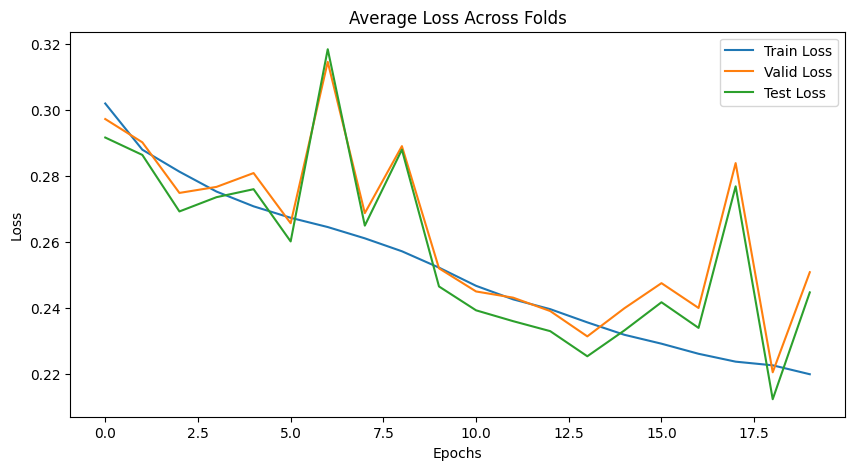

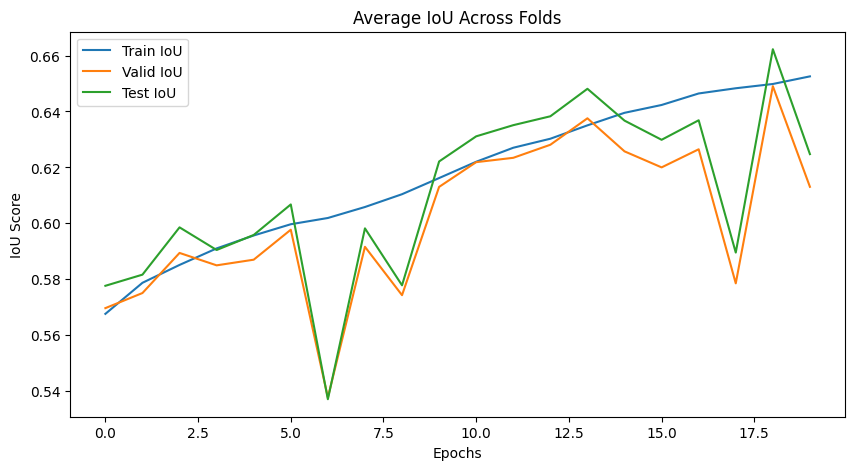

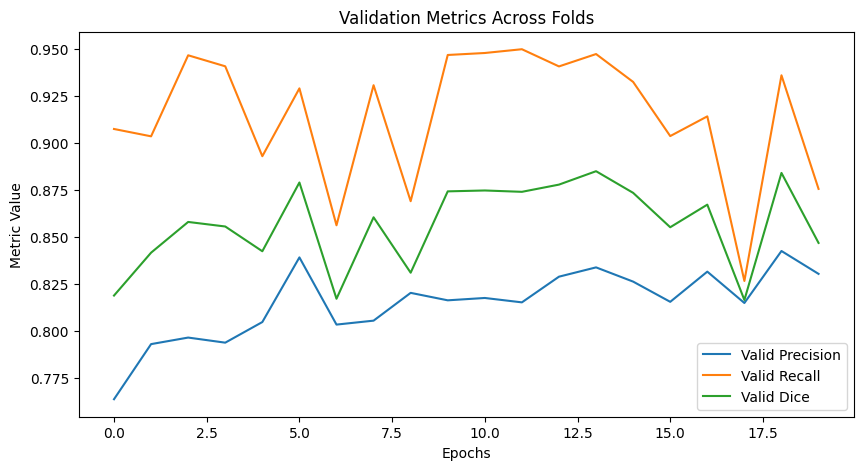

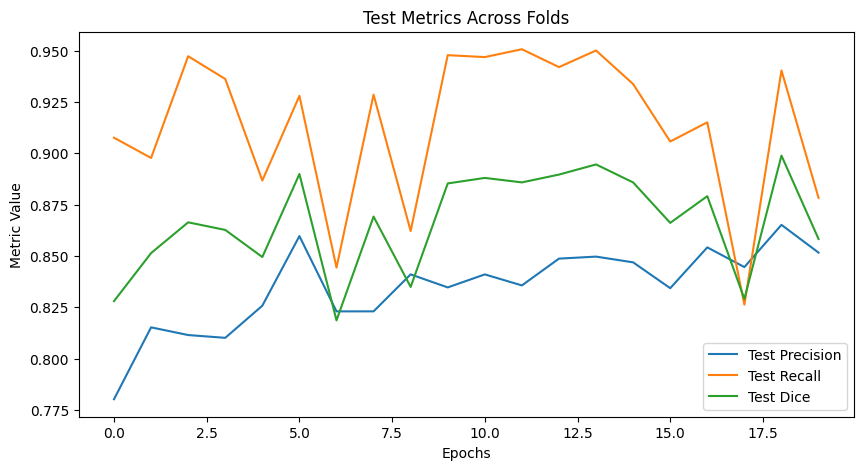

Metrics have been saved to 'Dataset1_model_Segnet.csv'


/tmp/ipykernel_10497/1280507250.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_fpath)
/tmp/ipykernel_10497/4161910213.py:342: UserW

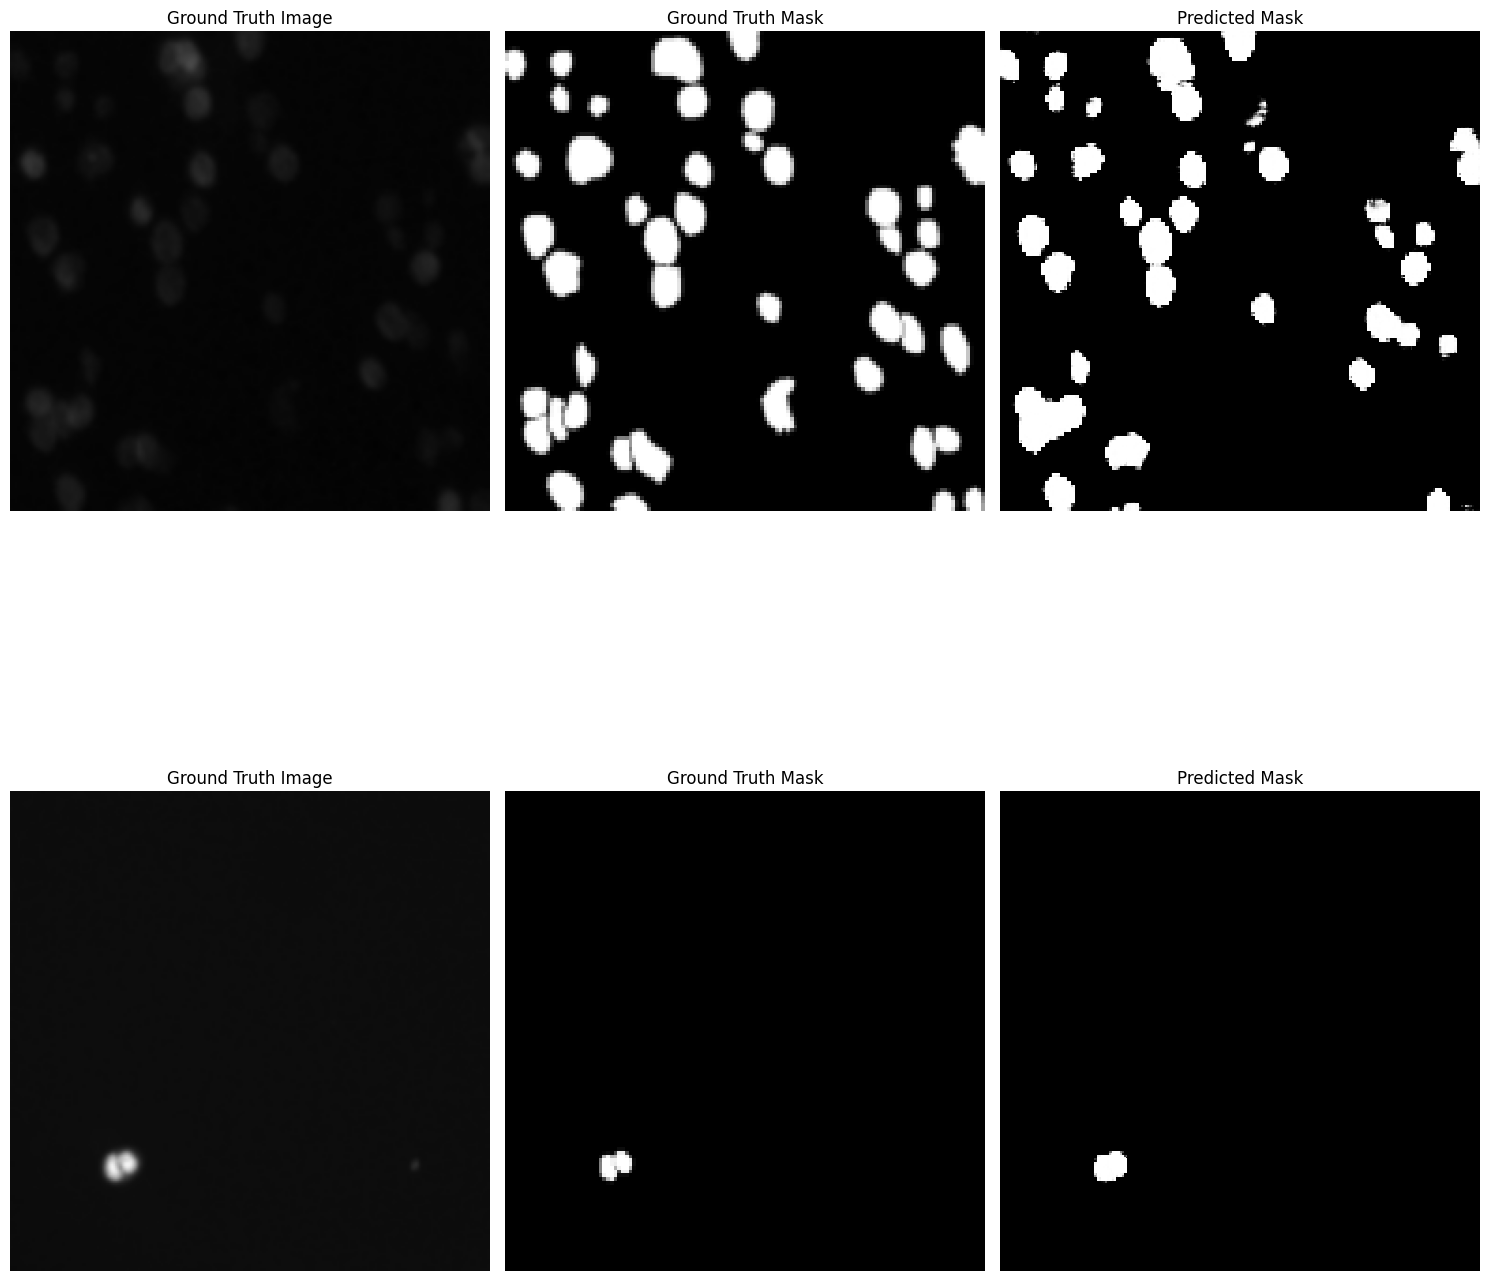

In [7]:
# Set up necessary directories and loss function
if not os.path.exists("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/SegNet"):
    os.makedirs("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/SegNet")

class double_conv(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channel),
            nn.Conv2d(out_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channel)
        )
    def forward(self, x):
        return self.conv(x)

class SegNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(SegNet, self).__init__()
        
        self.encoder = nn.ModuleList([
            double_conv(in_channel, 64),
            double_conv(64, 128),
            double_conv(128, 256),
            double_conv(256, 512),
            double_conv(512, 512)
        ])
        
        self.decoder = nn.ModuleList([
            double_conv(512, 512),
            double_conv(512, 256),
            double_conv(256, 128),
            double_conv(128, 64),
            double_conv(64, out_channel)
        ])
        
        self.pool = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, stride=2)
        
    def forward(self, x):
        indices_list = []
        size_list = []
        
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            size_list.append(x.size())
            x, indices = self.pool(x)
            indices_list.append(indices)
        
        for i, decoder_layer in enumerate(self.decoder):
            x = self.unpool(x, indices_list[-(i+1)], output_size=size_list[-(i+1)])
            x = decoder_layer(x)
        
        return torch.sigmoid(x)

# Initialize model and optimizer for each fold
model = SegNet(3,1)  # Assuming UNet is defined earlier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Parameters and Data
num_epochs = 20
k_folds = 7
checkpoint_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/SegNet/chkpoint_'
best_model_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/SegNet/bestmodel.pt'

# Initialize metrics
accuracy_metric = IoU()  # Assuming IoU is a metric you defined earlier
criterion = DiceLoss()  # Assuming DiceLoss is defined earlier
valid_loss_min = np.inf

# Store results
total_train_loss, total_train_score  = [], []
total_valid_loss, total_valid_score  = [], []
total_test_loss, total_test_score  = [], []

total_train_precision, total_valid_precision, total_test_precision = [], [], []
total_train_recall, total_valid_recall, total_test_recall = [], [], []
total_train_dice, total_valid_dice, total_test_dice = [], [], []

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 7-fold Cross Validation Loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"\n####### Fold {fold+1}/{k_folds} #######")

    # Create data subsets for current fold
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=16, shuffle=False)

    # Track losses and scores for each fold
    fold_train_loss, fold_train_score = [], []
    fold_valid_loss, fold_valid_score = [], []
    fold_test_loss, fold_test_score = [], []
    
    fold_train_precision, fold_valid_precision, fold_test_precision = [], [], []
    fold_train_recall, fold_valid_recall, fold_test_recall = [], [], []
    fold_train_dice, fold_valid_dice, fold_test_dice = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_score = [], []

        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for x_train, y_train in pbar:
            x_train = torch.autograd.Variable(x_train)
            y_train = torch.autograd.Variable(y_train)
            optimizer.zero_grad()
            output = model(x_train)

            # Compute Loss and Score
            loss = criterion(output, y_train)
            score = accuracy_metric(output, y_train)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_score.append(score.item())
            pbar.set_description(f"Epoch {epoch+1} - Loss: {loss.item():.4f}, IoU: {score:.4f}")

        fold_train_loss.append(np.mean(train_loss))
        fold_train_score.append(np.mean(train_score))

        # Validation Loop
        model.eval()
        valid_loss, valid_score= [], []

        valid_precision = []
        valid_recall = []
        valid_dice = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = torch.autograd.Variable(x_val)
                y_val = torch.autograd.Variable(y_val)
                output = model(x_val)

                # Compute Loss and Score
                loss = criterion(output, y_val)
                score = accuracy_metric(output, y_val)

                valid_loss.append(loss.item())
                valid_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_val_bin = (y_val > 0.5).float()

                valid_precision.append(precision_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_recall.append(recall_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_dice.append(f1_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_valid_loss.append(np.mean(valid_loss))
        fold_valid_score.append(np.mean(valid_score))
        
        fold_valid_precision.append(np.mean(valid_precision))
        fold_valid_recall.append(np.mean(valid_recall))
        fold_valid_dice.append(np.mean(valid_dice))

        # Test Loop
        test_loss = []
        test_score = []
        
        test_precision = []
        test_recall = []
        test_dice = []

        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test = torch.autograd.Variable(x_test)
                y_test = torch.autograd.Variable(y_test)
                output = model(x_test)

                # Compute Loss and Score
                loss = criterion(output, y_test)
                score = accuracy_metric(output, y_test)

                test_loss.append(loss.item())
                test_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_test_bin = (y_test > 0.5).float()

                test_precision.append(precision_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_recall.append(recall_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_dice.append(f1_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_test_loss.append(np.mean(test_loss))
        fold_test_score.append(np.mean(test_score))

        fold_test_precision.append(np.mean(test_precision))
        fold_test_recall.append(np.mean(test_recall))
        fold_test_dice.append(np.mean(test_dice))

        print(f"Fold {fold+1} - Epoch {epoch+1} - Train Loss: {np.mean(train_loss):.4f}, IoU: {np.mean(train_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Loss: {np.mean(valid_loss):.4f}, IoU: {np.mean(valid_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Loss: {np.mean(test_loss):.4f}, IoU: {np.mean(test_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Precision: {np.mean(valid_precision):.4f}, Recall: {np.mean(valid_recall):.4f}, Dice: {np.mean(valid_dice):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Precision: {np.mean(test_precision):.4f}, Recall: {np.mean(test_recall):.4f}, Dice: {np.mean(test_dice):.4f}")

        # Save checkpoint and best model
        checkpoint = {
            'epoch': epoch+1,
            'valid_loss_min': fold_valid_loss[-1],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        if fold_valid_loss[-1] <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {fold_valid_loss[-1]:.6f}). Saving model...')
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = fold_valid_loss[-1]

    # Append fold results
    total_train_loss.append(fold_train_loss)
    total_train_score.append(fold_train_score)
    total_valid_loss.append(fold_valid_loss)
    total_valid_score.append(fold_valid_score)
    total_test_loss.append(fold_test_loss)
    total_test_score.append(fold_test_score)

    total_train_precision.append(fold_train_precision)
    total_valid_precision.append(fold_valid_precision)
    total_test_precision.append(fold_test_precision)

    total_train_recall.append(fold_train_recall)
    total_valid_recall.append(fold_valid_recall)
    total_test_recall.append(fold_test_recall)

    total_train_dice.append(fold_train_dice)
    total_valid_dice.append(fold_valid_dice)
    total_test_dice.append(fold_test_dice)

# Calculate average results over all folds
avg_train_loss = np.mean(total_train_loss, axis=0)
avg_train_score = np.mean(total_train_score, axis=0)
avg_valid_loss = np.mean(total_valid_loss, axis=0)
avg_valid_score = np.mean(total_valid_score, axis=0)
avg_test_loss = np.mean(total_test_loss, axis=0)
avg_test_score = np.mean(total_test_score, axis=0)

avg_train_precision = np.mean(total_train_precision, axis=0)
avg_valid_precision = np.mean(total_valid_precision, axis=0)
avg_test_precision = np.mean(total_test_precision, axis=0)

avg_train_recall = np.mean(total_train_recall, axis=0)
avg_valid_recall = np.mean(total_valid_recall, axis=0)
avg_test_recall = np.mean(total_test_recall, axis=0)

avg_train_dice = np.mean(total_train_dice, axis=0)
avg_valid_dice = np.mean(total_valid_dice, axis=0)
avg_test_dice = np.mean(total_test_dice, axis=0)

# Plot final averaged results for losses and metrics
plt.figure(figsize=(10,5))
plt.plot(avg_train_loss, label="Train Loss")
plt.plot(avg_valid_loss, label="Valid Loss")
plt.plot(avg_test_loss, label="Test Loss")
plt.legend()
plt.title("Average Loss Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot IoU scores
plt.figure(figsize=(10,5))
plt.plot(avg_train_score, label="Train IoU")
plt.plot(avg_valid_score, label="Valid IoU")
plt.plot(avg_test_score, label="Test IoU")
plt.legend()
plt.title("Average IoU Across Folds")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.show()

# Plot Precision, Recall, and Dice scores for validation and test sets
plt.figure(figsize=(10,5))
plt.plot(avg_valid_precision, label="Valid Precision")
plt.plot(avg_valid_recall, label="Valid Recall")
plt.plot(avg_valid_dice, label="Valid Dice")
plt.legend()
plt.title("Validation Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(avg_test_precision, label="Test Precision")
plt.plot(avg_test_recall, label="Test Recall")
plt.plot(avg_test_dice, label="Test Dice")
plt.legend()
plt.title("Test Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

import pandas as pd

# Create a DataFrame to store results
columns = [
    'Fold', 'Epoch', 'Train_Loss', 'Train_IoU', 'Valid_Loss', 'Valid_IoU', 'Test_Loss', 'Test_IoU',
    'Valid_Precision', 'Valid_Recall', 'Valid_Dice', 'Test_Precision', 'Test_Recall', 'Test_Dice'
]

results = []

# Collect the results after all folds and epochs
for fold in range(k_folds):
    for epoch in range(num_epochs):
        results.append([
            fold + 1, epoch + 1,
            total_train_loss[fold][epoch], total_train_score[fold][epoch],
            total_valid_loss[fold][epoch], total_valid_score[fold][epoch],total_test_loss[fold][epoch], total_test_score[fold][epoch],
            total_valid_precision[fold][epoch], total_valid_recall[fold][epoch], total_valid_dice[fold][epoch],
            total_test_precision[fold][epoch], total_test_recall[fold][epoch], total_test_dice[fold][epoch]
        ])

# Convert results to a pandas DataFrame
df = pd.DataFrame(results, columns=columns)

# Save DataFrame to CSV
df.to_csv("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/SegNet/Dataset1_model_Segnet.csv", index=False)

print("Metrics have been saved to 'Dataset1_model_Segnet.csv'")

#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

def visualize_predict(model, n_images):
  #model = model.eval()
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in test_loader:
        data = torch.autograd.Variable(data, volatile=True)
        mask = torch.autograd.Variable(mask, volatile=True)
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Ground Truth Image")
    ax[img_no, 1].set_title("Ground Truth Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
  plt.tight_layout()
  plt.show()
  
visualize_predict(model, 2)

# WNet


####### Fold 1/7 #######


Epoch 1 - Loss: 0.4881, IoU: 0.3440: 100%|██████| 36/36 [07:39<00:00, 12.75s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 1 - Train Loss: 0.5646, IoU: 0.2829
Fold 1 - Epoch 1 - Valid Loss: 0.7472, IoU: 0.1453
Fold 1 - Epoch 1 - Test Loss: 0.7984, IoU: 0.1131
Fold 1 - Epoch 1 - Valid Precision: 0.7872, Recall: 0.1293, Dice: 0.2154
Fold 1 - Epoch 1 - Test Precision: 0.7937, Recall: 0.0899, Dice: 0.1451
Validation loss decreased (inf --> 0.747197). Saving model...


Epoch 2 - Loss: 0.3704, IoU: 0.4594: 100%|██████| 36/36 [07:37<00:00, 12.70s/it]


Fold 1 - Epoch 2 - Train Loss: 0.4397, IoU: 0.3931
Fold 1 - Epoch 2 - Valid Loss: 0.3727, IoU: 0.4574
Fold 1 - Epoch 2 - Test Loss: 0.4118, IoU: 0.4220
Fold 1 - Epoch 2 - Valid Precision: 0.6281, Recall: 0.9744, Dice: 0.7636
Fold 1 - Epoch 2 - Test Precision: 0.6106, Recall: 0.9693, Dice: 0.7465
Validation loss decreased (0.747197 --> 0.372690). Saving model...


Epoch 3 - Loss: 0.3079, IoU: 0.5292: 100%|██████| 36/36 [07:41<00:00, 12.81s/it]


Fold 1 - Epoch 3 - Train Loss: 0.3575, IoU: 0.4760
Fold 1 - Epoch 3 - Valid Loss: 0.2927, IoU: 0.5479
Fold 1 - Epoch 3 - Test Loss: 0.3400, IoU: 0.4988
Fold 1 - Epoch 3 - Valid Precision: 0.7508, Recall: 0.9168, Dice: 0.8247
Fold 1 - Epoch 3 - Test Precision: 0.7258, Recall: 0.9202, Dice: 0.8077
Validation loss decreased (0.372690 --> 0.292686). Saving model...


Epoch 4 - Loss: 0.2398, IoU: 0.6132: 100%|██████| 36/36 [07:38<00:00, 12.73s/it]


Fold 1 - Epoch 4 - Train Loss: 0.3047, IoU: 0.5368
Fold 1 - Epoch 4 - Valid Loss: 0.2451, IoU: 0.6070
Fold 1 - Epoch 4 - Test Loss: 0.2832, IoU: 0.5625
Fold 1 - Epoch 4 - Valid Precision: 0.7888, Recall: 0.8908, Dice: 0.8357
Fold 1 - Epoch 4 - Test Precision: 0.7973, Recall: 0.8587, Dice: 0.8241
Validation loss decreased (0.292686 --> 0.245150). Saving model...


Epoch 5 - Loss: 0.2455, IoU: 0.6057: 100%|██████| 36/36 [07:37<00:00, 12.71s/it]


Fold 1 - Epoch 5 - Train Loss: 0.2578, IoU: 0.5935
Fold 1 - Epoch 5 - Valid Loss: 0.2421, IoU: 0.6114
Fold 1 - Epoch 5 - Test Loss: 0.2902, IoU: 0.5624
Fold 1 - Epoch 5 - Valid Precision: 0.7982, Recall: 0.8349, Dice: 0.8142
Fold 1 - Epoch 5 - Test Precision: 0.7392, Recall: 0.8475, Dice: 0.7713
Validation loss decreased (0.245150 --> 0.242131). Saving model...


Epoch 6 - Loss: 0.2052, IoU: 0.6594: 100%|██████| 36/36 [07:34<00:00, 12.63s/it]


Fold 1 - Epoch 6 - Train Loss: 0.2164, IoU: 0.6464
Fold 1 - Epoch 6 - Valid Loss: 0.2138, IoU: 0.6479
Fold 1 - Epoch 6 - Test Loss: 0.2203, IoU: 0.6415
Fold 1 - Epoch 6 - Valid Precision: 0.7690, Recall: 0.8886, Dice: 0.8227
Fold 1 - Epoch 6 - Test Precision: 0.7477, Recall: 0.9313, Dice: 0.8275
Validation loss decreased (0.242131 --> 0.213813). Saving model...


Epoch 7 - Loss: 0.2624, IoU: 0.5842: 100%|██████| 36/36 [07:22<00:00, 12.30s/it]


Fold 1 - Epoch 7 - Train Loss: 0.2113, IoU: 0.6530
Fold 1 - Epoch 7 - Valid Loss: 0.4072, IoU: 0.4258
Fold 1 - Epoch 7 - Test Loss: 0.4369, IoU: 0.3977
Fold 1 - Epoch 7 - Valid Precision: 0.7618, Recall: 0.5364, Dice: 0.6239
Fold 1 - Epoch 7 - Test Precision: 0.7103, Recall: 0.5607, Dice: 0.5951


Epoch 8 - Loss: 0.1954, IoU: 0.6731: 100%|██████| 36/36 [07:23<00:00, 12.32s/it]


Fold 1 - Epoch 8 - Train Loss: 0.2226, IoU: 0.6377
Fold 1 - Epoch 8 - Valid Loss: 0.2722, IoU: 0.5751
Fold 1 - Epoch 8 - Test Loss: 0.2603, IoU: 0.5931
Fold 1 - Epoch 8 - Valid Precision: 0.7730, Recall: 0.7531, Dice: 0.7584
Fold 1 - Epoch 8 - Test Precision: 0.7929, Recall: 0.7874, Dice: 0.7840


Epoch 9 - Loss: 0.2078, IoU: 0.6560: 100%|██████| 36/36 [07:31<00:00, 12.53s/it]


Fold 1 - Epoch 9 - Train Loss: 0.2040, IoU: 0.6629
Fold 1 - Epoch 9 - Valid Loss: 0.2580, IoU: 0.5918
Fold 1 - Epoch 9 - Test Loss: 0.2182, IoU: 0.6439
Fold 1 - Epoch 9 - Valid Precision: 0.8211, Recall: 0.7195, Dice: 0.7646
Fold 1 - Epoch 9 - Test Precision: 0.8222, Recall: 0.8092, Dice: 0.8115


Epoch 10 - Loss: 0.2000, IoU: 0.6666: 100%|█████| 36/36 [07:31<00:00, 12.55s/it]


Fold 1 - Epoch 10 - Train Loss: 0.1715, IoU: 0.7081
Fold 1 - Epoch 10 - Valid Loss: 0.1726, IoU: 0.7063
Fold 1 - Epoch 10 - Test Loss: 0.1744, IoU: 0.7047
Fold 1 - Epoch 10 - Valid Precision: 0.8566, Recall: 0.8543, Dice: 0.8549
Fold 1 - Epoch 10 - Test Precision: 0.8595, Recall: 0.8685, Dice: 0.8616
Validation loss decreased (0.213813 --> 0.172590). Saving model...


Epoch 11 - Loss: 0.1578, IoU: 0.7274: 100%|█████| 36/36 [07:50<00:00, 13.08s/it]


Fold 1 - Epoch 11 - Train Loss: 0.1616, IoU: 0.7229
Fold 1 - Epoch 11 - Valid Loss: 0.1525, IoU: 0.7362
Fold 1 - Epoch 11 - Test Loss: 0.1597, IoU: 0.7261
Fold 1 - Epoch 11 - Valid Precision: 0.8292, Recall: 0.9141, Dice: 0.8689
Fold 1 - Epoch 11 - Test Precision: 0.8271, Recall: 0.9181, Dice: 0.8695
Validation loss decreased (0.172590 --> 0.152451). Saving model...


Epoch 12 - Loss: 0.1478, IoU: 0.7425: 100%|█████| 36/36 [07:58<00:00, 13.29s/it]


Fold 1 - Epoch 12 - Train Loss: 0.1620, IoU: 0.7227
Fold 1 - Epoch 12 - Valid Loss: 0.1459, IoU: 0.7460
Fold 1 - Epoch 12 - Test Loss: 0.1525, IoU: 0.7367
Fold 1 - Epoch 12 - Valid Precision: 0.8484, Recall: 0.9071, Dice: 0.8765
Fold 1 - Epoch 12 - Test Precision: 0.8456, Recall: 0.9129, Dice: 0.8769
Validation loss decreased (0.152451 --> 0.145903). Saving model...


Epoch 13 - Loss: 0.1479, IoU: 0.7423: 100%|█████| 36/36 [07:54<00:00, 13.17s/it]


Fold 1 - Epoch 13 - Train Loss: 0.1497, IoU: 0.7406
Fold 1 - Epoch 13 - Valid Loss: 0.1371, IoU: 0.7593
Fold 1 - Epoch 13 - Test Loss: 0.1425, IoU: 0.7516
Fold 1 - Epoch 13 - Valid Precision: 0.8493, Recall: 0.9215, Dice: 0.8836
Fold 1 - Epoch 13 - Test Precision: 0.8476, Recall: 0.9285, Dice: 0.8854
Validation loss decreased (0.145903 --> 0.137144). Saving model...


Epoch 14 - Loss: 0.1599, IoU: 0.7243: 100%|█████| 36/36 [07:36<00:00, 12.68s/it]


Fold 1 - Epoch 14 - Train Loss: 0.1440, IoU: 0.7489
Fold 1 - Epoch 14 - Valid Loss: 0.1387, IoU: 0.7573
Fold 1 - Epoch 14 - Test Loss: 0.1430, IoU: 0.7506
Fold 1 - Epoch 14 - Valid Precision: 0.8913, Recall: 0.8766, Dice: 0.8835
Fold 1 - Epoch 14 - Test Precision: 0.8824, Recall: 0.8903, Dice: 0.8856


Epoch 15 - Loss: 0.1546, IoU: 0.7322: 100%|█████| 36/36 [07:24<00:00, 12.34s/it]


Fold 1 - Epoch 15 - Train Loss: 0.1494, IoU: 0.7411
Fold 1 - Epoch 15 - Valid Loss: 0.3805, IoU: 0.4526
Fold 1 - Epoch 15 - Test Loss: 0.3513, IoU: 0.4872
Fold 1 - Epoch 15 - Valid Precision: 0.8458, Recall: 0.5189, Dice: 0.6363
Fold 1 - Epoch 15 - Test Precision: 0.8477, Recall: 0.5771, Dice: 0.6706


Epoch 16 - Loss: 0.1106, IoU: 0.8008: 100%|█████| 36/36 [07:26<00:00, 12.41s/it]


Fold 1 - Epoch 16 - Train Loss: 0.1475, IoU: 0.7439
Fold 1 - Epoch 16 - Valid Loss: 0.1421, IoU: 0.7518
Fold 1 - Epoch 16 - Test Loss: 0.1447, IoU: 0.7484
Fold 1 - Epoch 16 - Valid Precision: 0.8463, Recall: 0.9073, Dice: 0.8754
Fold 1 - Epoch 16 - Test Precision: 0.8479, Recall: 0.9142, Dice: 0.8787


Epoch 17 - Loss: 0.1730, IoU: 0.7051: 100%|█████| 36/36 [07:26<00:00, 12.40s/it]


Fold 1 - Epoch 17 - Train Loss: 0.1462, IoU: 0.7459
Fold 1 - Epoch 17 - Valid Loss: 0.1353, IoU: 0.7622
Fold 1 - Epoch 17 - Test Loss: 0.1438, IoU: 0.7497
Fold 1 - Epoch 17 - Valid Precision: 0.8440, Recall: 0.9204, Dice: 0.8804
Fold 1 - Epoch 17 - Test Precision: 0.8306, Recall: 0.9294, Dice: 0.8761
Validation loss decreased (0.137144 --> 0.135332). Saving model...


Epoch 18 - Loss: 0.1806, IoU: 0.6941: 100%|█████| 36/36 [07:25<00:00, 12.39s/it]


Fold 1 - Epoch 18 - Train Loss: 0.1503, IoU: 0.7395
Fold 1 - Epoch 18 - Valid Loss: 0.2375, IoU: 0.6173
Fold 1 - Epoch 18 - Test Loss: 0.2787, IoU: 0.5667
Fold 1 - Epoch 18 - Valid Precision: 0.8463, Recall: 0.7204, Dice: 0.7772
Fold 1 - Epoch 18 - Test Precision: 0.8302, Recall: 0.6795, Dice: 0.7394


Epoch 19 - Loss: 0.1764, IoU: 0.7001: 100%|█████| 36/36 [07:27<00:00, 12.44s/it]


Fold 1 - Epoch 19 - Train Loss: 0.1443, IoU: 0.7488
Fold 1 - Epoch 19 - Valid Loss: 0.1320, IoU: 0.7674
Fold 1 - Epoch 19 - Test Loss: 0.1324, IoU: 0.7666
Fold 1 - Epoch 19 - Valid Precision: 0.8530, Recall: 0.9182, Dice: 0.8842
Fold 1 - Epoch 19 - Test Precision: 0.8517, Recall: 0.9311, Dice: 0.8891
Validation loss decreased (0.135332 --> 0.132002). Saving model...


Epoch 20 - Loss: 0.1516, IoU: 0.7367: 100%|█████| 36/36 [07:38<00:00, 12.74s/it]


Fold 1 - Epoch 20 - Train Loss: 0.1394, IoU: 0.7562
Fold 1 - Epoch 20 - Valid Loss: 0.1363, IoU: 0.7607
Fold 1 - Epoch 20 - Test Loss: 0.1378, IoU: 0.7585
Fold 1 - Epoch 20 - Valid Precision: 0.8600, Recall: 0.8990, Dice: 0.8788
Fold 1 - Epoch 20 - Test Precision: 0.8589, Recall: 0.9097, Dice: 0.8831

####### Fold 2/7 #######


Epoch 1 - Loss: 0.1356, IoU: 0.7612: 100%|██████| 36/36 [07:20<00:00, 12.24s/it]


Fold 2 - Epoch 1 - Train Loss: 0.1415, IoU: 0.7532
Fold 2 - Epoch 1 - Valid Loss: 0.1245, IoU: 0.7790
Fold 2 - Epoch 1 - Test Loss: 0.1325, IoU: 0.7667
Fold 2 - Epoch 1 - Valid Precision: 0.8498, Recall: 0.9433, Dice: 0.8939
Fold 2 - Epoch 1 - Test Precision: 0.8584, Recall: 0.9244, Dice: 0.8892
Validation loss decreased (0.132002 --> 0.124465). Saving model...


Epoch 2 - Loss: 0.1516, IoU: 0.7367: 100%|██████| 36/36 [07:22<00:00, 12.28s/it]


Fold 2 - Epoch 2 - Train Loss: 0.1384, IoU: 0.7576
Fold 2 - Epoch 2 - Valid Loss: 0.1170, IoU: 0.7906
Fold 2 - Epoch 2 - Test Loss: 0.1300, IoU: 0.7704
Fold 2 - Epoch 2 - Valid Precision: 0.8898, Recall: 0.9234, Dice: 0.9061
Fold 2 - Epoch 2 - Test Precision: 0.8939, Recall: 0.9007, Dice: 0.8966
Validation loss decreased (0.124465 --> 0.117048). Saving model...


Epoch 3 - Loss: 0.1388, IoU: 0.7562: 100%|██████| 36/36 [07:22<00:00, 12.29s/it]


Fold 2 - Epoch 3 - Train Loss: 0.1348, IoU: 0.7631
Fold 2 - Epoch 3 - Valid Loss: 0.1178, IoU: 0.7896
Fold 2 - Epoch 3 - Test Loss: 0.1287, IoU: 0.7726
Fold 2 - Epoch 3 - Valid Precision: 0.8650, Recall: 0.9449, Dice: 0.9029
Fold 2 - Epoch 3 - Test Precision: 0.8709, Recall: 0.9229, Dice: 0.8952


Epoch 4 - Loss: 0.1781, IoU: 0.6977: 100%|██████| 36/36 [07:32<00:00, 12.56s/it]


Fold 2 - Epoch 4 - Train Loss: 0.1326, IoU: 0.7664
Fold 2 - Epoch 4 - Valid Loss: 0.1169, IoU: 0.7910
Fold 2 - Epoch 4 - Test Loss: 0.1258, IoU: 0.7770
Fold 2 - Epoch 4 - Valid Precision: 0.8651, Recall: 0.9468, Dice: 0.9039
Fold 2 - Epoch 4 - Test Precision: 0.8740, Recall: 0.9261, Dice: 0.8984
Validation loss decreased (0.117048 --> 0.116906). Saving model...


Epoch 5 - Loss: 0.1040, IoU: 0.8115: 100%|██████| 36/36 [07:24<00:00, 12.35s/it]


Fold 2 - Epoch 5 - Train Loss: 0.1323, IoU: 0.7669
Fold 2 - Epoch 5 - Valid Loss: 0.1151, IoU: 0.7938
Fold 2 - Epoch 5 - Test Loss: 0.1259, IoU: 0.7770
Fold 2 - Epoch 5 - Valid Precision: 0.8971, Recall: 0.9200, Dice: 0.9083
Fold 2 - Epoch 5 - Test Precision: 0.8972, Recall: 0.9055, Dice: 0.9009
Validation loss decreased (0.116906 --> 0.115108). Saving model...


Epoch 6 - Loss: 0.1129, IoU: 0.7971: 100%|██████| 36/36 [07:30<00:00, 12.51s/it]


Fold 2 - Epoch 6 - Train Loss: 0.1363, IoU: 0.7607
Fold 2 - Epoch 6 - Valid Loss: 0.1202, IoU: 0.7858
Fold 2 - Epoch 6 - Test Loss: 0.1336, IoU: 0.7651
Fold 2 - Epoch 6 - Valid Precision: 0.8557, Recall: 0.9413, Dice: 0.8963
Fold 2 - Epoch 6 - Test Precision: 0.8485, Recall: 0.9260, Dice: 0.8848


Epoch 7 - Loss: 0.1689, IoU: 0.7110: 100%|██████| 36/36 [07:46<00:00, 12.95s/it]


Fold 2 - Epoch 7 - Train Loss: 0.1327, IoU: 0.7663
Fold 2 - Epoch 7 - Valid Loss: 0.1178, IoU: 0.7895
Fold 2 - Epoch 7 - Test Loss: 0.1255, IoU: 0.7776
Fold 2 - Epoch 7 - Valid Precision: 0.8495, Recall: 0.9546, Dice: 0.8988
Fold 2 - Epoch 7 - Test Precision: 0.8537, Recall: 0.9390, Dice: 0.8938


Epoch 8 - Loss: 0.1305, IoU: 0.7692: 100%|██████| 36/36 [07:32<00:00, 12.58s/it]


Fold 2 - Epoch 8 - Train Loss: 0.1313, IoU: 0.7685
Fold 2 - Epoch 8 - Valid Loss: 0.1453, IoU: 0.7465
Fold 2 - Epoch 8 - Test Loss: 0.1591, IoU: 0.7257
Fold 2 - Epoch 8 - Valid Precision: 0.9209, Recall: 0.8431, Dice: 0.8799
Fold 2 - Epoch 8 - Test Precision: 0.9212, Recall: 0.8231, Dice: 0.8688


Epoch 9 - Loss: 0.1103, IoU: 0.8013: 100%|██████| 36/36 [07:23<00:00, 12.32s/it]


Fold 2 - Epoch 9 - Train Loss: 0.1304, IoU: 0.7699
Fold 2 - Epoch 9 - Valid Loss: 0.1147, IoU: 0.7945
Fold 2 - Epoch 9 - Test Loss: 0.1249, IoU: 0.7785
Fold 2 - Epoch 9 - Valid Precision: 0.8992, Recall: 0.9177, Dice: 0.9083
Fold 2 - Epoch 9 - Test Precision: 0.9014, Recall: 0.9022, Dice: 0.9013
Validation loss decreased (0.115108 --> 0.114662). Saving model...


Epoch 10 - Loss: 0.1233, IoU: 0.7804: 100%|█████| 36/36 [07:23<00:00, 12.32s/it]


Fold 2 - Epoch 10 - Train Loss: 0.1313, IoU: 0.7685
Fold 2 - Epoch 10 - Valid Loss: 0.1104, IoU: 0.8015
Fold 2 - Epoch 10 - Test Loss: 0.1212, IoU: 0.7843
Fold 2 - Epoch 10 - Valid Precision: 0.8875, Recall: 0.9386, Dice: 0.9122
Fold 2 - Epoch 10 - Test Precision: 0.8866, Recall: 0.9232, Dice: 0.9040
Validation loss decreased (0.114662 --> 0.110376). Saving model...


Epoch 11 - Loss: 0.1607, IoU: 0.7231: 100%|█████| 36/36 [07:20<00:00, 12.24s/it]


Fold 2 - Epoch 11 - Train Loss: 0.1272, IoU: 0.7755
Fold 2 - Epoch 11 - Valid Loss: 0.1118, IoU: 0.7991
Fold 2 - Epoch 11 - Test Loss: 0.1220, IoU: 0.7832
Fold 2 - Epoch 11 - Valid Precision: 0.8990, Recall: 0.9254, Dice: 0.9118
Fold 2 - Epoch 11 - Test Precision: 0.9054, Recall: 0.9058, Dice: 0.9051


Epoch 12 - Loss: 0.1503, IoU: 0.7387: 100%|█████| 36/36 [07:31<00:00, 12.53s/it]


Fold 2 - Epoch 12 - Train Loss: 0.1272, IoU: 0.7750
Fold 2 - Epoch 12 - Valid Loss: 0.1111, IoU: 0.8002
Fold 2 - Epoch 12 - Test Loss: 0.1184, IoU: 0.7888
Fold 2 - Epoch 12 - Valid Precision: 0.8768, Recall: 0.9444, Dice: 0.9093
Fold 2 - Epoch 12 - Test Precision: 0.8815, Recall: 0.9311, Dice: 0.9053


Epoch 13 - Loss: 0.1297, IoU: 0.7704: 100%|█████| 36/36 [07:42<00:00, 12.85s/it]


Fold 2 - Epoch 13 - Train Loss: 0.1255, IoU: 0.7774
Fold 2 - Epoch 13 - Valid Loss: 0.1136, IoU: 0.7961
Fold 2 - Epoch 13 - Test Loss: 0.1241, IoU: 0.7795
Fold 2 - Epoch 13 - Valid Precision: 0.9022, Recall: 0.9200, Dice: 0.9108
Fold 2 - Epoch 13 - Test Precision: 0.9072, Recall: 0.9017, Dice: 0.9038


Epoch 14 - Loss: 0.1469, IoU: 0.7438: 100%|█████| 36/36 [07:40<00:00, 12.78s/it]


Fold 2 - Epoch 14 - Train Loss: 0.1233, IoU: 0.7810
Fold 2 - Epoch 14 - Valid Loss: 0.1086, IoU: 0.8044
Fold 2 - Epoch 14 - Test Loss: 0.1212, IoU: 0.7845
Fold 2 - Epoch 14 - Valid Precision: 0.9054, Recall: 0.9273, Dice: 0.9161
Fold 2 - Epoch 14 - Test Precision: 0.9100, Recall: 0.9041, Dice: 0.9067
Validation loss decreased (0.110376 --> 0.108551). Saving model...


Epoch 15 - Loss: 0.1430, IoU: 0.7497: 100%|█████| 36/36 [07:41<00:00, 12.82s/it]


Fold 2 - Epoch 15 - Train Loss: 0.1261, IoU: 0.7766
Fold 2 - Epoch 15 - Valid Loss: 0.1123, IoU: 0.7983
Fold 2 - Epoch 15 - Test Loss: 0.1231, IoU: 0.7813
Fold 2 - Epoch 15 - Valid Precision: 0.8969, Recall: 0.9298, Dice: 0.9129
Fold 2 - Epoch 15 - Test Precision: 0.9091, Recall: 0.9048, Dice: 0.9064


Epoch 16 - Loss: 0.1371, IoU: 0.7588: 100%|█████| 36/36 [07:25<00:00, 12.37s/it]


Fold 2 - Epoch 16 - Train Loss: 0.1265, IoU: 0.7757
Fold 2 - Epoch 16 - Valid Loss: 0.1095, IoU: 0.8028
Fold 2 - Epoch 16 - Test Loss: 0.1202, IoU: 0.7859
Fold 2 - Epoch 16 - Valid Precision: 0.8858, Recall: 0.9452, Dice: 0.9144
Fold 2 - Epoch 16 - Test Precision: 0.8948, Recall: 0.9223, Dice: 0.9075


Epoch 17 - Loss: 0.1168, IoU: 0.7908: 100%|█████| 36/36 [07:25<00:00, 12.37s/it]


Fold 2 - Epoch 17 - Train Loss: 0.1239, IoU: 0.7802
Fold 2 - Epoch 17 - Valid Loss: 0.1094, IoU: 0.8031
Fold 2 - Epoch 17 - Test Loss: 0.1180, IoU: 0.7895
Fold 2 - Epoch 17 - Valid Precision: 0.8882, Recall: 0.9406, Dice: 0.9135
Fold 2 - Epoch 17 - Test Precision: 0.8913, Recall: 0.9262, Dice: 0.9078


Epoch 18 - Loss: 0.1159, IoU: 0.7923: 100%|█████| 36/36 [07:27<00:00, 12.43s/it]


Fold 2 - Epoch 18 - Train Loss: 0.1261, IoU: 0.7766
Fold 2 - Epoch 18 - Valid Loss: 0.1109, IoU: 0.8006
Fold 2 - Epoch 18 - Test Loss: 0.1226, IoU: 0.7821
Fold 2 - Epoch 18 - Valid Precision: 0.9008, Recall: 0.9231, Dice: 0.9117
Fold 2 - Epoch 18 - Test Precision: 0.8948, Recall: 0.9119, Dice: 0.9024


Epoch 19 - Loss: 0.1328, IoU: 0.7655: 100%|█████| 36/36 [07:32<00:00, 12.56s/it]


Fold 2 - Epoch 19 - Train Loss: 0.1226, IoU: 0.7821
Fold 2 - Epoch 19 - Valid Loss: 0.1086, IoU: 0.8044
Fold 2 - Epoch 19 - Test Loss: 0.1169, IoU: 0.7913
Fold 2 - Epoch 19 - Valid Precision: 0.8857, Recall: 0.9459, Dice: 0.9146
Fold 2 - Epoch 19 - Test Precision: 0.8894, Recall: 0.9313, Dice: 0.9092


Epoch 20 - Loss: 0.1690, IoU: 0.7109: 100%|█████| 36/36 [07:35<00:00, 12.66s/it]


Fold 2 - Epoch 20 - Train Loss: 0.1208, IoU: 0.7850
Fold 2 - Epoch 20 - Valid Loss: 0.1046, IoU: 0.8107
Fold 2 - Epoch 20 - Test Loss: 0.1177, IoU: 0.7898
Fold 2 - Epoch 20 - Valid Precision: 0.9055, Recall: 0.9384, Dice: 0.9215
Fold 2 - Epoch 20 - Test Precision: 0.9015, Recall: 0.9223, Dice: 0.9111
Validation loss decreased (0.108551 --> 0.104618). Saving model...

####### Fold 3/7 #######


Epoch 1 - Loss: 0.1218, IoU: 0.7828: 100%|██████| 36/36 [07:37<00:00, 12.70s/it]


Fold 3 - Epoch 1 - Train Loss: 0.1220, IoU: 0.7831
Fold 3 - Epoch 1 - Valid Loss: 0.1324, IoU: 0.7673
Fold 3 - Epoch 1 - Test Loss: 0.1267, IoU: 0.7754
Fold 3 - Epoch 1 - Valid Precision: 0.8452, Recall: 0.9323, Dice: 0.8857
Fold 3 - Epoch 1 - Test Precision: 0.8674, Recall: 0.9224, Dice: 0.8934


Epoch 2 - Loss: 0.1100, IoU: 0.8018: 100%|██████| 36/36 [07:46<00:00, 12.97s/it]


Fold 3 - Epoch 2 - Train Loss: 0.1228, IoU: 0.7817
Fold 3 - Epoch 2 - Valid Loss: 0.1559, IoU: 0.7310
Fold 3 - Epoch 2 - Test Loss: 0.1358, IoU: 0.7611
Fold 3 - Epoch 2 - Valid Precision: 0.8594, Recall: 0.8742, Dice: 0.8646
Fold 3 - Epoch 2 - Test Precision: 0.8891, Recall: 0.8896, Dice: 0.8878


Epoch 3 - Loss: 0.1236, IoU: 0.7800: 100%|██████| 36/36 [07:24<00:00, 12.35s/it]


Fold 3 - Epoch 3 - Train Loss: 0.1182, IoU: 0.7890
Fold 3 - Epoch 3 - Valid Loss: 0.1186, IoU: 0.7889
Fold 3 - Epoch 3 - Test Loss: 0.1121, IoU: 0.7988
Fold 3 - Epoch 3 - Valid Precision: 0.8723, Recall: 0.9434, Dice: 0.9058
Fold 3 - Epoch 3 - Test Precision: 0.8994, Recall: 0.9325, Dice: 0.9153


Epoch 4 - Loss: 0.1158, IoU: 0.7924: 100%|██████| 36/36 [07:29<00:00, 12.48s/it]


Fold 3 - Epoch 4 - Train Loss: 0.1161, IoU: 0.7924
Fold 3 - Epoch 4 - Valid Loss: 0.1209, IoU: 0.7853
Fold 3 - Epoch 4 - Test Loss: 0.1135, IoU: 0.7966
Fold 3 - Epoch 4 - Valid Precision: 0.8592, Recall: 0.9524, Dice: 0.9025
Fold 3 - Epoch 4 - Test Precision: 0.8888, Recall: 0.9393, Dice: 0.9127


Epoch 5 - Loss: 0.1091, IoU: 0.8032: 100%|██████| 36/36 [07:32<00:00, 12.56s/it]


Fold 3 - Epoch 5 - Train Loss: 0.1178, IoU: 0.7898
Fold 3 - Epoch 5 - Valid Loss: 0.1209, IoU: 0.7851
Fold 3 - Epoch 5 - Test Loss: 0.1174, IoU: 0.7905
Fold 3 - Epoch 5 - Valid Precision: 0.8712, Recall: 0.9368, Dice: 0.9018
Fold 3 - Epoch 5 - Test Precision: 0.8960, Recall: 0.9204, Dice: 0.9076


Epoch 6 - Loss: 0.1317, IoU: 0.7672: 100%|██████| 36/36 [07:37<00:00, 12.71s/it]


Fold 3 - Epoch 6 - Train Loss: 0.1158, IoU: 0.7929
Fold 3 - Epoch 6 - Valid Loss: 0.1220, IoU: 0.7835
Fold 3 - Epoch 6 - Test Loss: 0.1149, IoU: 0.7944
Fold 3 - Epoch 6 - Valid Precision: 0.8927, Recall: 0.9204, Dice: 0.9057
Fold 3 - Epoch 6 - Test Precision: 0.9192, Recall: 0.9144, Dice: 0.9164


Epoch 7 - Loss: 0.0973, IoU: 0.8226: 100%|██████| 36/36 [07:38<00:00, 12.75s/it]


Fold 3 - Epoch 7 - Train Loss: 0.1158, IoU: 0.7930
Fold 3 - Epoch 7 - Valid Loss: 0.1185, IoU: 0.7890
Fold 3 - Epoch 7 - Test Loss: 0.1151, IoU: 0.7942
Fold 3 - Epoch 7 - Valid Precision: 0.8813, Recall: 0.9373, Dice: 0.9076
Fold 3 - Epoch 7 - Test Precision: 0.9050, Recall: 0.9244, Dice: 0.9140


Epoch 8 - Loss: 0.0969, IoU: 0.8234: 100%|██████| 36/36 [07:41<00:00, 12.83s/it]


Fold 3 - Epoch 8 - Train Loss: 0.1166, IoU: 0.7916
Fold 3 - Epoch 8 - Valid Loss: 0.1233, IoU: 0.7815
Fold 3 - Epoch 8 - Test Loss: 0.1165, IoU: 0.7917
Fold 3 - Epoch 8 - Valid Precision: 0.8727, Recall: 0.9342, Dice: 0.9015
Fold 3 - Epoch 8 - Test Precision: 0.8974, Recall: 0.9267, Dice: 0.9111


Epoch 9 - Loss: 0.1107, IoU: 0.8006: 100%|██████| 36/36 [07:45<00:00, 12.94s/it]


Fold 3 - Epoch 9 - Train Loss: 0.1164, IoU: 0.7920
Fold 3 - Epoch 9 - Valid Loss: 0.1235, IoU: 0.7810
Fold 3 - Epoch 9 - Test Loss: 0.1187, IoU: 0.7882
Fold 3 - Epoch 9 - Valid Precision: 0.9051, Recall: 0.9078, Dice: 0.9057
Fold 3 - Epoch 9 - Test Precision: 0.9342, Recall: 0.8966, Dice: 0.9145


Epoch 10 - Loss: 0.1078, IoU: 0.8053: 100%|█████| 36/36 [07:25<00:00, 12.36s/it]


Fold 3 - Epoch 10 - Train Loss: 0.1151, IoU: 0.7939
Fold 3 - Epoch 10 - Valid Loss: 0.1197, IoU: 0.7871
Fold 3 - Epoch 10 - Test Loss: 0.1157, IoU: 0.7931
Fold 3 - Epoch 10 - Valid Precision: 0.8712, Recall: 0.9390, Dice: 0.9030
Fold 3 - Epoch 10 - Test Precision: 0.8923, Recall: 0.9273, Dice: 0.9091


Epoch 11 - Loss: 0.1201, IoU: 0.7856: 100%|█████| 36/36 [07:22<00:00, 12.30s/it]


Fold 3 - Epoch 11 - Train Loss: 0.1169, IoU: 0.7912
Fold 3 - Epoch 11 - Valid Loss: 0.1275, IoU: 0.7748
Fold 3 - Epoch 11 - Test Loss: 0.1189, IoU: 0.7877
Fold 3 - Epoch 11 - Valid Precision: 0.8597, Recall: 0.9328, Dice: 0.8939
Fold 3 - Epoch 11 - Test Precision: 0.8929, Recall: 0.9193, Dice: 0.9052


Epoch 12 - Loss: 0.1186, IoU: 0.7879: 100%|█████| 36/36 [07:21<00:00, 12.25s/it]


Fold 3 - Epoch 12 - Train Loss: 0.1172, IoU: 0.7906
Fold 3 - Epoch 12 - Valid Loss: 0.1229, IoU: 0.7820
Fold 3 - Epoch 12 - Test Loss: 0.1149, IoU: 0.7943
Fold 3 - Epoch 12 - Valid Precision: 0.8681, Recall: 0.9362, Dice: 0.9000
Fold 3 - Epoch 12 - Test Precision: 0.8905, Recall: 0.9327, Dice: 0.9105


Epoch 13 - Loss: 0.1121, IoU: 0.7983: 100%|█████| 36/36 [07:25<00:00, 12.38s/it]


Fold 3 - Epoch 13 - Train Loss: 0.1178, IoU: 0.7897
Fold 3 - Epoch 13 - Valid Loss: 0.1220, IoU: 0.7837
Fold 3 - Epoch 13 - Test Loss: 0.1161, IoU: 0.7925
Fold 3 - Epoch 13 - Valid Precision: 0.8721, Recall: 0.9382, Dice: 0.9029
Fold 3 - Epoch 13 - Test Precision: 0.8997, Recall: 0.9254, Dice: 0.9116


Epoch 14 - Loss: 0.1345, IoU: 0.7628: 100%|█████| 36/36 [07:27<00:00, 12.43s/it]


Fold 3 - Epoch 14 - Train Loss: 0.1254, IoU: 0.7779
Fold 3 - Epoch 14 - Valid Loss: 0.1686, IoU: 0.7125
Fold 3 - Epoch 14 - Test Loss: 0.1437, IoU: 0.7492
Fold 3 - Epoch 14 - Valid Precision: 0.8846, Recall: 0.8327, Dice: 0.8557
Fold 3 - Epoch 14 - Test Precision: 0.9116, Recall: 0.8612, Dice: 0.8844


Epoch 15 - Loss: 0.1458, IoU: 0.7456: 100%|█████| 36/36 [07:40<00:00, 12.78s/it]


Fold 3 - Epoch 15 - Train Loss: 0.1239, IoU: 0.7801
Fold 3 - Epoch 15 - Valid Loss: 0.1285, IoU: 0.7734
Fold 3 - Epoch 15 - Test Loss: 0.1219, IoU: 0.7833
Fold 3 - Epoch 15 - Valid Precision: 0.8474, Recall: 0.9384, Dice: 0.8897
Fold 3 - Epoch 15 - Test Precision: 0.8679, Recall: 0.9315, Dice: 0.8982


Epoch 16 - Loss: 0.1259, IoU: 0.7764: 100%|█████| 36/36 [07:49<00:00, 13.03s/it]


Fold 3 - Epoch 16 - Train Loss: 0.1214, IoU: 0.7841
Fold 3 - Epoch 16 - Valid Loss: 0.1237, IoU: 0.7809
Fold 3 - Epoch 16 - Test Loss: 0.1205, IoU: 0.7854
Fold 3 - Epoch 16 - Valid Precision: 0.8463, Recall: 0.9500, Dice: 0.8940
Fold 3 - Epoch 16 - Test Precision: 0.8686, Recall: 0.9318, Dice: 0.8986


Epoch 17 - Loss: 0.1288, IoU: 0.7718: 100%|█████| 36/36 [07:42<00:00, 12.84s/it]


Fold 3 - Epoch 17 - Train Loss: 0.1203, IoU: 0.7858
Fold 3 - Epoch 17 - Valid Loss: 0.1211, IoU: 0.7849
Fold 3 - Epoch 17 - Test Loss: 0.1145, IoU: 0.7951
Fold 3 - Epoch 17 - Valid Precision: 0.8621, Recall: 0.9413, Dice: 0.8992
Fold 3 - Epoch 17 - Test Precision: 0.8828, Recall: 0.9359, Dice: 0.9083


Epoch 18 - Loss: 0.1321, IoU: 0.7667: 100%|█████| 36/36 [07:43<00:00, 12.86s/it]


Fold 3 - Epoch 18 - Train Loss: 0.1211, IoU: 0.7847
Fold 3 - Epoch 18 - Valid Loss: 0.2606, IoU: 0.5897
Fold 3 - Epoch 18 - Test Loss: 0.2414, IoU: 0.6160
Fold 3 - Epoch 18 - Valid Precision: 0.8573, Recall: 0.6970, Dice: 0.7627
Fold 3 - Epoch 18 - Test Precision: 0.8950, Recall: 0.7125, Dice: 0.7859


Epoch 19 - Loss: 0.1081, IoU: 0.8048: 100%|█████| 36/36 [07:31<00:00, 12.55s/it]


Fold 3 - Epoch 19 - Train Loss: 0.1188, IoU: 0.7880
Fold 3 - Epoch 19 - Valid Loss: 0.1258, IoU: 0.7776
Fold 3 - Epoch 19 - Test Loss: 0.1156, IoU: 0.7932
Fold 3 - Epoch 19 - Valid Precision: 0.8788, Recall: 0.9267, Dice: 0.9014
Fold 3 - Epoch 19 - Test Precision: 0.9173, Recall: 0.9158, Dice: 0.9161


Epoch 20 - Loss: 0.1239, IoU: 0.7796: 100%|█████| 36/36 [07:22<00:00, 12.29s/it]


Fold 3 - Epoch 20 - Train Loss: 0.1144, IoU: 0.7950
Fold 3 - Epoch 20 - Valid Loss: 0.1207, IoU: 0.7856
Fold 3 - Epoch 20 - Test Loss: 0.1136, IoU: 0.7963
Fold 3 - Epoch 20 - Valid Precision: 0.8520, Recall: 0.9525, Dice: 0.8983
Fold 3 - Epoch 20 - Test Precision: 0.8783, Recall: 0.9404, Dice: 0.9077

####### Fold 4/7 #######


Epoch 1 - Loss: 0.2064, IoU: 0.6578: 100%|██████| 36/36 [07:33<00:00, 12.59s/it]


Fold 4 - Epoch 1 - Train Loss: 0.1204, IoU: 0.7858
Fold 4 - Epoch 1 - Valid Loss: 0.1083, IoU: 0.8049
Fold 4 - Epoch 1 - Test Loss: 0.1151, IoU: 0.7941
Fold 4 - Epoch 1 - Valid Precision: 0.9014, Recall: 0.9270, Dice: 0.9138
Fold 4 - Epoch 1 - Test Precision: 0.9010, Recall: 0.9246, Dice: 0.9121


Epoch 2 - Loss: 0.1369, IoU: 0.7591: 100%|██████| 36/36 [07:41<00:00, 12.82s/it]


Fold 4 - Epoch 2 - Train Loss: 0.1169, IoU: 0.7910
Fold 4 - Epoch 2 - Valid Loss: 0.1030, IoU: 0.8135
Fold 4 - Epoch 2 - Test Loss: 0.1101, IoU: 0.8021
Fold 4 - Epoch 2 - Valid Precision: 0.8952, Recall: 0.9431, Dice: 0.9185
Fold 4 - Epoch 2 - Test Precision: 0.8979, Recall: 0.9382, Dice: 0.9172
Validation loss decreased (0.104618 --> 0.103047). Saving model...


Epoch 3 - Loss: 0.1282, IoU: 0.7728: 100%|██████| 36/36 [07:46<00:00, 12.96s/it]


Fold 4 - Epoch 3 - Train Loss: 0.1220, IoU: 0.7833
Fold 4 - Epoch 3 - Valid Loss: 0.1113, IoU: 0.8002
Fold 4 - Epoch 3 - Test Loss: 0.1181, IoU: 0.7893
Fold 4 - Epoch 3 - Valid Precision: 0.8847, Recall: 0.9326, Dice: 0.9078
Fold 4 - Epoch 3 - Test Precision: 0.8837, Recall: 0.9284, Dice: 0.9049


Epoch 4 - Loss: 0.1118, IoU: 0.7989: 100%|██████| 36/36 [07:42<00:00, 12.85s/it]


Fold 4 - Epoch 4 - Train Loss: 0.1266, IoU: 0.7761
Fold 4 - Epoch 4 - Valid Loss: 0.1556, IoU: 0.7312
Fold 4 - Epoch 4 - Test Loss: 0.1489, IoU: 0.7411
Fold 4 - Epoch 4 - Valid Precision: 0.8524, Recall: 0.8683, Dice: 0.8594
Fold 4 - Epoch 4 - Test Precision: 0.8535, Recall: 0.8910, Dice: 0.8700


Epoch 5 - Loss: 0.1253, IoU: 0.7773: 100%|██████| 36/36 [07:22<00:00, 12.28s/it]


Fold 4 - Epoch 5 - Train Loss: 0.1227, IoU: 0.7819
Fold 4 - Epoch 5 - Valid Loss: 0.1091, IoU: 0.8036
Fold 4 - Epoch 5 - Test Loss: 0.1187, IoU: 0.7883
Fold 4 - Epoch 5 - Valid Precision: 0.8884, Recall: 0.9371, Dice: 0.9120
Fold 4 - Epoch 5 - Test Precision: 0.8940, Recall: 0.9233, Dice: 0.9076


Epoch 6 - Loss: 0.0876, IoU: 0.8390: 100%|██████| 36/36 [07:28<00:00, 12.46s/it]


Fold 4 - Epoch 6 - Train Loss: 0.1175, IoU: 0.7902
Fold 4 - Epoch 6 - Valid Loss: 0.1061, IoU: 0.8087
Fold 4 - Epoch 6 - Test Loss: 0.1147, IoU: 0.7947
Fold 4 - Epoch 6 - Valid Precision: 0.9193, Recall: 0.9190, Dice: 0.9191
Fold 4 - Epoch 6 - Test Precision: 0.9224, Recall: 0.9118, Dice: 0.9165


Epoch 7 - Loss: 0.1688, IoU: 0.7111: 100%|██████| 36/36 [07:30<00:00, 12.50s/it]


Fold 4 - Epoch 7 - Train Loss: 0.1239, IoU: 0.7803
Fold 4 - Epoch 7 - Valid Loss: 0.1114, IoU: 0.8000
Fold 4 - Epoch 7 - Test Loss: 0.1196, IoU: 0.7869
Fold 4 - Epoch 7 - Valid Precision: 0.9100, Recall: 0.9161, Dice: 0.9129
Fold 4 - Epoch 7 - Test Precision: 0.9190, Recall: 0.9053, Dice: 0.9115


Epoch 8 - Loss: 0.1207, IoU: 0.7846: 100%|██████| 36/36 [07:25<00:00, 12.38s/it]


Fold 4 - Epoch 8 - Train Loss: 0.1255, IoU: 0.7774
Fold 4 - Epoch 8 - Valid Loss: 0.1088, IoU: 0.8041
Fold 4 - Epoch 8 - Test Loss: 0.1164, IoU: 0.7920
Fold 4 - Epoch 8 - Valid Precision: 0.8885, Recall: 0.9370, Dice: 0.9120
Fold 4 - Epoch 8 - Test Precision: 0.8918, Recall: 0.9288, Dice: 0.9092


Epoch 9 - Loss: 0.1283, IoU: 0.7727: 100%|██████| 36/36 [07:32<00:00, 12.57s/it]


Fold 4 - Epoch 9 - Train Loss: 0.1234, IoU: 0.7810
Fold 4 - Epoch 9 - Valid Loss: 0.1164, IoU: 0.7920
Fold 4 - Epoch 9 - Test Loss: 0.1194, IoU: 0.7871
Fold 4 - Epoch 9 - Valid Precision: 0.8984, Recall: 0.9104, Dice: 0.9042
Fold 4 - Epoch 9 - Test Precision: 0.9008, Recall: 0.9129, Dice: 0.9063


Epoch 10 - Loss: 0.1109, IoU: 0.8004: 100%|█████| 36/36 [07:47<00:00, 12.97s/it]


Fold 4 - Epoch 10 - Train Loss: 0.1250, IoU: 0.7785
Fold 4 - Epoch 10 - Valid Loss: 0.1135, IoU: 0.7964
Fold 4 - Epoch 10 - Test Loss: 0.1218, IoU: 0.7836
Fold 4 - Epoch 10 - Valid Precision: 0.8540, Recall: 0.9588, Dice: 0.9032
Fold 4 - Epoch 10 - Test Precision: 0.8543, Recall: 0.9492, Dice: 0.8982


Epoch 11 - Loss: 0.1222, IoU: 0.7822: 100%|█████| 36/36 [07:50<00:00, 13.08s/it]


Fold 4 - Epoch 11 - Train Loss: 0.1201, IoU: 0.7862
Fold 4 - Epoch 11 - Valid Loss: 0.1068, IoU: 0.8074
Fold 4 - Epoch 11 - Test Loss: 0.1124, IoU: 0.7984
Fold 4 - Epoch 11 - Valid Precision: 0.8931, Recall: 0.9365, Dice: 0.9141
Fold 4 - Epoch 11 - Test Precision: 0.8962, Recall: 0.9345, Dice: 0.9146


Epoch 12 - Loss: 0.1181, IoU: 0.7887: 100%|█████| 36/36 [07:20<00:00, 12.25s/it]


Fold 4 - Epoch 12 - Train Loss: 0.1232, IoU: 0.7815
Fold 4 - Epoch 12 - Valid Loss: 0.1200, IoU: 0.7868
Fold 4 - Epoch 12 - Test Loss: 0.1211, IoU: 0.7846
Fold 4 - Epoch 12 - Valid Precision: 0.8630, Recall: 0.9404, Dice: 0.8990
Fold 4 - Epoch 12 - Test Precision: 0.8709, Recall: 0.9356, Dice: 0.9015


Epoch 13 - Loss: 0.1470, IoU: 0.7437: 100%|█████| 36/36 [07:23<00:00, 12.32s/it]


Fold 4 - Epoch 13 - Train Loss: 0.1516, IoU: 0.7433
Fold 4 - Epoch 13 - Valid Loss: 0.2755, IoU: 0.5726
Fold 4 - Epoch 13 - Test Loss: 0.2539, IoU: 0.5982
Fold 4 - Epoch 13 - Valid Precision: 0.8676, Recall: 0.6546, Dice: 0.7418
Fold 4 - Epoch 13 - Test Precision: 0.8912, Recall: 0.6874, Dice: 0.7689


Epoch 14 - Loss: 0.1186, IoU: 0.7880: 100%|█████| 36/36 [07:19<00:00, 12.20s/it]


Fold 4 - Epoch 14 - Train Loss: 0.1287, IoU: 0.7730
Fold 4 - Epoch 14 - Valid Loss: 0.1095, IoU: 0.8030
Fold 4 - Epoch 14 - Test Loss: 0.1161, IoU: 0.7925
Fold 4 - Epoch 14 - Valid Precision: 0.8709, Recall: 0.9504, Dice: 0.9089
Fold 4 - Epoch 14 - Test Precision: 0.8808, Recall: 0.9371, Dice: 0.9073


Epoch 15 - Loss: 0.1370, IoU: 0.7591: 100%|█████| 36/36 [07:30<00:00, 12.51s/it]


Fold 4 - Epoch 15 - Train Loss: 0.1243, IoU: 0.7796
Fold 4 - Epoch 15 - Valid Loss: 0.2267, IoU: 0.6460
Fold 4 - Epoch 15 - Test Loss: 0.2860, IoU: 0.5857
Fold 4 - Epoch 15 - Valid Precision: 0.7241, Recall: 0.8978, Dice: 0.7916
Fold 4 - Epoch 15 - Test Precision: 0.6706, Recall: 0.8888, Dice: 0.7350


Epoch 16 - Loss: 0.1297, IoU: 0.7704: 100%|█████| 36/36 [07:20<00:00, 12.24s/it]


Fold 4 - Epoch 16 - Train Loss: 0.1243, IoU: 0.7794
Fold 4 - Epoch 16 - Valid Loss: 0.1110, IoU: 0.8005
Fold 4 - Epoch 16 - Test Loss: 0.1199, IoU: 0.7863
Fold 4 - Epoch 16 - Valid Precision: 0.8823, Recall: 0.9332, Dice: 0.9069
Fold 4 - Epoch 16 - Test Precision: 0.8818, Recall: 0.9245, Dice: 0.9020


Epoch 17 - Loss: 0.1050, IoU: 0.8100: 100%|█████| 36/36 [07:24<00:00, 12.36s/it]


Fold 4 - Epoch 17 - Train Loss: 0.1233, IoU: 0.7809
Fold 4 - Epoch 17 - Valid Loss: 0.1102, IoU: 0.8018
Fold 4 - Epoch 17 - Test Loss: 0.1182, IoU: 0.7890
Fold 4 - Epoch 17 - Valid Precision: 0.8793, Recall: 0.9375, Dice: 0.9074
Fold 4 - Epoch 17 - Test Precision: 0.8811, Recall: 0.9283, Dice: 0.9033


Epoch 18 - Loss: 0.1232, IoU: 0.7806: 100%|█████| 36/36 [07:29<00:00, 12.48s/it]


Fold 4 - Epoch 18 - Train Loss: 0.1227, IoU: 0.7820
Fold 4 - Epoch 18 - Valid Loss: 0.1096, IoU: 0.8030
Fold 4 - Epoch 18 - Test Loss: 0.1144, IoU: 0.7952
Fold 4 - Epoch 18 - Valid Precision: 0.9153, Recall: 0.9122, Dice: 0.9135
Fold 4 - Epoch 18 - Test Precision: 0.9118, Recall: 0.9176, Dice: 0.9143


Epoch 19 - Loss: 0.0906, IoU: 0.8339: 100%|█████| 36/36 [07:32<00:00, 12.56s/it]


Fold 4 - Epoch 19 - Train Loss: 0.1185, IoU: 0.7888
Fold 4 - Epoch 19 - Valid Loss: 0.1059, IoU: 0.8090
Fold 4 - Epoch 19 - Test Loss: 0.1117, IoU: 0.7996
Fold 4 - Epoch 19 - Valid Precision: 0.9022, Recall: 0.9333, Dice: 0.9175
Fold 4 - Epoch 19 - Test Precision: 0.9085, Recall: 0.9283, Dice: 0.9178


Epoch 20 - Loss: 0.1522, IoU: 0.7358: 100%|█████| 36/36 [07:30<00:00, 12.52s/it]


Fold 4 - Epoch 20 - Train Loss: 0.1181, IoU: 0.7892
Fold 4 - Epoch 20 - Valid Loss: 0.1083, IoU: 0.8051
Fold 4 - Epoch 20 - Test Loss: 0.1123, IoU: 0.7985
Fold 4 - Epoch 20 - Valid Precision: 0.8956, Recall: 0.9283, Dice: 0.9114
Fold 4 - Epoch 20 - Test Precision: 0.8926, Recall: 0.9327, Dice: 0.9119

####### Fold 5/7 #######


Epoch 1 - Loss: 0.1257, IoU: 0.7767: 100%|██████| 36/36 [07:23<00:00, 12.33s/it]


Fold 5 - Epoch 1 - Train Loss: 0.1128, IoU: 0.7978
Fold 5 - Epoch 1 - Valid Loss: 0.1228, IoU: 0.7814
Fold 5 - Epoch 1 - Test Loss: 0.1117, IoU: 0.7995
Fold 5 - Epoch 1 - Valid Precision: 0.8855, Recall: 0.9161, Dice: 0.9002
Fold 5 - Epoch 1 - Test Precision: 0.8919, Recall: 0.9392, Dice: 0.9144


Epoch 2 - Loss: 0.1344, IoU: 0.7630: 100%|██████| 36/36 [07:23<00:00, 12.32s/it]


Fold 5 - Epoch 2 - Train Loss: 0.1146, IoU: 0.7954
Fold 5 - Epoch 2 - Valid Loss: 0.1236, IoU: 0.7801
Fold 5 - Epoch 2 - Test Loss: 0.1095, IoU: 0.8029
Fold 5 - Epoch 2 - Valid Precision: 0.8994, Recall: 0.9012, Dice: 0.8997
Fold 5 - Epoch 2 - Test Precision: 0.8962, Recall: 0.9373, Dice: 0.9160


Epoch 3 - Loss: 0.0985, IoU: 0.8207: 100%|██████| 36/36 [07:28<00:00, 12.47s/it]


Fold 5 - Epoch 3 - Train Loss: 0.1139, IoU: 0.7959
Fold 5 - Epoch 3 - Valid Loss: 0.1234, IoU: 0.7805
Fold 5 - Epoch 3 - Test Loss: 0.1113, IoU: 0.8002
Fold 5 - Epoch 3 - Valid Precision: 0.8900, Recall: 0.9096, Dice: 0.8990
Fold 5 - Epoch 3 - Test Precision: 0.8921, Recall: 0.9361, Dice: 0.9132


Epoch 4 - Loss: 0.1197, IoU: 0.7862: 100%|██████| 36/36 [07:27<00:00, 12.42s/it]


Fold 5 - Epoch 4 - Train Loss: 0.1131, IoU: 0.7973
Fold 5 - Epoch 4 - Valid Loss: 0.1209, IoU: 0.7844
Fold 5 - Epoch 4 - Test Loss: 0.1098, IoU: 0.8025
Fold 5 - Epoch 4 - Valid Precision: 0.8870, Recall: 0.9168, Dice: 0.9013
Fold 5 - Epoch 4 - Test Precision: 0.8887, Recall: 0.9431, Dice: 0.9146


Epoch 5 - Loss: 0.1038, IoU: 0.8119: 100%|██████| 36/36 [07:37<00:00, 12.71s/it]


Fold 5 - Epoch 5 - Train Loss: 0.1135, IoU: 0.7966
Fold 5 - Epoch 5 - Valid Loss: 0.1266, IoU: 0.7754
Fold 5 - Epoch 5 - Test Loss: 0.1126, IoU: 0.7980
Fold 5 - Epoch 5 - Valid Precision: 0.8836, Recall: 0.9087, Dice: 0.8955
Fold 5 - Epoch 5 - Test Precision: 0.8882, Recall: 0.9387, Dice: 0.9123


Epoch 6 - Loss: 0.1329, IoU: 0.7654: 100%|██████| 36/36 [05:16<00:00,  8.79s/it]


Fold 5 - Epoch 6 - Train Loss: 0.1119, IoU: 0.7994
Fold 5 - Epoch 6 - Valid Loss: 0.1405, IoU: 0.7540
Fold 5 - Epoch 6 - Test Loss: 0.1141, IoU: 0.7958
Fold 5 - Epoch 6 - Valid Precision: 0.9312, Recall: 0.8482, Dice: 0.8870
Fold 5 - Epoch 6 - Test Precision: 0.9286, Recall: 0.9078, Dice: 0.9177


Epoch 7 - Loss: 0.1121, IoU: 0.7984: 100%|██████| 36/36 [05:02<00:00,  8.41s/it]


Fold 5 - Epoch 7 - Train Loss: 0.1122, IoU: 0.7988
Fold 5 - Epoch 7 - Valid Loss: 0.1245, IoU: 0.7788
Fold 5 - Epoch 7 - Test Loss: 0.1107, IoU: 0.8011
Fold 5 - Epoch 7 - Valid Precision: 0.8721, Recall: 0.9196, Dice: 0.8948
Fold 5 - Epoch 7 - Test Precision: 0.8753, Recall: 0.9496, Dice: 0.9105


Epoch 8 - Loss: 0.1010, IoU: 0.8165: 100%|██████| 36/36 [05:03<00:00,  8.44s/it]


Fold 5 - Epoch 8 - Train Loss: 0.1144, IoU: 0.7954
Fold 5 - Epoch 8 - Valid Loss: 0.1234, IoU: 0.7806
Fold 5 - Epoch 8 - Test Loss: 0.1116, IoU: 0.7997
Fold 5 - Epoch 8 - Valid Precision: 0.9031, Recall: 0.9025, Dice: 0.9024
Fold 5 - Epoch 8 - Test Precision: 0.9076, Recall: 0.9292, Dice: 0.9178


Epoch 9 - Loss: 0.1605, IoU: 0.7234: 100%|██████| 36/36 [05:05<00:00,  8.49s/it]


Fold 5 - Epoch 9 - Train Loss: 0.1130, IoU: 0.7974
Fold 5 - Epoch 9 - Valid Loss: 0.1269, IoU: 0.7749
Fold 5 - Epoch 9 - Test Loss: 0.1083, IoU: 0.8049
Fold 5 - Epoch 9 - Valid Precision: 0.9078, Recall: 0.8896, Dice: 0.8981
Fold 5 - Epoch 9 - Test Precision: 0.9070, Recall: 0.9351, Dice: 0.9205


Epoch 10 - Loss: 0.1022, IoU: 0.8145: 100%|█████| 36/36 [05:06<00:00,  8.51s/it]


Fold 5 - Epoch 10 - Train Loss: 0.1105, IoU: 0.8013
Fold 5 - Epoch 10 - Valid Loss: 0.1216, IoU: 0.7834
Fold 5 - Epoch 10 - Test Loss: 0.1083, IoU: 0.8049
Fold 5 - Epoch 10 - Valid Precision: 0.9018, Recall: 0.9045, Dice: 0.9028
Fold 5 - Epoch 10 - Test Precision: 0.9085, Recall: 0.9318, Dice: 0.9196


Epoch 11 - Loss: 0.2096, IoU: 0.6534: 100%|█████| 36/36 [05:08<00:00,  8.57s/it]


Fold 5 - Epoch 11 - Train Loss: 0.1127, IoU: 0.7981
Fold 5 - Epoch 11 - Valid Loss: 0.1237, IoU: 0.7802
Fold 5 - Epoch 11 - Test Loss: 0.1103, IoU: 0.8017
Fold 5 - Epoch 11 - Valid Precision: 0.8906, Recall: 0.9096, Dice: 0.8996
Fold 5 - Epoch 11 - Test Precision: 0.8909, Recall: 0.9416, Dice: 0.9150


Epoch 12 - Loss: 0.0994, IoU: 0.8192: 100%|█████| 36/36 [05:09<00:00,  8.61s/it]


Fold 5 - Epoch 12 - Train Loss: 0.1110, IoU: 0.8008
Fold 5 - Epoch 12 - Valid Loss: 0.1289, IoU: 0.7718
Fold 5 - Epoch 12 - Test Loss: 0.1095, IoU: 0.8031
Fold 5 - Epoch 12 - Valid Precision: 0.9122, Recall: 0.8821, Dice: 0.8966
Fold 5 - Epoch 12 - Test Precision: 0.9120, Recall: 0.9265, Dice: 0.9187


Epoch 13 - Loss: 0.1272, IoU: 0.7744: 100%|█████| 36/36 [05:15<00:00,  8.77s/it]


Fold 5 - Epoch 13 - Train Loss: 0.1108, IoU: 0.8012
Fold 5 - Epoch 13 - Valid Loss: 0.1228, IoU: 0.7814
Fold 5 - Epoch 13 - Test Loss: 0.1094, IoU: 0.8032
Fold 5 - Epoch 13 - Valid Precision: 0.9020, Recall: 0.9020, Dice: 0.9015
Fold 5 - Epoch 13 - Test Precision: 0.9028, Recall: 0.9349, Dice: 0.9183


Epoch 14 - Loss: 0.1342, IoU: 0.7634: 100%|█████| 36/36 [05:05<00:00,  8.49s/it]


Fold 5 - Epoch 14 - Train Loss: 0.1101, IoU: 0.8020
Fold 5 - Epoch 14 - Valid Loss: 0.1222, IoU: 0.7823
Fold 5 - Epoch 14 - Test Loss: 0.1084, IoU: 0.8049
Fold 5 - Epoch 14 - Valid Precision: 0.9170, Recall: 0.8942, Dice: 0.9051
Fold 5 - Epoch 14 - Test Precision: 0.9186, Recall: 0.9276, Dice: 0.9228


Epoch 15 - Loss: 0.1126, IoU: 0.7976: 100%|█████| 36/36 [05:04<00:00,  8.45s/it]


Fold 5 - Epoch 15 - Train Loss: 0.1112, IoU: 0.8003
Fold 5 - Epoch 15 - Valid Loss: 0.1206, IoU: 0.7849
Fold 5 - Epoch 15 - Test Loss: 0.1087, IoU: 0.8043
Fold 5 - Epoch 15 - Valid Precision: 0.8877, Recall: 0.9186, Dice: 0.9025
Fold 5 - Epoch 15 - Test Precision: 0.8938, Recall: 0.9432, Dice: 0.9174


Epoch 16 - Loss: 0.1092, IoU: 0.8031: 100%|█████| 36/36 [05:05<00:00,  8.48s/it]


Fold 5 - Epoch 16 - Train Loss: 0.1126, IoU: 0.7983
Fold 5 - Epoch 16 - Valid Loss: 0.1248, IoU: 0.7783
Fold 5 - Epoch 16 - Test Loss: 0.1098, IoU: 0.8025
Fold 5 - Epoch 16 - Valid Precision: 0.8971, Recall: 0.9016, Dice: 0.8990
Fold 5 - Epoch 16 - Test Precision: 0.9029, Recall: 0.9342, Dice: 0.9177


Epoch 17 - Loss: 0.1205, IoU: 0.7849: 100%|█████| 36/36 [05:06<00:00,  8.52s/it]


Fold 5 - Epoch 17 - Train Loss: 0.1138, IoU: 0.7963
Fold 5 - Epoch 17 - Valid Loss: 0.1249, IoU: 0.7785
Fold 5 - Epoch 17 - Test Loss: 0.1107, IoU: 0.8011
Fold 5 - Epoch 17 - Valid Precision: 0.8851, Recall: 0.9178, Dice: 0.9002
Fold 5 - Epoch 17 - Test Precision: 0.9033, Recall: 0.9332, Dice: 0.9176


Epoch 18 - Loss: 0.1057, IoU: 0.8088: 100%|█████| 36/36 [05:10<00:00,  8.61s/it]


Fold 5 - Epoch 18 - Train Loss: 0.1096, IoU: 0.8028
Fold 5 - Epoch 18 - Valid Loss: 0.1230, IoU: 0.7813
Fold 5 - Epoch 18 - Test Loss: 0.1078, IoU: 0.8058
Fold 5 - Epoch 18 - Valid Precision: 0.9093, Recall: 0.8976, Dice: 0.9029
Fold 5 - Epoch 18 - Test Precision: 0.9101, Recall: 0.9334, Dice: 0.9213


Epoch 19 - Loss: 0.1266, IoU: 0.7752: 100%|█████| 36/36 [05:14<00:00,  8.73s/it]


Fold 5 - Epoch 19 - Train Loss: 0.1108, IoU: 0.8010
Fold 5 - Epoch 19 - Valid Loss: 0.1274, IoU: 0.7744
Fold 5 - Epoch 19 - Test Loss: 0.1099, IoU: 0.8024
Fold 5 - Epoch 19 - Valid Precision: 0.8807, Recall: 0.9109, Dice: 0.8953
Fold 5 - Epoch 19 - Test Precision: 0.8921, Recall: 0.9429, Dice: 0.9162


Epoch 20 - Loss: 0.0914, IoU: 0.8325: 100%|█████| 36/36 [05:16<00:00,  8.80s/it]


Fold 5 - Epoch 20 - Train Loss: 0.1104, IoU: 0.8017
Fold 5 - Epoch 20 - Valid Loss: 0.1246, IoU: 0.7786
Fold 5 - Epoch 20 - Test Loss: 0.1098, IoU: 0.8026
Fold 5 - Epoch 20 - Valid Precision: 0.9224, Recall: 0.8869, Dice: 0.9040
Fold 5 - Epoch 20 - Test Precision: 0.9243, Recall: 0.9215, Dice: 0.9226

####### Fold 6/7 #######


Epoch 1 - Loss: 0.1207, IoU: 0.7847: 100%|██████| 36/36 [05:13<00:00,  8.70s/it]


Fold 6 - Epoch 1 - Train Loss: 0.1120, IoU: 0.7993
Fold 6 - Epoch 1 - Valid Loss: 0.1175, IoU: 0.7899
Fold 6 - Epoch 1 - Test Loss: 0.1084, IoU: 0.8047
Fold 6 - Epoch 1 - Valid Precision: 0.8800, Recall: 0.9391, Dice: 0.9084
Fold 6 - Epoch 1 - Test Precision: 0.9076, Recall: 0.9356, Dice: 0.9210


Epoch 2 - Loss: 0.0933, IoU: 0.8293: 100%|██████| 36/36 [05:06<00:00,  8.52s/it]


Fold 6 - Epoch 2 - Train Loss: 0.1122, IoU: 0.7989
Fold 6 - Epoch 2 - Valid Loss: 0.1192, IoU: 0.7873
Fold 6 - Epoch 2 - Test Loss: 0.1102, IoU: 0.8018
Fold 6 - Epoch 2 - Valid Precision: 0.8954, Recall: 0.9231, Dice: 0.9087
Fold 6 - Epoch 2 - Test Precision: 0.9266, Recall: 0.9165, Dice: 0.9211


Epoch 3 - Loss: 0.1074, IoU: 0.8060: 100%|██████| 36/36 [05:04<00:00,  8.47s/it]


Fold 6 - Epoch 3 - Train Loss: 0.1124, IoU: 0.7985
Fold 6 - Epoch 3 - Valid Loss: 0.1244, IoU: 0.7790
Fold 6 - Epoch 3 - Test Loss: 0.1090, IoU: 0.8038
Fold 6 - Epoch 3 - Valid Precision: 0.8800, Recall: 0.9247, Dice: 0.9012
Fold 6 - Epoch 3 - Test Precision: 0.9062, Recall: 0.9351, Dice: 0.9200


Epoch 4 - Loss: 0.1313, IoU: 0.7679: 100%|██████| 36/36 [05:03<00:00,  8.43s/it]


Fold 6 - Epoch 4 - Train Loss: 0.1167, IoU: 0.7915
Fold 6 - Epoch 4 - Valid Loss: 0.1249, IoU: 0.7782
Fold 6 - Epoch 4 - Test Loss: 0.1145, IoU: 0.7950
Fold 6 - Epoch 4 - Valid Precision: 0.8670, Recall: 0.9330, Dice: 0.8982
Fold 6 - Epoch 4 - Test Precision: 0.8956, Recall: 0.9293, Dice: 0.9113


Epoch 5 - Loss: 0.0951, IoU: 0.8263: 100%|██████| 36/36 [05:04<00:00,  8.45s/it]


Fold 6 - Epoch 5 - Train Loss: 0.1165, IoU: 0.7921
Fold 6 - Epoch 5 - Valid Loss: 0.1330, IoU: 0.7656
Fold 6 - Epoch 5 - Test Loss: 0.1243, IoU: 0.7792
Fold 6 - Epoch 5 - Valid Precision: 0.8895, Recall: 0.8961, Dice: 0.8922
Fold 6 - Epoch 5 - Test Precision: 0.9218, Recall: 0.8894, Dice: 0.9044


Epoch 6 - Loss: 0.1229, IoU: 0.7810: 100%|██████| 36/36 [05:13<00:00,  8.71s/it]


Fold 6 - Epoch 6 - Train Loss: 0.1123, IoU: 0.7985
Fold 6 - Epoch 6 - Valid Loss: 0.1195, IoU: 0.7868
Fold 6 - Epoch 6 - Test Loss: 0.1102, IoU: 0.8020
Fold 6 - Epoch 6 - Valid Precision: 0.8850, Recall: 0.9305, Dice: 0.9069
Fold 6 - Epoch 6 - Test Precision: 0.9088, Recall: 0.9294, Dice: 0.9187


Epoch 7 - Loss: 0.0793, IoU: 0.8530: 100%|██████| 36/36 [05:06<00:00,  8.50s/it]


Fold 6 - Epoch 7 - Train Loss: 0.1124, IoU: 0.7983
Fold 6 - Epoch 7 - Valid Loss: 0.1200, IoU: 0.7859
Fold 6 - Epoch 7 - Test Loss: 0.1107, IoU: 0.8011
Fold 6 - Epoch 7 - Valid Precision: 0.8938, Recall: 0.9200, Dice: 0.9063
Fold 6 - Epoch 7 - Test Precision: 0.9150, Recall: 0.9219, Dice: 0.9181


Epoch 8 - Loss: 0.1170, IoU: 0.7906: 100%|██████| 36/36 [05:08<00:00,  8.56s/it]


Fold 6 - Epoch 8 - Train Loss: 0.1150, IoU: 0.7941
Fold 6 - Epoch 8 - Valid Loss: 0.1195, IoU: 0.7868
Fold 6 - Epoch 8 - Test Loss: 0.1101, IoU: 0.8020
Fold 6 - Epoch 8 - Valid Precision: 0.8809, Recall: 0.9353, Dice: 0.9068
Fold 6 - Epoch 8 - Test Precision: 0.9126, Recall: 0.9275, Dice: 0.9195


Epoch 9 - Loss: 0.1346, IoU: 0.7628: 100%|██████| 36/36 [05:04<00:00,  8.46s/it]


Fold 6 - Epoch 9 - Train Loss: 0.1140, IoU: 0.7961
Fold 6 - Epoch 9 - Valid Loss: 0.1184, IoU: 0.7886
Fold 6 - Epoch 9 - Test Loss: 0.1096, IoU: 0.8028
Fold 6 - Epoch 9 - Valid Precision: 0.8847, Recall: 0.9297, Dice: 0.9063
Fold 6 - Epoch 9 - Test Precision: 0.9021, Recall: 0.9329, Dice: 0.9169


Epoch 10 - Loss: 0.1275, IoU: 0.7739: 100%|█████| 36/36 [05:02<00:00,  8.41s/it]


Fold 6 - Epoch 10 - Train Loss: 0.1112, IoU: 0.8003
Fold 6 - Epoch 10 - Valid Loss: 0.1257, IoU: 0.7770
Fold 6 - Epoch 10 - Test Loss: 0.1115, IoU: 0.7997
Fold 6 - Epoch 10 - Valid Precision: 0.8968, Recall: 0.9090, Dice: 0.9023
Fold 6 - Epoch 10 - Test Precision: 0.9207, Recall: 0.9189, Dice: 0.9193


Epoch 11 - Loss: 0.1276, IoU: 0.7737: 100%|█████| 36/36 [05:02<00:00,  8.41s/it]


Fold 6 - Epoch 11 - Train Loss: 0.1108, IoU: 0.8009
Fold 6 - Epoch 11 - Valid Loss: 0.1205, IoU: 0.7852
Fold 6 - Epoch 11 - Test Loss: 0.1090, IoU: 0.8039
Fold 6 - Epoch 11 - Valid Precision: 0.8748, Recall: 0.9360, Dice: 0.9040
Fold 6 - Epoch 11 - Test Precision: 0.8994, Recall: 0.9389, Dice: 0.9182


Epoch 12 - Loss: 0.1238, IoU: 0.7797: 100%|█████| 36/36 [05:03<00:00,  8.43s/it]


Fold 6 - Epoch 12 - Train Loss: 0.1103, IoU: 0.8017
Fold 6 - Epoch 12 - Valid Loss: 0.1172, IoU: 0.7905
Fold 6 - Epoch 12 - Test Loss: 0.1092, IoU: 0.8036
Fold 6 - Epoch 12 - Valid Precision: 0.9037, Recall: 0.9212, Dice: 0.9121
Fold 6 - Epoch 12 - Test Precision: 0.9249, Recall: 0.9213, Dice: 0.9227


Epoch 13 - Loss: 0.1315, IoU: 0.7675: 100%|█████| 36/36 [05:04<00:00,  8.47s/it]


Fold 6 - Epoch 13 - Train Loss: 0.1121, IoU: 0.7989
Fold 6 - Epoch 13 - Valid Loss: 0.1182, IoU: 0.7890
Fold 6 - Epoch 13 - Test Loss: 0.1087, IoU: 0.8043
Fold 6 - Epoch 13 - Valid Precision: 0.8812, Recall: 0.9353, Dice: 0.9071
Fold 6 - Epoch 13 - Test Precision: 0.9021, Recall: 0.9361, Dice: 0.9183


Epoch 14 - Loss: 0.1258, IoU: 0.7765: 100%|█████| 36/36 [05:05<00:00,  8.47s/it]


Fold 6 - Epoch 14 - Train Loss: 0.1094, IoU: 0.8035
Fold 6 - Epoch 14 - Valid Loss: 0.1190, IoU: 0.7874
Fold 6 - Epoch 14 - Test Loss: 0.1081, IoU: 0.8052
Fold 6 - Epoch 14 - Valid Precision: 0.8735, Recall: 0.9377, Dice: 0.9042
Fold 6 - Epoch 14 - Test Precision: 0.8974, Recall: 0.9397, Dice: 0.9177


Epoch 15 - Loss: 0.1740, IoU: 0.7035: 100%|█████| 36/36 [05:11<00:00,  8.64s/it]


Fold 6 - Epoch 15 - Train Loss: 0.1123, IoU: 0.7985
Fold 6 - Epoch 15 - Valid Loss: 0.1221, IoU: 0.7828
Fold 6 - Epoch 15 - Test Loss: 0.1129, IoU: 0.7975
Fold 6 - Epoch 15 - Valid Precision: 0.9066, Recall: 0.9060, Dice: 0.9060
Fold 6 - Epoch 15 - Test Precision: 0.9268, Recall: 0.9086, Dice: 0.9172


Epoch 16 - Loss: 0.1045, IoU: 0.8109: 100%|█████| 36/36 [05:07<00:00,  8.54s/it]


Fold 6 - Epoch 16 - Train Loss: 0.1100, IoU: 0.8024
Fold 6 - Epoch 16 - Valid Loss: 0.1183, IoU: 0.7887
Fold 6 - Epoch 16 - Test Loss: 0.1084, IoU: 0.8048
Fold 6 - Epoch 16 - Valid Precision: 0.8879, Recall: 0.9298, Dice: 0.9079
Fold 6 - Epoch 16 - Test Precision: 0.9115, Recall: 0.9308, Dice: 0.9207


Epoch 17 - Loss: 0.1101, IoU: 0.8016: 100%|█████| 36/36 [05:05<00:00,  8.48s/it]


Fold 6 - Epoch 17 - Train Loss: 0.1111, IoU: 0.8005
Fold 6 - Epoch 17 - Valid Loss: 0.1181, IoU: 0.7890
Fold 6 - Epoch 17 - Test Loss: 0.1090, IoU: 0.8039
Fold 6 - Epoch 17 - Valid Precision: 0.8894, Recall: 0.9279, Dice: 0.9079
Fold 6 - Epoch 17 - Test Precision: 0.9085, Recall: 0.9306, Dice: 0.9191


Epoch 18 - Loss: 0.1252, IoU: 0.7775: 100%|█████| 36/36 [05:06<00:00,  8.51s/it]


Fold 6 - Epoch 18 - Train Loss: 0.1164, IoU: 0.7922
Fold 6 - Epoch 18 - Valid Loss: 0.1328, IoU: 0.7659
Fold 6 - Epoch 18 - Test Loss: 0.1286, IoU: 0.7728
Fold 6 - Epoch 18 - Valid Precision: 0.8333, Recall: 0.9432, Dice: 0.8844
Fold 6 - Epoch 18 - Test Precision: 0.8507, Recall: 0.9331, Dice: 0.8889


Epoch 19 - Loss: 0.1136, IoU: 0.7960: 100%|█████| 36/36 [05:08<00:00,  8.56s/it]


Fold 6 - Epoch 19 - Train Loss: 0.1206, IoU: 0.7853
Fold 6 - Epoch 19 - Valid Loss: 0.1300, IoU: 0.7702
Fold 6 - Epoch 19 - Test Loss: 0.1281, IoU: 0.7737
Fold 6 - Epoch 19 - Valid Precision: 0.8690, Recall: 0.9217, Dice: 0.8943
Fold 6 - Epoch 19 - Test Precision: 0.8886, Recall: 0.9093, Dice: 0.8980


Epoch 20 - Loss: 0.1148, IoU: 0.7941: 100%|█████| 36/36 [05:08<00:00,  8.57s/it]


Fold 6 - Epoch 20 - Train Loss: 0.1158, IoU: 0.7930
Fold 6 - Epoch 20 - Valid Loss: 0.1193, IoU: 0.7872
Fold 6 - Epoch 20 - Test Loss: 0.1100, IoU: 0.8022
Fold 6 - Epoch 20 - Valid Precision: 0.8756, Recall: 0.9371, Dice: 0.9050
Fold 6 - Epoch 20 - Test Precision: 0.9000, Recall: 0.9355, Dice: 0.9169

####### Fold 7/7 #######


Epoch 1 - Loss: 0.1840, IoU: 0.6892: 100%|██████| 36/36 [05:17<00:00,  8.81s/it]


Fold 7 - Epoch 1 - Train Loss: 0.1146, IoU: 0.7952
Fold 7 - Epoch 1 - Valid Loss: 0.1088, IoU: 0.8038
Fold 7 - Epoch 1 - Test Loss: 0.1099, IoU: 0.8025
Fold 7 - Epoch 1 - Valid Precision: 0.9084, Recall: 0.9180, Dice: 0.9130
Fold 7 - Epoch 1 - Test Precision: 0.9130, Recall: 0.9268, Dice: 0.9194


Epoch 2 - Loss: 0.1527, IoU: 0.7350: 100%|██████| 36/36 [05:19<00:00,  8.88s/it]


Fold 7 - Epoch 2 - Train Loss: 0.1164, IoU: 0.7923
Fold 7 - Epoch 2 - Valid Loss: 0.1091, IoU: 0.8033
Fold 7 - Epoch 2 - Test Loss: 0.1100, IoU: 0.8021
Fold 7 - Epoch 2 - Valid Precision: 0.8971, Recall: 0.9240, Dice: 0.9102
Fold 7 - Epoch 2 - Test Precision: 0.9042, Recall: 0.9294, Dice: 0.9162


Epoch 3 - Loss: 0.1188, IoU: 0.7876: 100%|██████| 36/36 [05:19<00:00,  8.88s/it]


Fold 7 - Epoch 3 - Train Loss: 0.1156, IoU: 0.7932
Fold 7 - Epoch 3 - Valid Loss: 0.4672, IoU: 0.3654
Fold 7 - Epoch 3 - Test Loss: 0.4847, IoU: 0.3495
Fold 7 - Epoch 3 - Valid Precision: 0.4992, Recall: 0.5891, Dice: 0.5358
Fold 7 - Epoch 3 - Test Precision: 0.4500, Recall: 0.6557, Dice: 0.5175


Epoch 4 - Loss: 0.1316, IoU: 0.7675: 100%|██████| 36/36 [05:11<00:00,  8.65s/it]


Fold 7 - Epoch 4 - Train Loss: 0.1624, IoU: 0.7222
Fold 7 - Epoch 4 - Valid Loss: 0.1438, IoU: 0.7488
Fold 7 - Epoch 4 - Test Loss: 0.1773, IoU: 0.7050
Fold 7 - Epoch 4 - Valid Precision: 0.8600, Recall: 0.8819, Dice: 0.8704
Fold 7 - Epoch 4 - Test Precision: 0.8000, Recall: 0.8953, Dice: 0.8383


Epoch 5 - Loss: 0.1163, IoU: 0.7917: 100%|██████| 36/36 [05:12<00:00,  8.69s/it]


Fold 7 - Epoch 5 - Train Loss: 0.1555, IoU: 0.7317
Fold 7 - Epoch 5 - Valid Loss: 0.1311, IoU: 0.7683
Fold 7 - Epoch 5 - Test Loss: 0.1388, IoU: 0.7576
Fold 7 - Epoch 5 - Valid Precision: 0.8561, Recall: 0.9144, Dice: 0.8837
Fold 7 - Epoch 5 - Test Precision: 0.8510, Recall: 0.9150, Dice: 0.8800


Epoch 6 - Loss: 0.1121, IoU: 0.7983: 100%|██████| 36/36 [05:11<00:00,  8.66s/it]


Fold 7 - Epoch 6 - Train Loss: 0.1340, IoU: 0.7641
Fold 7 - Epoch 6 - Valid Loss: 0.2575, IoU: 0.5911
Fold 7 - Epoch 6 - Test Loss: 0.2377, IoU: 0.6183
Fold 7 - Epoch 6 - Valid Precision: 0.9052, Recall: 0.6574, Dice: 0.7616
Fold 7 - Epoch 6 - Test Precision: 0.9094, Recall: 0.7017, Dice: 0.7866


Epoch 7 - Loss: 0.1122, IoU: 0.7982: 100%|██████| 36/36 [05:13<00:00,  8.71s/it]


Fold 7 - Epoch 7 - Train Loss: 0.1359, IoU: 0.7616
Fold 7 - Epoch 7 - Valid Loss: 0.1277, IoU: 0.7738
Fold 7 - Epoch 7 - Test Loss: 0.1267, IoU: 0.7759
Fold 7 - Epoch 7 - Valid Precision: 0.8724, Recall: 0.9094, Dice: 0.8902
Fold 7 - Epoch 7 - Test Precision: 0.8703, Recall: 0.9271, Dice: 0.8968


Epoch 8 - Loss: 0.1081, IoU: 0.8049: 100%|██████| 36/36 [05:16<00:00,  8.78s/it]


Fold 7 - Epoch 8 - Train Loss: 0.1296, IoU: 0.7716
Fold 7 - Epoch 8 - Valid Loss: 0.1193, IoU: 0.7870
Fold 7 - Epoch 8 - Test Loss: 0.1184, IoU: 0.7889
Fold 7 - Epoch 8 - Valid Precision: 0.8777, Recall: 0.9184, Dice: 0.8974
Fold 7 - Epoch 8 - Test Precision: 0.8832, Recall: 0.9287, Dice: 0.9049


Epoch 9 - Loss: 0.1213, IoU: 0.7837: 100%|██████| 36/36 [05:19<00:00,  8.87s/it]


Fold 7 - Epoch 9 - Train Loss: 0.1235, IoU: 0.7811
Fold 7 - Epoch 9 - Valid Loss: 0.1161, IoU: 0.7921
Fold 7 - Epoch 9 - Test Loss: 0.1154, IoU: 0.7937
Fold 7 - Epoch 9 - Valid Precision: 0.8755, Recall: 0.9263, Dice: 0.9000
Fold 7 - Epoch 9 - Test Precision: 0.8808, Recall: 0.9369, Dice: 0.9073


Epoch 10 - Loss: 0.0931, IoU: 0.8297: 100%|█████| 36/36 [05:19<00:00,  8.88s/it]


Fold 7 - Epoch 10 - Train Loss: 0.1209, IoU: 0.7846
Fold 7 - Epoch 10 - Valid Loss: 0.1217, IoU: 0.7831
Fold 7 - Epoch 10 - Test Loss: 0.1218, IoU: 0.7834
Fold 7 - Epoch 10 - Valid Precision: 0.8867, Recall: 0.9056, Dice: 0.8959
Fold 7 - Epoch 10 - Test Precision: 0.8909, Recall: 0.9148, Dice: 0.9014


Epoch 11 - Loss: 0.1224, IoU: 0.7818: 100%|█████| 36/36 [05:16<00:00,  8.80s/it]


Fold 7 - Epoch 11 - Train Loss: 0.1247, IoU: 0.7792
Fold 7 - Epoch 11 - Valid Loss: 0.1362, IoU: 0.7604
Fold 7 - Epoch 11 - Test Loss: 0.1323, IoU: 0.7667
Fold 7 - Epoch 11 - Valid Precision: 0.8720, Recall: 0.8902, Dice: 0.8809
Fold 7 - Epoch 11 - Test Precision: 0.8719, Recall: 0.9129, Dice: 0.8907


Epoch 12 - Loss: 0.0954, IoU: 0.8259: 100%|█████| 36/36 [05:13<00:00,  8.70s/it]


Fold 7 - Epoch 12 - Train Loss: 0.1210, IoU: 0.7848
Fold 7 - Epoch 12 - Valid Loss: 0.1183, IoU: 0.7885
Fold 7 - Epoch 12 - Test Loss: 0.1204, IoU: 0.7859
Fold 7 - Epoch 12 - Valid Precision: 0.8937, Recall: 0.9105, Dice: 0.9018
Fold 7 - Epoch 12 - Test Precision: 0.8985, Recall: 0.9146, Dice: 0.9059


Epoch 13 - Loss: 0.1047, IoU: 0.8105: 100%|█████| 36/36 [05:12<00:00,  8.68s/it]


Fold 7 - Epoch 13 - Train Loss: 0.1193, IoU: 0.7875
Fold 7 - Epoch 13 - Valid Loss: 0.1135, IoU: 0.7962
Fold 7 - Epoch 13 - Test Loss: 0.1135, IoU: 0.7968
Fold 7 - Epoch 13 - Valid Precision: 0.8706, Recall: 0.9367, Dice: 0.9022
Fold 7 - Epoch 13 - Test Precision: 0.8790, Recall: 0.9421, Dice: 0.9091


Epoch 14 - Loss: 0.1561, IoU: 0.7300: 100%|█████| 36/36 [05:16<00:00,  8.78s/it]


Fold 7 - Epoch 14 - Train Loss: 0.1179, IoU: 0.7898
Fold 7 - Epoch 14 - Valid Loss: 0.1132, IoU: 0.7968
Fold 7 - Epoch 14 - Test Loss: 0.1134, IoU: 0.7968
Fold 7 - Epoch 14 - Valid Precision: 0.8839, Recall: 0.9273, Dice: 0.9049
Fold 7 - Epoch 14 - Test Precision: 0.8876, Recall: 0.9377, Dice: 0.9114


Epoch 15 - Loss: 0.0860, IoU: 0.8416: 100%|█████| 36/36 [05:19<00:00,  8.88s/it]


Fold 7 - Epoch 15 - Train Loss: 0.1164, IoU: 0.7920
Fold 7 - Epoch 15 - Valid Loss: 0.1140, IoU: 0.7955
Fold 7 - Epoch 15 - Test Loss: 0.1123, IoU: 0.7985
Fold 7 - Epoch 15 - Valid Precision: 0.9030, Recall: 0.9125, Dice: 0.9076
Fold 7 - Epoch 15 - Test Precision: 0.9107, Recall: 0.9242, Dice: 0.9169


Epoch 16 - Loss: 0.0965, IoU: 0.8239: 100%|█████| 36/36 [05:16<00:00,  8.78s/it]


Fold 7 - Epoch 16 - Train Loss: 0.1160, IoU: 0.7925
Fold 7 - Epoch 16 - Valid Loss: 0.1109, IoU: 0.8004
Fold 7 - Epoch 16 - Test Loss: 0.1122, IoU: 0.7987
Fold 7 - Epoch 16 - Valid Precision: 0.8795, Recall: 0.9348, Dice: 0.9061
Fold 7 - Epoch 16 - Test Precision: 0.8850, Recall: 0.9401, Dice: 0.9111


Epoch 17 - Loss: 0.1296, IoU: 0.7706: 100%|█████| 36/36 [05:20<00:00,  8.89s/it]


Fold 7 - Epoch 17 - Train Loss: 0.1181, IoU: 0.7896
Fold 7 - Epoch 17 - Valid Loss: 0.1132, IoU: 0.7968
Fold 7 - Epoch 17 - Test Loss: 0.1136, IoU: 0.7964
Fold 7 - Epoch 17 - Valid Precision: 0.9126, Recall: 0.9063, Dice: 0.9093
Fold 7 - Epoch 17 - Test Precision: 0.9180, Recall: 0.9156, Dice: 0.9162


Epoch 18 - Loss: 0.1071, IoU: 0.8066: 100%|█████| 36/36 [05:24<00:00,  9.01s/it]


Fold 7 - Epoch 18 - Train Loss: 0.1152, IoU: 0.7940
Fold 7 - Epoch 18 - Valid Loss: 0.1101, IoU: 0.8017
Fold 7 - Epoch 18 - Test Loss: 0.1099, IoU: 0.8024
Fold 7 - Epoch 18 - Valid Precision: 0.8773, Recall: 0.9399, Dice: 0.9074
Fold 7 - Epoch 18 - Test Precision: 0.8883, Recall: 0.9446, Dice: 0.9152


Epoch 19 - Loss: 0.0929, IoU: 0.8300: 100%|█████| 36/36 [05:18<00:00,  8.84s/it]


Fold 7 - Epoch 19 - Train Loss: 0.1146, IoU: 0.7949
Fold 7 - Epoch 19 - Valid Loss: 0.2663, IoU: 0.5804
Fold 7 - Epoch 19 - Test Loss: 0.2477, IoU: 0.6079
Fold 7 - Epoch 19 - Valid Precision: 0.9261, Recall: 0.6412, Dice: 0.7572
Fold 7 - Epoch 19 - Test Precision: 0.9317, Recall: 0.6880, Dice: 0.7838


Epoch 20 - Loss: 0.1308, IoU: 0.7687: 100%|█████| 36/36 [05:19<00:00,  8.86s/it]


Fold 7 - Epoch 20 - Train Loss: 0.1165, IoU: 0.7921
Fold 7 - Epoch 20 - Valid Loss: 0.1102, IoU: 0.8016
Fold 7 - Epoch 20 - Test Loss: 0.1116, IoU: 0.7996
Fold 7 - Epoch 20 - Valid Precision: 0.8818, Recall: 0.9353, Dice: 0.9076
Fold 7 - Epoch 20 - Test Precision: 0.8888, Recall: 0.9401, Dice: 0.9132


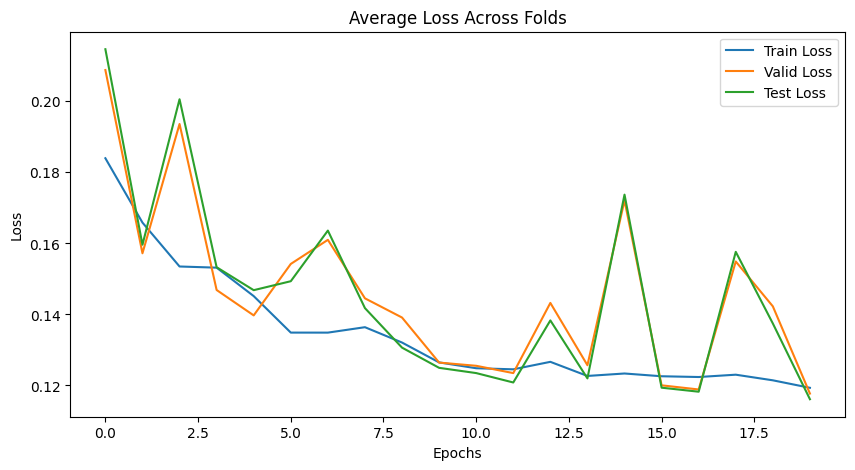

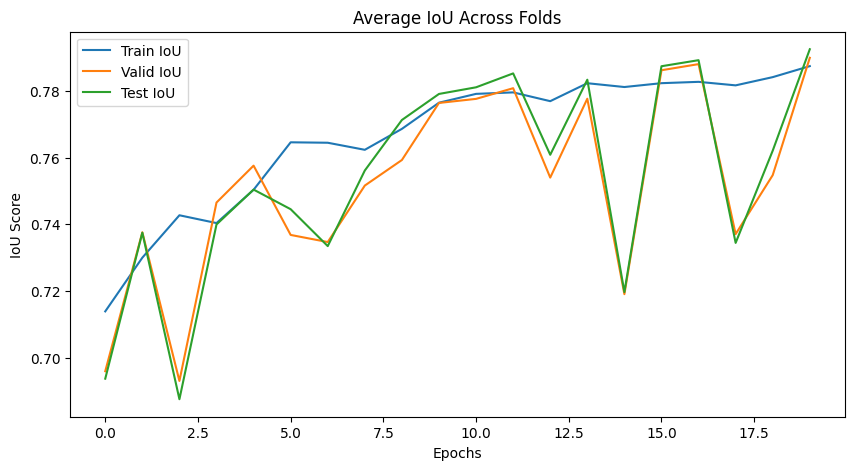

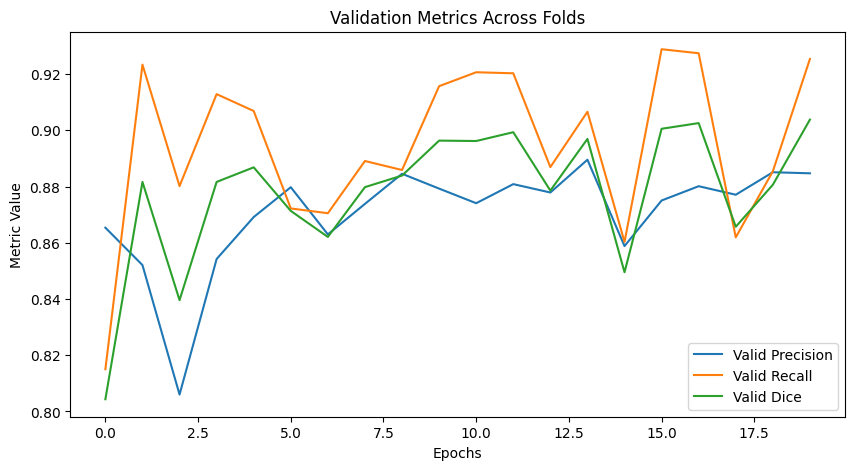

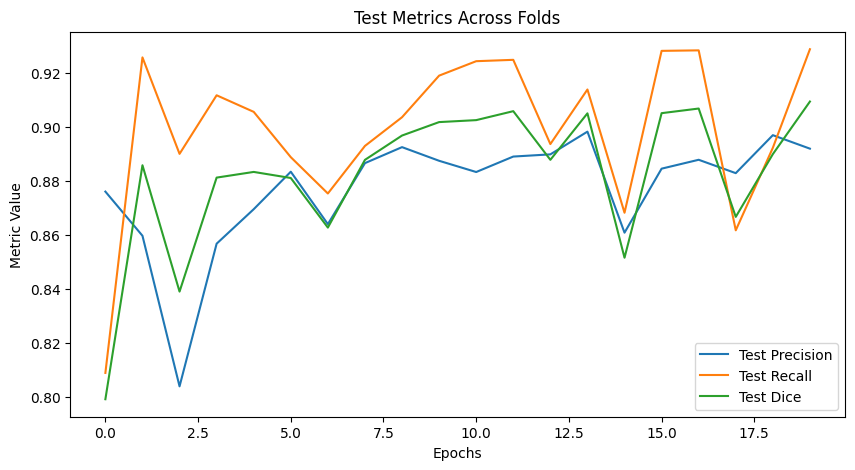

Metrics have been saved to 'Dataset1_model_Wnet.csv'


/tmp/ipykernel_282766/1280507250.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_fpath)
/tmp/ipykernel_282766/78199495.py:384: UserW

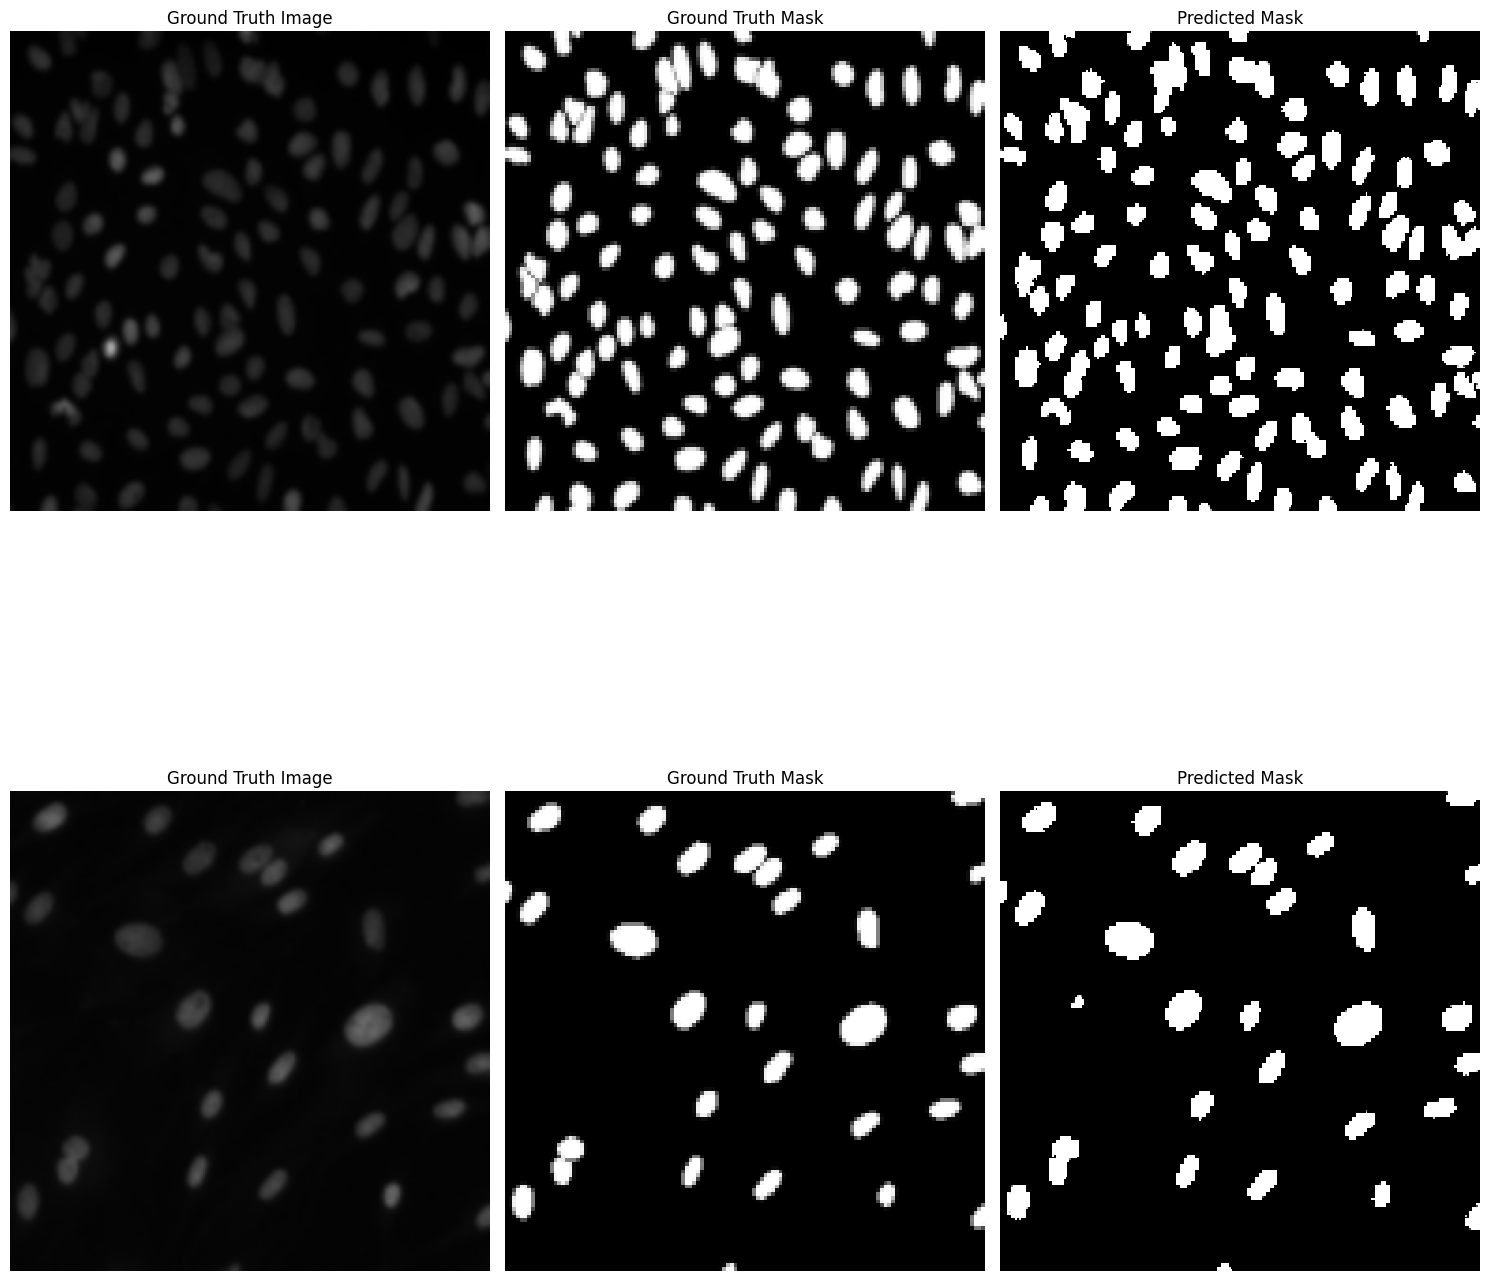

In [5]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
#import tqdm as tqdm
from tqdm import tqdm as tqdm
import tifffile as tiff
import imagecodecs
# Set up necessary directories and loss function
if not os.path.exists("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/WNet"):
    os.makedirs("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/WNet")

class double_conv(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channel),
            nn.Conv2d(out_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channel)
        )
    def forward(self, x):
        return self.conv(x)

class down_conv(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(down_conv, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_channel, out_channel)
        )
    def forward(self, x):
        return self.down(x)

class up_sample(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(up_sample, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.double_conv = double_conv(in_channel, out_channel)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], dim=1)
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        self.down1 = double_conv(in_channel, 16)
        self.down2 = down_conv(16, 32)
        self.down3 = down_conv(32, 64)
        self.down4 = down_conv(64, 128)
        self.down5 = down_conv(128, 256)
        self.down6 = down_conv(256, 512)
        self.down7 = down_conv(512, 1024)
        self.up1 = up_sample(1024+512, 512)
        self.up2 = up_sample(512+256, 256)
        self.up3 = up_sample(256+128, 128)
        self.up4 = up_sample(128+64, 64)
        self.up5 = up_sample(64+32, 32)
        self.up6 = up_sample(32+16, 16)
        self.final = nn.Conv2d(16, out_channel, 1)
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x6 = self.down6(x5)
        x7 = self.down7(x6)
        x8 = self.up1(x7, x6)
        x9 = self.up2(x8, x5)
        x10 = self.up3(x9, x4)
        x11 = self.up4(x10, x3)
        x12 = self.up5(x11, x2)
        x13 = self.up6(x12, x1)
        return torch.sigmoid(self.final(x13))

class WNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(WNet, self).__init__()
        self.unet1 = UNet(in_channel, in_channel)
        self.unet2 = UNet(in_channel, out_channel)
    def forward(self, x):
        x1 = self.unet1(x)
        return self.unet2(x1)

# Initialize model and optimizer for each fold
model = WNet(3,1)  # Assuming UNet is defined earlier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Parameters and Data
num_epochs = 20
k_folds = 7
checkpoint_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/WNet/chkpoint_'
best_model_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/WNet/bestmodel.pt'

# Initialize metrics
accuracy_metric = IoU()  # Assuming IoU is a metric you defined earlier
criterion = DiceLoss()  # Assuming DiceLoss is defined earlier
valid_loss_min = np.inf

# Store results
total_train_loss, total_train_score  = [], []
total_valid_loss, total_valid_score  = [], []
total_test_loss, total_test_score  = [], []

total_train_precision, total_valid_precision, total_test_precision = [], [], []
total_train_recall, total_valid_recall, total_test_recall = [], [], []
total_train_dice, total_valid_dice, total_test_dice = [], [], []

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 7-fold Cross Validation Loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"\n####### Fold {fold+1}/{k_folds} #######")

    # Create data subsets for current fold
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=16, shuffle=False)

    # Track losses and scores for each fold
    fold_train_loss, fold_train_score = [], []
    fold_valid_loss, fold_valid_score = [], []
    fold_test_loss, fold_test_score = [], []
    
    fold_train_precision, fold_valid_precision, fold_test_precision = [], [], []
    fold_train_recall, fold_valid_recall, fold_test_recall = [], [], []
    fold_train_dice, fold_valid_dice, fold_test_dice = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_score = [], []

        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for x_train, y_train in pbar:
            x_train = torch.autograd.Variable(x_train)
            y_train = torch.autograd.Variable(y_train)
            optimizer.zero_grad()
            output = model(x_train)

            # Compute Loss and Score
            loss = criterion(output, y_train)
            score = accuracy_metric(output, y_train)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_score.append(score.item())
            pbar.set_description(f"Epoch {epoch+1} - Loss: {loss.item():.4f}, IoU: {score:.4f}")

        fold_train_loss.append(np.mean(train_loss))
        fold_train_score.append(np.mean(train_score))

        # Validation Loop
        model.eval()
        valid_loss, valid_score= [], []

        valid_precision = []
        valid_recall = []
        valid_dice = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = torch.autograd.Variable(x_val)
                y_val = torch.autograd.Variable(y_val)
                output = model(x_val)

                # Compute Loss and Score
                loss = criterion(output, y_val)
                score = accuracy_metric(output, y_val)

                valid_loss.append(loss.item())
                valid_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_val_bin = (y_val > 0.5).float()

                valid_precision.append(precision_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_recall.append(recall_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_dice.append(f1_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_valid_loss.append(np.mean(valid_loss))
        fold_valid_score.append(np.mean(valid_score))
        
        fold_valid_precision.append(np.mean(valid_precision))
        fold_valid_recall.append(np.mean(valid_recall))
        fold_valid_dice.append(np.mean(valid_dice))

        # Test Loop
        test_loss = []
        test_score = []
        
        test_precision = []
        test_recall = []
        test_dice = []

        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test = torch.autograd.Variable(x_test)
                y_test = torch.autograd.Variable(y_test)
                output = model(x_test)

                # Compute Loss and Score
                loss = criterion(output, y_test)
                score = accuracy_metric(output, y_test)

                test_loss.append(loss.item())
                test_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_test_bin = (y_test > 0.5).float()

                test_precision.append(precision_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_recall.append(recall_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_dice.append(f1_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_test_loss.append(np.mean(test_loss))
        fold_test_score.append(np.mean(test_score))

        fold_test_precision.append(np.mean(test_precision))
        fold_test_recall.append(np.mean(test_recall))
        fold_test_dice.append(np.mean(test_dice))

        print(f"Fold {fold+1} - Epoch {epoch+1} - Train Loss: {np.mean(train_loss):.4f}, IoU: {np.mean(train_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Loss: {np.mean(valid_loss):.4f}, IoU: {np.mean(valid_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Loss: {np.mean(test_loss):.4f}, IoU: {np.mean(test_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Precision: {np.mean(valid_precision):.4f}, Recall: {np.mean(valid_recall):.4f}, Dice: {np.mean(valid_dice):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Precision: {np.mean(test_precision):.4f}, Recall: {np.mean(test_recall):.4f}, Dice: {np.mean(test_dice):.4f}")

        # Save checkpoint and best model
        checkpoint = {
            'epoch': epoch+1,
            'valid_loss_min': fold_valid_loss[-1],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        if fold_valid_loss[-1] <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {fold_valid_loss[-1]:.6f}). Saving model...')
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = fold_valid_loss[-1]

    # Append fold results
    total_train_loss.append(fold_train_loss)
    total_train_score.append(fold_train_score)
    total_valid_loss.append(fold_valid_loss)
    total_valid_score.append(fold_valid_score)
    total_test_loss.append(fold_test_loss)
    total_test_score.append(fold_test_score)

    total_train_precision.append(fold_train_precision)
    total_valid_precision.append(fold_valid_precision)
    total_test_precision.append(fold_test_precision)

    total_train_recall.append(fold_train_recall)
    total_valid_recall.append(fold_valid_recall)
    total_test_recall.append(fold_test_recall)

    total_train_dice.append(fold_train_dice)
    total_valid_dice.append(fold_valid_dice)
    total_test_dice.append(fold_test_dice)

# Calculate average results over all folds
avg_train_loss = np.mean(total_train_loss, axis=0)
avg_train_score = np.mean(total_train_score, axis=0)
avg_valid_loss = np.mean(total_valid_loss, axis=0)
avg_valid_score = np.mean(total_valid_score, axis=0)
avg_test_loss = np.mean(total_test_loss, axis=0)
avg_test_score = np.mean(total_test_score, axis=0)

avg_train_precision = np.mean(total_train_precision, axis=0)
avg_valid_precision = np.mean(total_valid_precision, axis=0)
avg_test_precision = np.mean(total_test_precision, axis=0)

avg_train_recall = np.mean(total_train_recall, axis=0)
avg_valid_recall = np.mean(total_valid_recall, axis=0)
avg_test_recall = np.mean(total_test_recall, axis=0)

avg_train_dice = np.mean(total_train_dice, axis=0)
avg_valid_dice = np.mean(total_valid_dice, axis=0)
avg_test_dice = np.mean(total_test_dice, axis=0)

# Plot final averaged results for losses and metrics
plt.figure(figsize=(10,5))
plt.plot(avg_train_loss, label="Train Loss")
plt.plot(avg_valid_loss, label="Valid Loss")
plt.plot(avg_test_loss, label="Test Loss")
plt.legend()
plt.title("Average Loss Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot IoU scores
plt.figure(figsize=(10,5))
plt.plot(avg_train_score, label="Train IoU")
plt.plot(avg_valid_score, label="Valid IoU")
plt.plot(avg_test_score, label="Test IoU")
plt.legend()
plt.title("Average IoU Across Folds")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.show()

# Plot Precision, Recall, and Dice scores for validation and test sets
plt.figure(figsize=(10,5))
plt.plot(avg_valid_precision, label="Valid Precision")
plt.plot(avg_valid_recall, label="Valid Recall")
plt.plot(avg_valid_dice, label="Valid Dice")
plt.legend()
plt.title("Validation Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(avg_test_precision, label="Test Precision")
plt.plot(avg_test_recall, label="Test Recall")
plt.plot(avg_test_dice, label="Test Dice")
plt.legend()
plt.title("Test Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

import pandas as pd

# Create a DataFrame to store results
columns = [
    'Fold', 'Epoch', 'Train_Loss', 'Train_IoU', 'Valid_Loss', 'Valid_IoU', 'Test_Loss', 'Test_IoU',
    'Valid_Precision', 'Valid_Recall', 'Valid_Dice', 'Test_Precision', 'Test_Recall', 'Test_Dice'
]

results = []

# Collect the results after all folds and epochs
for fold in range(k_folds):
    for epoch in range(num_epochs):
        results.append([
            fold + 1, epoch + 1,
            total_train_loss[fold][epoch], total_train_score[fold][epoch],
            total_valid_loss[fold][epoch], total_valid_score[fold][epoch],total_test_loss[fold][epoch], total_test_score[fold][epoch],
            total_valid_precision[fold][epoch], total_valid_recall[fold][epoch], total_valid_dice[fold][epoch],
            total_test_precision[fold][epoch], total_test_recall[fold][epoch], total_test_dice[fold][epoch]
        ])

# Convert results to a pandas DataFrame
df = pd.DataFrame(results, columns=columns)

# Save DataFrame to CSV
df.to_csv("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/WNet/Dataset1_model_Wnet.csv", index=False)

print("Metrics have been saved to 'Dataset1_model_Wnet.csv'")

#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

def visualize_predict(model, n_images):
  #model = model.eval()
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in test_loader:
        data = torch.autograd.Variable(data, volatile=True)
        mask = torch.autograd.Variable(mask, volatile=True)
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Ground Truth Image")
    ax[img_no, 1].set_title("Ground Truth Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
  plt.tight_layout()
  plt.show()
  
visualize_predict(model, 2)

# DeepLabV3

In [ ]:
# Set up necessary directories and loss function
if not os.path.exists("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/DeepLabV3"):
    os.makedirs("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/DeepLabV3")

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6)
        self.conv12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12)
        self.conv18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv_pool = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.final_conv = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv6(x)
        x3 = self.conv12(x)
        x4 = self.conv18(x)
        x5 = self.pool(x)
        x5 = self.conv_pool(x5)
        x5 = F.interpolate(x5, size=x.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        return self.final_conv(x)

class DeepLabV3(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DeepLabV3, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.aspp = ASPP(128, 256)
        self.final_conv = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.aspp(x)
        x = self.final_conv(x)
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)
        return x

# Initialize model and optimizer for each fold
model = DeepLabV3(3,1)  # Assuming UNet is defined earlier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Parameters and Data
num_epochs = 20
k_folds = 7
checkpoint_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/DeepLabV3/chkpoint_'
best_model_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/DeepLabV3/bestmodel.pt'

# Initialize metrics
accuracy_metric = IoU()  # Assuming IoU is a metric you defined earlier
criterion = DiceLoss()  # Assuming DiceLoss is defined earlier
valid_loss_min = np.inf

# Store results
total_train_loss, total_train_score  = [], []
total_valid_loss, total_valid_score  = [], []
total_test_loss, total_test_score  = [], []

total_train_precision, total_valid_precision, total_test_precision = [], [], []
total_train_recall, total_valid_recall, total_test_recall = [], [], []
total_train_dice, total_valid_dice, total_test_dice = [], [], []

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 7-fold Cross Validation Loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"\n####### Fold {fold+1}/{k_folds} #######")

    # Create data subsets for current fold
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=16, shuffle=False)

    # Track losses and scores for each fold
    fold_train_loss, fold_train_score = [], []
    fold_valid_loss, fold_valid_score = [], []
    fold_test_loss, fold_test_score = [], []
    
    fold_train_precision, fold_valid_precision, fold_test_precision = [], [], []
    fold_train_recall, fold_valid_recall, fold_test_recall = [], [], []
    fold_train_dice, fold_valid_dice, fold_test_dice = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_score = [], []

        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for x_train, y_train in pbar:
            x_train = torch.autograd.Variable(x_train)
            y_train = torch.autograd.Variable(y_train)
            optimizer.zero_grad()
            output = model(x_train)
            output = F.interpolate(output, size=y_train.shape[2:], mode='bilinear', align_corners=False)
            # Compute Loss and Score
            loss = criterion(output, y_train)
            score = accuracy_metric(output, y_train)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_score.append(score.item())
            pbar.set_description(f"Epoch {epoch+1} - Loss: {loss.item():.4f}, IoU: {score:.4f}")

        fold_train_loss.append(np.mean(train_loss))
        fold_train_score.append(np.mean(train_score))

        # Validation Loop
        model.eval()
        valid_loss, valid_score= [], []

        valid_precision = []
        valid_recall = []
        valid_dice = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = torch.autograd.Variable(x_val)
                y_val = torch.autograd.Variable(y_val)
                output = model(x_val)
                output = F.interpolate(output, size=y_val.shape[2:], mode='bilinear', align_corners=False)

                # Compute Loss and Score
                loss = criterion(output, y_val)
                score = accuracy_metric(output, y_val)

                valid_loss.append(loss.item())
                valid_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_val_bin = (y_val > 0.5).float()

                valid_precision.append(precision_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_recall.append(recall_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_dice.append(f1_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_valid_loss.append(np.mean(valid_loss))
        fold_valid_score.append(np.mean(valid_score))
        
        fold_valid_precision.append(np.mean(valid_precision))
        fold_valid_recall.append(np.mean(valid_recall))
        fold_valid_dice.append(np.mean(valid_dice))

        # Test Loop
        test_loss = []
        test_score = []
        
        test_precision = []
        test_recall = []
        test_dice = []

        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test = torch.autograd.Variable(x_test)
                y_test = torch.autograd.Variable(y_test)
                output = model(x_test)
                output = F.interpolate(output, size=y_test.shape[2:], mode='bilinear', align_corners=False)

                # Compute Loss and Score
                loss = criterion(output, y_test)
                score = accuracy_metric(output, y_test)

                test_loss.append(loss.item())
                test_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_test_bin = (y_test > 0.5).float()

                test_precision.append(precision_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_recall.append(recall_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_dice.append(f1_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_test_loss.append(np.mean(test_loss))
        fold_test_score.append(np.mean(test_score))

        fold_test_precision.append(np.mean(test_precision))
        fold_test_recall.append(np.mean(test_recall))
        fold_test_dice.append(np.mean(test_dice))

        print(f"Fold {fold+1} - Epoch {epoch+1} - Train Loss: {np.mean(train_loss):.4f}, IoU: {np.mean(train_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Loss: {np.mean(valid_loss):.4f}, IoU: {np.mean(valid_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Loss: {np.mean(test_loss):.4f}, IoU: {np.mean(test_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Precision: {np.mean(valid_precision):.4f}, Recall: {np.mean(valid_recall):.4f}, Dice: {np.mean(valid_dice):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Precision: {np.mean(test_precision):.4f}, Recall: {np.mean(test_recall):.4f}, Dice: {np.mean(test_dice):.4f}")

        # Save checkpoint and best model
        checkpoint = {
            'epoch': epoch+1,
            'valid_loss_min': fold_valid_loss[-1],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        if fold_valid_loss[-1] <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {fold_valid_loss[-1]:.6f}). Saving model...')
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = fold_valid_loss[-1]

    # Append fold results
    total_train_loss.append(fold_train_loss)
    total_train_score.append(fold_train_score)
    total_valid_loss.append(fold_valid_loss)
    total_valid_score.append(fold_valid_score)
    total_test_loss.append(fold_test_loss)
    total_test_score.append(fold_test_score)

    total_train_precision.append(fold_train_precision)
    total_valid_precision.append(fold_valid_precision)
    total_test_precision.append(fold_test_precision)

    total_train_recall.append(fold_train_recall)
    total_valid_recall.append(fold_valid_recall)
    total_test_recall.append(fold_test_recall)

    total_train_dice.append(fold_train_dice)
    total_valid_dice.append(fold_valid_dice)
    total_test_dice.append(fold_test_dice)

# Calculate average results over all folds
avg_train_loss = np.mean(total_train_loss, axis=0)
avg_train_score = np.mean(total_train_score, axis=0)
avg_valid_loss = np.mean(total_valid_loss, axis=0)
avg_valid_score = np.mean(total_valid_score, axis=0)
avg_test_loss = np.mean(total_test_loss, axis=0)
avg_test_score = np.mean(total_test_score, axis=0)

avg_train_precision = np.mean(total_train_precision, axis=0)
avg_valid_precision = np.mean(total_valid_precision, axis=0)
avg_test_precision = np.mean(total_test_precision, axis=0)

avg_train_recall = np.mean(total_train_recall, axis=0)
avg_valid_recall = np.mean(total_valid_recall, axis=0)
avg_test_recall = np.mean(total_test_recall, axis=0)

avg_train_dice = np.mean(total_train_dice, axis=0)
avg_valid_dice = np.mean(total_valid_dice, axis=0)
avg_test_dice = np.mean(total_test_dice, axis=0)

# Plot final averaged results for losses and metrics
plt.figure(figsize=(10,5))
plt.plot(avg_train_loss, label="Train Loss")
plt.plot(avg_valid_loss, label="Valid Loss")
plt.plot(avg_test_loss, label="Test Loss")
plt.legend()
plt.title("Average Loss Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot IoU scores
plt.figure(figsize=(10,5))
plt.plot(avg_train_score, label="Train IoU")
plt.plot(avg_valid_score, label="Valid IoU")
plt.plot(avg_test_score, label="Test IoU")
plt.legend()
plt.title("Average IoU Across Folds")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.show()

# Plot Precision, Recall, and Dice scores for validation and test sets
plt.figure(figsize=(10,5))
plt.plot(avg_valid_precision, label="Valid Precision")
plt.plot(avg_valid_recall, label="Valid Recall")
plt.plot(avg_valid_dice, label="Valid Dice")
plt.legend()
plt.title("Validation Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(avg_test_precision, label="Test Precision")
plt.plot(avg_test_recall, label="Test Recall")
plt.plot(avg_test_dice, label="Test Dice")
plt.legend()
plt.title("Test Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

import pandas as pd

# Create a DataFrame to store results
columns = [
    'Fold', 'Epoch', 'Train_Loss', 'Train_IoU', 'Valid_Loss', 'Valid_IoU', 'Test_Loss', 'Test_IoU',
    'Valid_Precision', 'Valid_Recall', 'Valid_Dice', 'Test_Precision', 'Test_Recall', 'Test_Dice'
]

results = []

# Collect the results after all folds and epochs
for fold in range(k_folds):
    for epoch in range(num_epochs):
        results.append([
            fold + 1, epoch + 1,
            total_train_loss[fold][epoch], total_train_score[fold][epoch],
            total_valid_loss[fold][epoch], total_valid_score[fold][epoch],total_test_loss[fold][epoch], total_test_score[fold][epoch],
            total_valid_precision[fold][epoch], total_valid_recall[fold][epoch], total_valid_dice[fold][epoch],
            total_test_precision[fold][epoch], total_test_recall[fold][epoch], total_test_dice[fold][epoch]
        ])

# Convert results to a pandas DataFrame
df = pd.DataFrame(results, columns=columns)

# Save DataFrame to CSV
df.to_csv("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/DeepLabV3/Dataset1_model_DeepLabV3.csv", index=False)

print("Metrics have been saved to 'Dataset1_model_DeepLabV3.csv'")

#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

def visualize_predict(model, n_images):
  #model = model.eval()
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in test_loader:
        data = torch.autograd.Variable(data, volatile=True)
        mask = torch.autograd.Variable(mask, volatile=True)
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Ground Truth Image")
    ax[img_no, 1].set_title("Ground Truth Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
  plt.tight_layout()
  plt.show()
  
visualize_predict(model, 2)


####### Fold 1/7 #######


Epoch 1 - Loss: 0.7916, IoU: 0.1164: 100%|██████| 36/36 [21:49<00:00, 36.37s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 1 - Train Loss: 0.7779, IoU: 0.1303
Fold 1 - Epoch 1 - Valid Loss: 0.7054, IoU: 0.1736
Fold 1 - Epoch 1 - Test Loss: 0.7502, IoU: 0.1451
Fold 1 - Epoch 1 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 1 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Validation loss decreased (inf --> 0.705390). Saving model...


Epoch 2 - Loss: 0.4698, IoU: 0.3607: 100%|██████| 36/36 [21:57<00:00, 36.59s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 2 - Train Loss: 0.7062, IoU: 0.1746
Fold 1 - Epoch 2 - Valid Loss: 0.6275, IoU: 0.2307
Fold 1 - Epoch 2 - Test Loss: 0.7023, IoU: 0.1796
Fold 1 - Epoch 2 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 2 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Validation loss decreased (0.705390 --> 0.627523). Saving model...


Epoch 3 - Loss: 0.6908, IoU: 0.1829: 100%|██████| 36/36 [22:04<00:00, 36.79s/it]


Fold 1 - Epoch 3 - Train Loss: 5.2104, IoU: 1.9974
Fold 1 - Epoch 3 - Valid Loss: 0.6748, IoU: 0.1949
Fold 1 - Epoch 3 - Test Loss: 0.7569, IoU: 0.1417
Fold 1 - Epoch 3 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 3 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 4 - Loss: 0.4593, IoU: 0.3705: 100%|██████| 36/36 [21:54<00:00, 36.50s/it]


Fold 1 - Epoch 4 - Train Loss: 0.6741, IoU: 0.1989
Fold 1 - Epoch 4 - Valid Loss: 0.6504, IoU: 0.2131
Fold 1 - Epoch 4 - Test Loss: 0.7447, IoU: 0.1505
Fold 1 - Epoch 4 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 4 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 5 - Loss: 0.6449, IoU: 0.2159: 100%|██████| 36/36 [21:37<00:00, 36.03s/it]


Fold 1 - Epoch 5 - Train Loss: 0.6732, IoU: 0.2020
Fold 1 - Epoch 5 - Valid Loss: 0.6505, IoU: 0.2130
Fold 1 - Epoch 5 - Test Loss: 0.7448, IoU: 0.1504
Fold 1 - Epoch 5 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 5 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 6 - Loss: 0.6216, IoU: 0.2334: 100%|██████| 36/36 [21:35<00:00, 35.98s/it]


Fold 1 - Epoch 6 - Train Loss: 0.6808, IoU: 0.1974
Fold 1 - Epoch 6 - Valid Loss: 0.6502, IoU: 0.2133
Fold 1 - Epoch 6 - Test Loss: 0.7447, IoU: 0.1505
Fold 1 - Epoch 6 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 6 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 7 - Loss: 0.6159, IoU: 0.2377: 100%|██████| 36/36 [21:33<00:00, 35.93s/it]


Fold 1 - Epoch 7 - Train Loss: 0.6750, IoU: 0.1980
Fold 1 - Epoch 7 - Valid Loss: 0.6499, IoU: 0.2135
Fold 1 - Epoch 7 - Test Loss: 0.7445, IoU: 0.1506
Fold 1 - Epoch 7 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 7 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 8 - Loss: 0.5848, IoU: 0.2620: 100%|██████| 36/36 [21:32<00:00, 35.91s/it]


Fold 1 - Epoch 8 - Train Loss: 0.6711, IoU: 0.2011
Fold 1 - Epoch 8 - Valid Loss: 0.6493, IoU: 0.2140
Fold 1 - Epoch 8 - Test Loss: 0.7443, IoU: 0.1508
Fold 1 - Epoch 8 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 8 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 9 - Loss: 0.7049, IoU: 0.1731: 100%|██████| 36/36 [21:31<00:00, 35.88s/it]


Fold 1 - Epoch 9 - Train Loss: 0.6726, IoU: 0.2012
Fold 1 - Epoch 9 - Valid Loss: 0.6488, IoU: 0.2143
Fold 1 - Epoch 9 - Test Loss: 0.7441, IoU: 0.1509
Fold 1 - Epoch 9 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 9 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 10 - Loss: 0.7732, IoU: 0.1279: 100%|█████| 36/36 [21:34<00:00, 35.95s/it]


Fold 1 - Epoch 10 - Train Loss: 0.6672, IoU: 0.2047
Fold 1 - Epoch 10 - Valid Loss: 0.6484, IoU: 0.2146
Fold 1 - Epoch 10 - Test Loss: 0.7439, IoU: 0.1511
Fold 1 - Epoch 10 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 10 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 11 - Loss: 0.6696, IoU: 0.1979: 100%|█████| 36/36 [21:34<00:00, 35.96s/it]


Fold 1 - Epoch 11 - Train Loss: 0.6719, IoU: 0.2025
Fold 1 - Epoch 11 - Valid Loss: 0.6479, IoU: 0.2150
Fold 1 - Epoch 11 - Test Loss: 0.7438, IoU: 0.1512
Fold 1 - Epoch 11 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 11 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 12 - Loss: 0.7947, IoU: 0.1144: 100%|█████| 36/36 [22:02<00:00, 36.74s/it]


Fold 1 - Epoch 12 - Train Loss: 0.6723, IoU: 0.2020
Fold 1 - Epoch 12 - Valid Loss: 0.6472, IoU: 0.2155
Fold 1 - Epoch 12 - Test Loss: 0.7436, IoU: 0.1513
Fold 1 - Epoch 12 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 12 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 13 - Loss: 0.7061, IoU: 0.1723: 100%|█████| 36/36 [21:59<00:00, 36.66s/it]


Fold 1 - Epoch 13 - Train Loss: 0.6791, IoU: 0.1957
Fold 1 - Epoch 13 - Valid Loss: 0.6466, IoU: 0.2160
Fold 1 - Epoch 13 - Test Loss: 0.7433, IoU: 0.1515
Fold 1 - Epoch 13 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 13 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 14 - Loss: 0.7535, IoU: 0.1405: 100%|█████| 36/36 [21:58<00:00, 36.63s/it]


Fold 1 - Epoch 14 - Train Loss: 0.6671, IoU: 0.2045
Fold 1 - Epoch 14 - Valid Loss: 0.6460, IoU: 0.2164
Fold 1 - Epoch 14 - Test Loss: 0.7432, IoU: 0.1516
Fold 1 - Epoch 14 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 14 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 15 - Loss: 0.6277, IoU: 0.2288: 100%|█████| 36/36 [22:01<00:00, 36.70s/it]


Fold 1 - Epoch 15 - Train Loss: 0.6700, IoU: 0.2038
Fold 1 - Epoch 15 - Valid Loss: 0.6454, IoU: 0.2169
Fold 1 - Epoch 15 - Test Loss: 0.7429, IoU: 0.1519
Fold 1 - Epoch 15 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 15 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 16 - Loss: 0.6114, IoU: 0.2412: 100%|█████| 36/36 [22:02<00:00, 36.74s/it]


Fold 1 - Epoch 16 - Train Loss: 0.6612, IoU: 0.2075
Fold 1 - Epoch 16 - Valid Loss: 0.6447, IoU: 0.2174
Fold 1 - Epoch 16 - Test Loss: 0.7426, IoU: 0.1521
Fold 1 - Epoch 16 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 16 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 17 - Loss: 0.7322, IoU: 0.1546: 100%|█████| 36/36 [22:02<00:00, 36.73s/it]


Fold 1 - Epoch 17 - Train Loss: 0.6671, IoU: 0.2041
Fold 1 - Epoch 17 - Valid Loss: 0.6440, IoU: 0.2179
Fold 1 - Epoch 17 - Test Loss: 0.7424, IoU: 0.1522
Fold 1 - Epoch 17 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 17 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 18 - Loss: 0.6965, IoU: 0.1789: 100%|█████| 36/36 [22:01<00:00, 36.71s/it]


Fold 1 - Epoch 18 - Train Loss: 0.6617, IoU: 0.2094
Fold 1 - Epoch 18 - Valid Loss: 0.6431, IoU: 0.2187
Fold 1 - Epoch 18 - Test Loss: 0.7421, IoU: 0.1525
Fold 1 - Epoch 18 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 18 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 19 - Loss: 0.6672, IoU: 0.1996: 100%|█████| 36/36 [21:46<00:00, 36.28s/it]


Fold 1 - Epoch 19 - Train Loss: 0.6684, IoU: 0.2034
Fold 1 - Epoch 19 - Valid Loss: 0.6422, IoU: 0.2193
Fold 1 - Epoch 19 - Test Loss: 0.7417, IoU: 0.1528
Fold 1 - Epoch 19 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 19 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 20 - Loss: 0.5881, IoU: 0.2593: 100%|█████| 36/36 [21:44<00:00, 36.25s/it]


Fold 1 - Epoch 20 - Train Loss: 0.6713, IoU: 0.2017
Fold 1 - Epoch 20 - Valid Loss: 0.6412, IoU: 0.2201
Fold 1 - Epoch 20 - Test Loss: 0.7413, IoU: 0.1531
Fold 1 - Epoch 20 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 20 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298

####### Fold 2/7 #######


Epoch 1 - Loss: 0.6471, IoU: 0.2143: 100%|██████| 36/36 [21:35<00:00, 35.98s/it]


Fold 2 - Epoch 1 - Train Loss: 0.6524, IoU: 0.2159
Fold 2 - Epoch 1 - Valid Loss: 0.7101, IoU: 0.1717
Fold 2 - Epoch 1 - Test Loss: 0.7409, IoU: 0.1534
Fold 2 - Epoch 1 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 1 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 2 - Loss: 0.7303, IoU: 0.1558: 100%|██████| 36/36 [21:38<00:00, 36.07s/it]


Fold 2 - Epoch 2 - Train Loss: 0.6499, IoU: 0.2172
Fold 2 - Epoch 2 - Valid Loss: 0.7090, IoU: 0.1724
Fold 2 - Epoch 2 - Test Loss: 0.7404, IoU: 0.1538
Fold 2 - Epoch 2 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 2 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 3 - Loss: 0.4287, IoU: 0.3999: 100%|██████| 36/36 [21:37<00:00, 36.05s/it]


Fold 2 - Epoch 3 - Train Loss: 0.6520, IoU: 0.2171
Fold 2 - Epoch 3 - Valid Loss: 0.7077, IoU: 0.1734
Fold 2 - Epoch 3 - Test Loss: 0.7398, IoU: 0.1542
Fold 2 - Epoch 3 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 3 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 4 - Loss: 0.7144, IoU: 0.1666: 100%|██████| 36/36 [21:32<00:00, 35.90s/it]


Fold 2 - Epoch 4 - Train Loss: 0.6513, IoU: 0.2178
Fold 2 - Epoch 4 - Valid Loss: 0.7063, IoU: 0.1744
Fold 2 - Epoch 4 - Test Loss: 0.7392, IoU: 0.1547
Fold 2 - Epoch 4 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 4 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 5 - Loss: 0.4654, IoU: 0.3648: 100%|██████| 36/36 [21:34<00:00, 35.96s/it]


Fold 2 - Epoch 5 - Train Loss: 0.6413, IoU: 0.2234
Fold 2 - Epoch 5 - Valid Loss: 0.7044, IoU: 0.1758
Fold 2 - Epoch 5 - Test Loss: 0.7383, IoU: 0.1554
Fold 2 - Epoch 5 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 5 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 6 - Loss: 0.6843, IoU: 0.1874: 100%|██████| 36/36 [21:32<00:00, 35.89s/it]


Fold 2 - Epoch 6 - Train Loss: 0.6423, IoU: 0.2245
Fold 2 - Epoch 6 - Valid Loss: 0.7022, IoU: 0.1774
Fold 2 - Epoch 6 - Test Loss: 0.7374, IoU: 0.1561
Fold 2 - Epoch 6 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 6 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 7 - Loss: 0.5320, IoU: 0.3054: 100%|██████| 36/36 [21:34<00:00, 35.97s/it]


Fold 2 - Epoch 7 - Train Loss: 0.6395, IoU: 0.2248
Fold 2 - Epoch 7 - Valid Loss: 0.6996, IoU: 0.1793
Fold 2 - Epoch 7 - Test Loss: 0.7363, IoU: 0.1569
Fold 2 - Epoch 7 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 7 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 8 - Loss: 0.5443, IoU: 0.2951: 100%|██████| 36/36 [21:39<00:00, 36.10s/it]


Fold 2 - Epoch 8 - Train Loss: 0.6388, IoU: 0.2269
Fold 2 - Epoch 8 - Valid Loss: 0.6961, IoU: 0.1818
Fold 2 - Epoch 8 - Test Loss: 0.7348, IoU: 0.1581
Fold 2 - Epoch 8 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 8 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 9 - Loss: 0.4099, IoU: 0.4186: 100%|██████| 36/36 [21:43<00:00, 36.21s/it]


Fold 2 - Epoch 9 - Train Loss: 0.6307, IoU: 0.2352
Fold 2 - Epoch 9 - Valid Loss: 0.6920, IoU: 0.1848
Fold 2 - Epoch 9 - Test Loss: 0.7329, IoU: 0.1596
Fold 2 - Epoch 9 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 9 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 10 - Loss: 0.6620, IoU: 0.2034: 100%|█████| 36/36 [21:48<00:00, 36.35s/it]


Fold 2 - Epoch 10 - Train Loss: 0.6266, IoU: 0.2363
Fold 2 - Epoch 10 - Valid Loss: 0.6861, IoU: 0.1892
Fold 2 - Epoch 10 - Test Loss: 0.7303, IoU: 0.1616
Fold 2 - Epoch 10 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 10 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 11 - Loss: 0.8811, IoU: 0.0632: 100%|█████| 36/36 [21:48<00:00, 36.35s/it]


Fold 2 - Epoch 11 - Train Loss: 0.6339, IoU: 0.2336
Fold 2 - Epoch 11 - Valid Loss: 0.6789, IoU: 0.1946
Fold 2 - Epoch 11 - Test Loss: 0.7272, IoU: 0.1641
Fold 2 - Epoch 11 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 11 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 12 - Loss: 0.8475, IoU: 0.0826: 100%|█████| 36/36 [21:50<00:00, 36.40s/it]


Fold 2 - Epoch 12 - Train Loss: 0.6122, IoU: 0.2506
Fold 2 - Epoch 12 - Valid Loss: 0.6690, IoU: 0.2021
Fold 2 - Epoch 12 - Test Loss: 0.7228, IoU: 0.1677
Fold 2 - Epoch 12 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 12 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 13 - Loss: 0.6030, IoU: 0.2477: 100%|█████| 36/36 [21:48<00:00, 36.33s/it]


Fold 2 - Epoch 13 - Train Loss: 0.5927, IoU: 0.2658
Fold 2 - Epoch 13 - Valid Loss: 0.6542, IoU: 0.2136
Fold 2 - Epoch 13 - Test Loss: 0.7163, IoU: 0.1730
Fold 2 - Epoch 13 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 13 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 14 - Loss: 0.4841, IoU: 0.3476: 100%|█████| 36/36 [21:50<00:00, 36.39s/it]


Fold 2 - Epoch 14 - Train Loss: 0.5785, IoU: 0.2770
Fold 2 - Epoch 14 - Valid Loss: 0.6322, IoU: 0.2311
Fold 2 - Epoch 14 - Test Loss: 0.7069, IoU: 0.1808
Fold 2 - Epoch 14 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 14 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298


Epoch 15 - Loss: 0.7496, IoU: 0.1431: 100%|█████| 36/36 [21:45<00:00, 36.25s/it]


Fold 2 - Epoch 15 - Train Loss: 0.5391, IoU: 0.3156
Fold 2 - Epoch 15 - Valid Loss: 0.5911, IoU: 0.2658
Fold 2 - Epoch 15 - Test Loss: 0.6895, IoU: 0.1959
Fold 2 - Epoch 15 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 15 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298
Validation loss decreased (0.627523 --> 0.591051). Saving model...


Epoch 16 - Loss: 0.4884, IoU: 0.3438: 100%|█████| 36/36 [21:38<00:00, 36.08s/it]


Fold 2 - Epoch 16 - Train Loss: 0.4747, IoU: 0.3765
Fold 2 - Epoch 16 - Valid Loss: 0.4993, IoU: 0.3527
Fold 2 - Epoch 16 - Test Loss: 0.6513, IoU: 0.2314
Fold 2 - Epoch 16 - Valid Precision: 0.1238, Recall: 1.0000, Dice: 0.2196
Fold 2 - Epoch 16 - Test Precision: 0.1313, Recall: 1.0000, Dice: 0.2298
Validation loss decreased (0.591051 --> 0.499257). Saving model...


Epoch 17 - Loss: -0.2088, IoU: 1.5278: 100%|████| 36/36 [21:39<00:00, 36.10s/it]


Fold 2 - Epoch 17 - Train Loss: 0.3237, IoU: 0.5889
Fold 2 - Epoch 17 - Valid Loss: -0.1767, IoU: 2.6236
Fold 2 - Epoch 17 - Test Loss: 0.2455, IoU: -7.7689
Fold 2 - Epoch 17 - Valid Precision: 0.1761, Recall: 0.1976, Dice: 0.1804
Fold 2 - Epoch 17 - Test Precision: 0.3566, Recall: 0.1983, Dice: 0.1301
Validation loss decreased (0.499257 --> -0.176657). Saving model...


Epoch 18 - Loss: 0.7827, IoU: 0.1219: 100%|█████| 36/36 [21:39<00:00, 36.11s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 18 - Train Loss: 1.1606, IoU: 0.0203
Fold 2 - Epoch 18 - Valid Loss: 0.8938, IoU: 0.0574
Fold 2 - Epoch 18 - Test Loss: 0.8484, IoU: 0.0869
Fold 2 - Epoch 18 - Valid Precision: 0.6947, Recall: 0.1251, Dice: 0.2047
Fold 2 - Epoch 18 - Test Precision: 0.3523, Recall: 0.0971, Dice: 0.1459


Epoch 19 - Loss: 0.7382, IoU: 0.1506: 100%|█████| 36/36 [21:36<00:00, 36.01s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 19 - Train Loss: 0.8800, IoU: 0.0679
Fold 2 - Epoch 19 - Valid Loss: 0.8214, IoU: 0.0987
Fold 2 - Epoch 19 - Test Loss: 0.7967, IoU: 0.1150
Fold 2 - Epoch 19 - Valid Precision: 0.8782, Recall: 0.0924, Dice: 0.1632
Fold 2 - Epoch 19 - Test Precision: 0.4288, Recall: 0.0554, Dice: 0.0947


Epoch 20 - Loss: 0.7659, IoU: 0.1326: 100%|█████| 36/36 [21:35<00:00, 35.99s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 20 - Train Loss: 0.7931, IoU: 0.1161
Fold 2 - Epoch 20 - Valid Loss: 0.7882, IoU: 0.1191
Fold 2 - Epoch 20 - Test Loss: 0.7747, IoU: 0.1288
Fold 2 - Epoch 20 - Valid Precision: 0.3750, Recall: 0.0001, Dice: 0.0001
Fold 2 - Epoch 20 - Test Precision: 0.1857, Recall: 0.0001, Dice: 0.0003

####### Fold 3/7 #######


Epoch 1 - Loss: 0.7396, IoU: 0.1497: 100%|██████| 36/36 [21:32<00:00, 35.90s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 1 - Train Loss: 0.7591, IoU: 0.1378
Fold 3 - Epoch 1 - Valid Loss: 0.7743, IoU: 0.1276
Fold 3 - Epoch 1 - Test Loss: 0.7665, IoU: 0.1343
Fold 3 - Epoch 1 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 1 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 2 - Loss: 0.7187, IoU: 0.1637: 100%|██████| 36/36 [21:30<00:00, 35.86s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 2 - Train Loss: 0.7459, IoU: 0.1466
Fold 3 - Epoch 2 - Valid Loss: 0.7682, IoU: 0.1315
Fold 3 - Epoch 2 - Test Loss: 0.7627, IoU: 0.1368
Fold 3 - Epoch 2 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 2 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 3 - Loss: 0.7587, IoU: 0.1372: 100%|██████| 36/36 [21:37<00:00, 36.03s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 3 - Train Loss: 0.7085, IoU: 0.1733
Fold 3 - Epoch 3 - Valid Loss: 0.6802, IoU: 0.1948
Fold 3 - Epoch 3 - Test Loss: 0.7103, IoU: 0.1753
Fold 3 - Epoch 3 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 3 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 4 - Loss: 0.8215, IoU: 0.0980: 100%|██████| 36/36 [21:34<00:00, 35.97s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 4 - Train Loss: 0.5026, IoU: 0.3559
Fold 3 - Epoch 4 - Valid Loss: 0.5504, IoU: 0.3089
Fold 3 - Epoch 4 - Test Loss: 0.6084, IoU: 0.2631
Fold 3 - Epoch 4 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 4 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 5 - Loss: -0.0441, IoU: 1.0922: 100%|█████| 36/36 [21:38<00:00, 36.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 5 - Train Loss: 0.3227, IoU: 0.5547
Fold 3 - Epoch 5 - Valid Loss: 0.4800, IoU: 0.3859
Fold 3 - Epoch 5 - Test Loss: 0.5542, IoU: 0.3224
Fold 3 - Epoch 5 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 5 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 6 - Loss: 0.5792, IoU: 0.2664: 100%|██████| 36/36 [21:34<00:00, 35.97s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 6 - Train Loss: 0.2488, IoU: 0.6848
Fold 3 - Epoch 6 - Valid Loss: 0.4260, IoU: 0.4488
Fold 3 - Epoch 6 - Test Loss: 0.5028, IoU: 0.3802
Fold 3 - Epoch 6 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 6 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 7 - Loss: -0.0630, IoU: 1.1345: 100%|█████| 36/36 [21:36<00:00, 36.01s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 7 - Train Loss: 0.1453, IoU: 0.8147
Fold 3 - Epoch 7 - Valid Loss: 0.3769, IoU: 0.5125
Fold 3 - Epoch 7 - Test Loss: 0.4584, IoU: 0.4382
Fold 3 - Epoch 7 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 7 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 8 - Loss: 0.0522, IoU: 0.9009: 100%|██████| 36/36 [21:28<00:00, 35.79s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 8 - Train Loss: 0.1035, IoU: 0.9244
Fold 3 - Epoch 8 - Valid Loss: 0.3262, IoU: 0.5852
Fold 3 - Epoch 8 - Test Loss: 0.4135, IoU: 0.5045
Fold 3 - Epoch 8 - Valid Precision: 0.0006, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 8 - Test Precision: 0.0021, Recall: 0.0001, Dice: 0.0001


Epoch 9 - Loss: 0.1027, IoU: 0.8138: 100%|██████| 36/36 [21:36<00:00, 36.02s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 9 - Train Loss: -0.0216, IoU: 1.1534
Fold 3 - Epoch 9 - Valid Loss: 0.2627, IoU: 0.6913
Fold 3 - Epoch 9 - Test Loss: 0.3609, IoU: 0.6006
Fold 3 - Epoch 9 - Valid Precision: 0.0030, Recall: 0.0007, Dice: 0.0011
Fold 3 - Epoch 9 - Test Precision: 0.0013, Recall: 0.0004, Dice: 0.0006


Epoch 10 - Loss: 0.0904, IoU: 0.8341: 100%|█████| 36/36 [21:30<00:00, 35.84s/it]


Fold 3 - Epoch 10 - Train Loss: -0.0470, IoU: 1.3469
Fold 3 - Epoch 10 - Valid Loss: 0.1727, IoU: 0.8795
Fold 3 - Epoch 10 - Test Loss: 0.2865, IoU: 0.7763
Fold 3 - Epoch 10 - Valid Precision: 0.0074, Recall: 0.0028, Dice: 0.0038
Fold 3 - Epoch 10 - Test Precision: 0.0761, Recall: 0.0015, Dice: 0.0019


Epoch 11 - Loss: -0.3807, IoU: 2.2296: 100%|████| 36/36 [21:35<00:00, 35.99s/it]


Fold 3 - Epoch 11 - Train Loss: -0.2578, IoU: 2.3148
Fold 3 - Epoch 11 - Valid Loss: -0.0307, IoU: 1.6960
Fold 3 - Epoch 11 - Test Loss: 0.1311, IoU: 1.8044
Fold 3 - Epoch 11 - Valid Precision: 0.0148, Recall: 0.0092, Dice: 0.0107
Fold 3 - Epoch 11 - Test Precision: 0.0349, Recall: 0.0069, Dice: 0.0085


Epoch 12 - Loss: 0.8187, IoU: 0.0997: 100%|█████| 36/36 [21:33<00:00, 35.93s/it]


Fold 3 - Epoch 12 - Train Loss: -2.2607, IoU: 5.2753
Fold 3 - Epoch 12 - Valid Loss: 0.7418, IoU: 0.1486
Fold 3 - Epoch 12 - Test Loss: 0.7197, IoU: 0.1660
Fold 3 - Epoch 12 - Valid Precision: 0.1191, Recall: 0.9400, Dice: 0.2110
Fold 3 - Epoch 12 - Test Precision: 0.1256, Recall: 0.9320, Dice: 0.2195


Epoch 13 - Loss: 0.7331, IoU: 0.1540: 100%|█████| 36/36 [21:35<00:00, 35.97s/it]


Fold 3 - Epoch 13 - Train Loss: 0.7114, IoU: 0.1704
Fold 3 - Epoch 13 - Valid Loss: 0.7426, IoU: 0.1481
Fold 3 - Epoch 13 - Test Loss: 0.7218, IoU: 0.1644
Fold 3 - Epoch 13 - Valid Precision: 0.1219, Recall: 0.9648, Dice: 0.2161
Fold 3 - Epoch 13 - Test Precision: 0.1278, Recall: 0.9568, Dice: 0.2234


Epoch 14 - Loss: 0.7240, IoU: 0.1601: 100%|█████| 36/36 [21:33<00:00, 35.94s/it]


Fold 3 - Epoch 14 - Train Loss: 0.7138, IoU: 0.1683
Fold 3 - Epoch 14 - Valid Loss: 0.7426, IoU: 0.1481
Fold 3 - Epoch 14 - Test Loss: 0.7219, IoU: 0.1644
Fold 3 - Epoch 14 - Valid Precision: 0.1220, Recall: 0.9651, Dice: 0.2162
Fold 3 - Epoch 14 - Test Precision: 0.1278, Recall: 0.9572, Dice: 0.2235


Epoch 15 - Loss: 0.7213, IoU: 0.1619: 100%|█████| 36/36 [21:34<00:00, 35.96s/it]


Fold 3 - Epoch 15 - Train Loss: 0.7118, IoU: 0.1702
Fold 3 - Epoch 15 - Valid Loss: 0.7426, IoU: 0.1481
Fold 3 - Epoch 15 - Test Loss: 0.7219, IoU: 0.1644
Fold 3 - Epoch 15 - Valid Precision: 0.1220, Recall: 0.9650, Dice: 0.2162
Fold 3 - Epoch 15 - Test Precision: 0.1278, Recall: 0.9570, Dice: 0.2234


Epoch 16 - Loss: 0.7884, IoU: 0.1183: 100%|█████| 36/36 [21:38<00:00, 36.08s/it]


Fold 3 - Epoch 16 - Train Loss: 0.7115, IoU: 0.1706
Fold 3 - Epoch 16 - Valid Loss: 0.7426, IoU: 0.1481
Fold 3 - Epoch 16 - Test Loss: 0.7219, IoU: 0.1644
Fold 3 - Epoch 16 - Valid Precision: 0.1220, Recall: 0.9649, Dice: 0.2161
Fold 3 - Epoch 16 - Test Precision: 0.1278, Recall: 0.9569, Dice: 0.2234


Epoch 17 - Loss: 0.6775, IoU: 0.1923: 100%|█████| 36/36 [21:38<00:00, 36.06s/it]


Fold 3 - Epoch 17 - Train Loss: 0.7129, IoU: 0.1692
Fold 3 - Epoch 17 - Valid Loss: 0.7426, IoU: 0.1481
Fold 3 - Epoch 17 - Test Loss: 0.7219, IoU: 0.1644
Fold 3 - Epoch 17 - Valid Precision: 0.1220, Recall: 0.9648, Dice: 0.2161
Fold 3 - Epoch 17 - Test Precision: 0.1278, Recall: 0.9568, Dice: 0.2234


Epoch 18 - Loss: 0.7934, IoU: 0.1152: 100%|█████| 36/36 [21:39<00:00, 36.09s/it]


Fold 3 - Epoch 18 - Train Loss: 0.7120, IoU: 0.1696
Fold 3 - Epoch 18 - Valid Loss: 0.7426, IoU: 0.1481
Fold 3 - Epoch 18 - Test Loss: 0.7218, IoU: 0.1644
Fold 3 - Epoch 18 - Valid Precision: 0.1219, Recall: 0.9648, Dice: 0.2161
Fold 3 - Epoch 18 - Test Precision: 0.1278, Recall: 0.9567, Dice: 0.2234


Epoch 19 - Loss: 0.7661, IoU: 0.1324: 100%|█████| 36/36 [21:40<00:00, 36.14s/it]


Fold 3 - Epoch 19 - Train Loss: 0.7131, IoU: 0.1685
Fold 3 - Epoch 19 - Valid Loss: 0.7426, IoU: 0.1481
Fold 3 - Epoch 19 - Test Loss: 0.7218, IoU: 0.1644
Fold 3 - Epoch 19 - Valid Precision: 0.1219, Recall: 0.9646, Dice: 0.2161
Fold 3 - Epoch 19 - Test Precision: 0.1278, Recall: 0.9565, Dice: 0.2234


Epoch 20 - Loss: 0.6605, IoU: 0.2045: 100%|█████| 36/36 [21:36<00:00, 36.03s/it]


Fold 3 - Epoch 20 - Train Loss: 0.7132, IoU: 0.1689
Fold 3 - Epoch 20 - Valid Loss: 0.7426, IoU: 0.1481
Fold 3 - Epoch 20 - Test Loss: 0.7218, IoU: 0.1644
Fold 3 - Epoch 20 - Valid Precision: 0.1219, Recall: 0.9645, Dice: 0.2160
Fold 3 - Epoch 20 - Test Precision: 0.1278, Recall: 0.9564, Dice: 0.2233

####### Fold 4/7 #######


Epoch 1 - Loss: 0.6918, IoU: 0.1822: 100%|██████| 36/36 [21:45<00:00, 36.28s/it]


Fold 4 - Epoch 1 - Train Loss: 0.7175, IoU: 0.1662
Fold 4 - Epoch 1 - Valid Loss: 0.7223, IoU: 0.1613
Fold 4 - Epoch 1 - Test Loss: 0.7218, IoU: 0.1645
Fold 4 - Epoch 1 - Valid Precision: 0.1324, Recall: 0.9505, Dice: 0.2323
Fold 4 - Epoch 1 - Test Precision: 0.1278, Recall: 0.9562, Dice: 0.2233


Epoch 2 - Loss: 0.5640, IoU: 0.2787: 100%|██████| 36/36 [21:45<00:00, 36.27s/it]


Fold 4 - Epoch 2 - Train Loss: 0.7159, IoU: 0.1672
Fold 4 - Epoch 2 - Valid Loss: 0.7223, IoU: 0.1613
Fold 4 - Epoch 2 - Test Loss: 0.7218, IoU: 0.1645
Fold 4 - Epoch 2 - Valid Precision: 0.1324, Recall: 0.9504, Dice: 0.2323
Fold 4 - Epoch 2 - Test Precision: 0.1278, Recall: 0.9562, Dice: 0.2233


Epoch 3 - Loss: 0.6348, IoU: 0.2234: 100%|██████| 36/36 [21:45<00:00, 36.26s/it]


Fold 4 - Epoch 3 - Train Loss: 0.7162, IoU: 0.1671
Fold 4 - Epoch 3 - Valid Loss: 0.7223, IoU: 0.1613
Fold 4 - Epoch 3 - Test Loss: 0.7218, IoU: 0.1645
Fold 4 - Epoch 3 - Valid Precision: 0.1324, Recall: 0.9503, Dice: 0.2323
Fold 4 - Epoch 3 - Test Precision: 0.1277, Recall: 0.9561, Dice: 0.2233


Epoch 4 - Loss: 0.7864, IoU: 0.1196: 100%|██████| 36/36 [21:47<00:00, 36.32s/it]


Fold 4 - Epoch 4 - Train Loss: 0.7183, IoU: 0.1664
Fold 4 - Epoch 4 - Valid Loss: 0.7223, IoU: 0.1614
Fold 4 - Epoch 4 - Test Loss: 0.7218, IoU: 0.1645
Fold 4 - Epoch 4 - Valid Precision: 0.1323, Recall: 0.9501, Dice: 0.2322
Fold 4 - Epoch 4 - Test Precision: 0.1277, Recall: 0.9559, Dice: 0.2233


Epoch 5 - Loss: 0.7261, IoU: 0.1587: 100%|██████| 36/36 [21:42<00:00, 36.18s/it]


Fold 4 - Epoch 5 - Train Loss: 0.7167, IoU: 0.1665
Fold 4 - Epoch 5 - Valid Loss: 0.7223, IoU: 0.1614
Fold 4 - Epoch 5 - Test Loss: 0.7218, IoU: 0.1645
Fold 4 - Epoch 5 - Valid Precision: 0.1323, Recall: 0.9501, Dice: 0.2322
Fold 4 - Epoch 5 - Test Precision: 0.1277, Recall: 0.9558, Dice: 0.2233


Epoch 6 - Loss: 0.8092, IoU: 0.1055: 100%|██████| 36/36 [21:37<00:00, 36.05s/it]


Fold 4 - Epoch 6 - Train Loss: 0.7178, IoU: 0.1661
Fold 4 - Epoch 6 - Valid Loss: 0.7223, IoU: 0.1614
Fold 4 - Epoch 6 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 6 - Valid Precision: 0.1323, Recall: 0.9499, Dice: 0.2322
Fold 4 - Epoch 6 - Test Precision: 0.1277, Recall: 0.9557, Dice: 0.2233


Epoch 7 - Loss: 0.7833, IoU: 0.1215: 100%|██████| 36/36 [21:39<00:00, 36.09s/it]


Fold 4 - Epoch 7 - Train Loss: 0.7168, IoU: 0.1661
Fold 4 - Epoch 7 - Valid Loss: 0.7223, IoU: 0.1614
Fold 4 - Epoch 7 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 7 - Valid Precision: 0.1323, Recall: 0.9498, Dice: 0.2322
Fold 4 - Epoch 7 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2233


Epoch 8 - Loss: 0.6943, IoU: 0.1804: 100%|██████| 36/36 [21:40<00:00, 36.13s/it]


Fold 4 - Epoch 8 - Train Loss: 0.7166, IoU: 0.1670
Fold 4 - Epoch 8 - Valid Loss: 0.7223, IoU: 0.1614
Fold 4 - Epoch 8 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 8 - Valid Precision: 0.1324, Recall: 0.9498, Dice: 0.2323
Fold 4 - Epoch 8 - Test Precision: 0.1278, Recall: 0.9554, Dice: 0.2233


Epoch 9 - Loss: 0.7654, IoU: 0.1329: 100%|██████| 36/36 [21:41<00:00, 36.15s/it]


Fold 4 - Epoch 9 - Train Loss: 0.7180, IoU: 0.1655
Fold 4 - Epoch 9 - Valid Loss: 0.7222, IoU: 0.1614
Fold 4 - Epoch 9 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 9 - Valid Precision: 0.1324, Recall: 0.9498, Dice: 0.2323
Fold 4 - Epoch 9 - Test Precision: 0.1278, Recall: 0.9554, Dice: 0.2233


Epoch 10 - Loss: 0.8356, IoU: 0.0896: 100%|█████| 36/36 [21:39<00:00, 36.09s/it]


Fold 4 - Epoch 10 - Train Loss: 0.7173, IoU: 0.1660
Fold 4 - Epoch 10 - Valid Loss: 0.7222, IoU: 0.1614
Fold 4 - Epoch 10 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 10 - Valid Precision: 0.1324, Recall: 0.9497, Dice: 0.2323
Fold 4 - Epoch 10 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 11 - Loss: 0.6844, IoU: 0.1874: 100%|█████| 36/36 [21:40<00:00, 36.12s/it]


Fold 4 - Epoch 11 - Train Loss: 0.7163, IoU: 0.1668
Fold 4 - Epoch 11 - Valid Loss: 0.7222, IoU: 0.1614
Fold 4 - Epoch 11 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 11 - Valid Precision: 0.1324, Recall: 0.9498, Dice: 0.2323
Fold 4 - Epoch 11 - Test Precision: 0.1278, Recall: 0.9554, Dice: 0.2233


Epoch 12 - Loss: 0.7984, IoU: 0.1121: 100%|█████| 36/36 [21:39<00:00, 36.10s/it]


Fold 4 - Epoch 12 - Train Loss: 0.7160, IoU: 0.1668
Fold 4 - Epoch 12 - Valid Loss: 0.7222, IoU: 0.1614
Fold 4 - Epoch 12 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 12 - Valid Precision: 0.1324, Recall: 0.9497, Dice: 0.2323
Fold 4 - Epoch 12 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 13 - Loss: 0.7318, IoU: 0.1549: 100%|█████| 36/36 [21:39<00:00, 36.10s/it]


Fold 4 - Epoch 13 - Train Loss: 0.7160, IoU: 0.1666
Fold 4 - Epoch 13 - Valid Loss: 0.7222, IoU: 0.1614
Fold 4 - Epoch 13 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 13 - Valid Precision: 0.1324, Recall: 0.9498, Dice: 0.2323
Fold 4 - Epoch 13 - Test Precision: 0.1278, Recall: 0.9554, Dice: 0.2234


Epoch 14 - Loss: 0.7844, IoU: 0.1208: 100%|█████| 36/36 [21:41<00:00, 36.15s/it]


Fold 4 - Epoch 14 - Train Loss: 0.7173, IoU: 0.1660
Fold 4 - Epoch 14 - Valid Loss: 0.7222, IoU: 0.1614
Fold 4 - Epoch 14 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 14 - Valid Precision: 0.1324, Recall: 0.9498, Dice: 0.2323
Fold 4 - Epoch 14 - Test Precision: 0.1278, Recall: 0.9554, Dice: 0.2234


Epoch 15 - Loss: 0.6021, IoU: 0.2484: 100%|█████| 36/36 [21:41<00:00, 36.16s/it]


Fold 4 - Epoch 15 - Train Loss: 0.7172, IoU: 0.1665
Fold 4 - Epoch 15 - Valid Loss: 0.7222, IoU: 0.1614
Fold 4 - Epoch 15 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 15 - Valid Precision: 0.1324, Recall: 0.9498, Dice: 0.2323
Fold 4 - Epoch 15 - Test Precision: 0.1278, Recall: 0.9554, Dice: 0.2234


Epoch 16 - Loss: 0.7760, IoU: 0.1261: 100%|█████| 36/36 [21:43<00:00, 36.22s/it]


Fold 4 - Epoch 16 - Train Loss: 0.7168, IoU: 0.1662
Fold 4 - Epoch 16 - Valid Loss: 0.7222, IoU: 0.1615
Fold 4 - Epoch 16 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 16 - Valid Precision: 0.1324, Recall: 0.9498, Dice: 0.2323
Fold 4 - Epoch 16 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 17 - Loss: 0.7612, IoU: 0.1356: 100%|█████| 36/36 [21:45<00:00, 36.26s/it]


Fold 4 - Epoch 17 - Train Loss: 0.7164, IoU: 0.1660
Fold 4 - Epoch 17 - Valid Loss: 0.7221, IoU: 0.1615
Fold 4 - Epoch 17 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 17 - Valid Precision: 0.1324, Recall: 0.9498, Dice: 0.2323
Fold 4 - Epoch 17 - Test Precision: 0.1278, Recall: 0.9554, Dice: 0.2234


Epoch 18 - Loss: 0.7309, IoU: 0.1555: 100%|█████| 36/36 [21:43<00:00, 36.21s/it]


Fold 4 - Epoch 18 - Train Loss: 0.7171, IoU: 0.1657
Fold 4 - Epoch 18 - Valid Loss: 0.7221, IoU: 0.1615
Fold 4 - Epoch 18 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 18 - Valid Precision: 0.1324, Recall: 0.9498, Dice: 0.2323
Fold 4 - Epoch 18 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 19 - Loss: 0.7722, IoU: 0.1285: 100%|█████| 36/36 [21:41<00:00, 36.14s/it]


Fold 4 - Epoch 19 - Train Loss: 0.7156, IoU: 0.1675
Fold 4 - Epoch 19 - Valid Loss: 0.7221, IoU: 0.1615
Fold 4 - Epoch 19 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 19 - Valid Precision: 0.1324, Recall: 0.9499, Dice: 0.2323
Fold 4 - Epoch 19 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 20 - Loss: 0.5523, IoU: 0.2884: 100%|█████| 36/36 [21:40<00:00, 36.14s/it]


Fold 4 - Epoch 20 - Train Loss: 0.7169, IoU: 0.1670
Fold 4 - Epoch 20 - Valid Loss: 0.7221, IoU: 0.1615
Fold 4 - Epoch 20 - Test Loss: 0.7217, IoU: 0.1645
Fold 4 - Epoch 20 - Valid Precision: 0.1324, Recall: 0.9499, Dice: 0.2323
Fold 4 - Epoch 20 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234

####### Fold 5/7 #######


Epoch 1 - Loss: 0.7511, IoU: 0.1421: 100%|██████| 36/36 [21:37<00:00, 36.04s/it]


Fold 5 - Epoch 1 - Train Loss: 0.7152, IoU: 0.1678
Fold 5 - Epoch 1 - Valid Loss: 0.7203, IoU: 0.1644
Fold 5 - Epoch 1 - Test Loss: 0.7217, IoU: 0.1645
Fold 5 - Epoch 1 - Valid Precision: 0.1354, Recall: 0.9545, Dice: 0.2357
Fold 5 - Epoch 1 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 2 - Loss: 0.7083, IoU: 0.1707: 100%|██████| 36/36 [21:38<00:00, 36.08s/it]


Fold 5 - Epoch 2 - Train Loss: 0.7155, IoU: 0.1674
Fold 5 - Epoch 2 - Valid Loss: 0.7203, IoU: 0.1644
Fold 5 - Epoch 2 - Test Loss: 0.7217, IoU: 0.1645
Fold 5 - Epoch 2 - Valid Precision: 0.1354, Recall: 0.9545, Dice: 0.2357
Fold 5 - Epoch 2 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 3 - Loss: 0.8326, IoU: 0.0914: 100%|██████| 36/36 [21:36<00:00, 36.02s/it]


Fold 5 - Epoch 3 - Train Loss: 0.7159, IoU: 0.1668
Fold 5 - Epoch 3 - Valid Loss: 0.7202, IoU: 0.1644
Fold 5 - Epoch 3 - Test Loss: 0.7217, IoU: 0.1645
Fold 5 - Epoch 3 - Valid Precision: 0.1354, Recall: 0.9545, Dice: 0.2357
Fold 5 - Epoch 3 - Test Precision: 0.1278, Recall: 0.9554, Dice: 0.2234


Epoch 4 - Loss: 0.6776, IoU: 0.1922: 100%|██████| 36/36 [21:36<00:00, 36.03s/it]


Fold 5 - Epoch 4 - Train Loss: 0.7146, IoU: 0.1681
Fold 5 - Epoch 4 - Valid Loss: 0.7202, IoU: 0.1644
Fold 5 - Epoch 4 - Test Loss: 0.7217, IoU: 0.1645
Fold 5 - Epoch 4 - Valid Precision: 0.1354, Recall: 0.9545, Dice: 0.2357
Fold 5 - Epoch 4 - Test Precision: 0.1278, Recall: 0.9554, Dice: 0.2234


Epoch 5 - Loss: 0.6529, IoU: 0.2100: 100%|██████| 36/36 [21:34<00:00, 35.96s/it]


Fold 5 - Epoch 5 - Train Loss: 0.7128, IoU: 0.1697
Fold 5 - Epoch 5 - Valid Loss: 0.7202, IoU: 0.1644
Fold 5 - Epoch 5 - Test Loss: 0.7217, IoU: 0.1645
Fold 5 - Epoch 5 - Valid Precision: 0.1354, Recall: 0.9546, Dice: 0.2357
Fold 5 - Epoch 5 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 6 - Loss: 0.7303, IoU: 0.1559: 100%|██████| 36/36 [21:37<00:00, 36.03s/it]


Fold 5 - Epoch 6 - Train Loss: 0.7156, IoU: 0.1672
Fold 5 - Epoch 6 - Valid Loss: 0.7202, IoU: 0.1644
Fold 5 - Epoch 6 - Test Loss: 0.7217, IoU: 0.1645
Fold 5 - Epoch 6 - Valid Precision: 0.1354, Recall: 0.9545, Dice: 0.2357
Fold 5 - Epoch 6 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 7 - Loss: 0.7022, IoU: 0.1749: 100%|██████| 36/36 [21:34<00:00, 35.97s/it]


Fold 5 - Epoch 7 - Train Loss: 0.7147, IoU: 0.1682
Fold 5 - Epoch 7 - Valid Loss: 0.7202, IoU: 0.1644
Fold 5 - Epoch 7 - Test Loss: 0.7217, IoU: 0.1645
Fold 5 - Epoch 7 - Valid Precision: 0.1354, Recall: 0.9545, Dice: 0.2357
Fold 5 - Epoch 7 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 8 - Loss: 0.7215, IoU: 0.1618: 100%|██████| 36/36 [21:37<00:00, 36.05s/it]


Fold 5 - Epoch 8 - Train Loss: 0.7149, IoU: 0.1683
Fold 5 - Epoch 8 - Valid Loss: 0.7202, IoU: 0.1644
Fold 5 - Epoch 8 - Test Loss: 0.7217, IoU: 0.1646
Fold 5 - Epoch 8 - Valid Precision: 0.1354, Recall: 0.9546, Dice: 0.2357
Fold 5 - Epoch 8 - Test Precision: 0.1278, Recall: 0.9556, Dice: 0.2234


Epoch 9 - Loss: 0.8117, IoU: 0.1039: 100%|██████| 36/36 [21:38<00:00, 36.07s/it]


Fold 5 - Epoch 9 - Train Loss: 0.7157, IoU: 0.1673
Fold 5 - Epoch 9 - Valid Loss: 0.7201, IoU: 0.1645
Fold 5 - Epoch 9 - Test Loss: 0.7217, IoU: 0.1646
Fold 5 - Epoch 9 - Valid Precision: 0.1354, Recall: 0.9546, Dice: 0.2357
Fold 5 - Epoch 9 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 10 - Loss: 0.7153, IoU: 0.1660: 100%|█████| 36/36 [21:37<00:00, 36.04s/it]


Fold 5 - Epoch 10 - Train Loss: 0.7151, IoU: 0.1676
Fold 5 - Epoch 10 - Valid Loss: 0.7201, IoU: 0.1645
Fold 5 - Epoch 10 - Test Loss: 0.7217, IoU: 0.1645
Fold 5 - Epoch 10 - Valid Precision: 0.1354, Recall: 0.9546, Dice: 0.2357
Fold 5 - Epoch 10 - Test Precision: 0.1278, Recall: 0.9556, Dice: 0.2234


Epoch 11 - Loss: 0.7445, IoU: 0.1465: 100%|█████| 36/36 [21:31<00:00, 35.87s/it]


Fold 5 - Epoch 11 - Train Loss: 0.7167, IoU: 0.1662
Fold 5 - Epoch 11 - Valid Loss: 0.7201, IoU: 0.1645
Fold 5 - Epoch 11 - Test Loss: 0.7217, IoU: 0.1646
Fold 5 - Epoch 11 - Valid Precision: 0.1354, Recall: 0.9546, Dice: 0.2357
Fold 5 - Epoch 11 - Test Precision: 0.1278, Recall: 0.9556, Dice: 0.2234


Epoch 12 - Loss: 0.7725, IoU: 0.1284: 100%|█████| 36/36 [21:17<00:00, 35.49s/it]


Fold 5 - Epoch 12 - Train Loss: 0.7165, IoU: 0.1662
Fold 5 - Epoch 12 - Valid Loss: 0.7201, IoU: 0.1645
Fold 5 - Epoch 12 - Test Loss: 0.7217, IoU: 0.1646
Fold 5 - Epoch 12 - Valid Precision: 0.1354, Recall: 0.9546, Dice: 0.2357
Fold 5 - Epoch 12 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 13 - Loss: 0.7016, IoU: 0.1754: 100%|█████| 36/36 [21:11<00:00, 35.31s/it]


Fold 5 - Epoch 13 - Train Loss: 0.7164, IoU: 0.1671
Fold 5 - Epoch 13 - Valid Loss: 0.7200, IoU: 0.1645
Fold 5 - Epoch 13 - Test Loss: 0.7217, IoU: 0.1646
Fold 5 - Epoch 13 - Valid Precision: 0.1354, Recall: 0.9546, Dice: 0.2357
Fold 5 - Epoch 13 - Test Precision: 0.1278, Recall: 0.9555, Dice: 0.2234


Epoch 14 - Loss: 0.7328, IoU: 0.1542: 100%|█████| 36/36 [21:26<00:00, 35.74s/it]


Fold 5 - Epoch 14 - Train Loss: 0.7164, IoU: 0.1669
Fold 5 - Epoch 14 - Valid Loss: 0.7200, IoU: 0.1646
Fold 5 - Epoch 14 - Test Loss: 0.7217, IoU: 0.1646
Fold 5 - Epoch 14 - Valid Precision: 0.1354, Recall: 0.9546, Dice: 0.2357
Fold 5 - Epoch 14 - Test Precision: 0.1278, Recall: 0.9556, Dice: 0.2234


Epoch 15 - Loss: 0.7284, IoU: 0.1571: 100%|█████| 36/36 [21:34<00:00, 35.95s/it]


Fold 5 - Epoch 15 - Train Loss: 0.7157, IoU: 0.1670
Fold 5 - Epoch 15 - Valid Loss: 0.7200, IoU: 0.1646
Fold 5 - Epoch 15 - Test Loss: 0.7217, IoU: 0.1646
Fold 5 - Epoch 15 - Valid Precision: 0.1354, Recall: 0.9546, Dice: 0.2357
Fold 5 - Epoch 15 - Test Precision: 0.1278, Recall: 0.9556, Dice: 0.2234


Epoch 16 - Loss: 0.5175, IoU: 0.3179: 100%|█████| 36/36 [21:31<00:00, 35.87s/it]


Fold 5 - Epoch 16 - Train Loss: 0.7144, IoU: 0.1688
Fold 5 - Epoch 16 - Valid Loss: 0.7200, IoU: 0.1646
Fold 5 - Epoch 16 - Test Loss: 0.7217, IoU: 0.1646
Fold 5 - Epoch 16 - Valid Precision: 0.1354, Recall: 0.9547, Dice: 0.2358
Fold 5 - Epoch 16 - Test Precision: 0.1278, Recall: 0.9556, Dice: 0.2234


Epoch 17 - Loss: 0.6430, IoU: 0.2173: 100%|█████| 36/36 [21:26<00:00, 35.75s/it]


Fold 5 - Epoch 17 - Train Loss: 0.7151, IoU: 0.1672
Fold 5 - Epoch 17 - Valid Loss: 0.7200, IoU: 0.1646
Fold 5 - Epoch 17 - Test Loss: 0.7217, IoU: 0.1646
Fold 5 - Epoch 17 - Valid Precision: 0.1354, Recall: 0.9547, Dice: 0.2358
Fold 5 - Epoch 17 - Test Precision: 0.1278, Recall: 0.9556, Dice: 0.2234


Epoch 18 - Loss: 0.5930, IoU: 0.2555: 100%|█████| 36/36 [21:31<00:00, 35.88s/it]


Fold 5 - Epoch 18 - Train Loss: 0.7161, IoU: 0.1670
Fold 5 - Epoch 18 - Valid Loss: 0.7199, IoU: 0.1646
Fold 5 - Epoch 18 - Test Loss: 0.7217, IoU: 0.1646
Fold 5 - Epoch 18 - Valid Precision: 0.1354, Recall: 0.9547, Dice: 0.2358
Fold 5 - Epoch 18 - Test Precision: 0.1278, Recall: 0.9556, Dice: 0.2234


Epoch 19 - Loss: 0.8255, IoU: 0.0956: 100%|█████| 36/36 [21:27<00:00, 35.76s/it]


Fold 5 - Epoch 19 - Train Loss: 0.7166, IoU: 0.1667
Fold 5 - Epoch 19 - Valid Loss: 0.7199, IoU: 0.1646
Fold 5 - Epoch 19 - Test Loss: 0.7217, IoU: 0.1646
Fold 5 - Epoch 19 - Valid Precision: 0.1354, Recall: 0.9547, Dice: 0.2358
Fold 5 - Epoch 19 - Test Precision: 0.1278, Recall: 0.9556, Dice: 0.2234


Epoch 20 - Loss: 0.7366, IoU: 0.1517: 100%|█████| 36/36 [21:36<00:00, 36.01s/it]


Fold 5 - Epoch 20 - Train Loss: 0.7172, IoU: 0.1659
Fold 5 - Epoch 20 - Valid Loss: 0.7199, IoU: 0.1647
Fold 5 - Epoch 20 - Test Loss: 0.7217, IoU: 0.1646
Fold 5 - Epoch 20 - Valid Precision: 0.1354, Recall: 0.9547, Dice: 0.2358
Fold 5 - Epoch 20 - Test Precision: 0.1278, Recall: 0.9556, Dice: 0.2234

####### Fold 6/7 #######


Epoch 1 - Loss: 0.6247, IoU: 0.2310: 100%|██████| 36/36 [21:40<00:00, 36.13s/it]


Fold 6 - Epoch 1 - Train Loss: 0.7222, IoU: 0.1627
Fold 6 - Epoch 1 - Valid Loss: 0.6758, IoU: 0.1947
Fold 6 - Epoch 1 - Test Loss: 0.7217, IoU: 0.1646
Fold 6 - Epoch 1 - Valid Precision: 0.1424, Recall: 0.9645, Dice: 0.2474
Fold 6 - Epoch 1 - Test Precision: 0.1278, Recall: 0.9557, Dice: 0.2234


Epoch 2 - Loss: 0.6663, IoU: 0.2003: 100%|██████| 36/36 [21:34<00:00, 35.96s/it]


Fold 6 - Epoch 2 - Train Loss: 0.7229, IoU: 0.1624
Fold 6 - Epoch 2 - Valid Loss: 0.6758, IoU: 0.1948
Fold 6 - Epoch 2 - Test Loss: 0.7217, IoU: 0.1646
Fold 6 - Epoch 2 - Valid Precision: 0.1424, Recall: 0.9646, Dice: 0.2474
Fold 6 - Epoch 2 - Test Precision: 0.1278, Recall: 0.9557, Dice: 0.2234


Epoch 3 - Loss: 0.6705, IoU: 0.1973: 100%|██████| 36/36 [21:33<00:00, 35.94s/it]


Fold 6 - Epoch 3 - Train Loss: 0.7227, IoU: 0.1625
Fold 6 - Epoch 3 - Valid Loss: 0.6758, IoU: 0.1948
Fold 6 - Epoch 3 - Test Loss: 0.7217, IoU: 0.1646
Fold 6 - Epoch 3 - Valid Precision: 0.1424, Recall: 0.9646, Dice: 0.2474
Fold 6 - Epoch 3 - Test Precision: 0.1278, Recall: 0.9557, Dice: 0.2234


Epoch 4 - Loss: 0.7283, IoU: 0.1572: 100%|██████| 36/36 [21:34<00:00, 35.95s/it]


Fold 6 - Epoch 4 - Train Loss: 0.7239, IoU: 0.1613
Fold 6 - Epoch 4 - Valid Loss: 0.6758, IoU: 0.1948
Fold 6 - Epoch 4 - Test Loss: 0.7217, IoU: 0.1646
Fold 6 - Epoch 4 - Valid Precision: 0.1424, Recall: 0.9646, Dice: 0.2474
Fold 6 - Epoch 4 - Test Precision: 0.1278, Recall: 0.9557, Dice: 0.2234


Epoch 5 - Loss: 0.6760, IoU: 0.1933: 100%|██████| 36/36 [21:33<00:00, 35.93s/it]


Fold 6 - Epoch 5 - Train Loss: 0.7229, IoU: 0.1620
Fold 6 - Epoch 5 - Valid Loss: 0.6757, IoU: 0.1948
Fold 6 - Epoch 5 - Test Loss: 0.7216, IoU: 0.1646
Fold 6 - Epoch 5 - Valid Precision: 0.1424, Recall: 0.9646, Dice: 0.2475
Fold 6 - Epoch 5 - Test Precision: 0.1278, Recall: 0.9557, Dice: 0.2234


Epoch 6 - Loss: 0.7579, IoU: 0.1377: 100%|██████| 36/36 [21:30<00:00, 35.86s/it]


Fold 6 - Epoch 6 - Train Loss: 0.7230, IoU: 0.1622
Fold 6 - Epoch 6 - Valid Loss: 0.6757, IoU: 0.1949
Fold 6 - Epoch 6 - Test Loss: 0.7216, IoU: 0.1646
Fold 6 - Epoch 6 - Valid Precision: 0.1424, Recall: 0.9647, Dice: 0.2475
Fold 6 - Epoch 6 - Test Precision: 0.1278, Recall: 0.9557, Dice: 0.2234


Epoch 7 - Loss: 0.7216, IoU: 0.1617: 100%|██████| 36/36 [21:36<00:00, 36.01s/it]


Fold 6 - Epoch 7 - Train Loss: 0.7228, IoU: 0.1622
Fold 6 - Epoch 7 - Valid Loss: 0.6756, IoU: 0.1949
Fold 6 - Epoch 7 - Test Loss: 0.7216, IoU: 0.1646
Fold 6 - Epoch 7 - Valid Precision: 0.1424, Recall: 0.9647, Dice: 0.2475
Fold 6 - Epoch 7 - Test Precision: 0.1278, Recall: 0.9558, Dice: 0.2234


Epoch 8 - Loss: 0.7086, IoU: 0.1706: 100%|██████| 36/36 [21:39<00:00, 36.10s/it]


Fold 6 - Epoch 8 - Train Loss: 0.7227, IoU: 0.1625
Fold 6 - Epoch 8 - Valid Loss: 0.6756, IoU: 0.1949
Fold 6 - Epoch 8 - Test Loss: 0.7216, IoU: 0.1646
Fold 6 - Epoch 8 - Valid Precision: 0.1424, Recall: 0.9646, Dice: 0.2475
Fold 6 - Epoch 8 - Test Precision: 0.1278, Recall: 0.9558, Dice: 0.2234


Epoch 9 - Loss: 0.7555, IoU: 0.1393: 100%|██████| 36/36 [21:38<00:00, 36.06s/it]


# PSPNet


####### Fold 1/7 #######


Epoch 1 - Loss: 0.5660, IoU: 0.2771: 100%|██████| 36/36 [04:33<00:00,  7.60s/it]


Fold 1 - Epoch 1 - Train Loss: 0.5660, IoU: 0.3181
Fold 1 - Epoch 1 - Valid Loss: -0.2419, IoU: 1.8935
Fold 1 - Epoch 1 - Test Loss: -0.1622, IoU: 1.5941
Fold 1 - Epoch 1 - Valid Precision: 0.3636, Recall: 0.1810, Dice: 0.2310
Fold 1 - Epoch 1 - Test Precision: 0.3432, Recall: 0.2359, Dice: 0.2496
Validation loss decreased (inf --> -0.241896). Saving model...


Epoch 2 - Loss: 0.4430, IoU: 0.3860: 100%|██████| 36/36 [03:40<00:00,  6.12s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 2 - Train Loss: 0.4717, IoU: 0.1388
Fold 1 - Epoch 2 - Valid Loss: 0.6278, IoU: 0.2294
Fold 1 - Epoch 2 - Test Loss: 0.6727, IoU: 0.2003
Fold 1 - Epoch 2 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 2 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 3 - Loss: 0.6973, IoU: 0.1783: 100%|██████| 36/36 [03:39<00:00,  6.10s/it]


Fold 1 - Epoch 3 - Train Loss: 0.6163, IoU: 0.5075
Fold 1 - Epoch 3 - Valid Loss: 0.6769, IoU: 0.1930
Fold 1 - Epoch 3 - Test Loss: 0.7167, IoU: 0.1673
Fold 1 - Epoch 3 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 3 - Test Precision: 0.1265, Recall: 1.0000, Dice: 0.2228


Epoch 4 - Loss: 0.7156, IoU: 0.1658: 100%|██████| 36/36 [03:39<00:00,  6.09s/it]


Fold 1 - Epoch 4 - Train Loss: 0.6953, IoU: 0.1827
Fold 1 - Epoch 4 - Valid Loss: 0.6587, IoU: 0.2061
Fold 1 - Epoch 4 - Test Loss: 0.6983, IoU: 0.1807
Fold 1 - Epoch 4 - Valid Precision: 0.1527, Recall: 1.0000, Dice: 0.2644
Fold 1 - Epoch 4 - Test Precision: 0.1265, Recall: 1.0000, Dice: 0.2228


Epoch 5 - Loss: 0.7111, IoU: 0.1688: 100%|██████| 36/36 [03:39<00:00,  6.11s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 5 - Train Loss: -0.8990, IoU: 0.3896
Fold 1 - Epoch 5 - Valid Loss: 0.6504, IoU: 0.2128
Fold 1 - Epoch 5 - Test Loss: 0.7074, IoU: 0.1738
Fold 1 - Epoch 5 - Valid Precision: 0.4774, Recall: 0.0001, Dice: 0.0001
Fold 1 - Epoch 5 - Test Precision: 0.4686, Recall: 0.0002, Dice: 0.0005


Epoch 6 - Loss: 0.8024, IoU: 0.1096: 100%|██████| 36/36 [03:40<00:00,  6.13s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 6 - Train Loss: 0.7235, IoU: 0.1615
Fold 1 - Epoch 6 - Valid Loss: 0.6689, IoU: 0.1996
Fold 1 - Epoch 6 - Test Loss: 0.7284, IoU: 0.1599
Fold 1 - Epoch 6 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 6 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 7 - Loss: 0.9683, IoU: 0.0161: 100%|██████| 36/36 [03:40<00:00,  6.11s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 7 - Train Loss: 0.9433, IoU: 0.0436
Fold 1 - Epoch 7 - Valid Loss: 0.9670, IoU: 0.0168
Fold 1 - Epoch 7 - Test Loss: 0.9680, IoU: 0.0163
Fold 1 - Epoch 7 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 7 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 8 - Loss: 0.9686, IoU: 0.0160: 100%|██████| 36/36 [03:40<00:00,  6.14s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 8 - Train Loss: 0.9676, IoU: 0.0165
Fold 1 - Epoch 8 - Valid Loss: 0.9669, IoU: 0.0168
Fold 1 - Epoch 8 - Test Loss: 0.9679, IoU: 0.0163
Fold 1 - Epoch 8 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 8 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 9 - Loss: 0.9675, IoU: 0.0165: 100%|██████| 36/36 [03:41<00:00,  6.14s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 9 - Train Loss: 0.9675, IoU: 0.0165
Fold 1 - Epoch 9 - Valid Loss: 0.9668, IoU: 0.0169
Fold 1 - Epoch 9 - Test Loss: 0.9678, IoU: 0.0164
Fold 1 - Epoch 9 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 9 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 10 - Loss: 0.9668, IoU: 0.0169: 100%|█████| 36/36 [03:40<00:00,  6.12s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 10 - Train Loss: 0.9675, IoU: 0.0165
Fold 1 - Epoch 10 - Valid Loss: 0.9667, IoU: 0.0169
Fold 1 - Epoch 10 - Test Loss: 0.9677, IoU: 0.0164
Fold 1 - Epoch 10 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 10 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 11 - Loss: 0.9692, IoU: 0.0156: 100%|█████| 36/36 [03:35<00:00,  6.00s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 11 - Train Loss: 0.9673, IoU: 0.0166
Fold 1 - Epoch 11 - Valid Loss: 0.9666, IoU: 0.0170
Fold 1 - Epoch 11 - Test Loss: 0.9676, IoU: 0.0165
Fold 1 - Epoch 11 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 11 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 12 - Loss: 0.9657, IoU: 0.0175: 100%|█████| 36/36 [03:36<00:00,  6.00s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 12 - Train Loss: 0.9672, IoU: 0.0167
Fold 1 - Epoch 12 - Valid Loss: 0.9665, IoU: 0.0170
Fold 1 - Epoch 12 - Test Loss: 0.9675, IoU: 0.0165
Fold 1 - Epoch 12 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 12 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 13 - Loss: 0.9671, IoU: 0.0168: 100%|█████| 36/36 [03:35<00:00,  6.00s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 13 - Train Loss: 0.9671, IoU: 0.0167
Fold 1 - Epoch 13 - Valid Loss: 0.9664, IoU: 0.0171
Fold 1 - Epoch 13 - Test Loss: 0.9674, IoU: 0.0166
Fold 1 - Epoch 13 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 13 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 14 - Loss: 0.9670, IoU: 0.0168: 100%|█████| 36/36 [03:35<00:00,  5.99s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 14 - Train Loss: 0.9669, IoU: 0.0168
Fold 1 - Epoch 14 - Valid Loss: 0.9663, IoU: 0.0172
Fold 1 - Epoch 14 - Test Loss: 0.9673, IoU: 0.0166
Fold 1 - Epoch 14 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 14 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 15 - Loss: 0.9673, IoU: 0.0166: 100%|█████| 36/36 [03:36<00:00,  6.02s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 15 - Train Loss: 0.9669, IoU: 0.0169
Fold 1 - Epoch 15 - Valid Loss: 0.9661, IoU: 0.0172
Fold 1 - Epoch 15 - Test Loss: 0.9672, IoU: 0.0167
Fold 1 - Epoch 15 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 15 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 16 - Loss: 0.9658, IoU: 0.0174: 100%|█████| 36/36 [03:36<00:00,  6.00s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 16 - Train Loss: 0.9667, IoU: 0.0169
Fold 1 - Epoch 16 - Valid Loss: 0.9660, IoU: 0.0173
Fold 1 - Epoch 16 - Test Loss: 0.9670, IoU: 0.0168
Fold 1 - Epoch 16 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 16 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 17 - Loss: 0.9664, IoU: 0.0171: 100%|█████| 36/36 [03:36<00:00,  6.01s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 17 - Train Loss: 0.9666, IoU: 0.0170
Fold 1 - Epoch 17 - Valid Loss: 0.9659, IoU: 0.0174
Fold 1 - Epoch 17 - Test Loss: 0.9669, IoU: 0.0168
Fold 1 - Epoch 17 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 17 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 18 - Loss: 0.9655, IoU: 0.0175: 100%|█████| 36/36 [03:36<00:00,  6.03s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 18 - Train Loss: 0.9664, IoU: 0.0171
Fold 1 - Epoch 18 - Valid Loss: 0.9657, IoU: 0.0174
Fold 1 - Epoch 18 - Test Loss: 0.9668, IoU: 0.0169
Fold 1 - Epoch 18 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 18 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 19 - Loss: 0.9654, IoU: 0.0176: 100%|█████| 36/36 [03:36<00:00,  6.01s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 19 - Train Loss: 0.9663, IoU: 0.0171
Fold 1 - Epoch 19 - Valid Loss: 0.9656, IoU: 0.0175
Fold 1 - Epoch 19 - Test Loss: 0.9666, IoU: 0.0170
Fold 1 - Epoch 19 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 19 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 20 - Loss: 0.9650, IoU: 0.0178: 100%|█████| 36/36 [03:37<00:00,  6.05s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 20 - Train Loss: 0.9661, IoU: 0.0172
Fold 1 - Epoch 20 - Valid Loss: 0.9654, IoU: 0.0176
Fold 1 - Epoch 20 - Test Loss: 0.9665, IoU: 0.0171
Fold 1 - Epoch 20 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 20 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000

####### Fold 2/7 #######


Epoch 1 - Loss: 0.9645, IoU: 0.0181: 100%|██████| 36/36 [03:38<00:00,  6.08s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 1 - Train Loss: 0.9659, IoU: 0.0174
Fold 2 - Epoch 1 - Valid Loss: 0.9662, IoU: 0.0172
Fold 2 - Epoch 1 - Test Loss: 0.9663, IoU: 0.0171
Fold 2 - Epoch 1 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 1 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 2 - Loss: 0.9644, IoU: 0.0181: 100%|██████| 36/36 [03:38<00:00,  6.08s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 2 - Train Loss: 0.9657, IoU: 0.0175
Fold 2 - Epoch 2 - Valid Loss: 0.9660, IoU: 0.0173
Fold 2 - Epoch 2 - Test Loss: 0.9662, IoU: 0.0172
Fold 2 - Epoch 2 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 2 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 3 - Loss: 0.9658, IoU: 0.0174: 100%|██████| 36/36 [03:39<00:00,  6.10s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 3 - Train Loss: 0.9656, IoU: 0.0175
Fold 2 - Epoch 3 - Valid Loss: 0.9659, IoU: 0.0174
Fold 2 - Epoch 3 - Test Loss: 0.9660, IoU: 0.0173
Fold 2 - Epoch 3 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 3 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 4 - Loss: 0.9651, IoU: 0.0178: 100%|██████| 36/36 [03:39<00:00,  6.11s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 4 - Train Loss: 0.9653, IoU: 0.0176
Fold 2 - Epoch 4 - Valid Loss: 0.9657, IoU: 0.0175
Fold 2 - Epoch 4 - Test Loss: 0.9658, IoU: 0.0174
Fold 2 - Epoch 4 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 4 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 5 - Loss: 0.9647, IoU: 0.0180: 100%|██████| 36/36 [03:39<00:00,  6.09s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 5 - Train Loss: 0.9651, IoU: 0.0177
Fold 2 - Epoch 5 - Valid Loss: 0.9655, IoU: 0.0175
Fold 2 - Epoch 5 - Test Loss: 0.9657, IoU: 0.0175
Fold 2 - Epoch 5 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 5 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 6 - Loss: 0.9642, IoU: 0.0182: 100%|██████| 36/36 [03:37<00:00,  6.05s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 6 - Train Loss: 0.9650, IoU: 0.0178
Fold 2 - Epoch 6 - Valid Loss: 0.9653, IoU: 0.0176
Fold 2 - Epoch 6 - Test Loss: 0.9655, IoU: 0.0176
Fold 2 - Epoch 6 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 6 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 7 - Loss: 0.9639, IoU: 0.0184: 100%|██████| 36/36 [03:36<00:00,  6.02s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 7 - Train Loss: 0.9648, IoU: 0.0179
Fold 2 - Epoch 7 - Valid Loss: 0.9652, IoU: 0.0177
Fold 2 - Epoch 7 - Test Loss: 0.9653, IoU: 0.0177
Fold 2 - Epoch 7 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 7 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 8 - Loss: 0.9636, IoU: 0.0185: 100%|██████| 36/36 [03:36<00:00,  6.00s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 8 - Train Loss: 0.9646, IoU: 0.0180
Fold 2 - Epoch 8 - Valid Loss: 0.9650, IoU: 0.0178
Fold 2 - Epoch 8 - Test Loss: 0.9651, IoU: 0.0178
Fold 2 - Epoch 8 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 8 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 9 - Loss: 0.9656, IoU: 0.0175: 100%|██████| 36/36 [03:36<00:00,  6.01s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 9 - Train Loss: 0.9643, IoU: 0.0182
Fold 2 - Epoch 9 - Valid Loss: 0.9648, IoU: 0.0179
Fold 2 - Epoch 9 - Test Loss: 0.9649, IoU: 0.0179
Fold 2 - Epoch 9 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 9 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 10 - Loss: 0.9641, IoU: 0.0183: 100%|█████| 36/36 [03:36<00:00,  6.01s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 10 - Train Loss: 0.9642, IoU: 0.0182
Fold 2 - Epoch 10 - Valid Loss: 0.9646, IoU: 0.0180
Fold 2 - Epoch 10 - Test Loss: 0.9647, IoU: 0.0180
Fold 2 - Epoch 10 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 10 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 11 - Loss: 0.9671, IoU: 0.0167: 100%|█████| 36/36 [03:37<00:00,  6.04s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 11 - Train Loss: 0.9639, IoU: 0.0184
Fold 2 - Epoch 11 - Valid Loss: 0.9644, IoU: 0.0181
Fold 2 - Epoch 11 - Test Loss: 0.9645, IoU: 0.0181
Fold 2 - Epoch 11 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 11 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 12 - Loss: 0.9648, IoU: 0.0179: 100%|█████| 36/36 [03:36<00:00,  6.01s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 12 - Train Loss: 0.9638, IoU: 0.0184
Fold 2 - Epoch 12 - Valid Loss: 0.9642, IoU: 0.0183
Fold 2 - Epoch 12 - Test Loss: 0.9643, IoU: 0.0182
Fold 2 - Epoch 12 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 12 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 13 - Loss: 0.9631, IoU: 0.0188: 100%|█████| 36/36 [03:37<00:00,  6.04s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 13 - Train Loss: 0.9635, IoU: 0.0186
Fold 2 - Epoch 13 - Valid Loss: 0.9639, IoU: 0.0184
Fold 2 - Epoch 13 - Test Loss: 0.9641, IoU: 0.0183
Fold 2 - Epoch 13 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 13 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 14 - Loss: 0.9622, IoU: 0.0193: 100%|█████| 36/36 [03:38<00:00,  6.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 14 - Train Loss: 0.9633, IoU: 0.0187
Fold 2 - Epoch 14 - Valid Loss: 0.9637, IoU: 0.0185
Fold 2 - Epoch 14 - Test Loss: 0.9639, IoU: 0.0184
Fold 2 - Epoch 14 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 14 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 15 - Loss: 0.9623, IoU: 0.0192: 100%|█████| 36/36 [03:37<00:00,  6.05s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 15 - Train Loss: 0.9630, IoU: 0.0188
Fold 2 - Epoch 15 - Valid Loss: 0.9635, IoU: 0.0186
Fold 2 - Epoch 15 - Test Loss: 0.9636, IoU: 0.0185
Fold 2 - Epoch 15 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 15 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 16 - Loss: 0.9611, IoU: 0.0199: 100%|█████| 36/36 [03:38<00:00,  6.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 16 - Train Loss: 0.9629, IoU: 0.0189
Fold 2 - Epoch 16 - Valid Loss: 0.9633, IoU: 0.0187
Fold 2 - Epoch 16 - Test Loss: 0.9634, IoU: 0.0186
Fold 2 - Epoch 16 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 16 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 17 - Loss: 0.9629, IoU: 0.0189: 100%|█████| 36/36 [03:39<00:00,  6.09s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 17 - Train Loss: 0.9626, IoU: 0.0191
Fold 2 - Epoch 17 - Valid Loss: 0.9630, IoU: 0.0188
Fold 2 - Epoch 17 - Test Loss: 0.9632, IoU: 0.0188
Fold 2 - Epoch 17 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 17 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 18 - Loss: 0.9627, IoU: 0.0190: 100%|█████| 36/36 [03:39<00:00,  6.11s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 18 - Train Loss: 0.9623, IoU: 0.0192
Fold 2 - Epoch 18 - Valid Loss: 0.9628, IoU: 0.0190
Fold 2 - Epoch 18 - Test Loss: 0.9629, IoU: 0.0189
Fold 2 - Epoch 18 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 18 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 19 - Loss: 0.9617, IoU: 0.0195: 100%|█████| 36/36 [03:40<00:00,  6.12s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 19 - Train Loss: 0.9621, IoU: 0.0193
Fold 2 - Epoch 19 - Valid Loss: 0.9626, IoU: 0.0191
Fold 2 - Epoch 19 - Test Loss: 0.9627, IoU: 0.0190
Fold 2 - Epoch 19 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 19 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 20 - Loss: 0.9626, IoU: 0.0190: 100%|█████| 36/36 [03:37<00:00,  6.05s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 2 - Epoch 20 - Train Loss: 0.9620, IoU: 0.0194
Fold 2 - Epoch 20 - Valid Loss: 0.9623, IoU: 0.0192
Fold 2 - Epoch 20 - Test Loss: 0.9625, IoU: 0.0191
Fold 2 - Epoch 20 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 2 - Epoch 20 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000

####### Fold 3/7 #######


Epoch 1 - Loss: 0.9622, IoU: 0.0192: 100%|██████| 36/36 [03:31<00:00,  5.89s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 1 - Train Loss: 0.9616, IoU: 0.0196
Fold 3 - Epoch 1 - Valid Loss: 0.9619, IoU: 0.0194
Fold 3 - Epoch 1 - Test Loss: 0.9622, IoU: 0.0193
Fold 3 - Epoch 1 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 1 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 2 - Loss: 0.9609, IoU: 0.0199: 100%|██████| 36/36 [03:31<00:00,  5.86s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 2 - Train Loss: 0.9613, IoU: 0.0197
Fold 3 - Epoch 2 - Valid Loss: 0.9616, IoU: 0.0196
Fold 3 - Epoch 2 - Test Loss: 0.9619, IoU: 0.0194
Fold 3 - Epoch 2 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 2 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 3 - Loss: 0.9640, IoU: 0.0183: 100%|██████| 36/36 [03:31<00:00,  5.87s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 3 - Train Loss: 0.9611, IoU: 0.0198
Fold 3 - Epoch 3 - Valid Loss: 0.9614, IoU: 0.0197
Fold 3 - Epoch 3 - Test Loss: 0.9617, IoU: 0.0195
Fold 3 - Epoch 3 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 3 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 4 - Loss: 0.9607, IoU: 0.0200: 100%|██████| 36/36 [03:31<00:00,  5.88s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 4 - Train Loss: 0.9607, IoU: 0.0200
Fold 3 - Epoch 4 - Valid Loss: 0.9611, IoU: 0.0198
Fold 3 - Epoch 4 - Test Loss: 0.9614, IoU: 0.0197
Fold 3 - Epoch 4 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 4 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 5 - Loss: 0.9601, IoU: 0.0203: 100%|██████| 36/36 [03:32<00:00,  5.89s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 5 - Train Loss: 0.9606, IoU: 0.0201
Fold 3 - Epoch 5 - Valid Loss: 0.9608, IoU: 0.0200
Fold 3 - Epoch 5 - Test Loss: 0.9611, IoU: 0.0198
Fold 3 - Epoch 5 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 5 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 6 - Loss: 0.9620, IoU: 0.0194: 100%|██████| 36/36 [03:32<00:00,  5.90s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 6 - Train Loss: 0.9602, IoU: 0.0203
Fold 3 - Epoch 6 - Valid Loss: 0.9605, IoU: 0.0201
Fold 3 - Epoch 6 - Test Loss: 0.9609, IoU: 0.0200
Fold 3 - Epoch 6 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 6 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 7 - Loss: 0.9619, IoU: 0.0194: 100%|██████| 36/36 [03:32<00:00,  5.89s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 7 - Train Loss: 0.9600, IoU: 0.0204
Fold 3 - Epoch 7 - Valid Loss: 0.9603, IoU: 0.0203
Fold 3 - Epoch 7 - Test Loss: 0.9606, IoU: 0.0201
Fold 3 - Epoch 7 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 7 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 8 - Loss: 0.9585, IoU: 0.0212: 100%|██████| 36/36 [03:31<00:00,  5.88s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 8 - Train Loss: 0.9597, IoU: 0.0206
Fold 3 - Epoch 8 - Valid Loss: 0.9600, IoU: 0.0204
Fold 3 - Epoch 8 - Test Loss: 0.9603, IoU: 0.0203
Fold 3 - Epoch 8 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 8 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 9 - Loss: 0.9602, IoU: 0.0203: 100%|██████| 36/36 [03:31<00:00,  5.89s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 9 - Train Loss: 0.9595, IoU: 0.0207
Fold 3 - Epoch 9 - Valid Loss: 0.9597, IoU: 0.0206
Fold 3 - Epoch 9 - Test Loss: 0.9600, IoU: 0.0204
Fold 3 - Epoch 9 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 9 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 10 - Loss: 0.9612, IoU: 0.0198: 100%|█████| 36/36 [03:32<00:00,  5.90s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 10 - Train Loss: 0.9590, IoU: 0.0209
Fold 3 - Epoch 10 - Valid Loss: 0.9594, IoU: 0.0207
Fold 3 - Epoch 10 - Test Loss: 0.9597, IoU: 0.0206
Fold 3 - Epoch 10 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 10 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 11 - Loss: 0.9583, IoU: 0.0213: 100%|█████| 36/36 [03:31<00:00,  5.87s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 11 - Train Loss: 0.9587, IoU: 0.0211
Fold 3 - Epoch 11 - Valid Loss: 0.9591, IoU: 0.0209
Fold 3 - Epoch 11 - Test Loss: 0.9594, IoU: 0.0207
Fold 3 - Epoch 11 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 11 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 12 - Loss: 0.9562, IoU: 0.0224: 100%|█████| 36/36 [03:32<00:00,  5.91s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 12 - Train Loss: 0.9585, IoU: 0.0212
Fold 3 - Epoch 12 - Valid Loss: 0.9588, IoU: 0.0211
Fold 3 - Epoch 12 - Test Loss: 0.9591, IoU: 0.0209
Fold 3 - Epoch 12 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 12 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 13 - Loss: 0.9578, IoU: 0.0216: 100%|█████| 36/36 [03:32<00:00,  5.90s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 13 - Train Loss: 0.9581, IoU: 0.0214
Fold 3 - Epoch 13 - Valid Loss: 0.9585, IoU: 0.0212
Fold 3 - Epoch 13 - Test Loss: 0.9588, IoU: 0.0210
Fold 3 - Epoch 13 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 13 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 14 - Loss: 0.9570, IoU: 0.0220: 100%|█████| 36/36 [03:33<00:00,  5.93s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 14 - Train Loss: 0.9579, IoU: 0.0215
Fold 3 - Epoch 14 - Valid Loss: 0.9581, IoU: 0.0214
Fold 3 - Epoch 14 - Test Loss: 0.9585, IoU: 0.0212
Fold 3 - Epoch 14 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 14 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 15 - Loss: 0.9554, IoU: 0.0228: 100%|█████| 36/36 [03:33<00:00,  5.93s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 15 - Train Loss: 0.9575, IoU: 0.0217
Fold 3 - Epoch 15 - Valid Loss: 0.9578, IoU: 0.0215
Fold 3 - Epoch 15 - Test Loss: 0.9582, IoU: 0.0214
Fold 3 - Epoch 15 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 15 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 16 - Loss: 0.9563, IoU: 0.0223: 100%|█████| 36/36 [03:31<00:00,  5.88s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 16 - Train Loss: 0.9572, IoU: 0.0219
Fold 3 - Epoch 16 - Valid Loss: 0.9575, IoU: 0.0217
Fold 3 - Epoch 16 - Test Loss: 0.9579, IoU: 0.0215
Fold 3 - Epoch 16 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 16 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 17 - Loss: 0.9556, IoU: 0.0227: 100%|█████| 36/36 [03:30<00:00,  5.86s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 17 - Train Loss: 0.9568, IoU: 0.0221
Fold 3 - Epoch 17 - Valid Loss: 0.9572, IoU: 0.0219
Fold 3 - Epoch 17 - Test Loss: 0.9575, IoU: 0.0217
Fold 3 - Epoch 17 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 17 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 18 - Loss: 0.9543, IoU: 0.0234: 100%|█████| 36/36 [03:31<00:00,  5.88s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 18 - Train Loss: 0.9564, IoU: 0.0223
Fold 3 - Epoch 18 - Valid Loss: 0.9568, IoU: 0.0221
Fold 3 - Epoch 18 - Test Loss: 0.9572, IoU: 0.0219
Fold 3 - Epoch 18 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 18 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 19 - Loss: 0.9551, IoU: 0.0230: 100%|█████| 36/36 [03:31<00:00,  5.88s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 19 - Train Loss: 0.9562, IoU: 0.0224
Fold 3 - Epoch 19 - Valid Loss: 0.9565, IoU: 0.0222
Fold 3 - Epoch 19 - Test Loss: 0.9569, IoU: 0.0220
Fold 3 - Epoch 19 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 19 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 20 - Loss: 0.9563, IoU: 0.0224: 100%|█████| 36/36 [03:31<00:00,  5.87s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 - Epoch 20 - Train Loss: 0.9557, IoU: 0.0226
Fold 3 - Epoch 20 - Valid Loss: 0.9561, IoU: 0.0224
Fold 3 - Epoch 20 - Test Loss: 0.9565, IoU: 0.0222
Fold 3 - Epoch 20 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 3 - Epoch 20 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000

####### Fold 4/7 #######


Epoch 1 - Loss: 0.9612, IoU: 0.0198: 100%|██████| 36/36 [03:34<00:00,  5.97s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 1 - Train Loss: 0.9556, IoU: 0.0227
Fold 4 - Epoch 1 - Valid Loss: 0.9550, IoU: 0.0230
Fold 4 - Epoch 1 - Test Loss: 0.9562, IoU: 0.0224
Fold 4 - Epoch 1 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 1 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 2 - Loss: 0.9574, IoU: 0.0218: 100%|██████| 36/36 [03:35<00:00,  5.99s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 2 - Train Loss: 0.9552, IoU: 0.0229
Fold 4 - Epoch 2 - Valid Loss: 0.9546, IoU: 0.0232
Fold 4 - Epoch 2 - Test Loss: 0.9558, IoU: 0.0226
Fold 4 - Epoch 2 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 2 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 3 - Loss: 0.9523, IoU: 0.0244: 100%|██████| 36/36 [03:35<00:00,  6.00s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 3 - Train Loss: 0.9548, IoU: 0.0231
Fold 4 - Epoch 3 - Valid Loss: 0.9542, IoU: 0.0234
Fold 4 - Epoch 3 - Test Loss: 0.9555, IoU: 0.0228
Fold 4 - Epoch 3 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 3 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 4 - Loss: 0.9537, IoU: 0.0237: 100%|██████| 36/36 [03:34<00:00,  5.96s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 4 - Train Loss: 0.9544, IoU: 0.0233
Fold 4 - Epoch 4 - Valid Loss: 0.9538, IoU: 0.0236
Fold 4 - Epoch 4 - Test Loss: 0.9551, IoU: 0.0230
Fold 4 - Epoch 4 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 4 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 5 - Loss: 0.9506, IoU: 0.0253: 100%|██████| 36/36 [03:34<00:00,  5.96s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 5 - Train Loss: 0.9540, IoU: 0.0235
Fold 4 - Epoch 5 - Valid Loss: 0.9535, IoU: 0.0238
Fold 4 - Epoch 5 - Test Loss: 0.9548, IoU: 0.0231
Fold 4 - Epoch 5 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 5 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 6 - Loss: 0.9522, IoU: 0.0245: 100%|██████| 36/36 [03:36<00:00,  6.01s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 6 - Train Loss: 0.9537, IoU: 0.0237
Fold 4 - Epoch 6 - Valid Loss: 0.9531, IoU: 0.0240
Fold 4 - Epoch 6 - Test Loss: 0.9544, IoU: 0.0233
Fold 4 - Epoch 6 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 6 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 7 - Loss: 0.9535, IoU: 0.0238: 100%|██████| 36/36 [03:34<00:00,  5.97s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 7 - Train Loss: 0.9532, IoU: 0.0239
Fold 4 - Epoch 7 - Valid Loss: 0.9527, IoU: 0.0242
Fold 4 - Epoch 7 - Test Loss: 0.9540, IoU: 0.0235
Fold 4 - Epoch 7 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 7 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 8 - Loss: 0.9527, IoU: 0.0242: 100%|██████| 36/36 [03:35<00:00,  6.00s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 8 - Train Loss: 0.9530, IoU: 0.0240
Fold 4 - Epoch 8 - Valid Loss: 0.9523, IoU: 0.0244
Fold 4 - Epoch 8 - Test Loss: 0.9536, IoU: 0.0237
Fold 4 - Epoch 8 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 8 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 9 - Loss: 0.9501, IoU: 0.0256: 100%|██████| 36/36 [03:38<00:00,  6.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 9 - Train Loss: 0.9525, IoU: 0.0243
Fold 4 - Epoch 9 - Valid Loss: 0.9519, IoU: 0.0247
Fold 4 - Epoch 9 - Test Loss: 0.9533, IoU: 0.0239
Fold 4 - Epoch 9 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 9 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 10 - Loss: 0.9514, IoU: 0.0249: 100%|█████| 36/36 [03:37<00:00,  6.03s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 10 - Train Loss: 0.9521, IoU: 0.0245
Fold 4 - Epoch 10 - Valid Loss: 0.9515, IoU: 0.0249
Fold 4 - Epoch 10 - Test Loss: 0.9529, IoU: 0.0241
Fold 4 - Epoch 10 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 10 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 11 - Loss: 0.9540, IoU: 0.0236: 100%|█████| 36/36 [03:33<00:00,  5.94s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 11 - Train Loss: 0.9517, IoU: 0.0248
Fold 4 - Epoch 11 - Valid Loss: 0.9511, IoU: 0.0251
Fold 4 - Epoch 11 - Test Loss: 0.9525, IoU: 0.0243
Fold 4 - Epoch 11 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 11 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 12 - Loss: 0.9530, IoU: 0.0241: 100%|█████| 36/36 [03:34<00:00,  5.97s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 12 - Train Loss: 0.9513, IoU: 0.0249
Fold 4 - Epoch 12 - Valid Loss: 0.9506, IoU: 0.0253
Fold 4 - Epoch 12 - Test Loss: 0.9521, IoU: 0.0246
Fold 4 - Epoch 12 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 12 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 13 - Loss: 0.9542, IoU: 0.0235: 100%|█████| 36/36 [03:35<00:00,  6.00s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 13 - Train Loss: 0.9509, IoU: 0.0252
Fold 4 - Epoch 13 - Valid Loss: 0.9502, IoU: 0.0255
Fold 4 - Epoch 13 - Test Loss: 0.9517, IoU: 0.0248
Fold 4 - Epoch 13 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 13 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 14 - Loss: 0.9554, IoU: 0.0228: 100%|█████| 36/36 [03:35<00:00,  5.98s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 14 - Train Loss: 0.9506, IoU: 0.0254
Fold 4 - Epoch 14 - Valid Loss: 0.9498, IoU: 0.0258
Fold 4 - Epoch 14 - Test Loss: 0.9513, IoU: 0.0250
Fold 4 - Epoch 14 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 14 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 15 - Loss: 0.9469, IoU: 0.0273: 100%|█████| 36/36 [03:34<00:00,  5.95s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 15 - Train Loss: 0.9501, IoU: 0.0256
Fold 4 - Epoch 15 - Valid Loss: 0.9493, IoU: 0.0260
Fold 4 - Epoch 15 - Test Loss: 0.9509, IoU: 0.0252
Fold 4 - Epoch 15 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 15 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 16 - Loss: 0.9522, IoU: 0.0245: 100%|█████| 36/36 [03:34<00:00,  5.97s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 16 - Train Loss: 0.9497, IoU: 0.0258
Fold 4 - Epoch 16 - Valid Loss: 0.9489, IoU: 0.0262
Fold 4 - Epoch 16 - Test Loss: 0.9505, IoU: 0.0254
Fold 4 - Epoch 16 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 16 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 17 - Loss: 0.9484, IoU: 0.0265: 100%|█████| 36/36 [03:35<00:00,  5.98s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 17 - Train Loss: 0.9492, IoU: 0.0261
Fold 4 - Epoch 17 - Valid Loss: 0.9485, IoU: 0.0265
Fold 4 - Epoch 17 - Test Loss: 0.9500, IoU: 0.0256
Fold 4 - Epoch 17 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 17 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 18 - Loss: 0.9476, IoU: 0.0269: 100%|█████| 36/36 [03:36<00:00,  6.00s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 18 - Train Loss: 0.9488, IoU: 0.0263
Fold 4 - Epoch 18 - Valid Loss: 0.9480, IoU: 0.0267
Fold 4 - Epoch 18 - Test Loss: 0.9496, IoU: 0.0259
Fold 4 - Epoch 18 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 18 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 19 - Loss: 0.9478, IoU: 0.0268: 100%|█████| 36/36 [03:35<00:00,  5.99s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 19 - Train Loss: 0.9484, IoU: 0.0265
Fold 4 - Epoch 19 - Valid Loss: 0.9476, IoU: 0.0269
Fold 4 - Epoch 19 - Test Loss: 0.9492, IoU: 0.0261
Fold 4 - Epoch 19 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 19 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 20 - Loss: 0.9479, IoU: 0.0268: 100%|█████| 36/36 [03:36<00:00,  6.02s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 4 - Epoch 20 - Train Loss: 0.9478, IoU: 0.0268
Fold 4 - Epoch 20 - Valid Loss: 0.9471, IoU: 0.0272
Fold 4 - Epoch 20 - Test Loss: 0.9488, IoU: 0.0263
Fold 4 - Epoch 20 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 4 - Epoch 20 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000

####### Fold 5/7 #######


Epoch 1 - Loss: 0.9479, IoU: 0.0267: 100%|██████| 36/36 [03:31<00:00,  5.87s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 1 - Train Loss: 0.9475, IoU: 0.0270
Fold 5 - Epoch 1 - Valid Loss: 0.9469, IoU: 0.0273
Fold 5 - Epoch 1 - Test Loss: 0.9483, IoU: 0.0265
Fold 5 - Epoch 1 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 1 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 2 - Loss: 0.9452, IoU: 0.0282: 100%|██████| 36/36 [03:31<00:00,  5.88s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 2 - Train Loss: 0.9469, IoU: 0.0273
Fold 5 - Epoch 2 - Valid Loss: 0.9465, IoU: 0.0275
Fold 5 - Epoch 2 - Test Loss: 0.9479, IoU: 0.0268
Fold 5 - Epoch 2 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 2 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 3 - Loss: 0.9429, IoU: 0.0294: 100%|██████| 36/36 [03:32<00:00,  5.89s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 3 - Train Loss: 0.9466, IoU: 0.0275
Fold 5 - Epoch 3 - Valid Loss: 0.9460, IoU: 0.0278
Fold 5 - Epoch 3 - Test Loss: 0.9474, IoU: 0.0270
Fold 5 - Epoch 3 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 3 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 4 - Loss: 0.9507, IoU: 0.0253: 100%|██████| 36/36 [03:34<00:00,  5.95s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 4 - Train Loss: 0.9460, IoU: 0.0277
Fold 5 - Epoch 4 - Valid Loss: 0.9455, IoU: 0.0280
Fold 5 - Epoch 4 - Test Loss: 0.9470, IoU: 0.0272
Fold 5 - Epoch 4 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 4 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 5 - Loss: 0.9467, IoU: 0.0274: 100%|██████| 36/36 [03:29<00:00,  5.82s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 5 - Train Loss: 0.9456, IoU: 0.0280
Fold 5 - Epoch 5 - Valid Loss: 0.9450, IoU: 0.0283
Fold 5 - Epoch 5 - Test Loss: 0.9465, IoU: 0.0275
Fold 5 - Epoch 5 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 5 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 6 - Loss: 0.9442, IoU: 0.0287: 100%|██████| 36/36 [03:30<00:00,  5.86s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 6 - Train Loss: 0.9450, IoU: 0.0283
Fold 5 - Epoch 6 - Valid Loss: 0.9445, IoU: 0.0285
Fold 5 - Epoch 6 - Test Loss: 0.9461, IoU: 0.0277
Fold 5 - Epoch 6 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 6 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 7 - Loss: 0.9432, IoU: 0.0292: 100%|██████| 36/36 [03:31<00:00,  5.88s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 7 - Train Loss: 0.9447, IoU: 0.0285
Fold 5 - Epoch 7 - Valid Loss: 0.9441, IoU: 0.0288
Fold 5 - Epoch 7 - Test Loss: 0.9456, IoU: 0.0280
Fold 5 - Epoch 7 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 7 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 8 - Loss: 0.9429, IoU: 0.0294: 100%|██████| 36/36 [03:32<00:00,  5.90s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 8 - Train Loss: 0.9440, IoU: 0.0288
Fold 5 - Epoch 8 - Valid Loss: 0.9436, IoU: 0.0290
Fold 5 - Epoch 8 - Test Loss: 0.9451, IoU: 0.0282
Fold 5 - Epoch 8 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 8 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 9 - Loss: 0.9490, IoU: 0.0262: 100%|██████| 36/36 [03:32<00:00,  5.89s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 9 - Train Loss: 0.9436, IoU: 0.0290
Fold 5 - Epoch 9 - Valid Loss: 0.9431, IoU: 0.0293
Fold 5 - Epoch 9 - Test Loss: 0.9446, IoU: 0.0285
Fold 5 - Epoch 9 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 9 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 10 - Loss: 0.9431, IoU: 0.0293: 100%|█████| 36/36 [03:31<00:00,  5.87s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 10 - Train Loss: 0.9430, IoU: 0.0293
Fold 5 - Epoch 10 - Valid Loss: 0.9426, IoU: 0.0296
Fold 5 - Epoch 10 - Test Loss: 0.9442, IoU: 0.0287
Fold 5 - Epoch 10 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 10 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 11 - Loss: 0.9397, IoU: 0.0311: 100%|█████| 36/36 [03:32<00:00,  5.90s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 11 - Train Loss: 0.9427, IoU: 0.0295
Fold 5 - Epoch 11 - Valid Loss: 0.9420, IoU: 0.0298
Fold 5 - Epoch 11 - Test Loss: 0.9437, IoU: 0.0290
Fold 5 - Epoch 11 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 11 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 12 - Loss: 0.9462, IoU: 0.0277: 100%|█████| 36/36 [03:31<00:00,  5.86s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 12 - Train Loss: 0.9421, IoU: 0.0298
Fold 5 - Epoch 12 - Valid Loss: 0.9415, IoU: 0.0301
Fold 5 - Epoch 12 - Test Loss: 0.9432, IoU: 0.0292
Fold 5 - Epoch 12 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 12 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 13 - Loss: 0.9387, IoU: 0.0316: 100%|█████| 36/36 [03:30<00:00,  5.86s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 13 - Train Loss: 0.9417, IoU: 0.0300
Fold 5 - Epoch 13 - Valid Loss: 0.9410, IoU: 0.0304
Fold 5 - Epoch 13 - Test Loss: 0.9427, IoU: 0.0295
Fold 5 - Epoch 13 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 13 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 14 - Loss: 0.9401, IoU: 0.0309: 100%|█████| 36/36 [03:30<00:00,  5.84s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 14 - Train Loss: 0.9412, IoU: 0.0303
Fold 5 - Epoch 14 - Valid Loss: 0.9405, IoU: 0.0307
Fold 5 - Epoch 14 - Test Loss: 0.9422, IoU: 0.0298
Fold 5 - Epoch 14 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 14 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 15 - Loss: 0.9408, IoU: 0.0305: 100%|█████| 36/36 [03:31<00:00,  5.88s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 15 - Train Loss: 0.9408, IoU: 0.0305
Fold 5 - Epoch 15 - Valid Loss: 0.9400, IoU: 0.0310
Fold 5 - Epoch 15 - Test Loss: 0.9417, IoU: 0.0300
Fold 5 - Epoch 15 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 15 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 16 - Loss: 0.9393, IoU: 0.0313: 100%|█████| 36/36 [03:31<00:00,  5.88s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 16 - Train Loss: 0.9401, IoU: 0.0309
Fold 5 - Epoch 16 - Valid Loss: 0.9394, IoU: 0.0312
Fold 5 - Epoch 16 - Test Loss: 0.9412, IoU: 0.0303
Fold 5 - Epoch 16 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 16 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 17 - Loss: 0.9410, IoU: 0.0304: 100%|█████| 36/36 [03:33<00:00,  5.94s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 17 - Train Loss: 0.9397, IoU: 0.0311
Fold 5 - Epoch 17 - Valid Loss: 0.9389, IoU: 0.0315
Fold 5 - Epoch 17 - Test Loss: 0.9407, IoU: 0.0306
Fold 5 - Epoch 17 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 17 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 18 - Loss: 0.9361, IoU: 0.0330: 100%|█████| 36/36 [03:35<00:00,  5.98s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 18 - Train Loss: 0.9390, IoU: 0.0315
Fold 5 - Epoch 18 - Valid Loss: 0.9384, IoU: 0.0318
Fold 5 - Epoch 18 - Test Loss: 0.9402, IoU: 0.0308
Fold 5 - Epoch 18 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 18 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 19 - Loss: 0.9398, IoU: 0.0310: 100%|█████| 36/36 [03:34<00:00,  5.95s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 19 - Train Loss: 0.9384, IoU: 0.0318
Fold 5 - Epoch 19 - Valid Loss: 0.9378, IoU: 0.0321
Fold 5 - Epoch 19 - Test Loss: 0.9397, IoU: 0.0311
Fold 5 - Epoch 19 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 19 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 20 - Loss: 0.9364, IoU: 0.0328: 100%|█████| 36/36 [03:32<00:00,  5.91s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 - Epoch 20 - Train Loss: 0.9379, IoU: 0.0321
Fold 5 - Epoch 20 - Valid Loss: 0.9373, IoU: 0.0324
Fold 5 - Epoch 20 - Test Loss: 0.9392, IoU: 0.0314
Fold 5 - Epoch 20 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 5 - Epoch 20 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000

####### Fold 6/7 #######


Epoch 1 - Loss: 0.9355, IoU: 0.0333: 100%|██████| 36/36 [03:29<00:00,  5.81s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 1 - Train Loss: 0.9376, IoU: 0.0322
Fold 6 - Epoch 1 - Valid Loss: 0.9358, IoU: 0.0332
Fold 6 - Epoch 1 - Test Loss: 0.9386, IoU: 0.0317
Fold 6 - Epoch 1 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 1 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 2 - Loss: 0.9329, IoU: 0.0347: 100%|██████| 36/36 [03:30<00:00,  5.86s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 2 - Train Loss: 0.9368, IoU: 0.0326
Fold 6 - Epoch 2 - Valid Loss: 0.9352, IoU: 0.0335
Fold 6 - Epoch 2 - Test Loss: 0.9381, IoU: 0.0319
Fold 6 - Epoch 2 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 2 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 3 - Loss: 0.9326, IoU: 0.0349: 100%|██████| 36/36 [03:30<00:00,  5.85s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 3 - Train Loss: 0.9365, IoU: 0.0328
Fold 6 - Epoch 3 - Valid Loss: 0.9346, IoU: 0.0338
Fold 6 - Epoch 3 - Test Loss: 0.9376, IoU: 0.0322
Fold 6 - Epoch 3 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 3 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 4 - Loss: 0.9396, IoU: 0.0311: 100%|██████| 36/36 [03:31<00:00,  5.86s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 4 - Train Loss: 0.9358, IoU: 0.0332
Fold 6 - Epoch 4 - Valid Loss: 0.9340, IoU: 0.0341
Fold 6 - Epoch 4 - Test Loss: 0.9370, IoU: 0.0325
Fold 6 - Epoch 4 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 4 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 5 - Loss: 0.9315, IoU: 0.0355: 100%|██████| 36/36 [03:32<00:00,  5.90s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 5 - Train Loss: 0.9354, IoU: 0.0334
Fold 6 - Epoch 5 - Valid Loss: 0.9335, IoU: 0.0344
Fold 6 - Epoch 5 - Test Loss: 0.9365, IoU: 0.0328
Fold 6 - Epoch 5 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 5 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 6 - Loss: 0.9337, IoU: 0.0343: 100%|██████| 36/36 [03:30<00:00,  5.86s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 6 - Train Loss: 0.9347, IoU: 0.0338
Fold 6 - Epoch 6 - Valid Loss: 0.9329, IoU: 0.0347
Fold 6 - Epoch 6 - Test Loss: 0.9360, IoU: 0.0331
Fold 6 - Epoch 6 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 6 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 7 - Loss: 0.9289, IoU: 0.0369: 100%|██████| 36/36 [03:31<00:00,  5.86s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 7 - Train Loss: 0.9343, IoU: 0.0340
Fold 6 - Epoch 7 - Valid Loss: 0.9323, IoU: 0.0351
Fold 6 - Epoch 7 - Test Loss: 0.9354, IoU: 0.0334
Fold 6 - Epoch 7 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 7 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 8 - Loss: 0.9342, IoU: 0.0340: 100%|██████| 36/36 [03:31<00:00,  5.89s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 8 - Train Loss: 0.9335, IoU: 0.0344
Fold 6 - Epoch 8 - Valid Loss: 0.9317, IoU: 0.0354
Fold 6 - Epoch 8 - Test Loss: 0.9349, IoU: 0.0337
Fold 6 - Epoch 8 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 8 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 9 - Loss: 0.9310, IoU: 0.0357: 100%|██████| 36/36 [03:30<00:00,  5.86s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 9 - Train Loss: 0.9332, IoU: 0.0346
Fold 6 - Epoch 9 - Valid Loss: 0.9311, IoU: 0.0357
Fold 6 - Epoch 9 - Test Loss: 0.9343, IoU: 0.0340
Fold 6 - Epoch 9 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 9 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 10 - Loss: 0.9310, IoU: 0.0358: 100%|█████| 36/36 [03:28<00:00,  5.80s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 10 - Train Loss: 0.9327, IoU: 0.0349
Fold 6 - Epoch 10 - Valid Loss: 0.9305, IoU: 0.0360
Fold 6 - Epoch 10 - Test Loss: 0.9338, IoU: 0.0343
Fold 6 - Epoch 10 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 10 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 11 - Loss: 0.9272, IoU: 0.0378: 100%|█████| 36/36 [03:28<00:00,  5.79s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 11 - Train Loss: 0.9319, IoU: 0.0353
Fold 6 - Epoch 11 - Valid Loss: 0.9298, IoU: 0.0364
Fold 6 - Epoch 11 - Test Loss: 0.9332, IoU: 0.0346
Fold 6 - Epoch 11 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 11 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 12 - Loss: 0.9336, IoU: 0.0343: 100%|█████| 36/36 [03:33<00:00,  5.92s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 12 - Train Loss: 0.9312, IoU: 0.0356
Fold 6 - Epoch 12 - Valid Loss: 0.9292, IoU: 0.0367
Fold 6 - Epoch 12 - Test Loss: 0.9326, IoU: 0.0349
Fold 6 - Epoch 12 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 12 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 13 - Loss: 0.9318, IoU: 0.0353: 100%|█████| 36/36 [03:34<00:00,  5.95s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 13 - Train Loss: 0.9307, IoU: 0.0359
Fold 6 - Epoch 13 - Valid Loss: 0.9286, IoU: 0.0370
Fold 6 - Epoch 13 - Test Loss: 0.9321, IoU: 0.0352
Fold 6 - Epoch 13 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 13 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 14 - Loss: 0.9376, IoU: 0.0322: 100%|█████| 36/36 [03:28<00:00,  5.81s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 14 - Train Loss: 0.9299, IoU: 0.0363
Fold 6 - Epoch 14 - Valid Loss: 0.9280, IoU: 0.0374
Fold 6 - Epoch 14 - Test Loss: 0.9315, IoU: 0.0355
Fold 6 - Epoch 14 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 14 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 15 - Loss: 0.9256, IoU: 0.0386: 100%|█████| 36/36 [03:30<00:00,  5.85s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 15 - Train Loss: 0.9296, IoU: 0.0365
Fold 6 - Epoch 15 - Valid Loss: 0.9273, IoU: 0.0377
Fold 6 - Epoch 15 - Test Loss: 0.9309, IoU: 0.0358
Fold 6 - Epoch 15 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 15 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 16 - Loss: 0.9226, IoU: 0.0402: 100%|█████| 36/36 [03:30<00:00,  5.84s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 16 - Train Loss: 0.9289, IoU: 0.0369
Fold 6 - Epoch 16 - Valid Loss: 0.9267, IoU: 0.0380
Fold 6 - Epoch 16 - Test Loss: 0.9303, IoU: 0.0361
Fold 6 - Epoch 16 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 16 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 17 - Loss: 0.9324, IoU: 0.0350: 100%|█████| 36/36 [03:31<00:00,  5.87s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 17 - Train Loss: 0.9281, IoU: 0.0373
Fold 6 - Epoch 17 - Valid Loss: 0.9261, IoU: 0.0384
Fold 6 - Epoch 17 - Test Loss: 0.9298, IoU: 0.0364
Fold 6 - Epoch 17 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 17 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 18 - Loss: 0.9279, IoU: 0.0374: 100%|█████| 36/36 [03:31<00:00,  5.87s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 18 - Train Loss: 0.9279, IoU: 0.0374
Fold 6 - Epoch 18 - Valid Loss: 0.9254, IoU: 0.0387
Fold 6 - Epoch 18 - Test Loss: 0.9292, IoU: 0.0367
Fold 6 - Epoch 18 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 18 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 19 - Loss: 0.9241, IoU: 0.0394: 100%|█████| 36/36 [03:31<00:00,  5.87s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 19 - Train Loss: 0.9271, IoU: 0.0379
Fold 6 - Epoch 19 - Valid Loss: 0.9248, IoU: 0.0391
Fold 6 - Epoch 19 - Test Loss: 0.9286, IoU: 0.0370
Fold 6 - Epoch 19 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 19 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 20 - Loss: 0.9233, IoU: 0.0399: 100%|█████| 36/36 [03:31<00:00,  5.88s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 6 - Epoch 20 - Train Loss: 0.9265, IoU: 0.0382
Fold 6 - Epoch 20 - Valid Loss: 0.9241, IoU: 0.0394
Fold 6 - Epoch 20 - Test Loss: 0.9280, IoU: 0.0374
Fold 6 - Epoch 20 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 6 - Epoch 20 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000

####### Fold 7/7 #######


Epoch 1 - Loss: 0.9277, IoU: 0.0375: 100%|██████| 36/36 [03:38<00:00,  6.08s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 1 - Train Loss: 0.9250, IoU: 0.0390
Fold 7 - Epoch 1 - Valid Loss: 0.9275, IoU: 0.0376
Fold 7 - Epoch 1 - Test Loss: 0.9274, IoU: 0.0377
Fold 7 - Epoch 1 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 1 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 2 - Loss: 0.9244, IoU: 0.0393: 100%|██████| 36/36 [03:38<00:00,  6.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 2 - Train Loss: 0.9243, IoU: 0.0393
Fold 7 - Epoch 2 - Valid Loss: 0.9269, IoU: 0.0379
Fold 7 - Epoch 2 - Test Loss: 0.9268, IoU: 0.0380
Fold 7 - Epoch 2 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 2 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 3 - Loss: 0.9244, IoU: 0.0393: 100%|██████| 36/36 [03:39<00:00,  6.09s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 3 - Train Loss: 0.9240, IoU: 0.0395
Fold 7 - Epoch 3 - Valid Loss: 0.9263, IoU: 0.0383
Fold 7 - Epoch 3 - Test Loss: 0.9262, IoU: 0.0383
Fold 7 - Epoch 3 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 3 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 4 - Loss: 0.9216, IoU: 0.0408: 100%|██████| 36/36 [03:38<00:00,  6.07s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 4 - Train Loss: 0.9234, IoU: 0.0399
Fold 7 - Epoch 4 - Valid Loss: 0.9257, IoU: 0.0386
Fold 7 - Epoch 4 - Test Loss: 0.9256, IoU: 0.0387
Fold 7 - Epoch 4 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 4 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 5 - Loss: 0.9293, IoU: 0.0367: 100%|██████| 36/36 [03:38<00:00,  6.08s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 5 - Train Loss: 0.9226, IoU: 0.0403
Fold 7 - Epoch 5 - Valid Loss: 0.9251, IoU: 0.0389
Fold 7 - Epoch 5 - Test Loss: 0.9250, IoU: 0.0390
Fold 7 - Epoch 5 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 5 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 6 - Loss: 0.9218, IoU: 0.0407: 100%|██████| 36/36 [03:38<00:00,  6.07s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 6 - Train Loss: 0.9221, IoU: 0.0405
Fold 7 - Epoch 6 - Valid Loss: 0.9245, IoU: 0.0393
Fold 7 - Epoch 6 - Test Loss: 0.9243, IoU: 0.0393
Fold 7 - Epoch 6 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 6 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 7 - Loss: 0.9245, IoU: 0.0392: 100%|██████| 36/36 [03:41<00:00,  6.15s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 7 - Train Loss: 0.9215, IoU: 0.0409
Fold 7 - Epoch 7 - Valid Loss: 0.9239, IoU: 0.0396
Fold 7 - Epoch 7 - Test Loss: 0.9237, IoU: 0.0397
Fold 7 - Epoch 7 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 7 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 8 - Loss: 0.9202, IoU: 0.0416: 100%|██████| 36/36 [03:39<00:00,  6.10s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 8 - Train Loss: 0.9203, IoU: 0.0415
Fold 7 - Epoch 8 - Valid Loss: 0.9232, IoU: 0.0399
Fold 7 - Epoch 8 - Test Loss: 0.9231, IoU: 0.0400
Fold 7 - Epoch 8 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 8 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 9 - Loss: 0.9205, IoU: 0.0414: 100%|██████| 36/36 [03:36<00:00,  6.02s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 9 - Train Loss: 0.9202, IoU: 0.0416
Fold 7 - Epoch 9 - Valid Loss: 0.9226, IoU: 0.0403
Fold 7 - Epoch 9 - Test Loss: 0.9225, IoU: 0.0404
Fold 7 - Epoch 9 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 9 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 10 - Loss: 0.9266, IoU: 0.0381: 100%|█████| 36/36 [03:38<00:00,  6.07s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 10 - Train Loss: 0.9193, IoU: 0.0420
Fold 7 - Epoch 10 - Valid Loss: 0.9220, IoU: 0.0406
Fold 7 - Epoch 10 - Test Loss: 0.9218, IoU: 0.0407
Fold 7 - Epoch 10 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 10 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 11 - Loss: 0.9255, IoU: 0.0387: 100%|█████| 36/36 [03:38<00:00,  6.08s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 11 - Train Loss: 0.9186, IoU: 0.0424
Fold 7 - Epoch 11 - Valid Loss: 0.9214, IoU: 0.0409
Fold 7 - Epoch 11 - Test Loss: 0.9212, IoU: 0.0410
Fold 7 - Epoch 11 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 11 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 12 - Loss: 0.9336, IoU: 0.0343: 100%|█████| 36/36 [03:39<00:00,  6.10s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 12 - Train Loss: 0.9179, IoU: 0.0428
Fold 7 - Epoch 12 - Valid Loss: 0.9207, IoU: 0.0413
Fold 7 - Epoch 12 - Test Loss: 0.9206, IoU: 0.0414
Fold 7 - Epoch 12 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 12 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 13 - Loss: 0.9223, IoU: 0.0404: 100%|█████| 36/36 [03:39<00:00,  6.10s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 13 - Train Loss: 0.9173, IoU: 0.0432
Fold 7 - Epoch 13 - Valid Loss: 0.9201, IoU: 0.0416
Fold 7 - Epoch 13 - Test Loss: 0.9199, IoU: 0.0417
Fold 7 - Epoch 13 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 13 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 14 - Loss: 0.9076, IoU: 0.0484: 100%|█████| 36/36 [03:38<00:00,  6.07s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 14 - Train Loss: 0.9166, IoU: 0.0435
Fold 7 - Epoch 14 - Valid Loss: 0.9195, IoU: 0.0420
Fold 7 - Epoch 14 - Test Loss: 0.9193, IoU: 0.0421
Fold 7 - Epoch 14 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 14 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 15 - Loss: 0.9108, IoU: 0.0467: 100%|█████| 36/36 [03:39<00:00,  6.09s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 15 - Train Loss: 0.9157, IoU: 0.0440
Fold 7 - Epoch 15 - Valid Loss: 0.9189, IoU: 0.0423
Fold 7 - Epoch 15 - Test Loss: 0.9187, IoU: 0.0424
Fold 7 - Epoch 15 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 15 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 16 - Loss: 0.9115, IoU: 0.0463: 100%|█████| 36/36 [03:38<00:00,  6.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 16 - Train Loss: 0.9153, IoU: 0.0443
Fold 7 - Epoch 16 - Valid Loss: 0.9182, IoU: 0.0426
Fold 7 - Epoch 16 - Test Loss: 0.9180, IoU: 0.0428
Fold 7 - Epoch 16 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 16 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 17 - Loss: 0.9095, IoU: 0.0474: 100%|█████| 36/36 [03:37<00:00,  6.05s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 17 - Train Loss: 0.9144, IoU: 0.0447
Fold 7 - Epoch 17 - Valid Loss: 0.9176, IoU: 0.0430
Fold 7 - Epoch 17 - Test Loss: 0.9174, IoU: 0.0431
Fold 7 - Epoch 17 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 17 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 18 - Loss: 0.9148, IoU: 0.0445: 100%|█████| 36/36 [03:38<00:00,  6.07s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 18 - Train Loss: 0.9136, IoU: 0.0451
Fold 7 - Epoch 18 - Valid Loss: 0.9169, IoU: 0.0433
Fold 7 - Epoch 18 - Test Loss: 0.9167, IoU: 0.0435
Fold 7 - Epoch 18 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 18 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 19 - Loss: 0.9098, IoU: 0.0472: 100%|█████| 36/36 [03:39<00:00,  6.10s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 19 - Train Loss: 0.9133, IoU: 0.0453
Fold 7 - Epoch 19 - Valid Loss: 0.9163, IoU: 0.0437
Fold 7 - Epoch 19 - Test Loss: 0.9161, IoU: 0.0438
Fold 7 - Epoch 19 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 19 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 20 - Loss: 0.9109, IoU: 0.0466: 100%|█████| 36/36 [03:39<00:00,  6.09s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 20 - Train Loss: 0.9123, IoU: 0.0458
Fold 7 - Epoch 20 - Valid Loss: 0.9156, IoU: 0.0440
Fold 7 - Epoch 20 - Test Loss: 0.9154, IoU: 0.0442
Fold 7 - Epoch 20 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 20 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


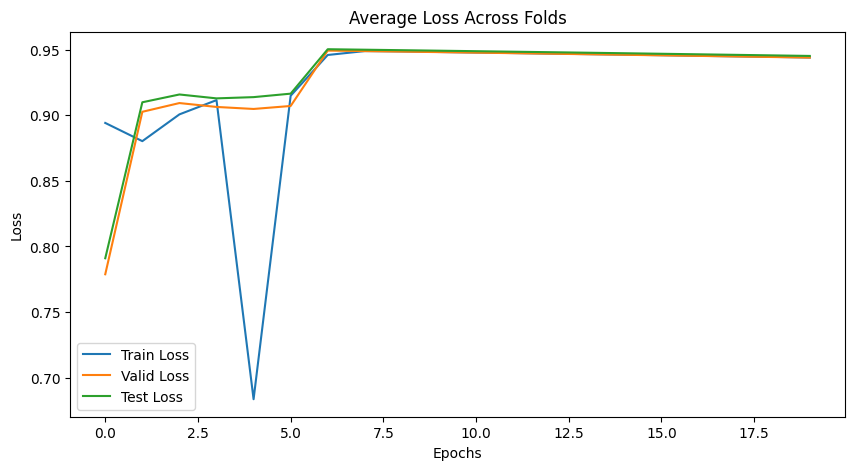

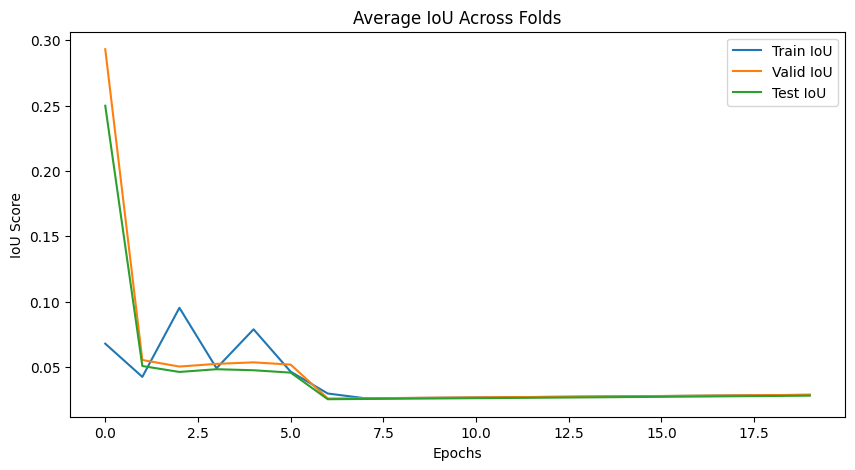

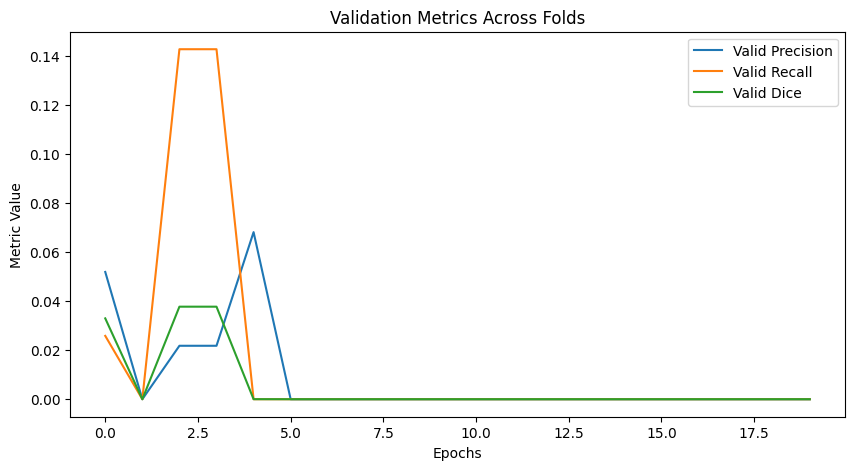

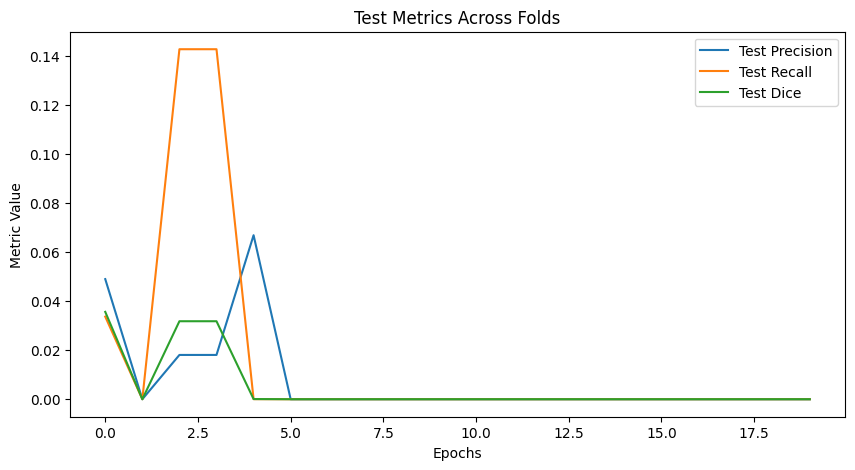

Metrics have been saved to 'Dataset1_model_PSPNet.csv'


/tmp/ipykernel_4813/1280507250.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_fpath)
/tmp/ipykernel_4813/3284842458.py:333: UserWar

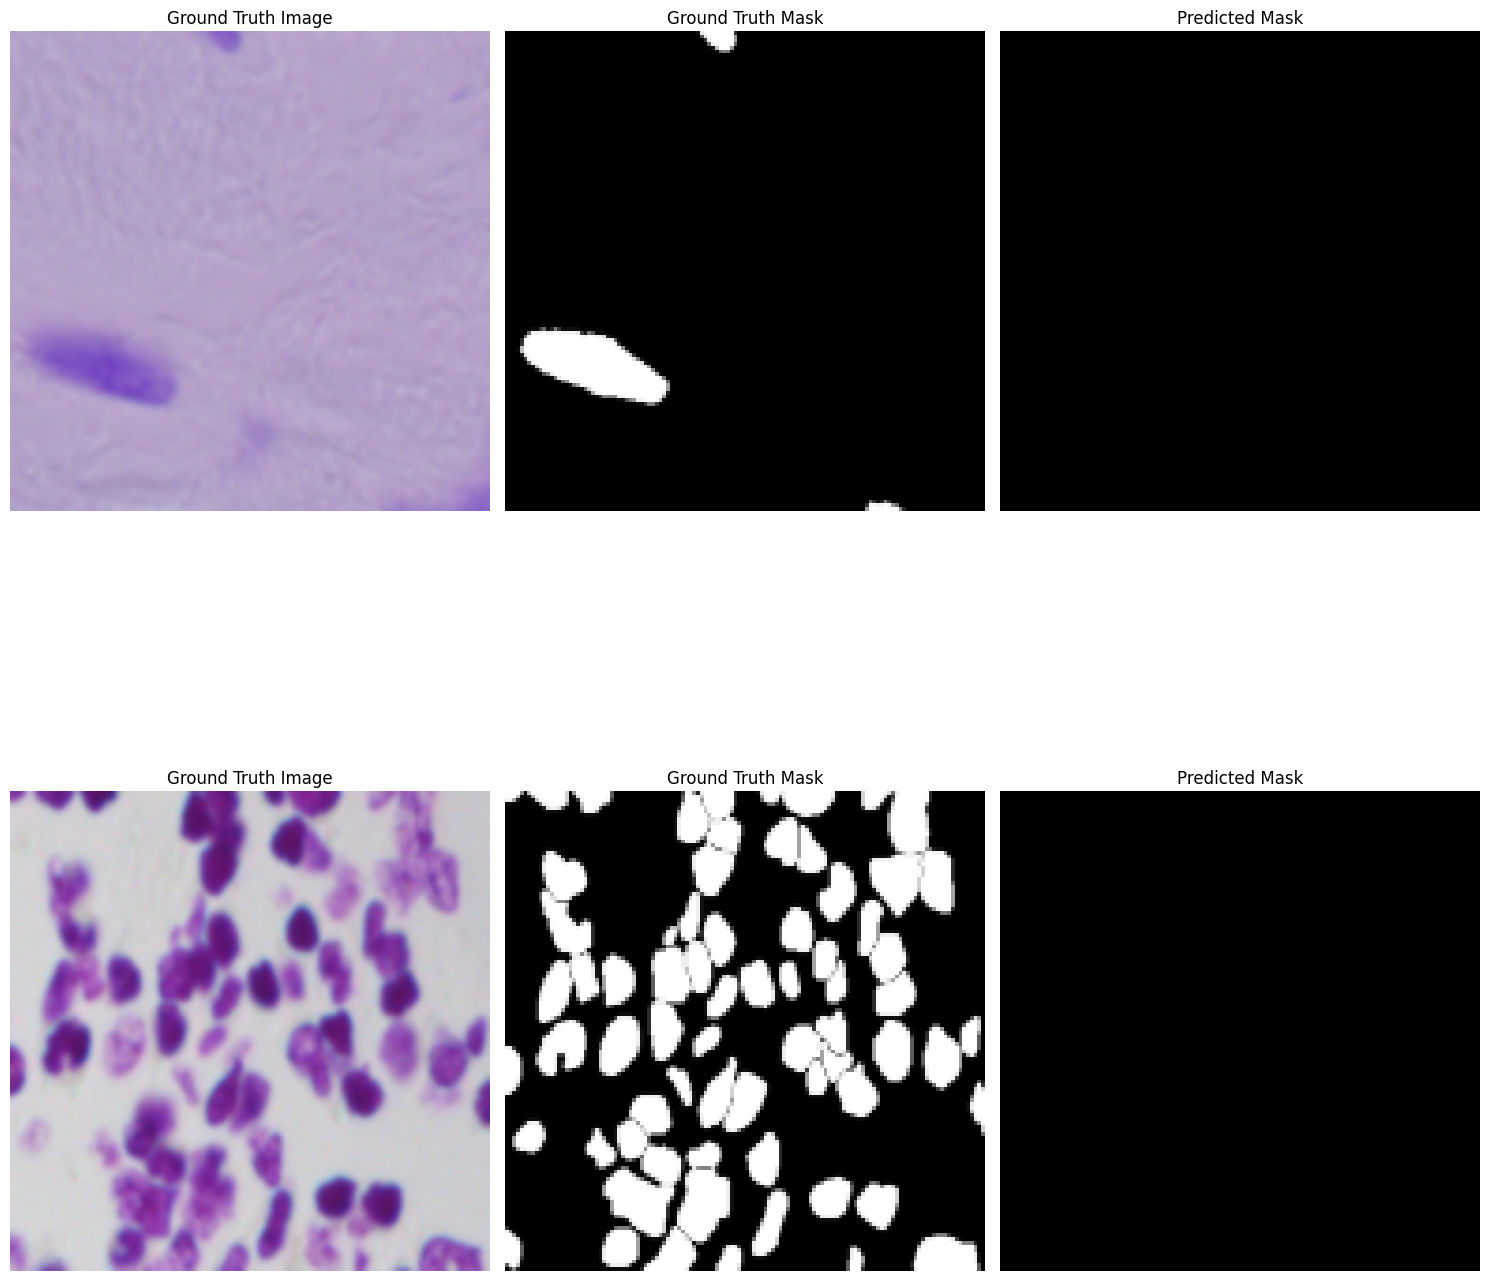

In [2]:
# Set up necessary directories and loss function
if not os.path.exists("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/PSPNet"):
    os.makedirs("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/PSPNet")

class PSPModule(nn.Module):
    def __init__(self, in_channels, out_channels, pool_sizes=[1, 2, 3, 6]):
        super(PSPModule, self).__init__()
        self.stages = nn.ModuleList([self._make_stage(in_channels, out_channels, size) for size in pool_sizes])
        self.bottleneck = nn.Conv2d(in_channels + len(pool_sizes) * out_channels, out_channels, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
    def _make_stage(self, in_channels, out_channels, size):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d(size),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        h, w = x.shape[2], x.shape[3]
        pyramids = [F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=True) for stage in self.stages]
        output = torch.cat([x] + pyramids, dim=1)
        return self.relu(self.bottleneck(output))

class PSPNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(PSPNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )
        self.psp = PSPModule(512, 256)
        self.final = nn.Sequential(
            nn.Conv2d(256, num_classes, kernel_size=1),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.psp(x)
        return self.final(x)

# Initialize model and optimizer for each fold
model = PSPNet(3,1)  # Assuming UNet is defined earlier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Parameters and Data
num_epochs = 20
k_folds = 7
checkpoint_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/PSPNet/chkpoint_'
best_model_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/PSPNet/bestmodel.pt'

# Initialize metrics
accuracy_metric = IoU()  # Assuming IoU is a metric you defined earlier
criterion = DiceLoss()  # Assuming DiceLoss is defined earlier
valid_loss_min = np.inf

# Store results
total_train_loss, total_train_score  = [], []
total_valid_loss, total_valid_score  = [], []
total_test_loss, total_test_score  = [], []

total_train_precision, total_valid_precision, total_test_precision = [], [], []
total_train_recall, total_valid_recall, total_test_recall = [], [], []
total_train_dice, total_valid_dice, total_test_dice = [], [], []

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 7-fold Cross Validation Loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"\n####### Fold {fold+1}/{k_folds} #######")

    # Create data subsets for current fold
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=16, shuffle=False)

    # Track losses and scores for each fold
    fold_train_loss, fold_train_score = [], []
    fold_valid_loss, fold_valid_score = [], []
    fold_test_loss, fold_test_score = [], []
    
    fold_train_precision, fold_valid_precision, fold_test_precision = [], [], []
    fold_train_recall, fold_valid_recall, fold_test_recall = [], [], []
    fold_train_dice, fold_valid_dice, fold_test_dice = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_score = [], []

        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for x_train, y_train in pbar:
            x_train = torch.autograd.Variable(x_train)
            y_train = torch.autograd.Variable(y_train)
            optimizer.zero_grad()
            output = model(x_train)

            # Compute Loss and Score
            loss = criterion(output, y_train)
            score = accuracy_metric(output, y_train)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_score.append(score.item())
            pbar.set_description(f"Epoch {epoch+1} - Loss: {loss.item():.4f}, IoU: {score:.4f}")

        fold_train_loss.append(np.mean(train_loss))
        fold_train_score.append(np.mean(train_score))

        # Validation Loop
        model.eval()
        valid_loss, valid_score= [], []

        valid_precision = []
        valid_recall = []
        valid_dice = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = torch.autograd.Variable(x_val)
                y_val = torch.autograd.Variable(y_val)
                output = model(x_val)

                # Compute Loss and Score
                loss = criterion(output, y_val)
                score = accuracy_metric(output, y_val)

                valid_loss.append(loss.item())
                valid_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_val_bin = (y_val > 0.5).float()

                valid_precision.append(precision_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_recall.append(recall_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_dice.append(f1_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_valid_loss.append(np.mean(valid_loss))
        fold_valid_score.append(np.mean(valid_score))
        
        fold_valid_precision.append(np.mean(valid_precision))
        fold_valid_recall.append(np.mean(valid_recall))
        fold_valid_dice.append(np.mean(valid_dice))

        # Test Loop
        test_loss = []
        test_score = []
        
        test_precision = []
        test_recall = []
        test_dice = []

        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test = torch.autograd.Variable(x_test)
                y_test = torch.autograd.Variable(y_test)
                output = model(x_test)

                # Compute Loss and Score
                loss = criterion(output, y_test)
                score = accuracy_metric(output, y_test)

                test_loss.append(loss.item())
                test_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_test_bin = (y_test > 0.5).float()

                test_precision.append(precision_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_recall.append(recall_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_dice.append(f1_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_test_loss.append(np.mean(test_loss))
        fold_test_score.append(np.mean(test_score))

        fold_test_precision.append(np.mean(test_precision))
        fold_test_recall.append(np.mean(test_recall))
        fold_test_dice.append(np.mean(test_dice))

        print(f"Fold {fold+1} - Epoch {epoch+1} - Train Loss: {np.mean(train_loss):.4f}, IoU: {np.mean(train_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Loss: {np.mean(valid_loss):.4f}, IoU: {np.mean(valid_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Loss: {np.mean(test_loss):.4f}, IoU: {np.mean(test_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Precision: {np.mean(valid_precision):.4f}, Recall: {np.mean(valid_recall):.4f}, Dice: {np.mean(valid_dice):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Precision: {np.mean(test_precision):.4f}, Recall: {np.mean(test_recall):.4f}, Dice: {np.mean(test_dice):.4f}")

        # Save checkpoint and best model
        checkpoint = {
            'epoch': epoch+1,
            'valid_loss_min': fold_valid_loss[-1],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        if fold_valid_loss[-1] <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {fold_valid_loss[-1]:.6f}). Saving model...')
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = fold_valid_loss[-1]

    # Append fold results
    total_train_loss.append(fold_train_loss)
    total_train_score.append(fold_train_score)
    total_valid_loss.append(fold_valid_loss)
    total_valid_score.append(fold_valid_score)
    total_test_loss.append(fold_test_loss)
    total_test_score.append(fold_test_score)

    total_train_precision.append(fold_train_precision)
    total_valid_precision.append(fold_valid_precision)
    total_test_precision.append(fold_test_precision)

    total_train_recall.append(fold_train_recall)
    total_valid_recall.append(fold_valid_recall)
    total_test_recall.append(fold_test_recall)

    total_train_dice.append(fold_train_dice)
    total_valid_dice.append(fold_valid_dice)
    total_test_dice.append(fold_test_dice)

# Calculate average results over all folds
avg_train_loss = np.mean(total_train_loss, axis=0)
avg_train_score = np.mean(total_train_score, axis=0)
avg_valid_loss = np.mean(total_valid_loss, axis=0)
avg_valid_score = np.mean(total_valid_score, axis=0)
avg_test_loss = np.mean(total_test_loss, axis=0)
avg_test_score = np.mean(total_test_score, axis=0)

avg_train_precision = np.mean(total_train_precision, axis=0)
avg_valid_precision = np.mean(total_valid_precision, axis=0)
avg_test_precision = np.mean(total_test_precision, axis=0)

avg_train_recall = np.mean(total_train_recall, axis=0)
avg_valid_recall = np.mean(total_valid_recall, axis=0)
avg_test_recall = np.mean(total_test_recall, axis=0)

avg_train_dice = np.mean(total_train_dice, axis=0)
avg_valid_dice = np.mean(total_valid_dice, axis=0)
avg_test_dice = np.mean(total_test_dice, axis=0)

# Plot final averaged results for losses and metrics
plt.figure(figsize=(10,5))
plt.plot(avg_train_loss, label="Train Loss")
plt.plot(avg_valid_loss, label="Valid Loss")
plt.plot(avg_test_loss, label="Test Loss")
plt.legend()
plt.title("Average Loss Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot IoU scores
plt.figure(figsize=(10,5))
plt.plot(avg_train_score, label="Train IoU")
plt.plot(avg_valid_score, label="Valid IoU")
plt.plot(avg_test_score, label="Test IoU")
plt.legend()
plt.title("Average IoU Across Folds")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.show()

# Plot Precision, Recall, and Dice scores for validation and test sets
plt.figure(figsize=(10,5))
plt.plot(avg_valid_precision, label="Valid Precision")
plt.plot(avg_valid_recall, label="Valid Recall")
plt.plot(avg_valid_dice, label="Valid Dice")
plt.legend()
plt.title("Validation Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(avg_test_precision, label="Test Precision")
plt.plot(avg_test_recall, label="Test Recall")
plt.plot(avg_test_dice, label="Test Dice")
plt.legend()
plt.title("Test Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

import pandas as pd

# Create a DataFrame to store results
columns = [
    'Fold', 'Epoch', 'Train_Loss', 'Train_IoU', 'Valid_Loss', 'Valid_IoU', 'Test_Loss', 'Test_IoU',
    'Valid_Precision', 'Valid_Recall', 'Valid_Dice', 'Test_Precision', 'Test_Recall', 'Test_Dice'
]

results = []

# Collect the results after all folds and epochs
for fold in range(k_folds):
    for epoch in range(num_epochs):
        results.append([
            fold + 1, epoch + 1,
            total_train_loss[fold][epoch], total_train_score[fold][epoch],
            total_valid_loss[fold][epoch], total_valid_score[fold][epoch],total_test_loss[fold][epoch], total_test_score[fold][epoch],
            total_valid_precision[fold][epoch], total_valid_recall[fold][epoch], total_valid_dice[fold][epoch],
            total_test_precision[fold][epoch], total_test_recall[fold][epoch], total_test_dice[fold][epoch]
        ])

# Convert results to a pandas DataFrame
df = pd.DataFrame(results, columns=columns)

# Save DataFrame to CSV
df.to_csv("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/PSPNet/Dataset1_model_PSPNet.csv", index=False)

print("Metrics have been saved to 'Dataset1_model_PSPNet.csv'")

#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

def visualize_predict(model, n_images):
  #model = model.eval()
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in test_loader:
        data = torch.autograd.Variable(data, volatile=True)
        mask = torch.autograd.Variable(mask, volatile=True)
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Ground Truth Image")
    ax[img_no, 1].set_title("Ground Truth Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
  plt.tight_layout()
  plt.show()
  
visualize_predict(model, 2)

# LinkNet


####### Fold 1/7 #######


Epoch 1 - Loss: 0.6956, IoU: 0.1795: 100%|██████| 36/36 [09:39<00:00, 16.11s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 1 - Train Loss: 5.9986, IoU: 0.3138
Fold 1 - Epoch 1 - Valid Loss: 0.4836, IoU: 0.3658
Fold 1 - Epoch 1 - Test Loss: 0.5362, IoU: 0.3287
Fold 1 - Epoch 1 - Valid Precision: 0.2981, Recall: 0.1856, Dice: 0.2204
Fold 1 - Epoch 1 - Test Precision: 0.2760, Recall: 0.2481, Dice: 0.2449
Validation loss decreased (inf --> 0.483632). Saving model...


Epoch 2 - Loss: 0.5150, IoU: 0.3201: 100%|██████| 36/36 [09:38<00:00, 16.08s/it]


Fold 1 - Epoch 2 - Train Loss: 0.4299, IoU: 0.4186
Fold 1 - Epoch 2 - Valid Loss: 0.4446, IoU: 0.3986
Fold 1 - Epoch 2 - Test Loss: 0.5036, IoU: 0.3574
Fold 1 - Epoch 2 - Valid Precision: 0.2728, Recall: 0.1998, Dice: 0.2205
Fold 1 - Epoch 2 - Test Precision: 0.2649, Recall: 0.2634, Dice: 0.2412
Validation loss decreased (0.483632 --> 0.444561). Saving model...


Epoch 3 - Loss: 0.5344, IoU: 0.3034: 100%|██████| 36/36 [09:38<00:00, 16.07s/it]


Fold 1 - Epoch 3 - Train Loss: 0.4199, IoU: 0.4287
Fold 1 - Epoch 3 - Valid Loss: 0.4473, IoU: 0.3956
Fold 1 - Epoch 3 - Test Loss: 0.5059, IoU: 0.3550
Fold 1 - Epoch 3 - Valid Precision: 0.2729, Recall: 0.2034, Dice: 0.2229
Fold 1 - Epoch 3 - Test Precision: 0.3206, Recall: 0.2661, Dice: 0.2415


Epoch 4 - Loss: 0.3524, IoU: 0.4789: 100%|██████| 36/36 [09:36<00:00, 16.03s/it]


Fold 1 - Epoch 4 - Train Loss: 0.4147, IoU: 0.4329
Fold 1 - Epoch 4 - Valid Loss: 0.4531, IoU: 0.3925
Fold 1 - Epoch 4 - Test Loss: 0.5117, IoU: 0.3507
Fold 1 - Epoch 4 - Valid Precision: 0.2857, Recall: 0.1997, Dice: 0.2259
Fold 1 - Epoch 4 - Test Precision: 0.3584, Recall: 0.2623, Dice: 0.2446


Epoch 5 - Loss: 0.6959, IoU: 0.1793: 100%|██████| 36/36 [09:39<00:00, 16.11s/it]


Fold 1 - Epoch 5 - Train Loss: 0.4309, IoU: 0.4180
Fold 1 - Epoch 5 - Valid Loss: 0.4153, IoU: 0.4262
Fold 1 - Epoch 5 - Test Loss: 0.4806, IoU: 0.3804
Fold 1 - Epoch 5 - Valid Precision: 0.2542, Recall: 0.2062, Dice: 0.2166
Fold 1 - Epoch 5 - Test Precision: 0.3324, Recall: 0.2680, Dice: 0.2339
Validation loss decreased (0.444561 --> 0.415271). Saving model...


Epoch 6 - Loss: 0.3695, IoU: 0.4604: 100%|██████| 36/36 [09:40<00:00, 16.13s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 6 - Train Loss: 0.4050, IoU: 0.4460
Fold 1 - Epoch 6 - Valid Loss: 0.4564, IoU: 0.3914
Fold 1 - Epoch 6 - Test Loss: 0.5136, IoU: 0.3504
Fold 1 - Epoch 6 - Valid Precision: 0.3069, Recall: 0.1914, Dice: 0.2271
Fold 1 - Epoch 6 - Test Precision: 0.2772, Recall: 0.2551, Dice: 0.2501


Epoch 7 - Loss: 0.3426, IoU: 0.4896: 100%|██████| 36/36 [09:39<00:00, 16.09s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 7 - Train Loss: 0.4116, IoU: 0.4396
Fold 1 - Epoch 7 - Valid Loss: 0.4242, IoU: 0.4197
Fold 1 - Epoch 7 - Test Loss: 0.4882, IoU: 0.3742
Fold 1 - Epoch 7 - Valid Precision: 0.2766, Recall: 0.2009, Dice: 0.2228
Fold 1 - Epoch 7 - Test Precision: 0.2536, Recall: 0.2641, Dice: 0.2424


Epoch 8 - Loss: 0.4805, IoU: 0.3509: 100%|██████| 36/36 [09:39<00:00, 16.08s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 8 - Train Loss: 0.4045, IoU: 0.4475
Fold 1 - Epoch 8 - Valid Loss: 0.4260, IoU: 0.4195
Fold 1 - Epoch 8 - Test Loss: 0.4893, IoU: 0.3739
Fold 1 - Epoch 8 - Valid Precision: 0.2848, Recall: 0.1994, Dice: 0.2251
Fold 1 - Epoch 8 - Test Precision: 0.2587, Recall: 0.2633, Dice: 0.2444


Epoch 9 - Loss: 0.6005, IoU: 0.2496: 100%|██████| 36/36 [09:38<00:00, 16.07s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 9 - Train Loss: 0.4071, IoU: 0.4465
Fold 1 - Epoch 9 - Valid Loss: 0.3858, IoU: 0.4581
Fold 1 - Epoch 9 - Test Loss: 0.4588, IoU: 0.4051
Fold 1 - Epoch 9 - Valid Precision: 0.2595, Recall: 0.2020, Dice: 0.2164
Fold 1 - Epoch 9 - Test Precision: 0.2400, Recall: 0.2658, Dice: 0.2362
Validation loss decreased (0.415271 --> 0.385822). Saving model...


Epoch 10 - Loss: 0.4184, IoU: 0.4100: 100%|█████| 36/36 [09:36<00:00, 16.00s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 10 - Train Loss: 0.3816, IoU: 0.4681
Fold 1 - Epoch 10 - Valid Loss: 0.4080, IoU: 0.4372
Fold 1 - Epoch 10 - Test Loss: 0.4748, IoU: 0.3892
Fold 1 - Epoch 10 - Valid Precision: 0.2816, Recall: 0.1992, Dice: 0.2238
Fold 1 - Epoch 10 - Test Precision: 0.2574, Recall: 0.2630, Dice: 0.2432


Epoch 11 - Loss: 0.6166, IoU: 0.2372: 100%|█████| 36/36 [09:38<00:00, 16.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 11 - Train Loss: 0.3742, IoU: 0.4755
Fold 1 - Epoch 11 - Valid Loss: 0.3954, IoU: 0.4503
Fold 1 - Epoch 11 - Test Loss: 0.4655, IoU: 0.3993
Fold 1 - Epoch 11 - Valid Precision: 0.2742, Recall: 0.1993, Dice: 0.2209
Fold 1 - Epoch 11 - Test Precision: 0.2527, Recall: 0.2634, Dice: 0.2411


Epoch 12 - Loss: 0.2233, IoU: 0.6349: 100%|█████| 36/36 [09:38<00:00, 16.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 12 - Train Loss: 0.3844, IoU: 0.4688
Fold 1 - Epoch 12 - Valid Loss: 0.4128, IoU: 0.4360
Fold 1 - Epoch 12 - Test Loss: 0.4788, IoU: 0.3873
Fold 1 - Epoch 12 - Valid Precision: 0.3092, Recall: 0.1914, Dice: 0.2276
Fold 1 - Epoch 12 - Test Precision: 0.2811, Recall: 0.2551, Dice: 0.2504


Epoch 13 - Loss: 0.5152, IoU: 0.3200: 100%|█████| 36/36 [09:38<00:00, 16.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 13 - Train Loss: 0.3670, IoU: 0.4881
Fold 1 - Epoch 13 - Valid Loss: 0.3845, IoU: 0.4614
Fold 1 - Epoch 13 - Test Loss: 0.4568, IoU: 0.4091
Fold 1 - Epoch 13 - Valid Precision: 0.2754, Recall: 0.1997, Dice: 0.2218
Fold 1 - Epoch 13 - Test Precision: 0.2534, Recall: 0.2642, Dice: 0.2415
Validation loss decreased (0.385822 --> 0.384455). Saving model...


Epoch 14 - Loss: -0.0721, IoU: 1.1555: 100%|████| 36/36 [09:39<00:00, 16.09s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 14 - Train Loss: 0.3908, IoU: 0.4730
Fold 1 - Epoch 14 - Valid Loss: 0.4532, IoU: 0.4025
Fold 1 - Epoch 14 - Test Loss: 0.5090, IoU: 0.3605
Fold 1 - Epoch 14 - Valid Precision: 0.3498, Recall: 0.1703, Dice: 0.2207
Fold 1 - Epoch 14 - Test Precision: 0.3144, Recall: 0.2324, Dice: 0.2508


Epoch 15 - Loss: 0.4428, IoU: 0.3862: 100%|█████| 36/36 [09:38<00:00, 16.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 15 - Train Loss: 0.4062, IoU: 0.4573
Fold 1 - Epoch 15 - Valid Loss: 0.3950, IoU: 0.4552
Fold 1 - Epoch 15 - Test Loss: 0.4641, IoU: 0.4040
Fold 1 - Epoch 15 - Valid Precision: 0.3113, Recall: 0.1894, Dice: 0.2275
Fold 1 - Epoch 15 - Test Precision: 0.2819, Recall: 0.2555, Dice: 0.2510


Epoch 16 - Loss: 0.1685, IoU: 0.7116: 100%|█████| 36/36 [09:40<00:00, 16.13s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 16 - Train Loss: 0.3396, IoU: 0.5157
Fold 1 - Epoch 16 - Valid Loss: 0.3860, IoU: 0.4648
Fold 1 - Epoch 16 - Test Loss: 0.4574, IoU: 0.4114
Fold 1 - Epoch 16 - Valid Precision: 0.2997, Recall: 0.1922, Dice: 0.2260
Fold 1 - Epoch 16 - Test Precision: 0.2714, Recall: 0.2586, Dice: 0.2477


Epoch 17 - Loss: 0.3745, IoU: 0.4550: 100%|█████| 36/36 [09:38<00:00, 16.08s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 17 - Train Loss: 0.3578, IoU: 0.5076
Fold 1 - Epoch 17 - Valid Loss: 0.3988, IoU: 0.4551
Fold 1 - Epoch 17 - Test Loss: 0.4654, IoU: 0.4048
Fold 1 - Epoch 17 - Valid Precision: 0.3239, Recall: 0.1843, Dice: 0.2271
Fold 1 - Epoch 17 - Test Precision: 0.2894, Recall: 0.2503, Dice: 0.2519


Epoch 18 - Loss: 0.6410, IoU: 0.2188: 100%|█████| 36/36 [09:38<00:00, 16.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 18 - Train Loss: 0.3562, IoU: 0.5043
Fold 1 - Epoch 18 - Valid Loss: 0.3572, IoU: 0.4960
Fold 1 - Epoch 18 - Test Loss: 0.4367, IoU: 0.4352
Fold 1 - Epoch 18 - Valid Precision: 0.2929, Recall: 0.1929, Dice: 0.2241
Fold 1 - Epoch 18 - Test Precision: 0.2659, Recall: 0.2591, Dice: 0.2452
Validation loss decreased (0.384455 --> 0.357226). Saving model...


Epoch 19 - Loss: 0.3401, IoU: 0.4924: 100%|█████| 36/36 [09:38<00:00, 16.07s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 19 - Train Loss: 0.3611, IoU: 0.5042
Fold 1 - Epoch 19 - Valid Loss: 0.3722, IoU: 0.4818
Fold 1 - Epoch 19 - Test Loss: 0.4460, IoU: 0.4261
Fold 1 - Epoch 19 - Valid Precision: 0.3173, Recall: 0.1874, Dice: 0.2280
Fold 1 - Epoch 19 - Test Precision: 0.2846, Recall: 0.2545, Dice: 0.2516


Epoch 20 - Loss: 0.2699, IoU: 0.5749: 100%|█████| 36/36 [09:40<00:00, 16.12s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 20 - Train Loss: 0.3307, IoU: 0.5390
Fold 1 - Epoch 20 - Valid Loss: 0.3611, IoU: 0.4955
Fold 1 - Epoch 20 - Test Loss: 0.4369, IoU: 0.4371
Fold 1 - Epoch 20 - Valid Precision: 0.3164, Recall: 0.1859, Dice: 0.2269
Fold 1 - Epoch 20 - Test Precision: 0.2818, Recall: 0.2544, Dice: 0.2509

####### Fold 2/7 #######


Epoch 1 - Loss: 0.6981, IoU: 0.1778: 100%|██████| 36/36 [09:37<00:00, 16.05s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 1 - Train Loss: 0.2742, IoU: 0.5944
Fold 2 - Epoch 1 - Valid Loss: 0.4016, IoU: 0.4541
Fold 2 - Epoch 1 - Test Loss: 0.4339, IoU: 0.4403
Fold 2 - Epoch 1 - Valid Precision: 0.2676, Recall: 0.1508, Dice: 0.1880
Fold 2 - Epoch 1 - Test Precision: 0.2768, Recall: 0.2570, Dice: 0.2492


Epoch 2 - Loss: 0.1380, IoU: 0.7575: 100%|██████| 36/36 [09:39<00:00, 16.09s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 2 - Train Loss: 0.3169, IoU: 0.5526
Fold 2 - Epoch 2 - Valid Loss: 0.3982, IoU: 0.4587
Fold 2 - Epoch 2 - Test Loss: 0.4274, IoU: 0.4486
Fold 2 - Epoch 2 - Valid Precision: 0.2745, Recall: 0.1501, Dice: 0.1885
Fold 2 - Epoch 2 - Test Precision: 0.2779, Recall: 0.2570, Dice: 0.2496


Epoch 3 - Loss: 0.5949, IoU: 0.2540: 100%|██████| 36/36 [09:36<00:00, 16.01s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 3 - Train Loss: 0.3140, IoU: 0.5599
Fold 2 - Epoch 3 - Valid Loss: 0.3842, IoU: 0.4753
Fold 2 - Epoch 3 - Test Loss: 0.4165, IoU: 0.4610
Fold 2 - Epoch 3 - Valid Precision: 0.2732, Recall: 0.1503, Dice: 0.1883
Fold 2 - Epoch 3 - Test Precision: 0.2758, Recall: 0.2570, Dice: 0.2492


Epoch 4 - Loss: 0.4294, IoU: 0.3992: 100%|██████| 36/36 [09:36<00:00, 16.01s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 4 - Train Loss: 0.2918, IoU: 0.5810
Fold 2 - Epoch 4 - Valid Loss: 0.3856, IoU: 0.4744
Fold 2 - Epoch 4 - Test Loss: 0.4172, IoU: 0.4618
Fold 2 - Epoch 4 - Valid Precision: 0.2770, Recall: 0.1497, Dice: 0.1885
Fold 2 - Epoch 4 - Test Precision: 0.2792, Recall: 0.2562, Dice: 0.2497


Epoch 5 - Loss: 0.3381, IoU: 0.4947: 100%|██████| 36/36 [09:37<00:00, 16.03s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 5 - Train Loss: 0.2817, IoU: 0.5938
Fold 2 - Epoch 5 - Valid Loss: 0.3808, IoU: 0.4807
Fold 2 - Epoch 5 - Test Loss: 0.4183, IoU: 0.4624
Fold 2 - Epoch 5 - Valid Precision: 0.2866, Recall: 0.1477, Dice: 0.1886
Fold 2 - Epoch 5 - Test Precision: 0.2875, Recall: 0.2517, Dice: 0.2512


Epoch 6 - Loss: 0.3325, IoU: 0.5009: 100%|██████| 36/36 [09:39<00:00, 16.10s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 6 - Train Loss: 0.2843, IoU: 0.6013
Fold 2 - Epoch 6 - Valid Loss: 0.3624, IoU: 0.5032
Fold 2 - Epoch 6 - Test Loss: 0.3990, IoU: 0.4842
Fold 2 - Epoch 6 - Valid Precision: 0.2750, Recall: 0.1499, Dice: 0.1882
Fold 2 - Epoch 6 - Test Precision: 0.2765, Recall: 0.2569, Dice: 0.2488


Epoch 7 - Loss: 0.0938, IoU: 0.8285: 100%|██████| 36/36 [09:43<00:00, 16.21s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 7 - Train Loss: 0.2716, IoU: 0.6117
Fold 2 - Epoch 7 - Valid Loss: 0.3886, IoU: 0.4728
Fold 2 - Epoch 7 - Test Loss: 0.4271, IoU: 0.4567
Fold 2 - Epoch 7 - Valid Precision: 0.3077, Recall: 0.1431, Dice: 0.1888
Fold 2 - Epoch 7 - Test Precision: 0.3070, Recall: 0.2411, Dice: 0.2544


Epoch 8 - Loss: 0.2054, IoU: 0.6592: 100%|██████| 36/36 [09:39<00:00, 16.08s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 8 - Train Loss: 0.2643, IoU: 0.6176
Fold 2 - Epoch 8 - Valid Loss: 0.3779, IoU: 0.4861
Fold 2 - Epoch 8 - Test Loss: 0.4139, IoU: 0.4717
Fold 2 - Epoch 8 - Valid Precision: 0.3013, Recall: 0.1447, Dice: 0.1891
Fold 2 - Epoch 8 - Test Precision: 0.2997, Recall: 0.2470, Dice: 0.2543


Epoch 9 - Loss: 0.1086, IoU: 0.8040: 100%|██████| 36/36 [09:39<00:00, 16.11s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 9 - Train Loss: 0.2483, IoU: 0.6389
Fold 2 - Epoch 9 - Valid Loss: 0.3574, IoU: 0.5117
Fold 2 - Epoch 9 - Test Loss: 0.3895, IoU: 0.4987
Fold 2 - Epoch 9 - Valid Precision: 0.2835, Recall: 0.1491, Dice: 0.1888
Fold 2 - Epoch 9 - Test Precision: 0.2773, Recall: 0.2577, Dice: 0.2495


Epoch 10 - Loss: 0.3956, IoU: 0.4331: 100%|█████| 36/36 [09:40<00:00, 16.12s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 10 - Train Loss: 0.2436, IoU: 0.6482
Fold 2 - Epoch 10 - Valid Loss: 0.3528, IoU: 0.5186
Fold 2 - Epoch 10 - Test Loss: 0.3946, IoU: 0.4955
Fold 2 - Epoch 10 - Valid Precision: 0.2960, Recall: 0.1461, Dice: 0.1890
Fold 2 - Epoch 10 - Test Precision: 0.2931, Recall: 0.2494, Dice: 0.2524
Validation loss decreased (0.357226 --> 0.352829). Saving model...


Epoch 11 - Loss: 0.5081, IoU: 0.3261: 100%|█████| 36/36 [09:40<00:00, 16.12s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 11 - Train Loss: 0.2641, IoU: 0.6379
Fold 2 - Epoch 11 - Valid Loss: 0.3500, IoU: 0.5229
Fold 2 - Epoch 11 - Test Loss: 0.3929, IoU: 0.4991
Fold 2 - Epoch 11 - Valid Precision: 0.2971, Recall: 0.1457, Dice: 0.1889
Fold 2 - Epoch 11 - Test Precision: 0.2941, Recall: 0.2483, Dice: 0.2523
Validation loss decreased (0.352829 --> 0.349982). Saving model...


Epoch 12 - Loss: 0.0424, IoU: 0.9187: 100%|█████| 36/36 [09:41<00:00, 16.16s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 12 - Train Loss: 0.2193, IoU: 0.6841
Fold 2 - Epoch 12 - Valid Loss: 0.3597, IoU: 0.5111
Fold 2 - Epoch 12 - Test Loss: 0.3961, IoU: 0.4971
Fold 2 - Epoch 12 - Valid Precision: 0.3084, Recall: 0.1439, Dice: 0.1894
Fold 2 - Epoch 12 - Test Precision: 0.3021, Recall: 0.2467, Dice: 0.2549


Epoch 13 - Loss: 0.1537, IoU: 0.7335: 100%|█████| 36/36 [09:40<00:00, 16.13s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 13 - Train Loss: 0.2252, IoU: 0.6725
Fold 2 - Epoch 13 - Valid Loss: 0.3480, IoU: 0.5272
Fold 2 - Epoch 13 - Test Loss: 0.3970, IoU: 0.4981
Fold 2 - Epoch 13 - Valid Precision: 0.3121, Recall: 0.1416, Dice: 0.1881
Fold 2 - Epoch 13 - Test Precision: 0.3101, Recall: 0.2394, Dice: 0.2543
Validation loss decreased (0.349982 --> 0.348043). Saving model...


Epoch 14 - Loss: 0.2975, IoU: 0.5415: 100%|█████| 36/36 [09:38<00:00, 16.07s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 14 - Train Loss: 0.2279, IoU: 0.6866
Fold 2 - Epoch 14 - Valid Loss: 0.3209, IoU: 0.5636
Fold 2 - Epoch 14 - Test Loss: 0.3696, IoU: 0.5296
Fold 2 - Epoch 14 - Valid Precision: 0.2989, Recall: 0.1458, Dice: 0.1889
Fold 2 - Epoch 14 - Test Precision: 0.2943, Recall: 0.2489, Dice: 0.2527
Validation loss decreased (0.348043 --> 0.320948). Saving model...


Epoch 15 - Loss: -0.0558, IoU: 1.1182: 100%|████| 36/36 [09:37<00:00, 16.03s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 15 - Train Loss: 0.2157, IoU: 0.6975
Fold 2 - Epoch 15 - Valid Loss: 0.3106, IoU: 0.5788
Fold 2 - Epoch 15 - Test Loss: 0.3627, IoU: 0.5409
Fold 2 - Epoch 15 - Valid Precision: 0.2989, Recall: 0.1450, Dice: 0.1881
Fold 2 - Epoch 15 - Test Precision: 0.2930, Recall: 0.2479, Dice: 0.2515
Validation loss decreased (0.320948 --> 0.310588). Saving model...


Epoch 16 - Loss: -0.0806, IoU: 1.1753: 100%|████| 36/36 [09:37<00:00, 16.03s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 16 - Train Loss: 0.2192, IoU: 0.6989
Fold 2 - Epoch 16 - Valid Loss: 0.3131, IoU: 0.5758
Fold 2 - Epoch 16 - Test Loss: 0.3600, IoU: 0.5447
Fold 2 - Epoch 16 - Valid Precision: 0.2970, Recall: 0.1459, Dice: 0.1887
Fold 2 - Epoch 16 - Test Precision: 0.2902, Recall: 0.2510, Dice: 0.2519


Epoch 17 - Loss: -0.1286, IoU: 1.2952: 100%|████| 36/36 [09:39<00:00, 16.09s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 17 - Train Loss: 0.2024, IoU: 0.7160
Fold 2 - Epoch 17 - Valid Loss: 0.3052, IoU: 0.5891
Fold 2 - Epoch 17 - Test Loss: 0.3655, IoU: 0.5433
Fold 2 - Epoch 17 - Valid Precision: 0.3101, Recall: 0.1414, Dice: 0.1872
Fold 2 - Epoch 17 - Test Precision: 0.3040, Recall: 0.2392, Dice: 0.2516
Validation loss decreased (0.310588 --> 0.305182). Saving model...


Epoch 18 - Loss: -0.3100, IoU: 1.8984: 100%|████| 36/36 [09:38<00:00, 16.07s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 18 - Train Loss: 0.2151, IoU: 0.7086
Fold 2 - Epoch 18 - Valid Loss: 0.2999, IoU: 0.5980
Fold 2 - Epoch 18 - Test Loss: 0.3621, IoU: 0.5507
Fold 2 - Epoch 18 - Valid Precision: 0.3147, Recall: 0.1403, Dice: 0.1868
Fold 2 - Epoch 18 - Test Precision: 0.3083, Recall: 0.2351, Dice: 0.2506
Validation loss decreased (0.305182 --> 0.299941). Saving model...


Epoch 19 - Loss: 0.1560, IoU: 0.7302: 100%|█████| 36/36 [09:36<00:00, 16.02s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 19 - Train Loss: 0.1933, IoU: 0.7400
Fold 2 - Epoch 19 - Valid Loss: 0.3026, IoU: 0.5957
Fold 2 - Epoch 19 - Test Loss: 0.3626, IoU: 0.5516
Fold 2 - Epoch 19 - Valid Precision: 0.3231, Recall: 0.1390, Dice: 0.1872
Fold 2 - Epoch 19 - Test Precision: 0.3180, Recall: 0.2327, Dice: 0.2525


Epoch 20 - Loss: 0.0783, IoU: 0.8548: 100%|█████| 36/36 [09:39<00:00, 16.08s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Epoch 20 - Train Loss: 0.1907, IoU: 0.7505
Fold 2 - Epoch 20 - Valid Loss: 0.2686, IoU: 0.6451
Fold 2 - Epoch 20 - Test Loss: 0.3307, IoU: 0.5872
Fold 2 - Epoch 20 - Valid Precision: 0.2937, Recall: 0.1459, Dice: 0.1876
Fold 2 - Epoch 20 - Test Precision: 0.2865, Recall: 0.2498, Dice: 0.2495
Validation loss decreased (0.299941 --> 0.268564). Saving model...

####### Fold 3/7 #######


Epoch 1 - Loss: 0.2591, IoU: 0.5885: 100%|██████| 36/36 [09:33<00:00, 15.93s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 1 - Train Loss: 0.1996, IoU: 0.7487
Fold 3 - Epoch 1 - Valid Loss: 0.4851, IoU: 0.4123
Fold 3 - Epoch 1 - Test Loss: 0.3307, IoU: 0.5878
Fold 3 - Epoch 1 - Valid Precision: 0.2482, Recall: 0.1773, Dice: 0.1780
Fold 3 - Epoch 1 - Test Precision: 0.2899, Recall: 0.2483, Dice: 0.2505


Epoch 2 - Loss: 0.2996, IoU: 0.5389: 100%|██████| 36/36 [09:38<00:00, 16.07s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 2 - Train Loss: 0.1713, IoU: 0.7920
Fold 3 - Epoch 2 - Valid Loss: 0.4783, IoU: 0.4192
Fold 3 - Epoch 2 - Test Loss: 0.3256, IoU: 0.5952
Fold 3 - Epoch 2 - Valid Precision: 0.2353, Recall: 0.1807, Dice: 0.1786
Fold 3 - Epoch 2 - Test Precision: 0.2828, Recall: 0.2537, Dice: 0.2499


Epoch 3 - Loss: 0.0361, IoU: 0.9304: 100%|██████| 36/36 [09:37<00:00, 16.04s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 3 - Train Loss: 0.1054, IoU: 0.8568
Fold 3 - Epoch 3 - Valid Loss: 0.4901, IoU: 0.4156
Fold 3 - Epoch 3 - Test Loss: 0.3466, IoU: 0.5804
Fold 3 - Epoch 3 - Valid Precision: 0.2790, Recall: 0.1694, Dice: 0.1780
Fold 3 - Epoch 3 - Test Precision: 0.3157, Recall: 0.2343, Dice: 0.2528


Epoch 4 - Loss: 0.2953, IoU: 0.5440: 100%|██████| 36/36 [09:38<00:00, 16.08s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 4 - Train Loss: 0.1173, IoU: 0.8585
Fold 3 - Epoch 4 - Valid Loss: 0.4737, IoU: 0.4286
Fold 3 - Epoch 4 - Test Loss: 0.3143, IoU: 0.6136
Fold 3 - Epoch 4 - Valid Precision: 0.2404, Recall: 0.1801, Dice: 0.1786
Fold 3 - Epoch 4 - Test Precision: 0.2826, Recall: 0.2537, Dice: 0.2497


Epoch 5 - Loss: 0.4614, IoU: 0.3686: 100%|██████| 36/36 [09:36<00:00, 16.01s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 5 - Train Loss: 0.1565, IoU: 0.8218
Fold 3 - Epoch 5 - Valid Loss: 0.4740, IoU: 0.4278
Fold 3 - Epoch 5 - Test Loss: 0.3130, IoU: 0.6169
Fold 3 - Epoch 5 - Valid Precision: 0.2371, Recall: 0.1811, Dice: 0.1792
Fold 3 - Epoch 5 - Test Precision: 0.2834, Recall: 0.2545, Dice: 0.2503


Epoch 6 - Loss: -0.1742, IoU: 1.4219: 100%|█████| 36/36 [09:38<00:00, 16.07s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 6 - Train Loss: 0.1366, IoU: 0.8445
Fold 3 - Epoch 6 - Valid Loss: 0.4715, IoU: 0.4402
Fold 3 - Epoch 6 - Test Loss: 0.3146, IoU: 0.6240
Fold 3 - Epoch 6 - Valid Precision: 0.2648, Recall: 0.1726, Dice: 0.1783
Fold 3 - Epoch 6 - Test Precision: 0.3029, Recall: 0.2401, Dice: 0.2510


Epoch 7 - Loss: -0.0108, IoU: 1.0218: 100%|█████| 36/36 [09:38<00:00, 16.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 7 - Train Loss: 0.1626, IoU: 0.8188
Fold 3 - Epoch 7 - Valid Loss: 0.4681, IoU: 0.4471
Fold 3 - Epoch 7 - Test Loss: 0.3071, IoU: 0.6358
Fold 3 - Epoch 7 - Valid Precision: 0.2767, Recall: 0.1704, Dice: 0.1774
Fold 3 - Epoch 7 - Test Precision: 0.3057, Recall: 0.2374, Dice: 0.2500


Epoch 8 - Loss: 0.0028, IoU: 0.9945: 100%|██████| 36/36 [09:38<00:00, 16.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 8 - Train Loss: 0.0743, IoU: 0.9323
Fold 3 - Epoch 8 - Valid Loss: 0.4715, IoU: 0.4459
Fold 3 - Epoch 8 - Test Loss: 0.3122, IoU: 0.6332
Fold 3 - Epoch 8 - Valid Precision: 0.2808, Recall: 0.1697, Dice: 0.1783
Fold 3 - Epoch 8 - Test Precision: 0.3120, Recall: 0.2353, Dice: 0.2510


Epoch 9 - Loss: 0.2977, IoU: 0.5412: 100%|██████| 36/36 [09:37<00:00, 16.04s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 9 - Train Loss: 0.1145, IoU: 0.8854
Fold 3 - Epoch 9 - Valid Loss: 0.4590, IoU: 0.4615
Fold 3 - Epoch 9 - Test Loss: 0.3022, IoU: 0.6478
Fold 3 - Epoch 9 - Valid Precision: 0.2770, Recall: 0.1691, Dice: 0.1770
Fold 3 - Epoch 9 - Test Precision: 0.3089, Recall: 0.2361, Dice: 0.2503


Epoch 10 - Loss: -0.4332, IoU: 2.5284: 100%|████| 36/36 [09:36<00:00, 16.02s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 10 - Train Loss: 0.0790, IoU: 0.9448
Fold 3 - Epoch 10 - Valid Loss: 0.4624, IoU: 0.4638
Fold 3 - Epoch 10 - Test Loss: 0.3041, IoU: 0.6516
Fold 3 - Epoch 10 - Valid Precision: 0.2888, Recall: 0.1650, Dice: 0.1775
Fold 3 - Epoch 10 - Test Precision: 0.3189, Recall: 0.2279, Dice: 0.2489


Epoch 11 - Loss: -0.2460, IoU: 1.6526: 100%|████| 36/36 [09:39<00:00, 16.09s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 11 - Train Loss: 0.0704, IoU: 0.9559
Fold 3 - Epoch 11 - Valid Loss: 0.4657, IoU: 0.4619
Fold 3 - Epoch 11 - Test Loss: 0.3162, IoU: 0.6405
Fold 3 - Epoch 11 - Valid Precision: 0.3035, Recall: 0.1600, Dice: 0.1770
Fold 3 - Epoch 11 - Test Precision: 0.3356, Recall: 0.2225, Dice: 0.2513


Epoch 12 - Loss: -0.2181, IoU: 1.5579: 100%|████| 36/36 [09:38<00:00, 16.06s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 12 - Train Loss: 0.0469, IoU: 0.9969
Fold 3 - Epoch 12 - Valid Loss: 0.4784, IoU: 0.4552
Fold 3 - Epoch 12 - Test Loss: 0.3408, IoU: 0.6220
Fold 3 - Epoch 12 - Valid Precision: 0.3197, Recall: 0.1519, Dice: 0.1748
Fold 3 - Epoch 12 - Test Precision: 0.3667, Recall: 0.2058, Dice: 0.2467


Epoch 13 - Loss: 0.0722, IoU: 0.8653: 100%|█████| 36/36 [09:37<00:00, 16.04s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 13 - Train Loss: 0.0506, IoU: 0.9808
Fold 3 - Epoch 13 - Valid Loss: 0.4767, IoU: 0.4580
Fold 3 - Epoch 13 - Test Loss: 0.3220, IoU: 0.6408
Fold 3 - Epoch 13 - Valid Precision: 0.3245, Recall: 0.1512, Dice: 0.1747
Fold 3 - Epoch 13 - Test Precision: 0.3634, Recall: 0.2069, Dice: 0.2457


Epoch 14 - Loss: -0.3718, IoU: 2.1837: 100%|████| 36/36 [09:38<00:00, 16.07s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 14 - Train Loss: 0.0541, IoU: 1.0058
Fold 3 - Epoch 14 - Valid Loss: 0.4651, IoU: 0.4791
Fold 3 - Epoch 14 - Test Loss: 0.3208, IoU: 0.6559
Fold 3 - Epoch 14 - Valid Precision: 0.3270, Recall: 0.1504, Dice: 0.1736
Fold 3 - Epoch 14 - Test Precision: 0.3708, Recall: 0.2037, Dice: 0.2447


Epoch 15 - Loss: 0.1365, IoU: 0.7598: 100%|█████| 36/36 [09:40<00:00, 16.13s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 15 - Train Loss: 0.0311, IoU: 1.0417
Fold 3 - Epoch 15 - Valid Loss: 0.4566, IoU: 0.4836
Fold 3 - Epoch 15 - Test Loss: 0.3006, IoU: 0.6749
Fold 3 - Epoch 15 - Valid Precision: 0.3184, Recall: 0.1557, Dice: 0.1759
Fold 3 - Epoch 15 - Test Precision: 0.3485, Recall: 0.2162, Dice: 0.2496


Epoch 16 - Loss: 0.2260, IoU: 0.6313: 100%|█████| 36/36 [09:37<00:00, 16.04s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 16 - Train Loss: 0.0606, IoU: 1.0004
Fold 3 - Epoch 16 - Valid Loss: 0.4550, IoU: 0.4901
Fold 3 - Epoch 16 - Test Loss: 0.2892, IoU: 0.6919
Fold 3 - Epoch 16 - Valid Precision: 0.3199, Recall: 0.1499, Dice: 0.1723
Fold 3 - Epoch 16 - Test Precision: 0.3621, Recall: 0.2057, Dice: 0.2438


Epoch 17 - Loss: 0.4187, IoU: 0.4097: 100%|█████| 36/36 [09:37<00:00, 16.03s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 17 - Train Loss: 0.0448, IoU: 1.0258
Fold 3 - Epoch 17 - Valid Loss: 0.4475, IoU: 0.4944
Fold 3 - Epoch 17 - Test Loss: 0.2692, IoU: 0.7172
Fold 3 - Epoch 17 - Valid Precision: 0.2885, Recall: 0.1677, Dice: 0.1790
Fold 3 - Epoch 17 - Test Precision: 0.3178, Recall: 0.2331, Dice: 0.2518


Epoch 18 - Loss: -0.0295, IoU: 1.0608: 100%|████| 36/36 [09:34<00:00, 15.97s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 18 - Train Loss: 0.0348, IoU: 1.0558
Fold 3 - Epoch 18 - Valid Loss: 0.4423, IoU: 0.5035
Fold 3 - Epoch 18 - Test Loss: 0.2629, IoU: 0.7254
Fold 3 - Epoch 18 - Valid Precision: 0.2934, Recall: 0.1656, Dice: 0.1772
Fold 3 - Epoch 18 - Test Precision: 0.3172, Recall: 0.2324, Dice: 0.2504


Epoch 19 - Loss: -0.2442, IoU: 1.6462: 100%|████| 36/36 [09:35<00:00, 15.99s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 - Epoch 19 - Train Loss: 0.0681, IoU: 1.0111
Fold 3 - Epoch 19 - Valid Loss: 0.4563, IoU: 0.4898
Fold 3 - Epoch 19 - Test Loss: 0.2625, IoU: 0.7238
Fold 3 - Epoch 19 - Valid Precision: 0.3117, Recall: 0.1594, Dice: 0.1763
Fold 3 - Epoch 19 - Test Precision: 0.3314, Recall: 0.2191, Dice: 0.2462


Epoch 20 - Loss: -0.0166, IoU: 1.0337: 100%|████| 36/36 [09:38<00:00, 16.07s/it]


Fold 3 - Epoch 20 - Train Loss: -0.0264, IoU: 1.1425
Fold 3 - Epoch 20 - Valid Loss: 0.4348, IoU: 0.5099
Fold 3 - Epoch 20 - Test Loss: 0.2879, IoU: 0.7058
Fold 3 - Epoch 20 - Valid Precision: 0.5468, Recall: 0.1489, Dice: 0.1887
Fold 3 - Epoch 20 - Test Precision: 0.4693, Recall: 0.1897, Dice: 0.2390

####### Fold 4/7 #######


Epoch 1 - Loss: 0.3846, IoU: 0.4445: 100%|██████| 36/36 [09:41<00:00, 16.14s/it]


Fold 4 - Epoch 1 - Train Loss: 0.0515, IoU: 1.0310
Fold 4 - Epoch 1 - Valid Loss: 0.1091, IoU: 0.8672
Fold 4 - Epoch 1 - Test Loss: 0.3337, IoU: 0.6584
Fold 4 - Epoch 1 - Valid Precision: 0.4396, Recall: 0.1989, Dice: 0.2603
Fold 4 - Epoch 1 - Test Precision: 0.5066, Recall: 0.1728, Dice: 0.2327
Validation loss decreased (0.268564 --> 0.109143). Saving model...


Epoch 2 - Loss: -0.0737, IoU: 1.1592: 100%|█████| 36/36 [09:40<00:00, 16.12s/it]


Fold 4 - Epoch 2 - Train Loss: 0.0185, IoU: 1.0661
Fold 4 - Epoch 2 - Valid Loss: -0.0051, IoU: 1.0492
Fold 4 - Epoch 2 - Test Loss: 0.2380, IoU: 0.7646
Fold 4 - Epoch 2 - Valid Precision: 0.3476, Recall: 0.2393, Dice: 0.2701
Fold 4 - Epoch 2 - Test Precision: 0.4458, Recall: 0.2310, Dice: 0.2549
Validation loss decreased (0.109143 --> -0.005127). Saving model...


Epoch 3 - Loss: -0.0637, IoU: 1.1360: 100%|█████| 36/36 [09:40<00:00, 16.13s/it]


Fold 4 - Epoch 3 - Train Loss: -0.0061, IoU: 1.1276
Fold 4 - Epoch 3 - Valid Loss: 0.0237, IoU: 1.0193
Fold 4 - Epoch 3 - Test Loss: 0.2568, IoU: 0.7464
Fold 4 - Epoch 3 - Valid Precision: 0.4046, Recall: 0.2225, Dice: 0.2725
Fold 4 - Epoch 3 - Test Precision: 0.4918, Recall: 0.2058, Dice: 0.2537


Epoch 4 - Loss: 0.0589, IoU: 0.8887: 100%|██████| 36/36 [09:41<00:00, 16.15s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 - Epoch 4 - Train Loss: 0.0025, IoU: 1.1196
Fold 4 - Epoch 4 - Valid Loss: -0.0066, IoU: 1.0585
Fold 4 - Epoch 4 - Test Loss: 0.2505, IoU: 0.7594
Fold 4 - Epoch 4 - Valid Precision: 0.3655, Recall: 0.2212, Dice: 0.2619
Fold 4 - Epoch 4 - Test Precision: 0.3455, Recall: 0.2160, Dice: 0.2467
Validation loss decreased (-0.005127 --> -0.006629). Saving model...


Epoch 5 - Loss: 0.0907, IoU: 0.8336: 100%|██████| 36/36 [09:40<00:00, 16.13s/it]


Fold 4 - Epoch 5 - Train Loss: -0.0193, IoU: 1.1339
Fold 4 - Epoch 5 - Valid Loss: -0.0232, IoU: 1.0866
Fold 4 - Epoch 5 - Test Loss: 0.1971, IoU: 0.8163
Fold 4 - Epoch 5 - Valid Precision: 0.3525, Recall: 0.2528, Dice: 0.2820
Fold 4 - Epoch 5 - Test Precision: 0.4245, Recall: 0.2466, Dice: 0.2683
Validation loss decreased (-0.006629 --> -0.023192). Saving model...


Epoch 6 - Loss: 0.1079, IoU: 0.8052: 100%|██████| 36/36 [09:39<00:00, 16.09s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 - Epoch 6 - Train Loss: -0.0127, IoU: 1.1287
Fold 4 - Epoch 6 - Valid Loss: -0.0212, IoU: 1.0756
Fold 4 - Epoch 6 - Test Loss: 0.2213, IoU: 0.8005
Fold 4 - Epoch 6 - Valid Precision: 0.3537, Recall: 0.2260, Dice: 0.2588
Fold 4 - Epoch 6 - Test Precision: 0.3276, Recall: 0.2202, Dice: 0.2445


Epoch 7 - Loss: -0.1427, IoU: 1.3329: 100%|█████| 36/36 [09:39<00:00, 16.11s/it]


Fold 4 - Epoch 7 - Train Loss: -0.0160, IoU: 1.1682
Fold 4 - Epoch 7 - Valid Loss: -0.0079, IoU: 1.0820
Fold 4 - Epoch 7 - Test Loss: 0.1664, IoU: 0.8606
Fold 4 - Epoch 7 - Valid Precision: 0.4268, Recall: 0.2608, Dice: 0.3092
Fold 4 - Epoch 7 - Test Precision: 0.4509, Recall: 0.2495, Dice: 0.3052


Epoch 8 - Loss: -0.1208, IoU: 1.2749: 100%|█████| 36/36 [09:40<00:00, 16.13s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 - Epoch 8 - Train Loss: -0.0549, IoU: 1.2389
Fold 4 - Epoch 8 - Valid Loss: 0.1164, IoU: 0.9618
Fold 4 - Epoch 8 - Test Loss: 0.3645, IoU: 0.6624
Fold 4 - Epoch 8 - Valid Precision: 0.5051, Recall: 0.1538, Dice: 0.2162
Fold 4 - Epoch 8 - Test Precision: 0.4825, Recall: 0.1229, Dice: 0.1781


Epoch 9 - Loss: 0.4153, IoU: 0.4132: 100%|██████| 36/36 [09:38<00:00, 16.06s/it]


Fold 4 - Epoch 9 - Train Loss: -0.0467, IoU: 1.2558
Fold 4 - Epoch 9 - Valid Loss: 0.0339, IoU: 1.0341
Fold 4 - Epoch 9 - Test Loss: 0.3008, IoU: 0.7693
Fold 4 - Epoch 9 - Valid Precision: 0.4581, Recall: 0.1784, Dice: 0.2417
Fold 4 - Epoch 9 - Test Precision: 0.5649, Recall: 0.1552, Dice: 0.2172


Epoch 10 - Loss: -0.1207, IoU: 1.2745: 100%|████| 36/36 [09:39<00:00, 16.08s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 - Epoch 10 - Train Loss: -0.0394, IoU: 1.2490
Fold 4 - Epoch 10 - Valid Loss: 0.0406, IoU: 1.0485
Fold 4 - Epoch 10 - Test Loss: 0.3358, IoU: 0.7247
Fold 4 - Epoch 10 - Valid Precision: 0.4972, Recall: 0.1658, Dice: 0.2329
Fold 4 - Epoch 10 - Test Precision: 0.4800, Recall: 0.1350, Dice: 0.1919


Epoch 11 - Loss: 0.0076, IoU: 0.9849: 100%|█████| 36/36 [09:40<00:00, 16.12s/it]


Fold 4 - Epoch 11 - Train Loss: -0.0753, IoU: 1.3287
Fold 4 - Epoch 11 - Valid Loss: -0.0519, IoU: 1.1764
Fold 4 - Epoch 11 - Test Loss: 0.1625, IoU: 0.9152
Fold 4 - Epoch 11 - Valid Precision: 0.4475, Recall: 0.2969, Dice: 0.3433
Fold 4 - Epoch 11 - Test Precision: 0.4870, Recall: 0.2407, Dice: 0.2876
Validation loss decreased (-0.023192 --> -0.051910). Saving model...


Epoch 12 - Loss: -0.2653, IoU: 1.7221: 100%|████| 36/36 [09:39<00:00, 16.10s/it]


Fold 4 - Epoch 12 - Train Loss: -0.1331, IoU: 1.4423
Fold 4 - Epoch 12 - Valid Loss: -0.0661, IoU: 1.2006
Fold 4 - Epoch 12 - Test Loss: 0.1424, IoU: 0.9608
Fold 4 - Epoch 12 - Valid Precision: 0.4236, Recall: 0.2363, Dice: 0.2878
Fold 4 - Epoch 12 - Test Precision: 0.5044, Recall: 0.2044, Dice: 0.2563
Validation loss decreased (-0.051910 --> -0.066072). Saving model...


Epoch 13 - Loss: -0.2060, IoU: 1.5188: 100%|████| 36/36 [09:40<00:00, 16.13s/it]


Fold 4 - Epoch 13 - Train Loss: -0.1098, IoU: 1.3664
Fold 4 - Epoch 13 - Valid Loss: 0.0058, IoU: 1.1058
Fold 4 - Epoch 13 - Test Loss: 0.2111, IoU: 0.8545
Fold 4 - Epoch 13 - Valid Precision: 0.5291, Recall: 0.2704, Dice: 0.3362
Fold 4 - Epoch 13 - Test Precision: 0.5508, Recall: 0.1846, Dice: 0.2511


Epoch 14 - Loss: -0.0106, IoU: 1.0215: 100%|████| 36/36 [09:40<00:00, 16.12s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 - Epoch 14 - Train Loss: -0.1012, IoU: 1.3765
Fold 4 - Epoch 14 - Valid Loss: 0.0063, IoU: 1.1148
Fold 4 - Epoch 14 - Test Loss: 0.3100, IoU: 0.8136
Fold 4 - Epoch 14 - Valid Precision: 0.5847, Recall: 0.2014, Dice: 0.2827
Fold 4 - Epoch 14 - Test Precision: 0.5509, Recall: 0.1351, Dice: 0.1993


Epoch 15 - Loss: -0.0060, IoU: 1.0120: 100%|████| 36/36 [09:42<00:00, 16.19s/it]


Fold 4 - Epoch 15 - Train Loss: -0.1119, IoU: 1.4008
Fold 4 - Epoch 15 - Valid Loss: -0.0194, IoU: 1.1631
Fold 4 - Epoch 15 - Test Loss: 0.1083, IoU: 1.0175
Fold 4 - Epoch 15 - Valid Precision: 0.5446, Recall: 0.3536, Dice: 0.4120
Fold 4 - Epoch 15 - Test Precision: 0.5157, Recall: 0.2701, Dice: 0.3399


Epoch 16 - Loss: -0.0469, IoU: 1.0983: 100%|████| 36/36 [09:38<00:00, 16.07s/it]


Fold 4 - Epoch 16 - Train Loss: -0.0770, IoU: 1.3614
Fold 4 - Epoch 16 - Valid Loss: -0.0602, IoU: 1.2282
Fold 4 - Epoch 16 - Test Loss: 0.1707, IoU: 0.9999
Fold 4 - Epoch 16 - Valid Precision: 0.5468, Recall: 0.2836, Dice: 0.3569
Fold 4 - Epoch 16 - Test Precision: 0.5747, Recall: 0.1938, Dice: 0.2641


Epoch 17 - Loss: -0.1117, IoU: 1.2515: 100%|████| 36/36 [09:39<00:00, 16.09s/it]


Fold 4 - Epoch 17 - Train Loss: -0.1495, IoU: 1.5538
Fold 4 - Epoch 17 - Valid Loss: -0.1627, IoU: 1.4418
Fold 4 - Epoch 17 - Test Loss: 0.0432, IoU: 1.1569
Fold 4 - Epoch 17 - Valid Precision: 0.5046, Recall: 0.3914, Dice: 0.4262
Fold 4 - Epoch 17 - Test Precision: 0.5107, Recall: 0.2667, Dice: 0.3105
Validation loss decreased (-0.066072 --> -0.162722). Saving model...


Epoch 18 - Loss: -0.2446, IoU: 1.6474: 100%|████| 36/36 [09:41<00:00, 16.15s/it]


Fold 4 - Epoch 18 - Train Loss: -0.1595, IoU: 1.5681
Fold 4 - Epoch 18 - Valid Loss: -0.1717, IoU: 1.5004
Fold 4 - Epoch 18 - Test Loss: -0.0737, IoU: 0.7076
Fold 4 - Epoch 18 - Valid Precision: 0.5313, Recall: 0.2667, Dice: 0.3353
Fold 4 - Epoch 18 - Test Precision: 0.5712, Recall: 0.1871, Dice: 0.2549
Validation loss decreased (-0.162722 --> -0.171742). Saving model...


Epoch 19 - Loss: 0.0523, IoU: 0.9007: 100%|█████| 36/36 [09:40<00:00, 16.13s/it]


Fold 4 - Epoch 19 - Train Loss: -0.1893, IoU: 1.6265
Fold 4 - Epoch 19 - Valid Loss: -0.1458, IoU: 1.4219
Fold 4 - Epoch 19 - Test Loss: 0.1652, IoU: 1.3309
Fold 4 - Epoch 19 - Valid Precision: 0.4692, Recall: 0.1835, Dice: 0.2501
Fold 4 - Epoch 19 - Test Precision: 0.5659, Recall: 0.1660, Dice: 0.2256


Epoch 20 - Loss: -0.0885, IoU: 1.1942: 100%|████| 36/36 [09:39<00:00, 16.09s/it]


Fold 4 - Epoch 20 - Train Loss: -0.1911, IoU: 1.6400
Fold 4 - Epoch 20 - Valid Loss: -0.1874, IoU: 1.6138
Fold 4 - Epoch 20 - Test Loss: -0.2075, IoU: -3.9449
Fold 4 - Epoch 20 - Valid Precision: 0.5188, Recall: 0.5510, Dice: 0.5193
Fold 4 - Epoch 20 - Test Precision: 0.4920, Recall: 0.3717, Dice: 0.4056
Validation loss decreased (-0.171742 --> -0.187436). Saving model...

####### Fold 5/7 #######


Epoch 1 - Loss: -0.0467, IoU: 1.0980: 100%|█████| 36/36 [09:36<00:00, 16.01s/it]


Fold 5 - Epoch 1 - Train Loss: -0.1767, IoU: 1.5994
Fold 5 - Epoch 1 - Valid Loss: -0.2279, IoU: 1.6431
Fold 5 - Epoch 1 - Test Loss: -0.1533, IoU: 1.4719
Fold 5 - Epoch 1 - Valid Precision: 0.4159, Recall: 0.2949, Dice: 0.3258
Fold 5 - Epoch 1 - Test Precision: 0.4556, Recall: 0.2275, Dice: 0.2582
Validation loss decreased (-0.187436 --> -0.227855). Saving model...


Epoch 2 - Loss: -0.2679, IoU: 1.7318: 100%|█████| 36/36 [09:36<00:00, 16.02s/it]


Fold 5 - Epoch 2 - Train Loss: -0.2142, IoU: 1.7163
Fold 5 - Epoch 2 - Valid Loss: -0.4313, IoU: 64.8826
Fold 5 - Epoch 2 - Test Loss: -0.1449, IoU: 12.1079
Fold 5 - Epoch 2 - Valid Precision: 0.6022, Recall: 0.4272, Dice: 0.4835
Fold 5 - Epoch 2 - Test Precision: 0.5902, Recall: 0.3034, Dice: 0.3770
Validation loss decreased (-0.227855 --> -0.431259). Saving model...


Epoch 3 - Loss: -0.2981, IoU: 1.8496: 100%|█████| 36/36 [09:35<00:00, 15.99s/it]


Fold 5 - Epoch 3 - Train Loss: -0.2514, IoU: 1.8854
Fold 5 - Epoch 3 - Valid Loss: -0.4772, IoU: -4.2296
Fold 5 - Epoch 3 - Test Loss: 0.2421, IoU: 2.2198
Fold 5 - Epoch 3 - Valid Precision: 0.5822, Recall: 0.4656, Dice: 0.5056
Fold 5 - Epoch 3 - Test Precision: 0.5469, Recall: 0.3441, Dice: 0.4004
Validation loss decreased (-0.431259 --> -0.477191). Saving model...


Epoch 4 - Loss: -0.1996, IoU: 1.4987: 100%|█████| 36/36 [09:37<00:00, 16.03s/it]


Fold 5 - Epoch 4 - Train Loss: -0.2746, IoU: 1.9844
Fold 5 - Epoch 4 - Valid Loss: -0.1633, IoU: 1.4278
Fold 5 - Epoch 4 - Test Loss: -0.0531, IoU: 1.1595
Fold 5 - Epoch 4 - Valid Precision: 0.3659, Recall: 0.3305, Dice: 0.3306
Fold 5 - Epoch 4 - Test Precision: 0.3879, Recall: 0.2663, Dice: 0.2636


Epoch 5 - Loss: -0.0071, IoU: 1.0143: 100%|█████| 36/36 [09:35<00:00, 16.00s/it]


Fold 5 - Epoch 5 - Train Loss: -0.2460, IoU: 1.8797
Fold 5 - Epoch 5 - Valid Loss: -0.3192, IoU: 2.0187
Fold 5 - Epoch 5 - Test Loss: -0.4254, IoU: 1.3516
Fold 5 - Epoch 5 - Valid Precision: 0.4929, Recall: 0.6497, Dice: 0.5527
Fold 5 - Epoch 5 - Test Precision: 0.4760, Recall: 0.5089, Dice: 0.4799


Epoch 6 - Loss: -0.4139, IoU: 2.4123: 100%|█████| 36/36 [09:40<00:00, 16.14s/it]


Fold 5 - Epoch 6 - Train Loss: -0.3086, IoU: 2.1091
Fold 5 - Epoch 6 - Valid Loss: -0.4483, IoU: 5.3400
Fold 5 - Epoch 6 - Test Loss: -0.3942, IoU: 1.7998
Fold 5 - Epoch 6 - Valid Precision: 0.5820, Recall: 0.3460, Dice: 0.4150
Fold 5 - Epoch 6 - Test Precision: 0.6162, Recall: 0.2432, Dice: 0.3167


Epoch 7 - Loss: -0.2873, IoU: 1.8064: 100%|█████| 36/36 [09:37<00:00, 16.04s/it]


Fold 5 - Epoch 7 - Train Loss: -0.2973, IoU: 2.0921
Fold 5 - Epoch 7 - Valid Loss: -0.3072, IoU: 1.8929
Fold 5 - Epoch 7 - Test Loss: -0.3444, IoU: 1.1022
Fold 5 - Epoch 7 - Valid Precision: 0.5069, Recall: 0.6279, Dice: 0.5560
Fold 5 - Epoch 7 - Test Precision: 0.4764, Recall: 0.4996, Dice: 0.4773


Epoch 8 - Loss: -0.4860, IoU: 2.8914: 100%|█████| 36/36 [09:38<00:00, 16.06s/it]


Fold 5 - Epoch 8 - Train Loss: -0.3410, IoU: 2.2737
Fold 5 - Epoch 8 - Valid Loss: -0.4435, IoU: 2.6582
Fold 5 - Epoch 8 - Test Loss: -0.6121, IoU: 2.9607
Fold 5 - Epoch 8 - Valid Precision: 0.5296, Recall: 0.6145, Dice: 0.5633
Fold 5 - Epoch 8 - Test Precision: 0.5129, Recall: 0.4692, Dice: 0.4788


Epoch 9 - Loss: -0.6306, IoU: 4.4135: 100%|█████| 36/36 [09:37<00:00, 16.05s/it]


Fold 5 - Epoch 9 - Train Loss: -0.3469, IoU: 2.4100
Fold 5 - Epoch 9 - Valid Loss: -0.5149, IoU: 4.0266
Fold 5 - Epoch 9 - Test Loss: -0.2521, IoU: 2.1814
Fold 5 - Epoch 9 - Valid Precision: 0.5788, Recall: 0.5196, Dice: 0.5428
Fold 5 - Epoch 9 - Test Precision: 0.5417, Recall: 0.3850, Dice: 0.4354
Validation loss decreased (-0.477191 --> -0.514937). Saving model...


Epoch 10 - Loss: -0.3347, IoU: 2.0063: 100%|████| 36/36 [09:37<00:00, 16.03s/it]


Fold 5 - Epoch 10 - Train Loss: -0.3832, IoU: 2.5644
Fold 5 - Epoch 10 - Valid Loss: -0.4389, IoU: 2.9018
Fold 5 - Epoch 10 - Test Loss: -0.7041, IoU: 2.8251
Fold 5 - Epoch 10 - Valid Precision: 0.5402, Recall: 0.5984, Dice: 0.5561
Fold 5 - Epoch 10 - Test Precision: 0.5407, Recall: 0.4714, Dice: 0.4868


Epoch 11 - Loss: -0.3350, IoU: 2.0077: 100%|████| 36/36 [09:38<00:00, 16.06s/it]


Fold 5 - Epoch 11 - Train Loss: -0.4159, IoU: 2.6505
Fold 5 - Epoch 11 - Valid Loss: -0.5356, IoU: 5.8149
Fold 5 - Epoch 11 - Test Loss: -0.9923, IoU: 2.6480
Fold 5 - Epoch 11 - Valid Precision: 0.5470, Recall: 0.5891, Dice: 0.5579
Fold 5 - Epoch 11 - Test Precision: 0.5457, Recall: 0.4501, Dice: 0.4792
Validation loss decreased (-0.514937 --> -0.535570). Saving model...


Epoch 12 - Loss: -0.4178, IoU: 2.4351: 100%|████| 36/36 [09:36<00:00, 16.02s/it]


Fold 5 - Epoch 12 - Train Loss: -0.4280, IoU: 2.7700
Fold 5 - Epoch 12 - Valid Loss: 0.3407, IoU: 15.2211
Fold 5 - Epoch 12 - Test Loss: 2.3928, IoU: 2.4646
Fold 5 - Epoch 12 - Valid Precision: 0.6995, Recall: 0.3959, Dice: 0.4964
Fold 5 - Epoch 12 - Test Precision: 0.6702, Recall: 0.2801, Dice: 0.3673


Epoch 13 - Loss: -0.2860, IoU: 1.8011: 100%|████| 36/36 [09:35<00:00, 15.99s/it]


Fold 5 - Epoch 13 - Train Loss: -0.4521, IoU: 2.9275
Fold 5 - Epoch 13 - Valid Loss: -1.3862, IoU: 2.9664
Fold 5 - Epoch 13 - Test Loss: 0.4801, IoU: 4.2199
Fold 5 - Epoch 13 - Valid Precision: 0.6570, Recall: 0.4806, Dice: 0.5447
Fold 5 - Epoch 13 - Test Precision: 0.6552, Recall: 0.3534, Dice: 0.4381
Validation loss decreased (-0.535570 --> -1.386210). Saving model...


Epoch 14 - Loss: -0.4642, IoU: 2.7329: 100%|████| 36/36 [09:36<00:00, 16.01s/it]


Fold 5 - Epoch 14 - Train Loss: -0.5014, IoU: 3.3370
Fold 5 - Epoch 14 - Valid Loss: -0.7913, IoU: 2.4679
Fold 5 - Epoch 14 - Test Loss: -1.5134, IoU: -5.3952
Fold 5 - Epoch 14 - Valid Precision: 0.6032, Recall: 0.5340, Dice: 0.5570
Fold 5 - Epoch 14 - Test Precision: 0.5900, Recall: 0.4041, Dice: 0.4612


Epoch 15 - Loss: -0.6181, IoU: 4.2375: 100%|████| 36/36 [09:37<00:00, 16.05s/it]


Fold 5 - Epoch 15 - Train Loss: -0.4936, IoU: 3.5156
Fold 5 - Epoch 15 - Valid Loss: 0.9527, IoU: 21.2002
Fold 5 - Epoch 15 - Test Loss: -4.5386, IoU: 3.6261
Fold 5 - Epoch 15 - Valid Precision: 0.6654, Recall: 0.4548, Dice: 0.5295
Fold 5 - Epoch 15 - Test Precision: 0.6457, Recall: 0.3338, Dice: 0.4194


Epoch 16 - Loss: -0.6221, IoU: 4.2926: 100%|████| 36/36 [09:35<00:00, 16.00s/it]


Fold 5 - Epoch 16 - Train Loss: -0.5268, IoU: 3.5993
Fold 5 - Epoch 16 - Valid Loss: -1.9783, IoU: 4.8548
Fold 5 - Epoch 16 - Test Loss: -2.6395, IoU: 2.7044
Fold 5 - Epoch 16 - Valid Precision: 0.6500, Recall: 0.4854, Dice: 0.5461
Fold 5 - Epoch 16 - Test Precision: 0.6341, Recall: 0.3502, Dice: 0.4296
Validation loss decreased (-1.386210 --> -1.978259). Saving model...


Epoch 17 - Loss: -0.6330, IoU: 4.4496: 100%|████| 36/36 [09:36<00:00, 16.01s/it]


Fold 5 - Epoch 17 - Train Loss: -0.5460, IoU: 3.8775
Fold 5 - Epoch 17 - Valid Loss: -0.4813, IoU: 3.0732
Fold 5 - Epoch 17 - Test Loss: -0.5605, IoU: 2.2895
Fold 5 - Epoch 17 - Valid Precision: 0.5107, Recall: 0.6641, Dice: 0.5700
Fold 5 - Epoch 17 - Test Precision: 0.4954, Recall: 0.5345, Dice: 0.5041


Epoch 18 - Loss: -0.1364, IoU: 1.3158: 100%|████| 36/36 [09:36<00:00, 16.01s/it]


Fold 5 - Epoch 18 - Train Loss: -0.5345, IoU: 3.6844
Fold 5 - Epoch 18 - Valid Loss: -0.7799, IoU: 2.4051
Fold 5 - Epoch 18 - Test Loss: -1.2268, IoU: -0.8774
Fold 5 - Epoch 18 - Valid Precision: 0.5917, Recall: 0.5705, Dice: 0.5692
Fold 5 - Epoch 18 - Test Precision: 0.5904, Recall: 0.4409, Dice: 0.4882


Epoch 19 - Loss: -0.4602, IoU: 2.7052: 100%|████| 36/36 [09:33<00:00, 15.93s/it]


Fold 5 - Epoch 19 - Train Loss: -0.5654, IoU: 4.3801
Fold 5 - Epoch 19 - Valid Loss: -0.9463, IoU: 3.3612
Fold 5 - Epoch 19 - Test Loss: 0.5424, IoU: 4.2036
Fold 5 - Epoch 19 - Valid Precision: 0.6283, Recall: 0.5413, Dice: 0.5719
Fold 5 - Epoch 19 - Test Precision: 0.6233, Recall: 0.3958, Dice: 0.4663


Epoch 20 - Loss: -0.6948, IoU: 5.5528: 100%|████| 36/36 [09:37<00:00, 16.03s/it]


Fold 5 - Epoch 20 - Train Loss: -0.5816, IoU: 4.6514
Fold 5 - Epoch 20 - Valid Loss: -0.7580, IoU: 2.7389
Fold 5 - Epoch 20 - Test Loss: -23.0622, IoU: -3.5254
Fold 5 - Epoch 20 - Valid Precision: 0.6264, Recall: 0.5295, Dice: 0.5624
Fold 5 - Epoch 20 - Test Precision: 0.6224, Recall: 0.4064, Dice: 0.4712

####### Fold 6/7 #######


Epoch 1 - Loss: -0.3713, IoU: 2.1811: 100%|█████| 36/36 [09:33<00:00, 15.93s/it]


Fold 6 - Epoch 1 - Train Loss: -0.5849, IoU: 4.4441
Fold 6 - Epoch 1 - Valid Loss: -0.5014, IoU: 3.1066
Fold 6 - Epoch 1 - Test Loss: -0.7192, IoU: 2.9342
Fold 6 - Epoch 1 - Valid Precision: 0.5463, Recall: 0.6188, Dice: 0.5745
Fold 6 - Epoch 1 - Test Precision: 0.5182, Recall: 0.5236, Dice: 0.5089


Epoch 2 - Loss: -0.4017, IoU: 2.3429: 100%|█████| 36/36 [09:37<00:00, 16.05s/it]


Fold 6 - Epoch 2 - Train Loss: -0.6373, IoU: 5.1775
Fold 6 - Epoch 2 - Valid Loss: -0.7267, IoU: 20.2786
Fold 6 - Epoch 2 - Test Loss: -7.7241, IoU: 5.8541
Fold 6 - Epoch 2 - Valid Precision: 0.6528, Recall: 0.5026, Dice: 0.5641
Fold 6 - Epoch 2 - Test Precision: 0.6342, Recall: 0.3774, Dice: 0.4519


Epoch 3 - Loss: -0.5485, IoU: 3.4298: 100%|█████| 36/36 [09:37<00:00, 16.03s/it]


Fold 6 - Epoch 3 - Train Loss: -0.6585, IoU: 8.4261
Fold 6 - Epoch 3 - Valid Loss: -0.7079, IoU: 7.9896
Fold 6 - Epoch 3 - Test Loss: 3.0595, IoU: 4.1428
Fold 6 - Epoch 3 - Valid Precision: 0.6281, Recall: 0.5536, Dice: 0.5827
Fold 6 - Epoch 3 - Test Precision: 0.6154, Recall: 0.4513, Dice: 0.5026


Epoch 4 - Loss: -0.5783, IoU: 3.7424: 100%|█████| 36/36 [09:37<00:00, 16.04s/it]


Fold 6 - Epoch 4 - Train Loss: -0.6875, IoU: 7.2279
Fold 6 - Epoch 4 - Valid Loss: -0.6596, IoU: 5.5654
Fold 6 - Epoch 4 - Test Loss: -0.8724, IoU: 4.1122
Fold 6 - Epoch 4 - Valid Precision: 0.6056, Recall: 0.5623, Dice: 0.5771
Fold 6 - Epoch 4 - Test Precision: 0.5883, Recall: 0.4570, Dice: 0.4958


Epoch 5 - Loss: -0.6156, IoU: 4.2025: 100%|█████| 36/36 [09:35<00:00, 16.00s/it]


Fold 6 - Epoch 5 - Train Loss: -0.6803, IoU: 6.2718
Fold 6 - Epoch 5 - Valid Loss: -0.6165, IoU: 4.5059
Fold 6 - Epoch 5 - Test Loss: -0.6427, IoU: -5.2228
Fold 6 - Epoch 5 - Valid Precision: 0.5859, Recall: 0.5966, Dice: 0.5844
Fold 6 - Epoch 5 - Test Precision: 0.5553, Recall: 0.5165, Dice: 0.5198


Epoch 6 - Loss: -0.8782, IoU: 15.4169: 100%|████| 36/36 [09:34<00:00, 15.95s/it]


Fold 6 - Epoch 6 - Train Loss: -0.7301, IoU: 8.5011
Fold 6 - Epoch 6 - Valid Loss: -0.9430, IoU: 4.1872
Fold 6 - Epoch 6 - Test Loss: -0.1646, IoU: 5.4245
Fold 6 - Epoch 6 - Valid Precision: 0.6856, Recall: 0.4883, Dice: 0.5603
Fold 6 - Epoch 6 - Test Precision: 0.6730, Recall: 0.3875, Dice: 0.4697


Epoch 7 - Loss: -0.7296, IoU: 6.3969: 100%|█████| 36/36 [09:38<00:00, 16.08s/it]


Fold 6 - Epoch 7 - Train Loss: -0.7499, IoU: 10.8376
Fold 6 - Epoch 7 - Valid Loss: -0.9423, IoU: 18.2950
Fold 6 - Epoch 7 - Test Loss: 0.1922, IoU: 4.7657
Fold 6 - Epoch 7 - Valid Precision: 0.6875, Recall: 0.5040, Dice: 0.5764
Fold 6 - Epoch 7 - Test Precision: 0.6804, Recall: 0.3874, Dice: 0.4743


Epoch 8 - Loss: -0.7745, IoU: 7.8683: 100%|█████| 36/36 [09:36<00:00, 16.01s/it]


Fold 6 - Epoch 8 - Train Loss: -0.7858, IoU: 10.5027
Fold 6 - Epoch 8 - Valid Loss: -1.0978, IoU: 25.6174
Fold 6 - Epoch 8 - Test Loss: 1.3122, IoU: -1.6752
Fold 6 - Epoch 8 - Valid Precision: 0.7038, Recall: 0.4560, Dice: 0.5442
Fold 6 - Epoch 8 - Test Precision: 0.7028, Recall: 0.3450, Dice: 0.4417


Epoch 9 - Loss: -0.9734, IoU: 74.1491: 100%|████| 36/36 [09:37<00:00, 16.05s/it]


Fold 6 - Epoch 9 - Train Loss: -0.8038, IoU: 8.6157
Fold 6 - Epoch 9 - Valid Loss: -1.0102, IoU: -7.1197
Fold 6 - Epoch 9 - Test Loss: 0.2136, IoU: -3.0582
Fold 6 - Epoch 9 - Valid Precision: 0.6926, Recall: 0.5068, Dice: 0.5787
Fold 6 - Epoch 9 - Test Precision: 0.6856, Recall: 0.3992, Dice: 0.4812


Epoch 10 - Loss: -0.5745, IoU: 3.7000: 100%|████| 36/36 [09:35<00:00, 15.99s/it]


Fold 6 - Epoch 10 - Train Loss: -0.8585, IoU: 18.9060
Fold 6 - Epoch 10 - Valid Loss: -1.2338, IoU: -176.5108
Fold 6 - Epoch 10 - Test Loss: 0.2876, IoU: -0.8611
Fold 6 - Epoch 10 - Valid Precision: 0.7140, Recall: 0.4923, Dice: 0.5744
Fold 6 - Epoch 10 - Test Precision: 0.7147, Recall: 0.3864, Dice: 0.4786


Epoch 11 - Loss: -0.9478, IoU: 37.3095: 100%|███| 36/36 [09:37<00:00, 16.03s/it]


Fold 6 - Epoch 11 - Train Loss: -0.8969, IoU: -2890.7715
Fold 6 - Epoch 11 - Valid Loss: -1.0026, IoU: 10.8888
Fold 6 - Epoch 11 - Test Loss: -3.3639, IoU: -1.2970
Fold 6 - Epoch 11 - Valid Precision: 0.6742, Recall: 0.5311, Dice: 0.5860
Fold 6 - Epoch 11 - Test Precision: 0.6621, Recall: 0.4389, Dice: 0.5047


Epoch 12 - Loss: -1.2185, IoU: -10.1518: 100%|██| 36/36 [09:37<00:00, 16.04s/it]


Fold 6 - Epoch 12 - Train Loss: -0.9242, IoU: -17.5037
Fold 6 - Epoch 12 - Valid Loss: -0.9440, IoU: 29.3171
Fold 6 - Epoch 12 - Test Loss: -1.5820, IoU: -5.9075
Fold 6 - Epoch 12 - Valid Precision: 0.6501, Recall: 0.5891, Dice: 0.6164
Fold 6 - Epoch 12 - Test Precision: 0.6421, Recall: 0.4731, Dice: 0.5284


Epoch 13 - Loss: -0.9331, IoU: 28.9134: 100%|███| 36/36 [09:37<00:00, 16.05s/it]


Fold 6 - Epoch 13 - Train Loss: -0.9563, IoU: 10.2659
Fold 6 - Epoch 13 - Valid Loss: -1.5147, IoU: -0.2594
Fold 6 - Epoch 13 - Test Loss: 0.4876, IoU: 3.2962
Fold 6 - Epoch 13 - Valid Precision: 0.7258, Recall: 0.5060, Dice: 0.5894
Fold 6 - Epoch 13 - Test Precision: 0.7198, Recall: 0.4041, Dice: 0.4951


Epoch 14 - Loss: -0.9611, IoU: 50.3828: 100%|███| 36/36 [09:35<00:00, 15.99s/it]


Fold 6 - Epoch 14 - Train Loss: -1.0273, IoU: -13.5586
Fold 6 - Epoch 14 - Valid Loss: -1.7041, IoU: 5.6545
Fold 6 - Epoch 14 - Test Loss: 6.5762, IoU: -1.5614
Fold 6 - Epoch 14 - Valid Precision: 0.7398, Recall: 0.5149, Dice: 0.6043
Fold 6 - Epoch 14 - Test Precision: 0.7291, Recall: 0.4124, Dice: 0.5069


Epoch 15 - Loss: -1.2830, IoU: -8.0674: 100%|███| 36/36 [09:36<00:00, 16.00s/it]


Fold 6 - Epoch 15 - Train Loss: -1.0937, IoU: -77.6636
Fold 6 - Epoch 15 - Valid Loss: -0.9767, IoU: 420.8345
Fold 6 - Epoch 15 - Test Loss: -1.1116, IoU: 7.2818
Fold 6 - Epoch 15 - Valid Precision: 0.6579, Recall: 0.6086, Dice: 0.6279
Fold 6 - Epoch 15 - Test Precision: 0.6445, Recall: 0.5107, Dice: 0.5537


Epoch 16 - Loss: -1.1722, IoU: -12.6153: 100%|██| 36/36 [09:36<00:00, 16.02s/it]


Fold 6 - Epoch 16 - Train Loss: -1.1352, IoU: -7.9650
Fold 6 - Epoch 16 - Valid Loss: -2.7054, IoU: -0.7458
Fold 6 - Epoch 16 - Test Loss: 1.0604, IoU: -3.0217
Fold 6 - Epoch 16 - Valid Precision: 0.7248, Recall: 0.4837, Dice: 0.5736
Fold 6 - Epoch 16 - Test Precision: 0.6951, Recall: 0.3741, Dice: 0.4680
Validation loss decreased (-1.978259 --> -2.705443). Saving model...


Epoch 17 - Loss: -1.2946, IoU: -7.7893: 100%|███| 36/36 [09:36<00:00, 16.00s/it]


Fold 6 - Epoch 17 - Train Loss: -1.2113, IoU: -9.6681
Fold 6 - Epoch 17 - Valid Loss: -1.2260, IoU: -5.1839
Fold 6 - Epoch 17 - Test Loss: -5.4174, IoU: -1.7155
Fold 6 - Epoch 17 - Valid Precision: 0.6599, Recall: 0.5690, Dice: 0.6034
Fold 6 - Epoch 17 - Test Precision: 0.6446, Recall: 0.4761, Dice: 0.5275


Epoch 18 - Loss: -1.4262, IoU: -5.6931: 100%|███| 36/36 [09:36<00:00, 16.00s/it]


Fold 6 - Epoch 18 - Train Loss: -1.3754, IoU: -6.3911
Fold 6 - Epoch 18 - Valid Loss: 2.4788, IoU: -1.6870
Fold 6 - Epoch 18 - Test Loss: -48.0921, IoU: 2.5784
Fold 6 - Epoch 18 - Valid Precision: 0.7912, Recall: 0.4187, Dice: 0.5460
Fold 6 - Epoch 18 - Test Precision: 0.7699, Recall: 0.3344, Dice: 0.4439


Epoch 19 - Loss: -3.7783, IoU: -1.7199: 100%|███| 36/36 [09:37<00:00, 16.04s/it]


Fold 6 - Epoch 19 - Train Loss: -1.8987, IoU: -3.9183
Fold 6 - Epoch 19 - Valid Loss: -0.2422, IoU: -0.7431
Fold 6 - Epoch 19 - Test Loss: -1.1932, IoU: -1.0564
Fold 6 - Epoch 19 - Valid Precision: 0.8330, Recall: 0.3105, Dice: 0.4500
Fold 6 - Epoch 19 - Test Precision: 0.7906, Recall: 0.2589, Dice: 0.3698


Epoch 20 - Loss: 0.7019, IoU: 0.1751: 100%|█████| 36/36 [09:36<00:00, 16.03s/it]


Fold 6 - Epoch 20 - Train Loss: 0.4704, IoU: -0.2598
Fold 6 - Epoch 20 - Valid Loss: 0.3678, IoU: 0.4847
Fold 6 - Epoch 20 - Test Loss: 0.3216, IoU: 0.6968
Fold 6 - Epoch 20 - Valid Precision: 0.0171, Recall: 0.0272, Dice: 0.0202
Fold 6 - Epoch 20 - Test Precision: 0.0269, Recall: 0.0541, Dice: 0.0337

####### Fold 7/7 #######


Epoch 1 - Loss: 0.6213, IoU: 0.2336: 100%|██████| 36/36 [09:42<00:00, 16.18s/it]


Fold 7 - Epoch 1 - Train Loss: 0.6935, IoU: 0.1832
Fold 7 - Epoch 1 - Valid Loss: 0.7275, IoU: 0.1593
Fold 7 - Epoch 1 - Test Loss: 0.7074, IoU: 0.1747
Fold 7 - Epoch 1 - Valid Precision: 0.0150, Recall: 0.0183, Dice: 0.0160
Fold 7 - Epoch 1 - Test Precision: 0.0225, Recall: 0.0229, Dice: 0.0213


Epoch 2 - Loss: 0.6360, IoU: 0.2225: 100%|██████| 36/36 [09:43<00:00, 16.21s/it]


Fold 7 - Epoch 2 - Train Loss: 0.6682, IoU: 0.2025
Fold 7 - Epoch 2 - Valid Loss: 0.6935, IoU: 0.1832
Fold 7 - Epoch 2 - Test Loss: 0.6772, IoU: 0.1962
Fold 7 - Epoch 2 - Valid Precision: 0.0232, Recall: 0.0324, Dice: 0.0263
Fold 7 - Epoch 2 - Test Precision: 0.0323, Recall: 0.0380, Dice: 0.0330


Epoch 3 - Loss: 0.7556, IoU: 0.1392: 100%|██████| 36/36 [09:44<00:00, 16.23s/it]


Fold 7 - Epoch 3 - Train Loss: 0.6394, IoU: 0.2232
Fold 7 - Epoch 3 - Valid Loss: 0.6778, IoU: 0.1943
Fold 7 - Epoch 3 - Test Loss: 0.6615, IoU: 0.2078
Fold 7 - Epoch 3 - Valid Precision: 0.0152, Recall: 0.0195, Dice: 0.0166
Fold 7 - Epoch 3 - Test Precision: 0.0211, Recall: 0.0219, Dice: 0.0202


Epoch 4 - Loss: 0.6371, IoU: 0.2216: 100%|██████| 36/36 [09:43<00:00, 16.21s/it]


Fold 7 - Epoch 4 - Train Loss: 0.5922, IoU: 0.2608
Fold 7 - Epoch 4 - Valid Loss: 0.6467, IoU: 0.2173
Fold 7 - Epoch 4 - Test Loss: 0.6335, IoU: 0.2287
Fold 7 - Epoch 4 - Valid Precision: 0.0114, Recall: 0.0144, Dice: 0.0123
Fold 7 - Epoch 4 - Test Precision: 0.0134, Recall: 0.0134, Dice: 0.0124


Epoch 5 - Loss: 0.5229, IoU: 0.3133: 100%|██████| 36/36 [09:43<00:00, 16.20s/it]


Fold 7 - Epoch 5 - Train Loss: 0.5153, IoU: 0.3268
Fold 7 - Epoch 5 - Valid Loss: 0.5388, IoU: 0.3065
Fold 7 - Epoch 5 - Test Loss: 0.5327, IoU: 0.3133
Fold 7 - Epoch 5 - Valid Precision: 0.0075, Recall: 0.0117, Dice: 0.0089
Fold 7 - Epoch 5 - Test Precision: 0.0067, Recall: 0.0089, Dice: 0.0070


Epoch 6 - Loss: 0.5112, IoU: 0.3235: 100%|██████| 36/36 [09:43<00:00, 16.22s/it]


Fold 7 - Epoch 6 - Train Loss: 0.3787, IoU: 0.4632
Fold 7 - Epoch 6 - Valid Loss: 0.5417, IoU: 0.3030
Fold 7 - Epoch 6 - Test Loss: 0.5223, IoU: 0.3182
Fold 7 - Epoch 6 - Valid Precision: 0.0017, Recall: 0.0021, Dice: 0.0018
Fold 7 - Epoch 6 - Test Precision: 0.0005, Recall: 0.0006, Dice: 0.0005


Epoch 7 - Loss: 0.2755, IoU: 0.5680: 100%|██████| 36/36 [09:48<00:00, 16.35s/it]


Fold 7 - Epoch 7 - Train Loss: 0.0528, IoU: 0.3065
Fold 7 - Epoch 7 - Valid Loss: 0.4436, IoU: 0.3979
Fold 7 - Epoch 7 - Test Loss: 0.4321, IoU: 0.4072
Fold 7 - Epoch 7 - Valid Precision: 0.0033, Recall: 0.0046, Dice: 0.0037
Fold 7 - Epoch 7 - Test Precision: 0.0016, Recall: 0.0024, Dice: 0.0018


Epoch 8 - Loss: 0.6727, IoU: 0.1956: 100%|██████| 36/36 [09:44<00:00, 16.25s/it]


Fold 7 - Epoch 8 - Train Loss: -4.3292, IoU: -0.8403
Fold 7 - Epoch 8 - Valid Loss: 0.7967, IoU: 0.1148
Fold 7 - Epoch 8 - Test Loss: 0.7361, IoU: 0.1557
Fold 7 - Epoch 8 - Valid Precision: 0.1212, Recall: 0.9995, Dice: 0.2153
Fold 7 - Epoch 8 - Test Precision: 0.1265, Recall: 0.9995, Dice: 0.2228


Epoch 9 - Loss: 0.7670, IoU: 0.1319: 100%|██████| 36/36 [09:47<00:00, 16.33s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 9 - Train Loss: 0.7296, IoU: 0.1572
Fold 7 - Epoch 9 - Valid Loss: 0.7977, IoU: 0.1131
Fold 7 - Epoch 9 - Test Loss: 0.7899, IoU: 0.1190
Fold 7 - Epoch 9 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 9 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 10 - Loss: 0.7038, IoU: 0.1738: 100%|█████| 36/36 [09:44<00:00, 16.22s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 10 - Train Loss: 0.7253, IoU: 0.1602
Fold 7 - Epoch 10 - Valid Loss: 0.7773, IoU: 0.1261
Fold 7 - Epoch 10 - Test Loss: 0.7707, IoU: 0.1313
Fold 7 - Epoch 10 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 10 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 11 - Loss: 0.8004, IoU: 0.1109: 100%|█████| 36/36 [09:48<00:00, 16.36s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 11 - Train Loss: 0.7253, IoU: 0.1604
Fold 7 - Epoch 11 - Valid Loss: 0.7650, IoU: 0.1339
Fold 7 - Epoch 11 - Test Loss: 0.7638, IoU: 0.1357
Fold 7 - Epoch 11 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 11 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 12 - Loss: 0.6867, IoU: 0.1858: 100%|█████| 36/36 [09:46<00:00, 16.28s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 12 - Train Loss: 0.7138, IoU: 0.1680
Fold 7 - Epoch 12 - Valid Loss: 0.7563, IoU: 0.1397
Fold 7 - Epoch 12 - Test Loss: 0.7577, IoU: 0.1400
Fold 7 - Epoch 12 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 12 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 13 - Loss: 0.7156, IoU: 0.1658: 100%|█████| 36/36 [09:44<00:00, 16.25s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 13 - Train Loss: 0.6964, IoU: 0.1805
Fold 7 - Epoch 13 - Valid Loss: 0.7557, IoU: 0.1402
Fold 7 - Epoch 13 - Test Loss: 0.7528, IoU: 0.1436
Fold 7 - Epoch 13 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 13 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 14 - Loss: 0.6298, IoU: 0.2271: 100%|█████| 36/36 [09:46<00:00, 16.29s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 14 - Train Loss: 0.7012, IoU: 0.1767
Fold 7 - Epoch 14 - Valid Loss: 0.7395, IoU: 0.1510
Fold 7 - Epoch 14 - Test Loss: 0.7376, IoU: 0.1541
Fold 7 - Epoch 14 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 14 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 15 - Loss: 0.7076, IoU: 0.1712: 100%|█████| 36/36 [09:46<00:00, 16.30s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 15 - Train Loss: 0.6897, IoU: 0.1851
Fold 7 - Epoch 15 - Valid Loss: 0.7391, IoU: 0.1513
Fold 7 - Epoch 15 - Test Loss: 0.7363, IoU: 0.1550
Fold 7 - Epoch 15 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 15 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 16 - Loss: 0.6671, IoU: 0.1997: 100%|█████| 36/36 [09:45<00:00, 16.27s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 16 - Train Loss: 0.6784, IoU: 0.1933
Fold 7 - Epoch 16 - Valid Loss: 0.7281, IoU: 0.1588
Fold 7 - Epoch 16 - Test Loss: 0.7263, IoU: 0.1619
Fold 7 - Epoch 16 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 16 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 17 - Loss: 0.6452, IoU: 0.2157: 100%|█████| 36/36 [09:47<00:00, 16.31s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 17 - Train Loss: 0.6716, IoU: 0.1978
Fold 7 - Epoch 17 - Valid Loss: 0.6975, IoU: 0.1806
Fold 7 - Epoch 17 - Test Loss: 0.6923, IoU: 0.1874
Fold 7 - Epoch 17 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 17 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 18 - Loss: 0.6161, IoU: 0.2375: 100%|█████| 36/36 [09:44<00:00, 16.23s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 18 - Train Loss: 0.6578, IoU: 0.2077
Fold 7 - Epoch 18 - Valid Loss: 0.7009, IoU: 0.1782
Fold 7 - Epoch 18 - Test Loss: 0.6938, IoU: 0.1860
Fold 7 - Epoch 18 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 18 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 19 - Loss: 0.6509, IoU: 0.2115: 100%|█████| 36/36 [09:47<00:00, 16.33s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 19 - Train Loss: 0.6552, IoU: 0.2101
Fold 7 - Epoch 19 - Valid Loss: 0.6857, IoU: 0.1889
Fold 7 - Epoch 19 - Test Loss: 0.6837, IoU: 0.1933
Fold 7 - Epoch 19 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 19 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


Epoch 20 - Loss: 0.7510, IoU: 0.1422: 100%|█████| 36/36 [09:46<00:00, 16.28s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 - Epoch 20 - Train Loss: 0.6378, IoU: 0.2237
Fold 7 - Epoch 20 - Valid Loss: 0.6555, IoU: 0.2124
Fold 7 - Epoch 20 - Test Loss: 0.6439, IoU: 0.2252
Fold 7 - Epoch 20 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 7 - Epoch 20 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000


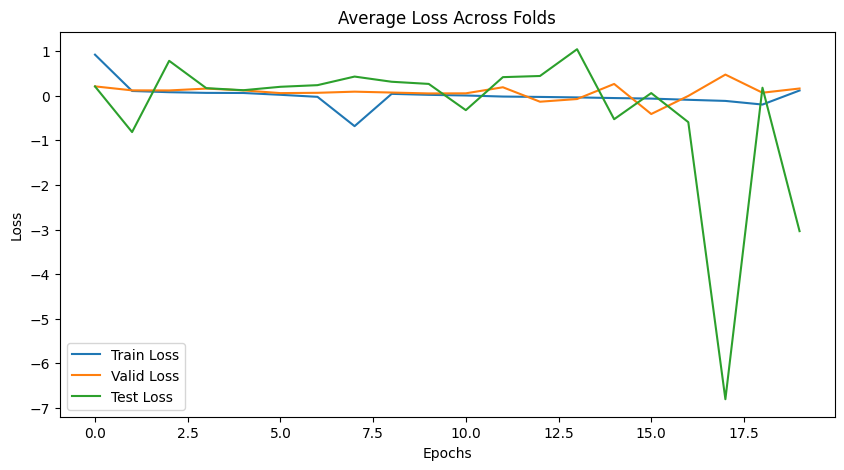

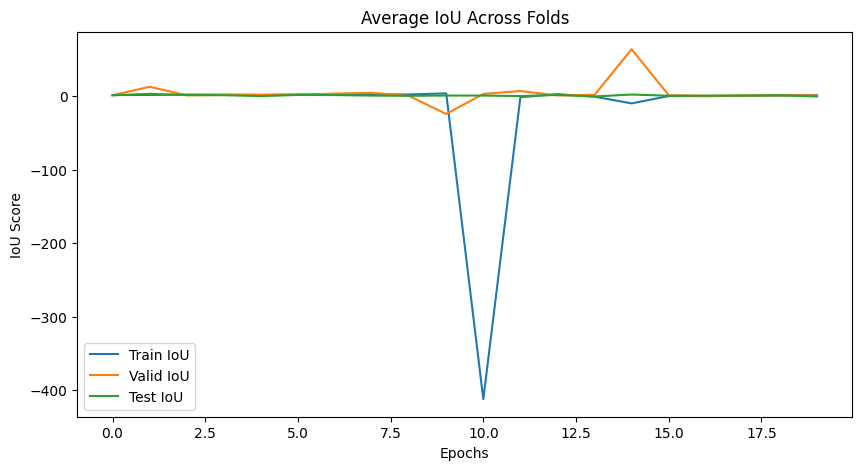

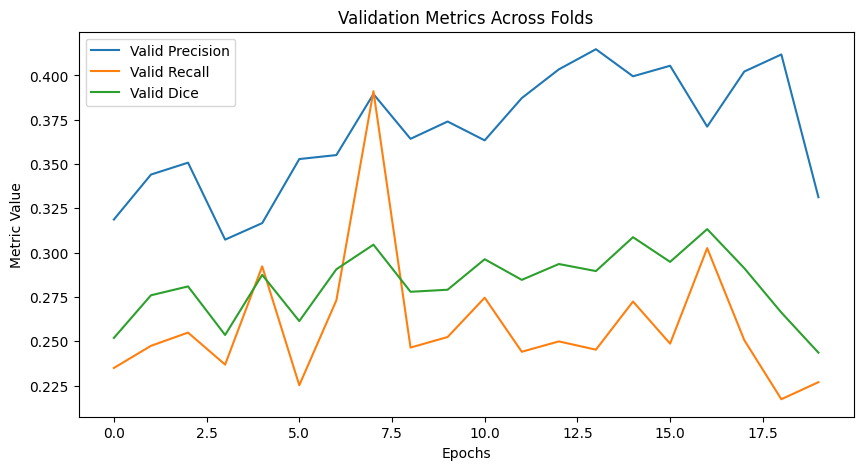

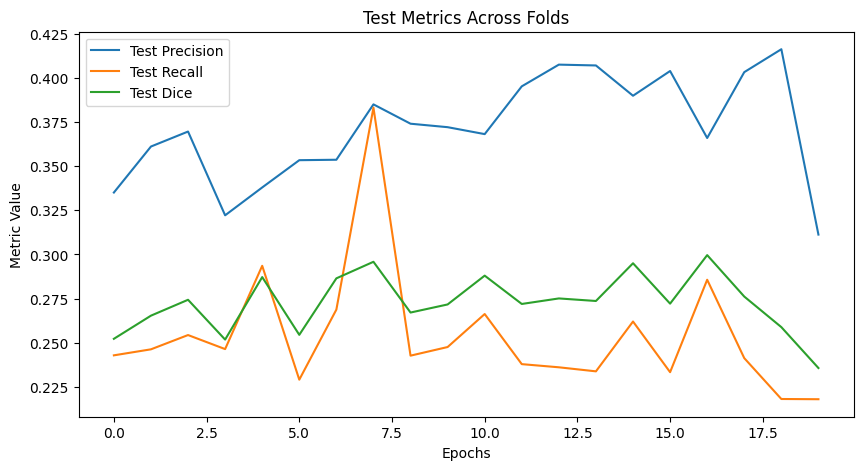

Metrics have been saved to 'Dataset1_model_LinkNet.csv'


/tmp/ipykernel_4813/1280507250.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_fpath)
/tmp/ipykernel_4813/1624409435.py:371: UserWar

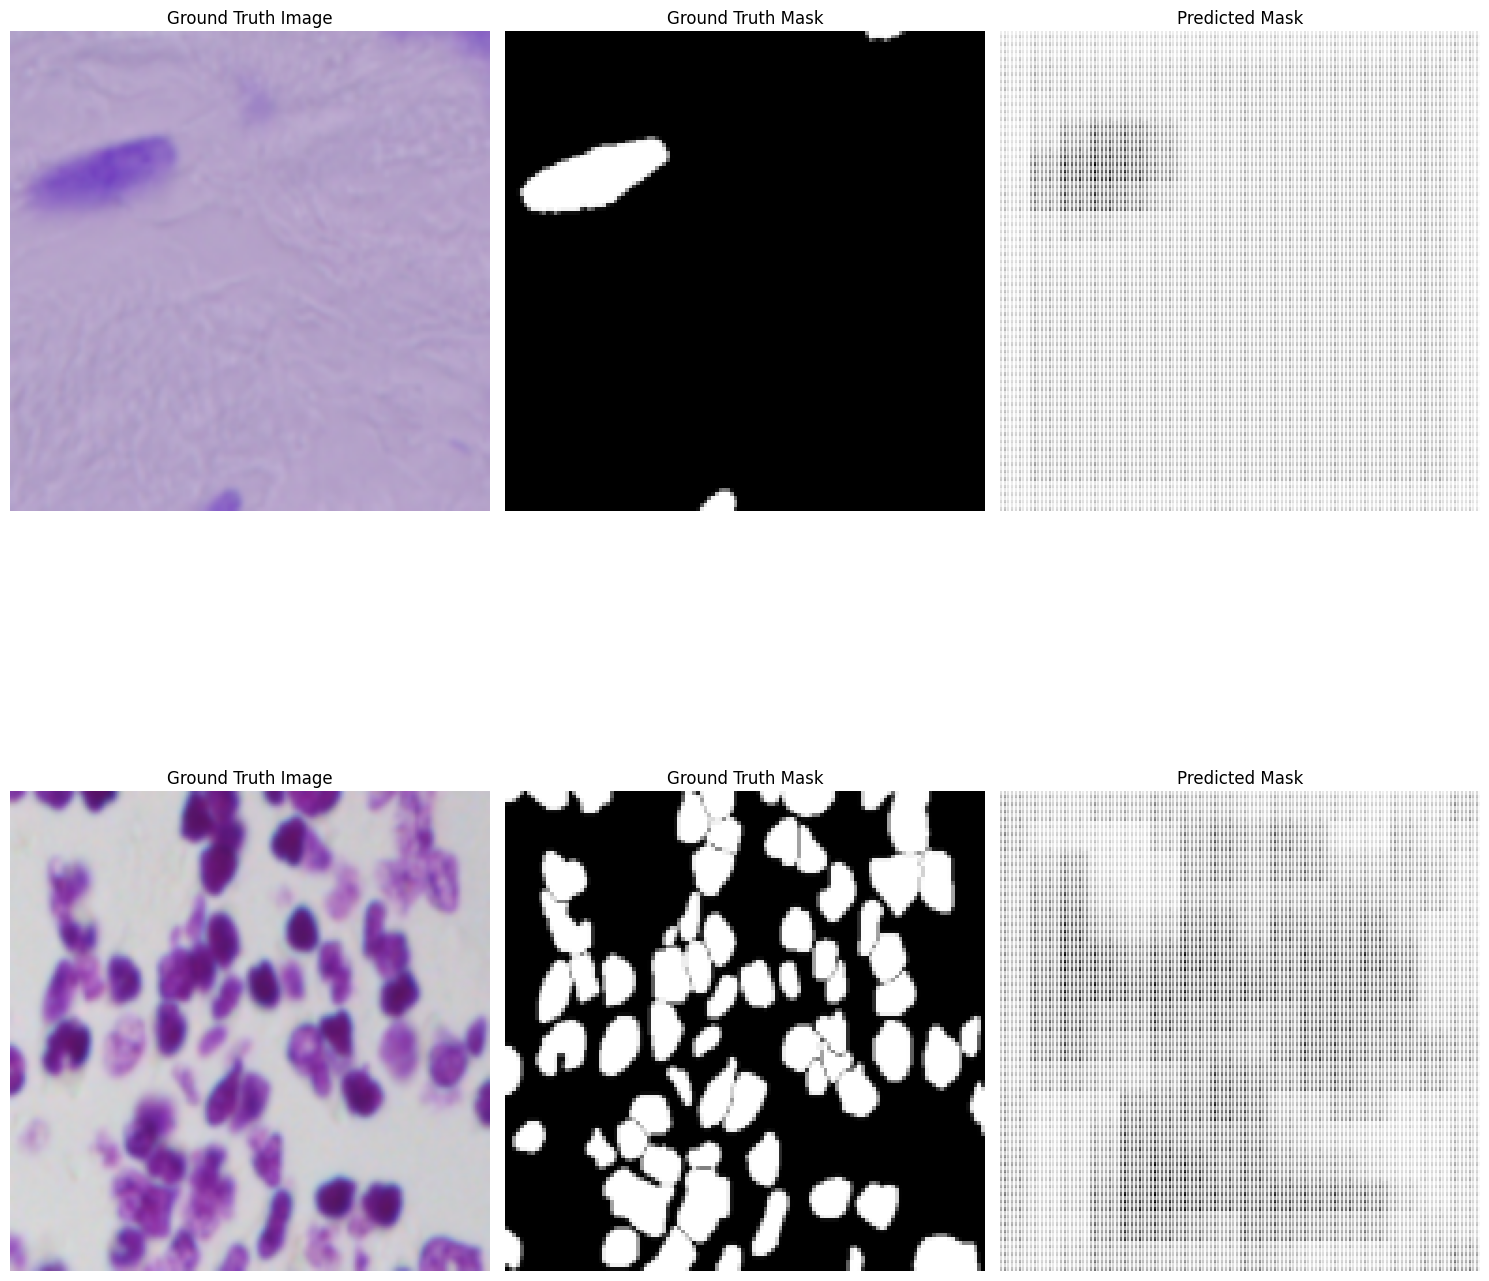

In [3]:
1# Set up necessary directories and loss function
if not os.path.exists("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/LinkNet"):
    os.makedirs("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/LinkNet")

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        
        # If the input and output channels differ, add a 1x1 convolution to match the dimensions
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# Define the LinkNet architecture
class LinkNet(nn.Module):
    def __init__(self, num_classes=1):
        super(LinkNet, self).__init__()
        
        # Encoder part
        self.encoder = nn.Sequential(
            # 64 channels
            ResidualBlock(3, 64),
            nn.MaxPool2d(2),
            # 128 channels
            ResidualBlock(64, 128),
            nn.MaxPool2d(2),
            # 256 channels
            ResidualBlock(128, 256),
            nn.MaxPool2d(2),
            # 512 channels
            ResidualBlock(256, 512),
            nn.MaxPool2d(2),
            # 1024 channels
            ResidualBlock(512, 1024),
        )

        # Decoder part
        self.decoder = nn.Sequential(
            # Upsample to 512 channels
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            ResidualBlock(512, 512),
            # Upsample to 256 channels
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            ResidualBlock(256, 256),
            # Upsample to 128 channels
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            ResidualBlock(128, 128),
            # Upsample to 64 channels
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            ResidualBlock(64, 64),
        )
        
        # Final convolution to produce the segmentation map (num_classes channels)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def forward(self, x):
        # Encoder path
        encoder_out = self.encoder(x)
        
        # Decoder path with skip connections (using the corresponding encoder outputs)
        decoder_out = self.decoder(encoder_out)
        
        # Output layer
        output = self.final_conv(decoder_out)
        
        return output

# Initialize model and optimizer for each fold
model = LinkNet(1)  # Assuming UNet is defined earlier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Parameters and Data
num_epochs = 20
k_folds = 7
checkpoint_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/LinkNet/chkpoint_'
best_model_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/LinkNet/bestmodel.pt'

# Initialize metrics
accuracy_metric = IoU()  # Assuming IoU is a metric you defined earlier
criterion = DiceLoss()  # Assuming DiceLoss is defined earlier
valid_loss_min = np.inf

# Store results
total_train_loss, total_train_score  = [], []
total_valid_loss, total_valid_score  = [], []
total_test_loss, total_test_score  = [], []

total_train_precision, total_valid_precision, total_test_precision = [], [], []
total_train_recall, total_valid_recall, total_test_recall = [], [], []
total_train_dice, total_valid_dice, total_test_dice = [], [], []

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 7-fold Cross Validation Loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"\n####### Fold {fold+1}/{k_folds} #######")

    # Create data subsets for current fold
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=16, shuffle=False)

    # Track losses and scores for each fold
    fold_train_loss, fold_train_score = [], []
    fold_valid_loss, fold_valid_score = [], []
    fold_test_loss, fold_test_score = [], []
    
    fold_train_precision, fold_valid_precision, fold_test_precision = [], [], []
    fold_train_recall, fold_valid_recall, fold_test_recall = [], [], []
    fold_train_dice, fold_valid_dice, fold_test_dice = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_score = [], []

        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for x_train, y_train in pbar:
            x_train = torch.autograd.Variable(x_train)
            y_train = torch.autograd.Variable(y_train)
            optimizer.zero_grad()
            output = model(x_train)

            # Compute Loss and Score
            loss = criterion(output, y_train)
            score = accuracy_metric(output, y_train)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_score.append(score.item())
            pbar.set_description(f"Epoch {epoch+1} - Loss: {loss.item():.4f}, IoU: {score:.4f}")

        fold_train_loss.append(np.mean(train_loss))
        fold_train_score.append(np.mean(train_score))

        # Validation Loop
        model.eval()
        valid_loss, valid_score= [], []

        valid_precision = []
        valid_recall = []
        valid_dice = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = torch.autograd.Variable(x_val)
                y_val = torch.autograd.Variable(y_val)
                output = model(x_val)

                # Compute Loss and Score
                loss = criterion(output, y_val)
                score = accuracy_metric(output, y_val)

                valid_loss.append(loss.item())
                valid_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_val_bin = (y_val > 0.5).float()

                valid_precision.append(precision_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_recall.append(recall_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_dice.append(f1_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_valid_loss.append(np.mean(valid_loss))
        fold_valid_score.append(np.mean(valid_score))
        
        fold_valid_precision.append(np.mean(valid_precision))
        fold_valid_recall.append(np.mean(valid_recall))
        fold_valid_dice.append(np.mean(valid_dice))

        # Test Loop
        test_loss = []
        test_score = []
        
        test_precision = []
        test_recall = []
        test_dice = []

        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test = torch.autograd.Variable(x_test)
                y_test = torch.autograd.Variable(y_test)
                output = model(x_test)

                # Compute Loss and Score
                loss = criterion(output, y_test)
                score = accuracy_metric(output, y_test)

                test_loss.append(loss.item())
                test_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_test_bin = (y_test > 0.5).float()

                test_precision.append(precision_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_recall.append(recall_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_dice.append(f1_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_test_loss.append(np.mean(test_loss))
        fold_test_score.append(np.mean(test_score))

        fold_test_precision.append(np.mean(test_precision))
        fold_test_recall.append(np.mean(test_recall))
        fold_test_dice.append(np.mean(test_dice))

        print(f"Fold {fold+1} - Epoch {epoch+1} - Train Loss: {np.mean(train_loss):.4f}, IoU: {np.mean(train_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Loss: {np.mean(valid_loss):.4f}, IoU: {np.mean(valid_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Loss: {np.mean(test_loss):.4f}, IoU: {np.mean(test_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Precision: {np.mean(valid_precision):.4f}, Recall: {np.mean(valid_recall):.4f}, Dice: {np.mean(valid_dice):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Precision: {np.mean(test_precision):.4f}, Recall: {np.mean(test_recall):.4f}, Dice: {np.mean(test_dice):.4f}")

        # Save checkpoint and best model
        checkpoint = {
            'epoch': epoch+1,
            'valid_loss_min': fold_valid_loss[-1],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        if fold_valid_loss[-1] <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {fold_valid_loss[-1]:.6f}). Saving model...')
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = fold_valid_loss[-1]

    # Append fold results
    total_train_loss.append(fold_train_loss)
    total_train_score.append(fold_train_score)
    total_valid_loss.append(fold_valid_loss)
    total_valid_score.append(fold_valid_score)
    total_test_loss.append(fold_test_loss)
    total_test_score.append(fold_test_score)

    total_train_precision.append(fold_train_precision)
    total_valid_precision.append(fold_valid_precision)
    total_test_precision.append(fold_test_precision)

    total_train_recall.append(fold_train_recall)
    total_valid_recall.append(fold_valid_recall)
    total_test_recall.append(fold_test_recall)

    total_train_dice.append(fold_train_dice)
    total_valid_dice.append(fold_valid_dice)
    total_test_dice.append(fold_test_dice)

# Calculate average results over all folds
avg_train_loss = np.mean(total_train_loss, axis=0)
avg_train_score = np.mean(total_train_score, axis=0)
avg_valid_loss = np.mean(total_valid_loss, axis=0)
avg_valid_score = np.mean(total_valid_score, axis=0)
avg_test_loss = np.mean(total_test_loss, axis=0)
avg_test_score = np.mean(total_test_score, axis=0)

avg_train_precision = np.mean(total_train_precision, axis=0)
avg_valid_precision = np.mean(total_valid_precision, axis=0)
avg_test_precision = np.mean(total_test_precision, axis=0)

avg_train_recall = np.mean(total_train_recall, axis=0)
avg_valid_recall = np.mean(total_valid_recall, axis=0)
avg_test_recall = np.mean(total_test_recall, axis=0)

avg_train_dice = np.mean(total_train_dice, axis=0)
avg_valid_dice = np.mean(total_valid_dice, axis=0)
avg_test_dice = np.mean(total_test_dice, axis=0)

# Plot final averaged results for losses and metrics
plt.figure(figsize=(10,5))
plt.plot(avg_train_loss, label="Train Loss")
plt.plot(avg_valid_loss, label="Valid Loss")
plt.plot(avg_test_loss, label="Test Loss")
plt.legend()
plt.title("Average Loss Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot IoU scores
plt.figure(figsize=(10,5))
plt.plot(avg_train_score, label="Train IoU")
plt.plot(avg_valid_score, label="Valid IoU")
plt.plot(avg_test_score, label="Test IoU")
plt.legend()
plt.title("Average IoU Across Folds")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.show()

# Plot Precision, Recall, and Dice scores for validation and test sets
plt.figure(figsize=(10,5))
plt.plot(avg_valid_precision, label="Valid Precision")
plt.plot(avg_valid_recall, label="Valid Recall")
plt.plot(avg_valid_dice, label="Valid Dice")
plt.legend()
plt.title("Validation Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(avg_test_precision, label="Test Precision")
plt.plot(avg_test_recall, label="Test Recall")
plt.plot(avg_test_dice, label="Test Dice")
plt.legend()
plt.title("Test Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

import pandas as pd

# Create a DataFrame to store results
columns = [
    'Fold', 'Epoch', 'Train_Loss', 'Train_IoU', 'Valid_Loss', 'Valid_IoU', 'Test_Loss', 'Test_IoU',
    'Valid_Precision', 'Valid_Recall', 'Valid_Dice', 'Test_Precision', 'Test_Recall', 'Test_Dice'
]

results = []

# Collect the results after all folds and epochs
for fold in range(k_folds):
    for epoch in range(num_epochs):
        results.append([
            fold + 1, epoch + 1,
            total_train_loss[fold][epoch], total_train_score[fold][epoch],
            total_valid_loss[fold][epoch], total_valid_score[fold][epoch],total_test_loss[fold][epoch], total_test_score[fold][epoch],
            total_valid_precision[fold][epoch], total_valid_recall[fold][epoch], total_valid_dice[fold][epoch],
            total_test_precision[fold][epoch], total_test_recall[fold][epoch], total_test_dice[fold][epoch]
        ])

# Convert results to a pandas DataFrame
df = pd.DataFrame(results, columns=columns)

# Save DataFrame to CSV
df.to_csv("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/LinkNet/Dataset1_model_LinkNet.csv", index=False)

print("Metrics have been saved to 'Dataset1_model_LinkNet.csv'")

#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

def visualize_predict(model, n_images):
  #model = model.eval()
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in test_loader:
        data = torch.autograd.Variable(data, volatile=True)
        mask = torch.autograd.Variable(mask, volatile=True)
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Ground Truth Image")
    ax[img_no, 1].set_title("Ground Truth Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
    
  plt.tight_layout()
  plt.show()
  
visualize_predict(model, 2)

# DenseASPP

In [1]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
#import tqdm as tqdm
from tqdm import tqdm as tqdm
import tifffile as tiff
import imagecodecs

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import zipfile

import random
from PIL import Image
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

TRAIN_PATH = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/stage1_train/'

def get_train_transform():
   return A.Compose(
       [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        ToTensorV2()
        ])

class LoadDataSet(Dataset):
        def __init__(self,path, transform=None):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_train_transform()
        
        def __len__(self):
            return len(self.folders)
              
        
        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(128,128))
            
            mask = self.get_mask(mask_folder, 128, 128 ).astype('float32')

            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.permute(2, 0, 1)
            return (img,mask)
        
        def get_mask(self,mask_folder,IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)
              
            return mask
        
train_dataset = LoadDataSet(TRAIN_PATH, transform=get_train_transform())

split_ratio = 0.15
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))

train_data, test_data = random_split(train_dataset, [train_size, valid_size])

test_loader = DataLoader(dataset=test_data, batch_size=10)

def format_image(img):
    img = np.array(np.transpose(img, (1,2,0)))
    mean=np.array((0.485, 0.456, 0.406))
    std=np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

def visualize_dataset(n_images, predict=None):
  """
  Function to visualize images and masks
  """
  images = random.sample(range(0, 670), n_images)
  figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
  print(images)
  for i in range(0, len(images)):
    img_no = images[i]
    image, mask = train_dataset.__getitem__(img_no)
    image = format_image(image)
    mask = format_mask(mask)
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
    ax[i, 0].set_title("Ground Truth Image")
    ax[i, 1].set_title("Mask")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
  plt.tight_layout()
  plt.show()
  
split_ratio = 0.25

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)  # Convert logits to probabilities
        
        # Ensure targets have the same shape as inputs
        if targets.shape[-2:] != inputs.shape[-2:]:  
            targets = F.interpolate(targets, size=inputs.shape[-2:], mode="nearest")

        # Flatten tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Compute Dice coefficient
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice


class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU
    
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Save and Load checkpoint functions
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    torch.save(state, checkpoint_path)
    if is_best:
        shutil.copyfile(checkpoint_path, best_model_path)

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()



/home/sayantan/.local/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Set up necessary directories and loss function
if not os.path.exists("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/DenseASPP"):
    os.makedirs("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/DenseASPP")

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(growth_rate)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(in_channels + growth_rate, growth_rate, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv2d(in_channels + 2*growth_rate, growth_rate, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(growth_rate)
        self.relu3 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out1 = self.relu1(self.bn1(self.conv1(x)))
        out2 = self.relu2(self.bn2(self.conv2(torch.cat([x, out1], 1))))
        out3 = self.relu3(self.bn3(self.conv3(torch.cat([x, out1, out2], 1))))
        return torch.cat([x, out1, out2, out3], 1)


class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        
        self.atrous1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6)
        self.atrous2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12)
        self.atrous3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18)
        self.atrous4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=24, dilation=24)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
        self.fc = nn.Conv2d(out_channels*5, out_channels, kernel_size=1)
        
    def forward(self, x):
        feat1 = self.atrous1(x)
        feat2 = self.atrous2(x)
        feat3 = self.atrous3(x)
        feat4 = self.atrous4(x)
        
        global_feat = self.global_pool(x)
        global_feat = self.conv1x1(global_feat)
        global_feat = F.interpolate(global_feat, size=feat1.size()[2:], mode='bilinear', align_corners=True)
        
        x = torch.cat([feat1, feat2, feat3, feat4, global_feat], dim=1)
        x = self.fc(x)
        return x


class DenseASPP(nn.Module):
    def __init__(self, num_classes=1):
        super(DenseASPP, self).__init__()
        
        # Encoder part (Dense blocks)
        self.dense1 = DenseBlock(3, 32)  # Input channels = 3 (RGB image)
        self.dense2 = DenseBlock(3 + 3*32, 32)  # Output from previous DenseBlock
        self.dense3 = DenseBlock(3 + 3*32 + 3*32, 32)
        
        # ASPP module
        self.aspp = ASPP(3 + 3*32 + 3*32 + 3*32, 256)  # Number of channels after all DenseBlocks
        
        # Decoder (Upsample the feature maps)
        # Modify the decoder layers to ensure output is 256x256
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)  # Ensure final output is 256x256
        )

        
        # Final convolution to produce the segmentation map
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)
        
    def forward(self, x):
        # Encoder path with Dense blocks
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        
        # Apply ASPP
        x = self.aspp(x)
        
        # Decoder path (Upsampling and refinement)
        x = self.decoder(x)
        
        # Output layer
        output = self.final_conv(x)
        
        return output
    
# Initialize model and optimizer for each fold
model = DenseASPP(1)  # Assuming UNet is defined earlier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Parameters and Data
num_epochs = 20
k_folds = 7
checkpoint_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/DenseASPP/chkpoint_'
best_model_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/DenseASPP/bestmodel.pt'

# Initialize metrics
accuracy_metric = IoU()  # Assuming IoU is a metric you defined earlier
criterion = DiceLoss()  # Assuming DiceLoss is defined earlier
valid_loss_min = np.inf

# Store results
total_train_loss, total_train_score  = [], []
total_valid_loss, total_valid_score  = [], []
total_test_loss, total_test_score  = [], []

total_train_precision, total_valid_precision, total_test_precision = [], [], []
total_train_recall, total_valid_recall, total_test_recall = [], [], []
total_train_dice, total_valid_dice, total_test_dice = [], [], []

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 7-fold Cross Validation Loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"\n####### Fold {fold+1}/{k_folds} #######")

    # Create data subsets for current fold
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=16, shuffle=False)

    # Track losses and scores for each fold
    fold_train_loss, fold_train_score = [], []
    fold_valid_loss, fold_valid_score = [], []
    fold_test_loss, fold_test_score = [], []
    
    fold_train_precision, fold_valid_precision, fold_test_precision = [], [], []
    fold_train_recall, fold_valid_recall, fold_test_recall = [], [], []
    fold_train_dice, fold_valid_dice, fold_test_dice = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_score = [], []

        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for x_train, y_train in pbar:
            x_train = torch.autograd.Variable(x_train)
            y_train = torch.autograd.Variable(y_train)
            optimizer.zero_grad()
            output = model(x_train)

            if output.shape[-2:] != y_train.shape[-2:]:
                output = F.interpolate(output, size=y_train.shape[-2:], mode="bilinear", align_corners=True)

            print(f"Output shape: {output.shape}, Target shape: {y_train.shape}")  # Debugging print

            # Compute Loss and Score
            loss = criterion(output, y_train)
            score = accuracy_metric(output, y_train)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_score.append(score.item())
            pbar.set_description(f"Epoch {epoch+1} - Loss: {loss.item():.4f}, IoU: {score:.4f}")

        fold_train_loss.append(np.mean(train_loss))
        fold_train_score.append(np.mean(train_score))

        # Validation Loop
        model.eval()
        valid_loss, valid_score= [], []

        valid_precision = []
        valid_recall = []
        valid_dice = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = torch.autograd.Variable(x_val)
                y_val = torch.autograd.Variable(y_val)
                output = model(x_val)

                # Compute Loss and Score
                loss = criterion(output, y_val)
                score = accuracy_metric(output, y_val)

                valid_loss.append(loss.item())
                valid_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_val_bin = (y_val > 0.5).float()

                valid_precision.append(precision_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_recall.append(recall_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_dice.append(f1_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_valid_loss.append(np.mean(valid_loss))
        fold_valid_score.append(np.mean(valid_score))
        
        fold_valid_precision.append(np.mean(valid_precision))
        fold_valid_recall.append(np.mean(valid_recall))
        fold_valid_dice.append(np.mean(valid_dice))

        # Test Loop
        test_loss = []
        test_score = []
        
        test_precision = []
        test_recall = []
        test_dice = []

        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test = torch.autograd.Variable(x_test)
                y_test = torch.autograd.Variable(y_test)
                output = model(x_test)

                # Compute Loss and Score
                loss = criterion(output, y_test)
                score = accuracy_metric(output, y_test)

                test_loss.append(loss.item())
                test_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_test_bin = (y_test > 0.5).float()

                test_precision.append(precision_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_recall.append(recall_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_dice.append(f1_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_test_loss.append(np.mean(test_loss))
        fold_test_score.append(np.mean(test_score))

        fold_test_precision.append(np.mean(test_precision))
        fold_test_recall.append(np.mean(test_recall))
        fold_test_dice.append(np.mean(test_dice))

        print(f"Fold {fold+1} - Epoch {epoch+1} - Train Loss: {np.mean(train_loss):.4f}, IoU: {np.mean(train_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Loss: {np.mean(valid_loss):.4f}, IoU: {np.mean(valid_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Loss: {np.mean(test_loss):.4f}, IoU: {np.mean(test_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Precision: {np.mean(valid_precision):.4f}, Recall: {np.mean(valid_recall):.4f}, Dice: {np.mean(valid_dice):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Precision: {np.mean(test_precision):.4f}, Recall: {np.mean(test_recall):.4f}, Dice: {np.mean(test_dice):.4f}")

        # Save checkpoint and best model
        checkpoint = {
            'epoch': epoch+1,
            'valid_loss_min': fold_valid_loss[-1],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        if fold_valid_loss[-1] <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {fold_valid_loss[-1]:.6f}). Saving model...')
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = fold_valid_loss[-1]

    # Append fold results
    total_train_loss.append(fold_train_loss)
    total_train_score.append(fold_train_score)
    total_valid_loss.append(fold_valid_loss)
    total_valid_score.append(fold_valid_score)
    total_test_loss.append(fold_test_loss)
    total_test_score.append(fold_test_score)

    total_train_precision.append(fold_train_precision)
    total_valid_precision.append(fold_valid_precision)
    total_test_precision.append(fold_test_precision)

    total_train_recall.append(fold_train_recall)
    total_valid_recall.append(fold_valid_recall)
    total_test_recall.append(fold_test_recall)

    total_train_dice.append(fold_train_dice)
    total_valid_dice.append(fold_valid_dice)
    total_test_dice.append(fold_test_dice)

# Calculate average results over all folds
avg_train_loss = np.mean(total_train_loss, axis=0)
avg_train_score = np.mean(total_train_score, axis=0)
avg_valid_loss = np.mean(total_valid_loss, axis=0)
avg_valid_score = np.mean(total_valid_score, axis=0)
avg_test_loss = np.mean(total_test_loss, axis=0)
avg_test_score = np.mean(total_test_score, axis=0)

avg_train_precision = np.mean(total_train_precision, axis=0)
avg_valid_precision = np.mean(total_valid_precision, axis=0)
avg_test_precision = np.mean(total_test_precision, axis=0)

avg_train_recall = np.mean(total_train_recall, axis=0)
avg_valid_recall = np.mean(total_valid_recall, axis=0)
avg_test_recall = np.mean(total_test_recall, axis=0)

avg_train_dice = np.mean(total_train_dice, axis=0)
avg_valid_dice = np.mean(total_valid_dice, axis=0)
avg_test_dice = np.mean(total_test_dice, axis=0)

# Plot final averaged results for losses and metrics
plt.figure(figsize=(10,5))
plt.plot(avg_train_loss, label="Train Loss")
plt.plot(avg_valid_loss, label="Valid Loss")
plt.plot(avg_test_loss, label="Test Loss")
plt.legend()
plt.title("Average Loss Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot IoU scores
plt.figure(figsize=(10,5))
plt.plot(avg_train_score, label="Train IoU")
plt.plot(avg_valid_score, label="Valid IoU")
plt.plot(avg_test_score, label="Test IoU")
plt.legend()
plt.title("Average IoU Across Folds")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.show()

# Plot Precision, Recall, and Dice scores for validation and test sets
plt.figure(figsize=(10,5))
plt.plot(avg_valid_precision, label="Valid Precision")
plt.plot(avg_valid_recall, label="Valid Recall")
plt.plot(avg_valid_dice, label="Valid Dice")
plt.legend()
plt.title("Validation Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(avg_test_precision, label="Test Precision")
plt.plot(avg_test_recall, label="Test Recall")
plt.plot(avg_test_dice, label="Test Dice")
plt.legend()
plt.title("Test Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

import pandas as pd

# Create a DataFrame to store results
columns = [
    'Fold', 'Epoch', 'Train_Loss', 'Train_IoU', 'Valid_Loss', 'Valid_IoU', 'Test_Loss', 'Test_IoU',
    'Valid_Precision', 'Valid_Recall', 'Valid_Dice', 'Test_Precision', 'Test_Recall', 'Test_Dice'
]

results = []

# Collect the results after all folds and epochs
for fold in range(k_folds):
    for epoch in range(num_epochs):
        results.append([
            fold + 1, epoch + 1,
            total_train_loss[fold][epoch], total_train_score[fold][epoch],
            total_valid_loss[fold][epoch], total_valid_score[fold][epoch],total_test_loss[fold][epoch], total_test_score[fold][epoch],
            total_valid_precision[fold][epoch], total_valid_recall[fold][epoch], total_valid_dice[fold][epoch],
            total_test_precision[fold][epoch], total_test_recall[fold][epoch], total_test_dice[fold][epoch]
        ])

# Convert results to a pandas DataFrame
df = pd.DataFrame(results, columns=columns)

# Save DataFrame to CSV
df.to_csv("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/DenseASPP/Dataset1_model_DenseASPP.csv", index=False)

print("Metrics have been saved to 'Dataset1_model_DenseASPP.csv'")

#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

def visualize_predict(model, n_images):
  #model = model.eval()
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in test_loader:
        data = torch.autograd.Variable(data, volatile=True)
        mask = torch.autograd.Variable(mask, volatile=True)
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Ground Truth Image")
    ax[img_no, 1].set_title("Ground Truth Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
  plt.tight_layout()
  plt.show()
  
visualize_predict(model, 2)


####### Fold 1/7 #######


Training Epoch 1:   0%|                                  | 0/36 [00:00<?, ?it/s]

# HRNet


####### Fold 1/7 #######


Epoch 1 - Loss: -0.3718, IoU: 2.1835: 100%|█████| 36/36 [11:42<00:00, 19.51s/it]


Fold 1 - Epoch 1 - Train Loss: 1.1305, IoU: 1.0140
Fold 1 - Epoch 1 - Valid Loss: 0.2467, IoU: 0.6958
Fold 1 - Epoch 1 - Test Loss: 0.1581, IoU: 0.7597
Fold 1 - Epoch 1 - Valid Precision: 0.2107, Recall: 0.4863, Dice: 0.2906
Fold 1 - Epoch 1 - Test Precision: 0.1974, Recall: 0.4883, Dice: 0.2792
Validation loss decreased (inf --> 0.246660). Saving model...


Epoch 2 - Loss: -0.2845, IoU: 1.7953: 100%|█████| 36/36 [10:44<00:00, 17.90s/it]


Fold 1 - Epoch 2 - Train Loss: 0.6097, IoU: 0.8438
Fold 1 - Epoch 2 - Valid Loss: 0.4401, IoU: 0.8725
Fold 1 - Epoch 2 - Test Loss: 3.3151, IoU: 0.2888
Fold 1 - Epoch 2 - Valid Precision: 0.0259, Recall: 0.0645, Dice: 0.0362
Fold 1 - Epoch 2 - Test Precision: 0.0153, Recall: 0.0449, Dice: 0.0227


Epoch 3 - Loss: 1.2792, IoU: -0.1225: 100%|█████| 36/36 [10:46<00:00, 17.96s/it]


Fold 1 - Epoch 3 - Train Loss: 1.0267, IoU: -0.4822
Fold 1 - Epoch 3 - Valid Loss: 1.0115, IoU: -0.0014
Fold 1 - Epoch 3 - Test Loss: 0.9479, IoU: 0.0292
Fold 1 - Epoch 3 - Valid Precision: 0.7302, Recall: 0.2388, Dice: 0.3493
Fold 1 - Epoch 3 - Test Precision: 0.8107, Recall: 0.2079, Dice: 0.3265


Epoch 4 - Loss: 0.6738, IoU: 0.1949: 100%|██████| 36/36 [10:48<00:00, 18.03s/it]


Fold 1 - Epoch 4 - Train Loss: 0.8860, IoU: 0.0719
Fold 1 - Epoch 4 - Valid Loss: 0.6857, IoU: 0.1874
Fold 1 - Epoch 4 - Test Loss: 0.6988, IoU: 0.1791
Fold 1 - Epoch 4 - Valid Precision: 0.2836, Recall: 0.0476, Dice: 0.0726
Fold 1 - Epoch 4 - Test Precision: 0.2079, Recall: 0.0386, Dice: 0.0513


Epoch 5 - Loss: 0.3006, IoU: 0.5378: 100%|██████| 36/36 [10:47<00:00, 18.00s/it]


Fold 1 - Epoch 5 - Train Loss: 0.5951, IoU: 0.2784
Fold 1 - Epoch 5 - Valid Loss: 0.3445, IoU: 0.4956
Fold 1 - Epoch 5 - Test Loss: 0.3357, IoU: 0.5042
Fold 1 - Epoch 5 - Valid Precision: 0.3223, Recall: 0.0045, Dice: 0.0062
Fold 1 - Epoch 5 - Test Precision: 0.1879, Recall: 0.0057, Dice: 0.0063


Epoch 6 - Loss: -0.9784, IoU: 91.6437: 100%|████| 36/36 [10:46<00:00, 17.97s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 6 - Train Loss: -0.1436, IoU: 4.3814
Fold 1 - Epoch 6 - Valid Loss: 0.0096, IoU: 1.0261
Fold 1 - Epoch 6 - Test Loss: 0.0160, IoU: 1.0540
Fold 1 - Epoch 6 - Valid Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Fold 1 - Epoch 6 - Test Precision: 0.0000, Recall: 0.0000, Dice: 0.0000
Validation loss decreased (0.246660 --> 0.009595). Saving model...


Epoch 7 - Loss: 0.6727, IoU: 0.1957: 100%|██████| 36/36 [10:50<00:00, 18.06s/it]


Fold 1 - Epoch 7 - Train Loss: 0.3437, IoU: -0.4974
Fold 1 - Epoch 7 - Valid Loss: 0.6688, IoU: 0.2027
Fold 1 - Epoch 7 - Test Loss: 0.6842, IoU: 0.1895
Fold 1 - Epoch 7 - Valid Precision: 0.1590, Recall: 0.8576, Dice: 0.2673
Fold 1 - Epoch 7 - Test Precision: 0.1449, Recall: 0.8670, Dice: 0.2475


Epoch 8 - Loss: -1.1102, IoU: -19.1517: 100%|███| 36/36 [10:49<00:00, 18.05s/it]


Fold 1 - Epoch 8 - Train Loss: 0.0380, IoU: 0.7014
Fold 1 - Epoch 8 - Valid Loss: -0.4587, IoU: 0.6378
Fold 1 - Epoch 8 - Test Loss: -0.6644, IoU: 1.8677
Fold 1 - Epoch 8 - Valid Precision: 0.2996, Recall: 0.9771, Dice: 0.4542
Fold 1 - Epoch 8 - Test Precision: 0.3048, Recall: 0.9795, Dice: 0.4608
Validation loss decreased (0.009595 --> -0.458734). Saving model...


Epoch 9 - Loss: 0.6873, IoU: 0.1854: 100%|██████| 36/36 [10:58<00:00, 18.29s/it]


Fold 1 - Epoch 9 - Train Loss: 0.2555, IoU: -0.6641
Fold 1 - Epoch 9 - Valid Loss: 0.9721, IoU: 0.0475
Fold 1 - Epoch 9 - Test Loss: 1.1437, IoU: 0.2238
Fold 1 - Epoch 9 - Valid Precision: 0.2218, Recall: 0.2285, Dice: 0.2116
Fold 1 - Epoch 9 - Test Precision: 0.1567, Recall: 0.2457, Dice: 0.1808


Epoch 10 - Loss: 0.2028, IoU: 0.6628: 100%|█████| 36/36 [11:31<00:00, 19.21s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Epoch 10 - Train Loss: 0.3862, IoU: 0.5173
Fold 1 - Epoch 10 - Valid Loss: 0.1480, IoU: 0.7964
Fold 1 - Epoch 10 - Test Loss: -0.2695, IoU: -0.5658
Fold 1 - Epoch 10 - Valid Precision: 0.1912, Recall: 0.0017, Dice: 0.0028
Fold 1 - Epoch 10 - Test Precision: 0.0027, Recall: 0.0024, Dice: 0.0025


Epoch 11 - Loss: 1.5195, IoU: -0.2062: 100%|████| 36/36 [10:54<00:00, 18.18s/it]


Fold 1 - Epoch 11 - Train Loss: -1.3570, IoU: 0.1754
Fold 1 - Epoch 11 - Valid Loss: 0.3897, IoU: 0.4518
Fold 1 - Epoch 11 - Test Loss: 0.4493, IoU: 0.3892
Fold 1 - Epoch 11 - Valid Precision: 0.4523, Recall: 0.2691, Dice: 0.3366
Fold 1 - Epoch 11 - Test Precision: 0.4528, Recall: 0.2661, Dice: 0.3305


Epoch 12 - Loss: 0.7573, IoU: 0.1381: 100%|█████| 36/36 [11:32<00:00, 19.23s/it]


Fold 1 - Epoch 12 - Train Loss: 1.1706, IoU: -0.0725
Fold 1 - Epoch 12 - Valid Loss: 0.9090, IoU: 0.0513
Fold 1 - Epoch 12 - Test Loss: 0.9369, IoU: 0.0339
Fold 1 - Epoch 12 - Valid Precision: 0.1026, Recall: 0.6064, Dice: 0.1750
Fold 1 - Epoch 12 - Test Precision: 0.0860, Recall: 0.5855, Dice: 0.1495


Epoch 13 - Loss: -0.0163, IoU: 1.0331: 100%|████| 36/36 [13:29<00:00, 22.48s/it]


Fold 1 - Epoch 13 - Train Loss: 0.1702, IoU: -0.0908
Fold 1 - Epoch 13 - Valid Loss: 0.5436, IoU: 0.2965
Fold 1 - Epoch 13 - Test Loss: 0.5530, IoU: 0.2900
Fold 1 - Epoch 13 - Valid Precision: 0.1534, Recall: 0.9995, Dice: 0.2654
Fold 1 - Epoch 13 - Test Precision: 0.1402, Recall: 0.9998, Dice: 0.2453


Epoch 14 - Loss: 2.0618, IoU: -0.3468: 100%|████| 36/36 [11:16<00:00, 18.79s/it]


Fold 1 - Epoch 14 - Train Loss: 0.8228, IoU: 0.4668
Fold 1 - Epoch 14 - Valid Loss: 1.6789, IoU: -0.1207
Fold 1 - Epoch 14 - Test Loss: 0.3104, IoU: -0.0051
Fold 1 - Epoch 14 - Valid Precision: 0.1025, Recall: 0.5496, Dice: 0.1722
Fold 1 - Epoch 14 - Test Precision: 0.0912, Recall: 0.5526, Dice: 0.1559


Epoch 15 - Loss: 1.5150, IoU: -0.2048: 100%|████| 36/36 [10:28<00:00, 17.45s/it]


Fold 1 - Epoch 15 - Train Loss: 0.7526, IoU: 0.2914
Fold 1 - Epoch 15 - Valid Loss: 0.8435, IoU: 0.2548
Fold 1 - Epoch 15 - Test Loss: 0.8822, IoU: -0.9507
Fold 1 - Epoch 15 - Valid Precision: 0.1675, Recall: 0.9190, Dice: 0.2822
Fold 1 - Epoch 15 - Test Precision: 0.1526, Recall: 0.9174, Dice: 0.2608


Epoch 16 - Loss: -0.0973, IoU: 1.2156: 100%|████| 36/36 [10:30<00:00, 17.52s/it]


Fold 1 - Epoch 16 - Train Loss: 0.2417, IoU: 0.7562
Fold 1 - Epoch 16 - Valid Loss: 1.1816, IoU: 0.8543
Fold 1 - Epoch 16 - Test Loss: 476.3963, IoU: -8.9368
Fold 1 - Epoch 16 - Valid Precision: 0.1700, Recall: 0.9404, Dice: 0.2868
Fold 1 - Epoch 16 - Test Precision: 0.1559, Recall: 0.9434, Dice: 0.2667


Epoch 17 - Loss: 1.4273, IoU: -0.1760: 100%|████| 36/36 [10:30<00:00, 17.53s/it]


Fold 1 - Epoch 17 - Train Loss: -1.7690, IoU: 0.5864
Fold 1 - Epoch 17 - Valid Loss: 0.5809, IoU: 0.2687
Fold 1 - Epoch 17 - Test Loss: -0.9743, IoU: -0.0996
Fold 1 - Epoch 17 - Valid Precision: 0.1973, Recall: 0.9374, Dice: 0.3246
Fold 1 - Epoch 17 - Test Precision: 0.1987, Recall: 0.9383, Dice: 0.3261


Epoch 18 - Loss: 0.6788, IoU: 0.1913: 100%|█████| 36/36 [10:35<00:00, 17.66s/it]


Fold 1 - Epoch 18 - Train Loss: 0.8616, IoU: 0.0877
Fold 1 - Epoch 18 - Valid Loss: 0.3090, IoU: 0.5435
Fold 1 - Epoch 18 - Test Loss: 0.1902, IoU: 1.0477
Fold 1 - Epoch 18 - Valid Precision: 0.0346, Recall: 0.0592, Dice: 0.0432
Fold 1 - Epoch 18 - Test Precision: 0.0222, Recall: 0.0472, Dice: 0.0294


Epoch 19 - Loss: 0.3505, IoU: 0.4809: 100%|█████| 36/36 [10:32<00:00, 17.58s/it]


Fold 1 - Epoch 19 - Train Loss: 0.3390, IoU: 0.5282
Fold 1 - Epoch 19 - Valid Loss: -0.3471, IoU: 0.6909
Fold 1 - Epoch 19 - Test Loss: 0.2545, IoU: 1.9799
Fold 1 - Epoch 19 - Valid Precision: 0.0039, Recall: 0.0081, Dice: 0.0052
Fold 1 - Epoch 19 - Test Precision: 0.0020, Recall: 0.0063, Dice: 0.0030


Epoch 20 - Loss: -0.1602, IoU: 1.3816: 100%|████| 36/36 [10:34<00:00, 17.62s/it]
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sayantan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 1 - Epoch 20 - Train Loss: 0.0950, IoU: 0.8843
Fold 1 - Epoch 20 - Valid Loss: -0.0912, IoU: -7.7745
Fold 1 - Epoch 20 - Test Loss: -0.3429, IoU: -0.6407
Fold 1 - Epoch 20 - Valid Precision: 0.3265, Recall: 0.0004, Dice: 0.0008
Fold 1 - Epoch 20 - Test Precision: 0.0005, Recall: 0.0003, Dice: 0.0004

####### Fold 2/7 #######


Epoch 1 - Loss: -0.0205, IoU: 1.0418: 100%|█████| 36/36 [10:35<00:00, 17.66s/it]


Fold 2 - Epoch 1 - Train Loss: -0.0722, IoU: 1.3779
Fold 2 - Epoch 1 - Valid Loss: -0.4254, IoU: 4.2615
Fold 2 - Epoch 1 - Test Loss: -0.6262, IoU: 0.4559
Fold 2 - Epoch 1 - Valid Precision: 0.0113, Recall: 0.0014, Dice: 0.0020
Fold 2 - Epoch 1 - Test Precision: 0.0073, Recall: 0.0020, Dice: 0.0026


Epoch 2 - Loss: -0.5998, IoU: 3.9977: 100%|█████| 36/36 [10:45<00:00, 17.92s/it]


Fold 2 - Epoch 2 - Train Loss: -0.3714, IoU: 3.5567
Fold 2 - Epoch 2 - Valid Loss: -12.2023, IoU: -1.3654
Fold 2 - Epoch 2 - Test Loss: -3.2628, IoU: -4.9957
Fold 2 - Epoch 2 - Valid Precision: 0.0196, Recall: 0.1087, Dice: 0.0330
Fold 2 - Epoch 2 - Test Precision: 0.0182, Recall: 0.0904, Dice: 0.0302
Validation loss decreased (-0.458734 --> -12.202340). Saving model...


Epoch 3 - Loss: -1.6590, IoU: -4.0350: 100%|████| 36/36 [11:33<00:00, 19.27s/it]


Fold 2 - Epoch 3 - Train Loss: -0.6956, IoU: 2.7061
Fold 2 - Epoch 3 - Valid Loss: -1.6868, IoU: -20.3484
Fold 2 - Epoch 3 - Test Loss: -1.4133, IoU: -1.6367
Fold 2 - Epoch 3 - Valid Precision: 0.0013, Recall: 0.0041, Dice: 0.0019
Fold 2 - Epoch 3 - Test Precision: 0.0019, Recall: 0.0061, Dice: 0.0028


Epoch 4 - Loss: 0.7617, IoU: 0.1353: 100%|██████| 36/36 [12:22<00:00, 20.62s/it]


Fold 2 - Epoch 4 - Train Loss: -2.1034, IoU: -65.8254
Fold 2 - Epoch 4 - Valid Loss: 3.6831, IoU: -0.1571
Fold 2 - Epoch 4 - Test Loss: 1.6764, IoU: -0.1953
Fold 2 - Epoch 4 - Valid Precision: 0.0853, Recall: 0.3943, Dice: 0.1383
Fold 2 - Epoch 4 - Test Precision: 0.0869, Recall: 0.3822, Dice: 0.1407


Epoch 5 - Loss: -1.2205, IoU: -10.0712: 100%|███| 36/36 [11:37<00:00, 19.38s/it]


Fold 2 - Epoch 5 - Train Loss: -0.0203, IoU: 1.4525
Fold 2 - Epoch 5 - Valid Loss: -0.0371, IoU: -0.7453
Fold 2 - Epoch 5 - Test Loss: 0.1195, IoU: -0.3369
Fold 2 - Epoch 5 - Valid Precision: 0.0016, Recall: 0.0060, Dice: 0.0024
Fold 2 - Epoch 5 - Test Precision: 0.0012, Recall: 0.0052, Dice: 0.0019


Epoch 6 - Loss: 0.8893, IoU: 0.0586: 100%|██████| 36/36 [11:21<00:00, 18.94s/it]


Fold 2 - Epoch 6 - Train Loss: -9.1971, IoU: -1.0001
Fold 2 - Epoch 6 - Valid Loss: 0.5566, IoU: 0.9989
Fold 2 - Epoch 6 - Test Loss: 0.5464, IoU: 0.9881
Fold 2 - Epoch 6 - Valid Precision: 0.3325, Recall: 0.5252, Dice: 0.4014
Fold 2 - Epoch 6 - Test Precision: 0.3172, Recall: 0.5904, Dice: 0.4026


Epoch 7 - Loss: 0.2287, IoU: 0.6277: 100%|██████| 36/36 [10:58<00:00, 18.30s/it]


Fold 2 - Epoch 7 - Train Loss: 0.1956, IoU: 0.7501
Fold 2 - Epoch 7 - Valid Loss: 18.6563, IoU: -0.0456
Fold 2 - Epoch 7 - Test Loss: -0.7878, IoU: 0.4308
Fold 2 - Epoch 7 - Valid Precision: 0.3922, Recall: 0.7921, Dice: 0.5201
Fold 2 - Epoch 7 - Test Precision: 0.3801, Recall: 0.8491, Dice: 0.5183


Epoch 8 - Loss: -0.3576, IoU: 2.1132: 100%|█████| 36/36 [10:40<00:00, 17.80s/it]


Fold 2 - Epoch 8 - Train Loss: -0.0984, IoU: 1.4397
Fold 2 - Epoch 8 - Valid Loss: -7.7879, IoU: -0.9851
Fold 2 - Epoch 8 - Test Loss: -0.6487, IoU: 0.9527
Fold 2 - Epoch 8 - Valid Precision: 0.3886, Recall: 0.7893, Dice: 0.5161
Fold 2 - Epoch 8 - Test Precision: 0.3786, Recall: 0.8451, Dice: 0.5155


Epoch 9 - Loss: -0.2220, IoU: 1.5708: 100%|█████| 36/36 [10:41<00:00, 17.81s/it]


Fold 2 - Epoch 9 - Train Loss: -0.2625, IoU: 3.6538
Fold 2 - Epoch 9 - Valid Loss: 3.4347, IoU: -6.9623
Fold 2 - Epoch 9 - Test Loss: -4.4689, IoU: 1.8327
Fold 2 - Epoch 9 - Valid Precision: 0.3773, Recall: 0.7053, Dice: 0.4863
Fold 2 - Epoch 9 - Test Precision: 0.3665, Recall: 0.7753, Dice: 0.4889


Epoch 10 - Loss: -0.7021, IoU: 5.7139: 100%|████| 36/36 [10:44<00:00, 17.91s/it]


Fold 2 - Epoch 10 - Train Loss: -0.5597, IoU: 11.8557
Fold 2 - Epoch 10 - Valid Loss: 57.1439, IoU: -0.9099
Fold 2 - Epoch 10 - Test Loss: 1.8160, IoU: -1.7634
Fold 2 - Epoch 10 - Valid Precision: 0.5043, Recall: 0.7863, Dice: 0.6056
Fold 2 - Epoch 10 - Test Precision: 0.4990, Recall: 0.8375, Dice: 0.6214


Epoch 11 - Loss: -0.6846, IoU: 5.3409: 100%|████| 36/36 [10:45<00:00, 17.93s/it]


Fold 2 - Epoch 11 - Train Loss: -0.6846, IoU: -9.5131
Fold 2 - Epoch 11 - Valid Loss: 3.4279, IoU: -0.5375
Fold 2 - Epoch 11 - Test Loss: 16.7745, IoU: -0.7690
Fold 2 - Epoch 11 - Valid Precision: 0.5093, Recall: 0.7128, Dice: 0.5838
Fold 2 - Epoch 11 - Test Precision: 0.5285, Recall: 0.7739, Dice: 0.6246


Epoch 12 - Loss: -1.1535, IoU: -14.0300: 100%|██| 36/36 [10:45<00:00, 17.93s/it]


Fold 2 - Epoch 12 - Train Loss: -1.0324, IoU: -2.2924
Fold 2 - Epoch 12 - Valid Loss: 89.0861, IoU: -0.8276
Fold 2 - Epoch 12 - Test Loss: -4.0312, IoU: -1.5514
Fold 2 - Epoch 12 - Valid Precision: 0.4646, Recall: 0.7490, Dice: 0.5673
Fold 2 - Epoch 12 - Test Precision: 0.4480, Recall: 0.8083, Dice: 0.5724


Epoch 13 - Loss: -1.2968, IoU: -7.7390: 100%|███| 36/36 [10:50<00:00, 18.07s/it]


Fold 2 - Epoch 13 - Train Loss: -1.5648, IoU: -4.0645
Fold 2 - Epoch 13 - Valid Loss: 3.8445, IoU: -0.9599
Fold 2 - Epoch 13 - Test Loss: -4.5903, IoU: -1.3227
Fold 2 - Epoch 13 - Valid Precision: 0.5073, Recall: 0.7959, Dice: 0.6131
Fold 2 - Epoch 13 - Test Precision: 0.5698, Recall: 0.8456, Dice: 0.6797


Epoch 14 - Loss: -2.3935, IoU: -2.4353: 100%|███| 36/36 [10:54<00:00, 18.18s/it]


Fold 2 - Epoch 14 - Train Loss: -2.0035, IoU: 2.2126
Fold 2 - Epoch 14 - Valid Loss: -54.0803, IoU: -1.0427
Fold 2 - Epoch 14 - Test Loss: -20.4185, IoU: -1.6128
Fold 2 - Epoch 14 - Valid Precision: 0.5180, Recall: 0.7585, Dice: 0.6080
Fold 2 - Epoch 14 - Test Precision: 0.5804, Recall: 0.8157, Dice: 0.6770
Validation loss decreased (-12.202340 --> -54.080316). Saving model...


Epoch 15 - Loss: -5.0785, IoU: -1.4904: 100%|███| 36/36 [10:48<00:00, 18.02s/it]


Fold 2 - Epoch 15 - Train Loss: -2.5449, IoU: -2.0452
Fold 2 - Epoch 15 - Valid Loss: 6.0582, IoU: -0.6533
Fold 2 - Epoch 15 - Test Loss: -0.9946, IoU: -0.9582
Fold 2 - Epoch 15 - Valid Precision: 0.5505, Recall: 0.6739, Dice: 0.5972
Fold 2 - Epoch 15 - Test Precision: 0.5972, Recall: 0.7383, Dice: 0.6587


Epoch 16 - Loss: -19.7158, IoU: -1.1069: 100%|██| 36/36 [11:16<00:00, 18.78s/it]


Fold 2 - Epoch 16 - Train Loss: -6.0874, IoU: -0.9526
Fold 2 - Epoch 16 - Valid Loss: 3.9733, IoU: -0.8156
Fold 2 - Epoch 16 - Test Loss: 3.5847, IoU: -10.6133
Fold 2 - Epoch 16 - Valid Precision: 0.4298, Recall: 0.7507, Dice: 0.5440
Fold 2 - Epoch 16 - Test Precision: 0.4433, Recall: 0.8104, Dice: 0.5585


Epoch 17 - Loss: 0.1947, IoU: 0.6741: 100%|█████| 36/36 [11:16<00:00, 18.78s/it]


Fold 2 - Epoch 17 - Train Loss: 15.3842, IoU: 0.3486
Fold 2 - Epoch 17 - Valid Loss: -0.1984, IoU: 2.7046
Fold 2 - Epoch 17 - Test Loss: -0.2393, IoU: 0.7169
Fold 2 - Epoch 17 - Valid Precision: 0.0210, Recall: 0.0614, Dice: 0.0310
Fold 2 - Epoch 17 - Test Precision: 0.0142, Recall: 0.0388, Dice: 0.0206


Epoch 18 - Loss: 0.4763, IoU: 0.3547: 100%|█████| 36/36 [10:31<00:00, 17.53s/it]


Fold 2 - Epoch 18 - Train Loss: 0.2779, IoU: 0.5978
Fold 2 - Epoch 18 - Valid Loss: -0.1280, IoU: 2.5244
Fold 2 - Epoch 18 - Test Loss: -0.2378, IoU: 3.0403
Fold 2 - Epoch 18 - Valid Precision: 0.0108, Recall: 0.0227, Dice: 0.0140
Fold 2 - Epoch 18 - Test Precision: 0.0081, Recall: 0.0155, Dice: 0.0102


Epoch 19 - Loss: 0.1970, IoU: 0.6709: 100%|█████| 36/36 [10:30<00:00, 17.51s/it]


Fold 2 - Epoch 19 - Train Loss: 0.2481, IoU: 0.6413
Fold 2 - Epoch 19 - Valid Loss: 0.2582, IoU: 0.6230
Fold 2 - Epoch 19 - Test Loss: 0.2338, IoU: 0.6478
Fold 2 - Epoch 19 - Valid Precision: 0.0174, Recall: 0.0249, Dice: 0.0189
Fold 2 - Epoch 19 - Test Precision: 0.0179, Recall: 0.0192, Dice: 0.0162


Epoch 20 - Loss: 0.0585, IoU: 0.8894: 100%|█████| 36/36 [10:29<00:00, 17.48s/it]


Fold 2 - Epoch 20 - Train Loss: 0.2386, IoU: 0.6631
Fold 2 - Epoch 20 - Valid Loss: -0.0556, IoU: 1.4300
Fold 2 - Epoch 20 - Test Loss: -0.2071, IoU: 2.0676
Fold 2 - Epoch 20 - Valid Precision: 0.0093, Recall: 0.0137, Dice: 0.0104
Fold 2 - Epoch 20 - Test Precision: 0.0049, Recall: 0.0078, Dice: 0.0057

####### Fold 3/7 #######


Epoch 1 - Loss: 0.3270, IoU: 0.5072: 100%|██████| 36/36 [10:29<00:00, 17.47s/it]


Fold 3 - Epoch 1 - Train Loss: 0.1920, IoU: 0.7210
Fold 3 - Epoch 1 - Valid Loss: 0.1067, IoU: 0.9018
Fold 3 - Epoch 1 - Test Loss: -0.1242, IoU: 1.4625
Fold 3 - Epoch 1 - Valid Precision: 0.0074, Recall: 0.0103, Dice: 0.0085
Fold 3 - Epoch 1 - Test Precision: 0.0051, Recall: 0.0096, Dice: 0.0063


Epoch 2 - Loss: 0.3901, IoU: 0.4387: 100%|██████| 36/36 [09:52<00:00, 16.45s/it]


Fold 3 - Epoch 2 - Train Loss: 0.1746, IoU: 0.7537
Fold 3 - Epoch 2 - Valid Loss: 0.1058, IoU: 0.9053
Fold 3 - Epoch 2 - Test Loss: -0.1062, IoU: 1.3935
Fold 3 - Epoch 2 - Valid Precision: 0.0034, Recall: 0.0044, Dice: 0.0038
Fold 3 - Epoch 2 - Test Precision: 0.0025, Recall: 0.0051, Dice: 0.0032


Epoch 3 - Loss: 0.1378, IoU: 0.7577: 100%|██████| 36/36 [09:55<00:00, 16.54s/it]


Fold 3 - Epoch 3 - Train Loss: 0.1593, IoU: 0.7691
Fold 3 - Epoch 3 - Valid Loss: 0.3091, IoU: 0.5466
Fold 3 - Epoch 3 - Test Loss: 0.2369, IoU: 0.6362
Fold 3 - Epoch 3 - Valid Precision: 0.0034, Recall: 0.0034, Dice: 0.0033
Fold 3 - Epoch 3 - Test Precision: 0.0047, Recall: 0.0063, Dice: 0.0048


Epoch 4 - Loss: 0.3096, IoU: 0.5271: 100%|██████| 36/36 [10:17<00:00, 17.15s/it]


Fold 3 - Epoch 4 - Train Loss: 0.1292, IoU: 0.8733
Fold 3 - Epoch 4 - Valid Loss: 0.2518, IoU: 0.6244
Fold 3 - Epoch 4 - Test Loss: 0.1100, IoU: 0.8424
Fold 3 - Epoch 4 - Valid Precision: 0.0301, Recall: 0.0108, Dice: 0.0154
Fold 3 - Epoch 4 - Test Precision: 0.0431, Recall: 0.0109, Dice: 0.0131


Epoch 5 - Loss: -0.1002, IoU: 1.2227: 100%|█████| 36/36 [10:17<00:00, 17.17s/it]


Fold 3 - Epoch 5 - Train Loss: 0.1111, IoU: 0.8704
Fold 3 - Epoch 5 - Valid Loss: 0.0239, IoU: 1.1355
Fold 3 - Epoch 5 - Test Loss: -0.1829, IoU: 1.6924
Fold 3 - Epoch 5 - Valid Precision: 0.0006, Recall: 0.0006, Dice: 0.0006
Fold 3 - Epoch 5 - Test Precision: 0.0005, Recall: 0.0007, Dice: 0.0005


Epoch 6 - Loss: -0.0426, IoU: 1.0891: 100%|█████| 36/36 [10:31<00:00, 17.55s/it]


Fold 3 - Epoch 6 - Train Loss: 0.0950, IoU: 0.9169
Fold 3 - Epoch 6 - Valid Loss: 0.0592, IoU: 1.0265
Fold 3 - Epoch 6 - Test Loss: -0.0136, IoU: 1.0880
Fold 3 - Epoch 6 - Valid Precision: 0.0005, Recall: 0.0008, Dice: 0.0006
Fold 3 - Epoch 6 - Test Precision: 0.0007, Recall: 0.0013, Dice: 0.0008


Epoch 7 - Loss: 0.0013, IoU: 0.9973: 100%|██████| 36/36 [10:30<00:00, 17.52s/it]


Fold 3 - Epoch 7 - Train Loss: 0.0711, IoU: 0.9151
Fold 3 - Epoch 7 - Valid Loss: -0.1144, IoU: 1.7749
Fold 3 - Epoch 7 - Test Loss: -0.3652, IoU: 3.2098
Fold 3 - Epoch 7 - Valid Precision: 0.0006, Recall: 0.0008, Dice: 0.0007
Fold 3 - Epoch 7 - Test Precision: 0.0005, Recall: 0.0010, Dice: 0.0007


Epoch 8 - Loss: -0.1123, IoU: 1.2531: 100%|█████| 36/36 [10:33<00:00, 17.59s/it]


Fold 3 - Epoch 8 - Train Loss: 0.0398, IoU: 0.9968
Fold 3 - Epoch 8 - Valid Loss: -0.0086, IoU: 1.1924
Fold 3 - Epoch 8 - Test Loss: -0.2925, IoU: 2.1787
Fold 3 - Epoch 8 - Valid Precision: 0.0007, Recall: 0.0005, Dice: 0.0006
Fold 3 - Epoch 8 - Test Precision: 0.0009, Recall: 0.0006, Dice: 0.0006


Epoch 9 - Loss: 0.2783, IoU: 0.5645: 100%|██████| 36/36 [09:53<00:00, 16.50s/it]


Fold 3 - Epoch 9 - Train Loss: 0.0500, IoU: 1.0530
Fold 3 - Epoch 9 - Valid Loss: 0.1212, IoU: 0.8448
Fold 3 - Epoch 9 - Test Loss: 0.0173, IoU: 1.0089
Fold 3 - Epoch 9 - Valid Precision: 0.0002, Recall: 0.0001, Dice: 0.0002
Fold 3 - Epoch 9 - Test Precision: 0.0002, Recall: 0.0003, Dice: 0.0002


Epoch 10 - Loss: 0.2730, IoU: 0.5711: 100%|█████| 36/36 [09:53<00:00, 16.49s/it]


Fold 3 - Epoch 10 - Train Loss: -0.0162, IoU: 1.1184
Fold 3 - Epoch 10 - Valid Loss: 0.0723, IoU: 0.9548
Fold 3 - Epoch 10 - Test Loss: -0.0663, IoU: 1.1966
Fold 3 - Epoch 10 - Valid Precision: 0.0002, Recall: 0.0002, Dice: 0.0002
Fold 3 - Epoch 10 - Test Precision: 0.0002, Recall: 0.0003, Dice: 0.0002


Epoch 11 - Loss: -0.0423, IoU: 1.0883: 100%|████| 36/36 [09:56<00:00, 16.56s/it]


Fold 3 - Epoch 11 - Train Loss: -0.0333, IoU: 1.1971
Fold 3 - Epoch 11 - Valid Loss: -0.0217, IoU: 1.1709
Fold 3 - Epoch 11 - Test Loss: -0.2689, IoU: 1.9415
Fold 3 - Epoch 11 - Valid Precision: 0.0001, Recall: 0.0001, Dice: 0.0001
Fold 3 - Epoch 11 - Test Precision: 0.0002, Recall: 0.0002, Dice: 0.0002


Epoch 12 - Loss: 0.1789, IoU: 0.6965: 100%|█████| 36/36 [09:55<00:00, 16.55s/it]


Fold 3 - Epoch 12 - Train Loss: -0.0626, IoU: 1.2956
Fold 3 - Epoch 12 - Valid Loss: 0.0320, IoU: 1.0502
Fold 3 - Epoch 12 - Test Loss: -0.1036, IoU: 1.3003
Fold 3 - Epoch 12 - Valid Precision: 0.0008, Recall: 0.0002, Dice: 0.0003
Fold 3 - Epoch 12 - Test Precision: 0.0005, Recall: 0.0002, Dice: 0.0002


Epoch 13 - Loss: -0.1132, IoU: 1.2554: 100%|████| 36/36 [09:57<00:00, 16.60s/it]


Fold 3 - Epoch 13 - Train Loss: -0.1207, IoU: 1.4375
Fold 3 - Epoch 13 - Valid Loss: -0.0524, IoU: 1.3248
Fold 3 - Epoch 13 - Test Loss: -0.2929, IoU: 2.0395
Fold 3 - Epoch 13 - Valid Precision: 0.0003, Recall: 0.0003, Dice: 0.0003
Fold 3 - Epoch 13 - Test Precision: 0.0002, Recall: 0.0003, Dice: 0.0003


Epoch 14 - Loss: -0.2466, IoU: 1.6545: 100%|████| 36/36 [09:57<00:00, 16.60s/it]


Fold 3 - Epoch 14 - Train Loss: -0.1577, IoU: 1.5560
Fold 3 - Epoch 14 - Valid Loss: -0.0045, IoU: 1.1535
Fold 3 - Epoch 14 - Test Loss: -0.1703, IoU: 1.4801
Fold 3 - Epoch 14 - Valid Precision: 0.0006, Recall: 0.0005, Dice: 0.0005
Fold 3 - Epoch 14 - Test Precision: 0.0004, Recall: 0.0004, Dice: 0.0004


Epoch 15 - Loss: 0.1784, IoU: 0.6972: 100%|█████| 36/36 [09:57<00:00, 16.60s/it]


Fold 3 - Epoch 15 - Train Loss: -0.1811, IoU: 8.9702
Fold 3 - Epoch 15 - Valid Loss: -0.4782, IoU: -3.4326
Fold 3 - Epoch 15 - Test Loss: -0.8052, IoU: 520.2083
Fold 3 - Epoch 15 - Valid Precision: 0.0012, Recall: 0.0013, Dice: 0.0012
Fold 3 - Epoch 15 - Test Precision: 0.0007, Recall: 0.0009, Dice: 0.0008


Epoch 16 - Loss: -0.2595, IoU: 1.7008: 100%|████| 36/36 [10:01<00:00, 16.72s/it]


Fold 3 - Epoch 16 - Train Loss: -0.2102, IoU: 1.8218
Fold 3 - Epoch 16 - Valid Loss: -0.6598, IoU: -0.5315
Fold 3 - Epoch 16 - Test Loss: -1.0060, IoU: -1.7999
Fold 3 - Epoch 16 - Valid Precision: 0.0024, Recall: 0.0028, Dice: 0.0025
Fold 3 - Epoch 16 - Test Precision: 0.0014, Recall: 0.0020, Dice: 0.0016


Epoch 17 - Loss: -0.7896, IoU: 8.5057: 100%|████| 36/36 [10:56<00:00, 18.24s/it]


Fold 3 - Epoch 17 - Train Loss: -0.2836, IoU: 2.4750
Fold 3 - Epoch 17 - Valid Loss: -0.5729, IoU: -1.2909
Fold 3 - Epoch 17 - Test Loss: -1.1071, IoU: -15.6518
Fold 3 - Epoch 17 - Valid Precision: 0.0020, Recall: 0.0021, Dice: 0.0020
Fold 3 - Epoch 17 - Test Precision: 0.0019, Recall: 0.0023, Dice: 0.0020


Epoch 18 - Loss: -0.9251, IoU: 25.7024: 100%|███| 36/36 [11:21<00:00, 18.94s/it]


Fold 3 - Epoch 18 - Train Loss: -0.3188, IoU: 3.1714
Fold 3 - Epoch 18 - Valid Loss: -1.1978, IoU: 1.0296
Fold 3 - Epoch 18 - Test Loss: -1.7622, IoU: -5.0673
Fold 3 - Epoch 18 - Valid Precision: 0.0026, Recall: 0.0040, Dice: 0.0031
Fold 3 - Epoch 18 - Test Precision: 0.0019, Recall: 0.0041, Dice: 0.0026


Epoch 19 - Loss: -0.4529, IoU: 2.6558: 100%|████| 36/36 [11:21<00:00, 18.93s/it]


Fold 3 - Epoch 19 - Train Loss: -0.3865, IoU: 2.0766
Fold 3 - Epoch 19 - Valid Loss: -1.2497, IoU: 1.3307
Fold 3 - Epoch 19 - Test Loss: -1.5361, IoU: -4.6720
Fold 3 - Epoch 19 - Valid Precision: 0.0036, Recall: 0.0042, Dice: 0.0038
Fold 3 - Epoch 19 - Test Precision: 0.0029, Recall: 0.0034, Dice: 0.0031


Epoch 20 - Loss: -0.9562, IoU: 44.6747: 100%|███| 36/36 [11:11<00:00, 18.65s/it]


Fold 3 - Epoch 20 - Train Loss: -0.5655, IoU: 1.3622
Fold 3 - Epoch 20 - Valid Loss: -5.3530, IoU: 1.6412
Fold 3 - Epoch 20 - Test Loss: -3.8583, IoU: 131.5146
Fold 3 - Epoch 20 - Valid Precision: 0.0057, Recall: 0.0227, Dice: 0.0091
Fold 3 - Epoch 20 - Test Precision: 0.0073, Recall: 0.0251, Dice: 0.0111

####### Fold 4/7 #######


Epoch 1 - Loss: -1.1679, IoU: -12.9089: 100%|███| 36/36 [11:13<00:00, 18.71s/it]


Fold 4 - Epoch 1 - Train Loss: -0.6512, IoU: 10.0433
Fold 4 - Epoch 1 - Valid Loss: -1.8790, IoU: 8.9264
Fold 4 - Epoch 1 - Test Loss: -3.9587, IoU: 0.9814
Fold 4 - Epoch 1 - Valid Precision: 0.0173, Recall: 0.0588, Dice: 0.0266
Fold 4 - Epoch 1 - Test Precision: 0.0160, Recall: 0.0509, Dice: 0.0240


Epoch 2 - Loss: -0.6921, IoU: 5.4957: 100%|█████| 36/36 [11:15<00:00, 18.76s/it]


Fold 4 - Epoch 2 - Train Loss: -0.7312, IoU: -0.2108
Fold 4 - Epoch 2 - Valid Loss: -3.4988, IoU: -4.2091
Fold 4 - Epoch 2 - Test Loss: 21.4895, IoU: -2.8242
Fold 4 - Epoch 2 - Valid Precision: 0.0204, Recall: 0.0661, Dice: 0.0310
Fold 4 - Epoch 2 - Test Precision: 0.0153, Recall: 0.0575, Dice: 0.0240


Epoch 3 - Loss: -1.4169, IoU: -5.7971: 100%|████| 36/36 [11:18<00:00, 18.85s/it]


Fold 4 - Epoch 3 - Train Loss: -0.8832, IoU: -2.0726
Fold 4 - Epoch 3 - Valid Loss: -0.4583, IoU: -3.1579
Fold 4 - Epoch 3 - Test Loss: -3.3863, IoU: -2.2005
Fold 4 - Epoch 3 - Valid Precision: 0.0200, Recall: 0.0843, Dice: 0.0323
Fold 4 - Epoch 3 - Test Precision: 0.0171, Recall: 0.0734, Dice: 0.0274


Epoch 4 - Loss: -0.6602, IoU: 4.8859: 100%|█████| 36/36 [11:11<00:00, 18.65s/it]


Fold 4 - Epoch 4 - Train Loss: -1.0073, IoU: 3.5576
Fold 4 - Epoch 4 - Valid Loss: 1.4816, IoU: -1.6013
Fold 4 - Epoch 4 - Test Loss: -11.0857, IoU: -1.3093
Fold 4 - Epoch 4 - Valid Precision: 0.0263, Recall: 0.1284, Dice: 0.0437
Fold 4 - Epoch 4 - Test Precision: 0.0248, Recall: 0.1109, Dice: 0.0403


Epoch 5 - Loss: -1.3407, IoU: -6.8706: 100%|████| 36/36 [10:59<00:00, 18.33s/it]


Fold 4 - Epoch 5 - Train Loss: -1.2867, IoU: 0.7836
Fold 4 - Epoch 5 - Valid Loss: -1.5155, IoU: -3.5602
Fold 4 - Epoch 5 - Test Loss: -2.4558, IoU: -2.8351
Fold 4 - Epoch 5 - Valid Precision: 0.0281, Recall: 0.1344, Dice: 0.0464
Fold 4 - Epoch 5 - Test Precision: 0.0254, Recall: 0.1184, Dice: 0.0416


Epoch 6 - Loss: -1.4333, IoU: -5.6159: 100%|████| 36/36 [11:04<00:00, 18.47s/it]


Fold 4 - Epoch 6 - Train Loss: -1.3730, IoU: -1.5073
Fold 4 - Epoch 6 - Valid Loss: -3.6103, IoU: -2.4273
Fold 4 - Epoch 6 - Test Loss: 15.8139, IoU: -1.7682
Fold 4 - Epoch 6 - Valid Precision: 0.0057, Recall: 0.0203, Dice: 0.0088
Fold 4 - Epoch 6 - Test Precision: 0.0044, Recall: 0.0169, Dice: 0.0070


Epoch 7 - Loss: -2.3796, IoU: -2.4497: 100%|████| 36/36 [11:10<00:00, 18.64s/it]


Fold 4 - Epoch 7 - Train Loss: -1.8230, IoU: -2.7696
Fold 4 - Epoch 7 - Valid Loss: 0.3022, IoU: -1.2695
Fold 4 - Epoch 7 - Test Loss: 2.4425, IoU: -1.1068
Fold 4 - Epoch 7 - Valid Precision: 0.0458, Recall: 0.2409, Dice: 0.0769
Fold 4 - Epoch 7 - Test Precision: 0.0393, Recall: 0.1948, Dice: 0.0651


Epoch 8 - Loss: -0.4861, IoU: 2.8917: 100%|█████| 36/36 [11:07<00:00, 18.55s/it]


Fold 4 - Epoch 8 - Train Loss: -2.0918, IoU: 1.3484
Fold 4 - Epoch 8 - Valid Loss: 1.2462, IoU: -1.3421
Fold 4 - Epoch 8 - Test Loss: -9.0468, IoU: -1.0197
Fold 4 - Epoch 8 - Valid Precision: 0.0380, Recall: 0.1820, Dice: 0.0628
Fold 4 - Epoch 8 - Test Precision: 0.0296, Recall: 0.1465, Dice: 0.0488


Epoch 9 - Loss: -1.8845, IoU: -3.2611: 100%|████| 36/36 [11:13<00:00, 18.71s/it]


Fold 4 - Epoch 9 - Train Loss: -2.6704, IoU: 3.2844
Fold 4 - Epoch 9 - Valid Loss: 1.9973, IoU: -1.4615
Fold 4 - Epoch 9 - Test Loss: 0.5502, IoU: -1.1611
Fold 4 - Epoch 9 - Valid Precision: 0.0311, Recall: 0.0844, Dice: 0.0448
Fold 4 - Epoch 9 - Test Precision: 0.0231, Recall: 0.0727, Dice: 0.0347


Epoch 10 - Loss: -25.1802, IoU: -1.0827: 100%|██| 36/36 [11:15<00:00, 18.76s/it]


Fold 4 - Epoch 10 - Train Loss: -5.8347, IoU: -1.6769
Fold 4 - Epoch 10 - Valid Loss: -8.4947, IoU: -0.6796
Fold 4 - Epoch 10 - Test Loss: -0.8793, IoU: -0.6099
Fold 4 - Epoch 10 - Valid Precision: 0.0537, Recall: 0.3131, Dice: 0.0916
Fold 4 - Epoch 10 - Test Precision: 0.0465, Recall: 0.2587, Dice: 0.0785


Epoch 11 - Loss: 1.6419, IoU: -0.2430: 100%|████| 36/36 [10:33<00:00, 17.61s/it]


Fold 4 - Epoch 11 - Train Loss: 0.1574, IoU: -0.5760
Fold 4 - Epoch 11 - Valid Loss: 0.6579, IoU: -0.4428
Fold 4 - Epoch 11 - Test Loss: 3.9664, IoU: -0.0446
Fold 4 - Epoch 11 - Valid Precision: 0.1642, Recall: 0.6838, Dice: 0.2628
Fold 4 - Epoch 11 - Test Precision: 0.2000, Recall: 0.7168, Dice: 0.3094


Epoch 12 - Loss: 1.6753, IoU: -0.2524: 100%|████| 36/36 [09:54<00:00, 16.53s/it]


Fold 4 - Epoch 12 - Train Loss: 1.3346, IoU: -0.1249
Fold 4 - Epoch 12 - Valid Loss: -0.6287, IoU: -0.1759
Fold 4 - Epoch 12 - Test Loss: 0.9639, IoU: -0.0670
Fold 4 - Epoch 12 - Valid Precision: 0.1723, Recall: 0.6896, Dice: 0.2737
Fold 4 - Epoch 12 - Test Precision: 0.2131, Recall: 0.7196, Dice: 0.3251


Epoch 13 - Loss: 1.8954, IoU: -0.3092: 100%|████| 36/36 [09:57<00:00, 16.60s/it]


Fold 4 - Epoch 13 - Train Loss: 1.3024, IoU: -0.1074
Fold 4 - Epoch 13 - Valid Loss: 0.8060, IoU: 2.4219
Fold 4 - Epoch 13 - Test Loss: 1.5447, IoU: -0.3149
Fold 4 - Epoch 13 - Valid Precision: 0.1414, Recall: 0.6752, Dice: 0.2320
Fold 4 - Epoch 13 - Test Precision: 0.1625, Recall: 0.7025, Dice: 0.2617


Epoch 14 - Loss: 1.2615, IoU: -0.1156: 100%|████| 36/36 [09:59<00:00, 16.65s/it]


Fold 4 - Epoch 14 - Train Loss: 1.2131, IoU: -0.0701
Fold 4 - Epoch 14 - Valid Loss: -1.1282, IoU: -0.1213
Fold 4 - Epoch 14 - Test Loss: 0.7466, IoU: 0.0056
Fold 4 - Epoch 14 - Valid Precision: 0.1776, Recall: 0.6990, Dice: 0.2813
Fold 4 - Epoch 14 - Test Precision: 0.2205, Recall: 0.7295, Dice: 0.3346


Epoch 15 - Loss: 0.2377, IoU: 0.6159: 100%|█████| 36/36 [09:59<00:00, 16.66s/it]


Fold 4 - Epoch 15 - Train Loss: 1.1281, IoU: -0.0320
Fold 4 - Epoch 15 - Valid Loss: 0.5384, IoU: 1.9976
Fold 4 - Epoch 15 - Test Loss: 0.6447, IoU: -0.5478
Fold 4 - Epoch 15 - Valid Precision: 0.1627, Recall: 0.6838, Dice: 0.2608
Fold 4 - Epoch 15 - Test Precision: 0.1956, Recall: 0.7111, Dice: 0.3037


Epoch 16 - Loss: 0.8171, IoU: 0.1007: 100%|█████| 36/36 [10:03<00:00, 16.77s/it]


Fold 4 - Epoch 16 - Train Loss: 0.9778, IoU: 0.0507
Fold 4 - Epoch 16 - Valid Loss: 0.3840, IoU: -0.4058
Fold 4 - Epoch 16 - Test Loss: -0.7105, IoU: -0.1431
Fold 4 - Epoch 16 - Valid Precision: 0.1763, Recall: 0.6972, Dice: 0.2794
Fold 4 - Epoch 16 - Test Precision: 0.2184, Recall: 0.7265, Dice: 0.3319


Epoch 17 - Loss: 0.6300, IoU: 0.2270: 100%|█████| 36/36 [10:03<00:00, 16.77s/it]


Fold 4 - Epoch 17 - Train Loss: 1.0072, IoU: 0.0481
Fold 4 - Epoch 17 - Valid Loss: 0.5663, IoU: 0.5089
Fold 4 - Epoch 17 - Test Loss: 0.3540, IoU: 2.4188
Fold 4 - Epoch 17 - Valid Precision: 0.1663, Recall: 0.6973, Dice: 0.2666
Fold 4 - Epoch 17 - Test Precision: 0.2009, Recall: 0.7252, Dice: 0.3114


Epoch 18 - Loss: 1.9639, IoU: -0.3252: 100%|████| 36/36 [10:06<00:00, 16.85s/it]


Fold 4 - Epoch 18 - Train Loss: 0.9561, IoU: 0.0799
Fold 4 - Epoch 18 - Valid Loss: 0.5681, IoU: 0.3945
Fold 4 - Epoch 18 - Test Loss: 0.4849, IoU: -1.7514
Fold 4 - Epoch 18 - Valid Precision: 0.1590, Recall: 0.7094, Dice: 0.2577
Fold 4 - Epoch 18 - Test Precision: 0.1859, Recall: 0.7369, Dice: 0.2941


Epoch 19 - Loss: 0.7227, IoU: 0.1609: 100%|█████| 36/36 [10:08<00:00, 16.91s/it]


Fold 4 - Epoch 19 - Train Loss: 0.8242, IoU: 0.1510
Fold 4 - Epoch 19 - Valid Loss: 0.4596, IoU: 0.5186
Fold 4 - Epoch 19 - Test Loss: 0.5851, IoU: -0.8023
Fold 4 - Epoch 19 - Valid Precision: 0.1781, Recall: 0.7006, Dice: 0.2820
Fold 4 - Epoch 19 - Test Precision: 0.2206, Recall: 0.7288, Dice: 0.3346


Epoch 20 - Loss: 0.1231, IoU: 0.7809: 100%|█████| 36/36 [10:15<00:00, 17.09s/it]


Fold 4 - Epoch 20 - Train Loss: 0.8059, IoU: 0.1855
Fold 4 - Epoch 20 - Valid Loss: 0.4336, IoU: 0.5364
Fold 4 - Epoch 20 - Test Loss: -4.2973, IoU: -0.0740
Fold 4 - Epoch 20 - Valid Precision: 0.1879, Recall: 0.7211, Dice: 0.2959
Fold 4 - Epoch 20 - Test Precision: 0.2314, Recall: 0.7488, Dice: 0.3492

####### Fold 5/7 #######


Epoch 1 - Loss: 0.0570, IoU: 0.8921: 100%|██████| 36/36 [11:11<00:00, 18.65s/it]


Fold 5 - Epoch 1 - Train Loss: 0.6039, IoU: 0.3752
Fold 5 - Epoch 1 - Valid Loss: 0.2526, IoU: 1.2306
Fold 5 - Epoch 1 - Test Loss: 0.1944, IoU: 0.4343
Fold 5 - Epoch 1 - Valid Precision: 0.1970, Recall: 0.6612, Dice: 0.2969
Fold 5 - Epoch 1 - Test Precision: 0.2323, Recall: 0.7441, Dice: 0.3497


Epoch 2 - Loss: 0.1451, IoU: 0.7466: 100%|██████| 36/36 [11:10<00:00, 18.63s/it]


Fold 5 - Epoch 2 - Train Loss: 0.4399, IoU: 0.5026
Fold 5 - Epoch 2 - Valid Loss: 0.2269, IoU: 1.3031
Fold 5 - Epoch 2 - Test Loss: -0.3240, IoU: -0.0385
Fold 5 - Epoch 2 - Valid Precision: 0.2192, Recall: 0.7038, Dice: 0.3266
Fold 5 - Epoch 2 - Test Precision: 0.2615, Recall: 0.7777, Dice: 0.3859


Epoch 3 - Loss: -0.0483, IoU: 1.1015: 100%|█████| 36/36 [10:22<00:00, 17.29s/it]


Fold 5 - Epoch 3 - Train Loss: 0.2710, IoU: 0.7694
Fold 5 - Epoch 3 - Valid Loss: 0.1538, IoU: 3.2541
Fold 5 - Epoch 3 - Test Loss: -1.0484, IoU: -0.8904
Fold 5 - Epoch 3 - Valid Precision: 0.2242, Recall: 0.7091, Dice: 0.3329
Fold 5 - Epoch 3 - Test Precision: 0.2701, Recall: 0.7851, Dice: 0.3960


Epoch 4 - Loss: 0.6520, IoU: 0.2107: 100%|██████| 36/36 [10:19<00:00, 17.20s/it]


Fold 5 - Epoch 4 - Train Loss: 0.2058, IoU: 2.2315
Fold 5 - Epoch 4 - Valid Loss: 0.3222, IoU: 1.1764
Fold 5 - Epoch 4 - Test Loss: 0.6899, IoU: -0.2822
Fold 5 - Epoch 4 - Valid Precision: 0.2315, Recall: 0.7822, Dice: 0.3503
Fold 5 - Epoch 4 - Test Precision: 0.2690, Recall: 0.8512, Dice: 0.4042


Epoch 5 - Loss: -0.9078, IoU: 20.6869: 100%|████| 36/36 [10:21<00:00, 17.27s/it]


Fold 5 - Epoch 5 - Train Loss: -0.2043, IoU: 3.7889
Fold 5 - Epoch 5 - Valid Loss: -0.0274, IoU: -2.3338
Fold 5 - Epoch 5 - Test Loss: -13.3853, IoU: 0.0827
Fold 5 - Epoch 5 - Valid Precision: 0.2538, Recall: 0.8301, Dice: 0.3808
Fold 5 - Epoch 5 - Test Precision: 0.2968, Recall: 0.8756, Dice: 0.4378


Epoch 6 - Loss: -0.1110, IoU: 1.2498: 100%|█████| 36/36 [10:12<00:00, 17.02s/it]


Fold 5 - Epoch 6 - Train Loss: -0.4126, IoU: 3.1622
Fold 5 - Epoch 6 - Valid Loss: -6.0163, IoU: -0.7329
Fold 5 - Epoch 6 - Test Loss: 1.4925, IoU: -2.4144
Fold 5 - Epoch 6 - Valid Precision: 0.2613, Recall: 0.8737, Dice: 0.3946
Fold 5 - Epoch 6 - Test Precision: 0.3027, Recall: 0.9050, Dice: 0.4484


Epoch 7 - Loss: 1.4575, IoU: -0.1862: 100%|█████| 36/36 [10:40<00:00, 17.80s/it]


Fold 5 - Epoch 7 - Train Loss: 1.7425, IoU: -1.3643
Fold 5 - Epoch 7 - Valid Loss: 1.1629, IoU: -0.0284
Fold 5 - Epoch 7 - Test Loss: 1.1953, IoU: -0.0717
Fold 5 - Epoch 7 - Valid Precision: 0.3572, Recall: 0.4987, Dice: 0.4097
Fold 5 - Epoch 7 - Test Precision: 0.4095, Recall: 0.5679, Dice: 0.4708


Epoch 8 - Loss: 1.2487, IoU: -0.1106: 100%|█████| 36/36 [11:01<00:00, 18.38s/it]


Fold 5 - Epoch 8 - Train Loss: 1.2193, IoU: -0.0873
Fold 5 - Epoch 8 - Valid Loss: 1.0256, IoU: 0.0260
Fold 5 - Epoch 8 - Test Loss: 1.1432, IoU: -0.0477
Fold 5 - Epoch 8 - Valid Precision: 0.4106, Recall: 0.4591, Dice: 0.4280
Fold 5 - Epoch 8 - Test Precision: 0.4683, Recall: 0.5066, Dice: 0.4787


Epoch 9 - Loss: 1.0886, IoU: -0.0424: 100%|█████| 36/36 [11:06<00:00, 18.53s/it]


Fold 5 - Epoch 9 - Train Loss: 1.0417, IoU: -0.0077
Fold 5 - Epoch 9 - Valid Loss: 0.9079, IoU: 0.0851
Fold 5 - Epoch 9 - Test Loss: 1.0325, IoU: 0.0042
Fold 5 - Epoch 9 - Valid Precision: 0.4147, Recall: 0.4143, Dice: 0.4083
Fold 5 - Epoch 9 - Test Precision: 0.4585, Recall: 0.4405, Dice: 0.4394


Epoch 10 - Loss: 1.0244, IoU: -0.0121: 100%|████| 36/36 [11:06<00:00, 18.52s/it]


Fold 5 - Epoch 10 - Train Loss: 0.9549, IoU: 0.0367
Fold 5 - Epoch 10 - Valid Loss: 0.7509, IoU: 0.2047
Fold 5 - Epoch 10 - Test Loss: 0.9387, IoU: 0.0680
Fold 5 - Epoch 10 - Valid Precision: 0.4182, Recall: 0.4054, Dice: 0.4046
Fold 5 - Epoch 10 - Test Precision: 0.4554, Recall: 0.4442, Dice: 0.4382


Epoch 11 - Loss: 1.0792, IoU: -0.0381: 100%|████| 36/36 [11:06<00:00, 18.53s/it]


Fold 5 - Epoch 11 - Train Loss: 0.9353, IoU: 0.0451
Fold 5 - Epoch 11 - Valid Loss: 0.6719, IoU: 0.2750
Fold 5 - Epoch 11 - Test Loss: 0.8614, IoU: 0.1196
Fold 5 - Epoch 11 - Valid Precision: 0.4162, Recall: 0.3888, Dice: 0.3964
Fold 5 - Epoch 11 - Test Precision: 0.4485, Recall: 0.4105, Dice: 0.4189


Epoch 12 - Loss: 1.1101, IoU: -0.0522: 100%|████| 36/36 [11:08<00:00, 18.58s/it]


Fold 5 - Epoch 12 - Train Loss: 0.9050, IoU: 0.0768
Fold 5 - Epoch 12 - Valid Loss: 0.5903, IoU: 0.3749
Fold 5 - Epoch 12 - Test Loss: 0.8333, IoU: 0.1630
Fold 5 - Epoch 12 - Valid Precision: 0.4123, Recall: 0.4067, Dice: 0.4038
Fold 5 - Epoch 12 - Test Precision: 0.4440, Recall: 0.4390, Dice: 0.4325


Epoch 13 - Loss: 0.8464, IoU: 0.0832: 100%|█████| 36/36 [11:15<00:00, 18.76s/it]


Fold 5 - Epoch 13 - Train Loss: 0.7838, IoU: 0.1419
Fold 5 - Epoch 13 - Valid Loss: 0.7178, IoU: 0.2317
Fold 5 - Epoch 13 - Test Loss: 0.8724, IoU: 0.1038
Fold 5 - Epoch 13 - Valid Precision: 0.4138, Recall: 0.3826, Dice: 0.3905
Fold 5 - Epoch 13 - Test Precision: 0.4409, Recall: 0.3908, Dice: 0.4036


Epoch 14 - Loss: 0.7649, IoU: 0.1332: 100%|█████| 36/36 [11:03<00:00, 18.42s/it]


Fold 5 - Epoch 14 - Train Loss: 0.7712, IoU: 0.1657
Fold 5 - Epoch 14 - Valid Loss: 0.6706, IoU: 0.2844
Fold 5 - Epoch 14 - Test Loss: 0.8473, IoU: 0.1304
Fold 5 - Epoch 14 - Valid Precision: 0.4120, Recall: 0.3841, Dice: 0.3917
Fold 5 - Epoch 14 - Test Precision: 0.4354, Recall: 0.3918, Dice: 0.4033


Epoch 15 - Loss: 0.5789, IoU: 0.2667: 100%|█████| 36/36 [11:08<00:00, 18.56s/it]


Fold 5 - Epoch 15 - Train Loss: 0.7667, IoU: 0.1803
Fold 5 - Epoch 15 - Valid Loss: 0.6017, IoU: 0.3402
Fold 5 - Epoch 15 - Test Loss: 0.7692, IoU: 0.1797
Fold 5 - Epoch 15 - Valid Precision: 0.4083, Recall: 0.3566, Dice: 0.3748
Fold 5 - Epoch 15 - Test Precision: 0.4212, Recall: 0.3620, Dice: 0.3812


Epoch 16 - Loss: 0.6356, IoU: 0.2228: 100%|█████| 36/36 [11:08<00:00, 18.58s/it]


Fold 5 - Epoch 16 - Train Loss: 0.7187, IoU: 0.2086
Fold 5 - Epoch 16 - Valid Loss: 0.5216, IoU: 0.4672
Fold 5 - Epoch 16 - Test Loss: 0.7333, IoU: 0.2222
Fold 5 - Epoch 16 - Valid Precision: 0.4000, Recall: 0.3541, Dice: 0.3628
Fold 5 - Epoch 16 - Test Precision: 0.4191, Recall: 0.3771, Dice: 0.3818


Epoch 17 - Loss: 0.5651, IoU: 0.2779: 100%|█████| 36/36 [11:09<00:00, 18.59s/it]


Fold 5 - Epoch 17 - Train Loss: 0.6031, IoU: 0.2919
Fold 5 - Epoch 17 - Valid Loss: 0.2949, IoU: 0.7708
Fold 5 - Epoch 17 - Test Loss: 0.4450, IoU: 0.4790
Fold 5 - Epoch 17 - Valid Precision: 0.4039, Recall: 0.2522, Dice: 0.2962
Fold 5 - Epoch 17 - Test Precision: 0.3892, Recall: 0.2578, Dice: 0.2935


Epoch 18 - Loss: 0.3519, IoU: 0.4794: 100%|█████| 36/36 [11:06<00:00, 18.52s/it]


Fold 5 - Epoch 18 - Train Loss: 0.4793, IoU: 0.4209
Fold 5 - Epoch 18 - Valid Loss: 0.2578, IoU: 0.8220
Fold 5 - Epoch 18 - Test Loss: 0.3922, IoU: 0.5582
Fold 5 - Epoch 18 - Valid Precision: 0.4055, Recall: 0.2510, Dice: 0.2994
Fold 5 - Epoch 18 - Test Precision: 0.3823, Recall: 0.2511, Dice: 0.2916


Epoch 19 - Loss: 0.2518, IoU: 0.5977: 100%|█████| 36/36 [11:12<00:00, 18.69s/it]


Fold 5 - Epoch 19 - Train Loss: 0.4766, IoU: 0.4371
Fold 5 - Epoch 19 - Valid Loss: 0.2829, IoU: 0.8120
Fold 5 - Epoch 19 - Test Loss: 0.4143, IoU: 0.5280
Fold 5 - Epoch 19 - Valid Precision: 0.4085, Recall: 0.2753, Dice: 0.3182
Fold 5 - Epoch 19 - Test Precision: 0.3941, Recall: 0.2681, Dice: 0.3072


Epoch 20 - Loss: -0.2816, IoU: 1.7841: 100%|████| 36/36 [11:12<00:00, 18.67s/it]


Fold 5 - Epoch 20 - Train Loss: 0.3985, IoU: 0.5358
Fold 5 - Epoch 20 - Valid Loss: 0.1278, IoU: 1.4102
Fold 5 - Epoch 20 - Test Loss: 0.1771, IoU: 1.1386
Fold 5 - Epoch 20 - Valid Precision: 0.3882, Recall: 0.2453, Dice: 0.2906
Fold 5 - Epoch 20 - Test Precision: 0.3559, Recall: 0.2312, Dice: 0.2710

####### Fold 6/7 #######


Epoch 1 - Loss: 0.0994, IoU: 0.8192: 100%|██████| 36/36 [10:26<00:00, 17.39s/it]


Fold 6 - Epoch 1 - Train Loss: 0.2560, IoU: 0.7484
Fold 6 - Epoch 1 - Valid Loss: -0.3386, IoU: 2.5151
Fold 6 - Epoch 1 - Test Loss: -0.1689, IoU: -1.5070
Fold 6 - Epoch 1 - Valid Precision: 0.2709, Recall: 0.1176, Dice: 0.1422
Fold 6 - Epoch 1 - Test Precision: 0.2723, Recall: 0.1232, Dice: 0.1596


Epoch 2 - Loss: 0.3654, IoU: 0.4647: 100%|██████| 36/36 [10:42<00:00, 17.85s/it]


Fold 6 - Epoch 2 - Train Loss: 0.1728, IoU: 0.8846
Fold 6 - Epoch 2 - Valid Loss: -0.4187, IoU: -0.3510
Fold 6 - Epoch 2 - Test Loss: -0.2297, IoU: 1.0178
Fold 6 - Epoch 2 - Valid Precision: 0.3162, Recall: 0.1804, Dice: 0.2064
Fold 6 - Epoch 2 - Test Precision: 0.3438, Recall: 0.1840, Dice: 0.2262


Epoch 3 - Loss: -0.1296, IoU: 1.2978: 100%|█████| 36/36 [10:44<00:00, 17.89s/it]


Fold 6 - Epoch 3 - Train Loss: 0.0237, IoU: 1.5484
Fold 6 - Epoch 3 - Valid Loss: -1.5285, IoU: 3.8293
Fold 6 - Epoch 3 - Test Loss: -1.5986, IoU: 1.9580
Fold 6 - Epoch 3 - Valid Precision: 0.2079, Recall: 0.0880, Dice: 0.1046
Fold 6 - Epoch 3 - Test Precision: 0.2133, Recall: 0.0976, Dice: 0.1247


Epoch 4 - Loss: -0.4187, IoU: 2.4403: 100%|█████| 36/36 [11:04<00:00, 18.47s/it]


Fold 6 - Epoch 4 - Train Loss: -0.1205, IoU: 2.5813
Fold 6 - Epoch 4 - Valid Loss: 0.6809, IoU: 53.7918
Fold 6 - Epoch 4 - Test Loss: 2.8628, IoU: -5.6698
Fold 6 - Epoch 4 - Valid Precision: 0.0157, Recall: 0.0103, Dice: 0.0116
Fold 6 - Epoch 4 - Test Precision: 0.0224, Recall: 0.0156, Dice: 0.0175


Epoch 5 - Loss: -0.4624, IoU: 2.7202: 100%|█████| 36/36 [11:09<00:00, 18.61s/it]


Fold 6 - Epoch 5 - Train Loss: -0.2749, IoU: 2.5270
Fold 6 - Epoch 5 - Valid Loss: -1.2241, IoU: 3.2532
Fold 6 - Epoch 5 - Test Loss: -1.9786, IoU: -1.4127
Fold 6 - Epoch 5 - Valid Precision: 0.0272, Recall: 0.0044, Dice: 0.0053
Fold 6 - Epoch 5 - Test Precision: 0.0117, Recall: 0.0056, Dice: 0.0063


Epoch 6 - Loss: 0.3397, IoU: 0.4929: 100%|██████| 36/36 [10:54<00:00, 18.17s/it]


Fold 6 - Epoch 6 - Train Loss: -0.3973, IoU: -4.0046
Fold 6 - Epoch 6 - Valid Loss: 72.9450, IoU: 9.0835
Fold 6 - Epoch 6 - Test Loss: 7.8055, IoU: 10.3494
Fold 6 - Epoch 6 - Valid Precision: 0.0038, Recall: 0.0100, Dice: 0.0054
Fold 6 - Epoch 6 - Test Precision: 0.0038, Recall: 0.0132, Dice: 0.0059


Epoch 7 - Loss: -0.8187, IoU: 10.0341: 100%|████| 36/36 [10:29<00:00, 17.48s/it]


Fold 6 - Epoch 7 - Train Loss: -0.5931, IoU: 1.7183
Fold 6 - Epoch 7 - Valid Loss: 0.6298, IoU: -5.0578
Fold 6 - Epoch 7 - Test Loss: -0.0679, IoU: -2.8928
Fold 6 - Epoch 7 - Valid Precision: 0.0027, Recall: 0.0078, Dice: 0.0040
Fold 6 - Epoch 7 - Test Precision: 0.0028, Recall: 0.0108, Dice: 0.0044


Epoch 8 - Loss: 0.2817, IoU: 0.5605: 100%|██████| 36/36 [10:50<00:00, 18.06s/it]


Fold 6 - Epoch 8 - Train Loss: -0.7121, IoU: -8.3503
Fold 6 - Epoch 8 - Valid Loss: 0.4709, IoU: 71.1465
Fold 6 - Epoch 8 - Test Loss: -5.4987, IoU: -3.1107
Fold 6 - Epoch 8 - Valid Precision: 0.0022, Recall: 0.0068, Dice: 0.0033
Fold 6 - Epoch 8 - Test Precision: 0.0017, Recall: 0.0073, Dice: 0.0028


Epoch 9 - Loss: -1.5757, IoU: -4.4738: 100%|████| 36/36 [10:20<00:00, 17.23s/it]


Fold 6 - Epoch 9 - Train Loss: -0.9174, IoU: -8.8312
Fold 6 - Epoch 9 - Valid Loss: -5.4114, IoU: -3.5911
Fold 6 - Epoch 9 - Test Loss: 2.4957, IoU: -1.7263
Fold 6 - Epoch 9 - Valid Precision: 0.0028, Recall: 0.0107, Dice: 0.0044
Fold 6 - Epoch 9 - Test Precision: 0.0025, Recall: 0.0118, Dice: 0.0041


Epoch 10 - Loss: -2.1196, IoU: -2.7864: 100%|███| 36/36 [10:58<00:00, 18.30s/it]


Fold 6 - Epoch 10 - Train Loss: -1.1761, IoU: -3.9533
Fold 6 - Epoch 10 - Valid Loss: -0.9586, IoU: -6.0656
Fold 6 - Epoch 10 - Test Loss: -6.3505, IoU: -1.9736
Fold 6 - Epoch 10 - Valid Precision: 0.0031, Recall: 0.0101, Dice: 0.0047
Fold 6 - Epoch 10 - Test Precision: 0.0025, Recall: 0.0106, Dice: 0.0041


Epoch 11 - Loss: -2.8448, IoU: -2.0841: 100%|███| 36/36 [11:05<00:00, 18.50s/it]


Fold 6 - Epoch 11 - Train Loss: -1.8241, IoU: 5.6210
Fold 6 - Epoch 11 - Valid Loss: 0.3334, IoU: -3.8586
Fold 6 - Epoch 11 - Test Loss: 12.6051, IoU: -2.2442
Fold 6 - Epoch 11 - Valid Precision: 0.0042, Recall: 0.0167, Dice: 0.0066
Fold 6 - Epoch 11 - Test Precision: 0.0041, Recall: 0.0187, Dice: 0.0067


Epoch 12 - Loss: -6.2147, IoU: -1.3835: 100%|███| 36/36 [11:07<00:00, 18.54s/it]


Fold 6 - Epoch 12 - Train Loss: -3.3216, IoU: -1.1496
Fold 6 - Epoch 12 - Valid Loss: -0.7494, IoU: -2.1503
Fold 6 - Epoch 12 - Test Loss: -2.1947, IoU: -1.2404
Fold 6 - Epoch 12 - Valid Precision: 0.0080, Recall: 0.0306, Dice: 0.0125
Fold 6 - Epoch 12 - Test Precision: 0.0080, Recall: 0.0372, Dice: 0.0131


Epoch 13 - Loss: 2.5620, IoU: -0.4385: 100%|████| 36/36 [11:10<00:00, 18.62s/it]


Fold 6 - Epoch 13 - Train Loss: -2.5319, IoU: -0.8121
Fold 6 - Epoch 13 - Valid Loss: -2.5132, IoU: -0.9339
Fold 6 - Epoch 13 - Test Loss: 1.1967, IoU: -0.5197
Fold 6 - Epoch 13 - Valid Precision: 0.0756, Recall: 0.3657, Dice: 0.1243
Fold 6 - Epoch 13 - Test Precision: 0.0811, Recall: 0.4481, Dice: 0.1367


Epoch 14 - Loss: 1.9917, IoU: -0.3315: 100%|████| 36/36 [11:12<00:00, 18.69s/it]


Fold 6 - Epoch 14 - Train Loss: 2.6304, IoU: -0.4292
Fold 6 - Epoch 14 - Valid Loss: 4.0499, IoU: -0.7983
Fold 6 - Epoch 14 - Test Loss: -0.8863, IoU: -0.4070
Fold 6 - Epoch 14 - Valid Precision: 0.0818, Recall: 0.4015, Dice: 0.1349
Fold 6 - Epoch 14 - Test Precision: 0.0873, Recall: 0.4863, Dice: 0.1473


Epoch 15 - Loss: 2.6152, IoU: -0.4468: 100%|████| 36/36 [11:13<00:00, 18.71s/it]


Fold 6 - Epoch 15 - Train Loss: 2.3330, IoU: -0.3935
Fold 6 - Epoch 15 - Valid Loss: 3.0342, IoU: -0.7261
Fold 6 - Epoch 15 - Test Loss: -2.7047, IoU: -0.3781
Fold 6 - Epoch 15 - Valid Precision: 0.0778, Recall: 0.3782, Dice: 0.1280
Fold 6 - Epoch 15 - Test Precision: 0.0834, Recall: 0.4621, Dice: 0.1406


Epoch 16 - Loss: 2.6096, IoU: -0.4459: 100%|████| 36/36 [11:12<00:00, 18.67s/it]


Fold 6 - Epoch 16 - Train Loss: 2.1329, IoU: -0.3527
Fold 6 - Epoch 16 - Valid Loss: 1.8196, IoU: -0.6132
Fold 6 - Epoch 16 - Test Loss: 11.2040, IoU: -0.2945
Fold 6 - Epoch 16 - Valid Precision: 0.0861, Recall: 0.4270, Dice: 0.1423
Fold 6 - Epoch 16 - Test Precision: 0.0914, Recall: 0.5124, Dice: 0.1545


Epoch 17 - Loss: 1.1339, IoU: -0.0627: 100%|████| 36/36 [10:59<00:00, 18.33s/it]


Fold 6 - Epoch 17 - Train Loss: 2.0389, IoU: -0.3341
Fold 6 - Epoch 17 - Valid Loss: 2.2957, IoU: -0.6638
Fold 6 - Epoch 17 - Test Loss: 27.5119, IoU: -0.3148
Fold 6 - Epoch 17 - Valid Precision: 0.0902, Recall: 0.4509, Dice: 0.1492
Fold 6 - Epoch 17 - Test Precision: 0.0951, Recall: 0.5353, Dice: 0.1608


Epoch 18 - Loss: 2.2228, IoU: -0.3794: 100%|████| 36/36 [09:59<00:00, 16.65s/it]


Fold 6 - Epoch 18 - Train Loss: 1.9186, IoU: -0.3069
Fold 6 - Epoch 18 - Valid Loss: 1.8611, IoU: -0.6122
Fold 6 - Epoch 18 - Test Loss: -1.6380, IoU: -0.2859
Fold 6 - Epoch 18 - Valid Precision: 0.0937, Recall: 0.4717, Dice: 0.1552
Fold 6 - Epoch 18 - Test Precision: 0.0983, Recall: 0.5551, Dice: 0.1662


Epoch 19 - Loss: 1.7366, IoU: -0.2692: 100%|████| 36/36 [09:59<00:00, 16.67s/it]


Fold 6 - Epoch 19 - Train Loss: 1.7939, IoU: -0.2787
Fold 6 - Epoch 19 - Valid Loss: 1.2508, IoU: -0.5209
Fold 6 - Epoch 19 - Test Loss: 5.8170, IoU: -0.2133
Fold 6 - Epoch 19 - Valid Precision: 0.1064, Recall: 0.5481, Dice: 0.1769
Fold 6 - Epoch 19 - Test Precision: 0.1092, Recall: 0.6246, Dice: 0.1851


Epoch 20 - Loss: 2.2057, IoU: -0.3761: 100%|████| 36/36 [10:00<00:00, 16.67s/it]


Fold 6 - Epoch 20 - Train Loss: 1.6521, IoU: -0.2326
Fold 6 - Epoch 20 - Valid Loss: 0.3847, IoU: -0.3544
Fold 6 - Epoch 20 - Test Loss: 2.0268, IoU: -0.0933
Fold 6 - Epoch 20 - Valid Precision: 0.1261, Recall: 0.6702, Dice: 0.2109
Fold 6 - Epoch 20 - Test Precision: 0.1257, Recall: 0.7361, Dice: 0.2139

####### Fold 7/7 #######


Epoch 1 - Loss: 1.2730, IoU: -0.1201: 100%|█████| 36/36 [10:05<00:00, 16.81s/it]


Fold 7 - Epoch 1 - Train Loss: 1.5655, IoU: -0.2090
Fold 7 - Epoch 1 - Valid Loss: 1.0613, IoU: -0.0016
Fold 7 - Epoch 1 - Test Loss: 1.5701, IoU: -0.0357
Fold 7 - Epoch 1 - Valid Precision: 0.1175, Recall: 0.7708, Dice: 0.2016
Fold 7 - Epoch 1 - Test Precision: 0.1254, Recall: 0.7344, Dice: 0.2134


Epoch 2 - Loss: 0.9958, IoU: 0.0021: 100%|██████| 36/36 [10:05<00:00, 16.83s/it]


Fold 7 - Epoch 2 - Train Loss: 1.5527, IoU: -0.1986
Fold 7 - Epoch 2 - Valid Loss: 1.6079, IoU: -0.1123
Fold 7 - Epoch 2 - Test Loss: 1.4261, IoU: -0.1879
Fold 7 - Epoch 2 - Valid Precision: 0.1165, Recall: 0.7632, Dice: 0.1999
Fold 7 - Epoch 2 - Test Precision: 0.1246, Recall: 0.7284, Dice: 0.2119


Epoch 3 - Loss: 1.2511, IoU: -0.1115: 100%|█████| 36/36 [10:07<00:00, 16.88s/it]


Fold 7 - Epoch 3 - Train Loss: 1.3482, IoU: -0.1246
Fold 7 - Epoch 3 - Valid Loss: 0.9887, IoU: 0.0425
Fold 7 - Epoch 3 - Test Loss: 2.1956, IoU: -0.0003
Fold 7 - Epoch 3 - Valid Precision: 0.1206, Recall: 0.7834, Dice: 0.2069
Fold 7 - Epoch 3 - Test Precision: 0.1270, Recall: 0.7412, Dice: 0.2160


Epoch 4 - Loss: 0.8374, IoU: 0.0885: 100%|██████| 36/36 [10:04<00:00, 16.80s/it]


Fold 7 - Epoch 4 - Train Loss: 1.1869, IoU: 0.0280
Fold 7 - Epoch 4 - Valid Loss: -0.4711, IoU: -0.2025
Fold 7 - Epoch 4 - Test Loss: -0.1169, IoU: -0.4466
Fold 7 - Epoch 4 - Valid Precision: 0.2247, Recall: 0.7640, Dice: 0.3401
Fold 7 - Epoch 4 - Test Precision: 0.2532, Recall: 0.7316, Dice: 0.3703


Epoch 5 - Loss: 1.1158, IoU: -0.0547: 100%|█████| 36/36 [10:05<00:00, 16.81s/it]


Fold 7 - Epoch 5 - Train Loss: 1.1566, IoU: -0.0292
Fold 7 - Epoch 5 - Valid Loss: -1.9954, IoU: -0.1558
Fold 7 - Epoch 5 - Test Loss: -1.6630, IoU: -0.3636
Fold 7 - Epoch 5 - Valid Precision: 0.2225, Recall: 0.7707, Dice: 0.3385
Fold 7 - Epoch 5 - Test Precision: 0.2494, Recall: 0.7359, Dice: 0.3670


Epoch 6 - Loss: 0.7526, IoU: 0.1412: 100%|██████| 36/36 [10:07<00:00, 16.87s/it]


Fold 7 - Epoch 6 - Train Loss: 1.0248, IoU: 0.0630
Fold 7 - Epoch 6 - Valid Loss: 3.2879, IoU: 0.0414
Fold 7 - Epoch 6 - Test Loss: -2.5775, IoU: -0.1424
Fold 7 - Epoch 6 - Valid Precision: 0.2362, Recall: 0.7757, Dice: 0.3542
Fold 7 - Epoch 6 - Test Precision: 0.2645, Recall: 0.7389, Dice: 0.3832


Epoch 7 - Loss: 0.5824, IoU: 0.2639: 100%|██████| 36/36 [10:44<00:00, 17.89s/it]


Fold 7 - Epoch 7 - Train Loss: 0.9779, IoU: 0.1731
Fold 7 - Epoch 7 - Valid Loss: 2.3038, IoU: 0.0273
Fold 7 - Epoch 7 - Test Loss: 3.1431, IoU: -0.1410
Fold 7 - Epoch 7 - Valid Precision: 0.2298, Recall: 0.7835, Dice: 0.3482
Fold 7 - Epoch 7 - Test Precision: 0.2564, Recall: 0.7424, Dice: 0.3753


Epoch 8 - Loss: 0.9552, IoU: 0.0229: 100%|██████| 36/36 [10:09<00:00, 16.94s/it]


Fold 7 - Epoch 8 - Train Loss: 0.9182, IoU: 0.1682
Fold 7 - Epoch 8 - Valid Loss: 57.1478, IoU: 0.0465
Fold 7 - Epoch 8 - Test Loss: 0.7902, IoU: -0.1745
Fold 7 - Epoch 8 - Valid Precision: 0.2394, Recall: 0.7821, Dice: 0.3585
Fold 7 - Epoch 8 - Test Precision: 0.2666, Recall: 0.7418, Dice: 0.3857


Epoch 9 - Loss: 0.7222, IoU: 0.1613: 100%|██████| 36/36 [10:04<00:00, 16.80s/it]


Fold 7 - Epoch 9 - Train Loss: 0.7547, IoU: 0.0689
Fold 7 - Epoch 9 - Valid Loss: 3.2105, IoU: 0.2886
Fold 7 - Epoch 9 - Test Loss: 0.0200, IoU: -0.0101
Fold 7 - Epoch 9 - Valid Precision: 0.2583, Recall: 0.7792, Dice: 0.3774
Fold 7 - Epoch 9 - Test Precision: 0.2886, Recall: 0.7393, Dice: 0.4080


Epoch 10 - Loss: 0.7338, IoU: 0.1535: 100%|█████| 36/36 [10:03<00:00, 16.76s/it]


Fold 7 - Epoch 10 - Train Loss: 0.6958, IoU: 0.8810
Fold 7 - Epoch 10 - Valid Loss: -1.6880, IoU: 0.2579
Fold 7 - Epoch 10 - Test Loss: 0.9115, IoU: -0.3367
Fold 7 - Epoch 10 - Valid Precision: 0.2566, Recall: 0.7855, Dice: 0.3767
Fold 7 - Epoch 10 - Test Precision: 0.2865, Recall: 0.7409, Dice: 0.4064


Epoch 11 - Loss: -1.8401, IoU: -3.3806: 100%|███| 36/36 [10:04<00:00, 16.79s/it]


Fold 7 - Epoch 11 - Train Loss: 0.6261, IoU: 0.1990
Fold 7 - Epoch 11 - Valid Loss: 0.0368, IoU: -0.1017
Fold 7 - Epoch 11 - Test Loss: -1.9234, IoU: -2.0567
Fold 7 - Epoch 11 - Valid Precision: 0.2632, Recall: 0.7795, Dice: 0.3837
Fold 7 - Epoch 11 - Test Precision: 0.2925, Recall: 0.7393, Dice: 0.4122


Epoch 12 - Loss: 0.3775, IoU: 0.4520: 100%|█████| 36/36 [10:44<00:00, 17.91s/it]


Fold 7 - Epoch 12 - Train Loss: 0.6160, IoU: 0.5185
Fold 7 - Epoch 12 - Valid Loss: 2.2113, IoU: -1.7838
Fold 7 - Epoch 12 - Test Loss: 5.0816, IoU: -1.6277
Fold 7 - Epoch 12 - Valid Precision: 0.4971, Recall: 0.7579, Dice: 0.5889
Fold 7 - Epoch 12 - Test Precision: 0.5341, Recall: 0.7160, Dice: 0.6023


Epoch 13 - Loss: 1.0320, IoU: -0.0157: 100%|████| 36/36 [10:24<00:00, 17.34s/it]


Fold 7 - Epoch 13 - Train Loss: 0.5453, IoU: -0.1955
Fold 7 - Epoch 13 - Valid Loss: -0.9931, IoU: -0.2066
Fold 7 - Epoch 13 - Test Loss: -0.9006, IoU: -0.3965
Fold 7 - Epoch 13 - Valid Precision: 0.5214, Recall: 0.7474, Dice: 0.6028
Fold 7 - Epoch 13 - Test Precision: 0.5566, Recall: 0.7036, Dice: 0.6116


Epoch 14 - Loss: 0.0863, IoU: 0.8412: 100%|█████| 36/36 [10:04<00:00, 16.80s/it]


Fold 7 - Epoch 14 - Train Loss: 0.3708, IoU: 2.4148
Fold 7 - Epoch 14 - Valid Loss: -1.9431, IoU: 3.0552
Fold 7 - Epoch 14 - Test Loss: -0.9966, IoU: -3.3162
Fold 7 - Epoch 14 - Valid Precision: 0.4700, Recall: 0.7700, Dice: 0.5723
Fold 7 - Epoch 14 - Test Precision: 0.5090, Recall: 0.7255, Dice: 0.5890


Epoch 15 - Loss: 0.3455, IoU: 0.4865: 100%|█████| 36/36 [10:04<00:00, 16.78s/it]


Fold 7 - Epoch 15 - Train Loss: 0.1800, IoU: 20.4386
Fold 7 - Epoch 15 - Valid Loss: 0.0128, IoU: 1.2487
Fold 7 - Epoch 15 - Test Loss: 1.9168, IoU: -2.8941
Fold 7 - Epoch 15 - Valid Precision: 0.4794, Recall: 0.7711, Dice: 0.5823
Fold 7 - Epoch 15 - Test Precision: 0.5281, Recall: 0.7313, Dice: 0.6032


Epoch 16 - Loss: 0.1510, IoU: 0.7376: 100%|█████| 36/36 [10:05<00:00, 16.83s/it]


Fold 7 - Epoch 16 - Train Loss: -0.1147, IoU: -1.7096
Fold 7 - Epoch 16 - Valid Loss: 2.0884, IoU: -0.1504
Fold 7 - Epoch 16 - Test Loss: -1.8904, IoU: -2.1584
Fold 7 - Epoch 16 - Valid Precision: 0.4313, Recall: 0.7556, Dice: 0.5439
Fold 7 - Epoch 16 - Test Precision: 0.4908, Recall: 0.7145, Dice: 0.5757


Epoch 17 - Loss: -1.4034, IoU: -5.9579: 100%|███| 36/36 [10:24<00:00, 17.35s/it]


Fold 7 - Epoch 17 - Train Loss: -0.1827, IoU: 4.3334
Fold 7 - Epoch 17 - Valid Loss: -3.3941, IoU: -2.7441
Fold 7 - Epoch 17 - Test Loss: 0.6562, IoU: -0.9259
Fold 7 - Epoch 17 - Valid Precision: 0.4457, Recall: 0.7308, Dice: 0.5491
Fold 7 - Epoch 17 - Test Precision: 0.5160, Recall: 0.6903, Dice: 0.5851


Epoch 18 - Loss: -0.2109, IoU: 1.5344: 100%|████| 36/36 [11:19<00:00, 18.88s/it]


Fold 7 - Epoch 18 - Train Loss: -0.5473, IoU: 7.5776
Fold 7 - Epoch 18 - Valid Loss: -4.2530, IoU: -1.9189
Fold 7 - Epoch 18 - Test Loss: 0.4004, IoU: -0.9254
Fold 7 - Epoch 18 - Valid Precision: 0.4795, Recall: 0.7344, Dice: 0.5723
Fold 7 - Epoch 18 - Test Precision: 0.5279, Recall: 0.6925, Dice: 0.5914


Epoch 19 - Loss: 1.2363, IoU: -0.1057: 100%|████| 36/36 [11:20<00:00, 18.89s/it]


Fold 7 - Epoch 19 - Train Loss: -1.0938, IoU: -1.7792
Fold 7 - Epoch 19 - Valid Loss: 1.7809, IoU: -0.2755
Fold 7 - Epoch 19 - Test Loss: 2.1961, IoU: -0.3156
Fold 7 - Epoch 19 - Valid Precision: 0.6184, Recall: 0.6548, Dice: 0.6270
Fold 7 - Epoch 19 - Test Precision: 0.6403, Recall: 0.6048, Dice: 0.6141


Epoch 20 - Loss: 1.5325, IoU: -0.2103: 100%|████| 36/36 [10:57<00:00, 18.26s/it]


Fold 7 - Epoch 20 - Train Loss: 1.5549, IoU: -0.2107
Fold 7 - Epoch 20 - Valid Loss: 1.3363, IoU: -0.1409
Fold 7 - Epoch 20 - Test Loss: 1.5012, IoU: -0.1665
Fold 7 - Epoch 20 - Valid Precision: 0.6189, Recall: 0.6629, Dice: 0.6312
Fold 7 - Epoch 20 - Test Precision: 0.6487, Recall: 0.6132, Dice: 0.6210


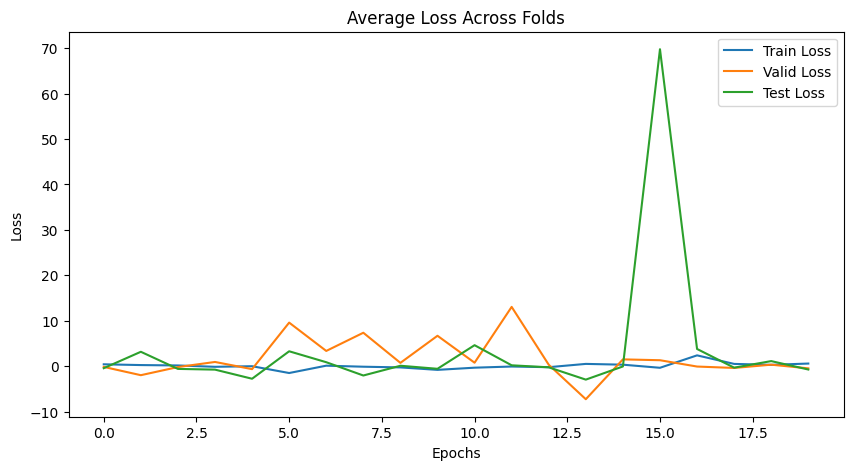

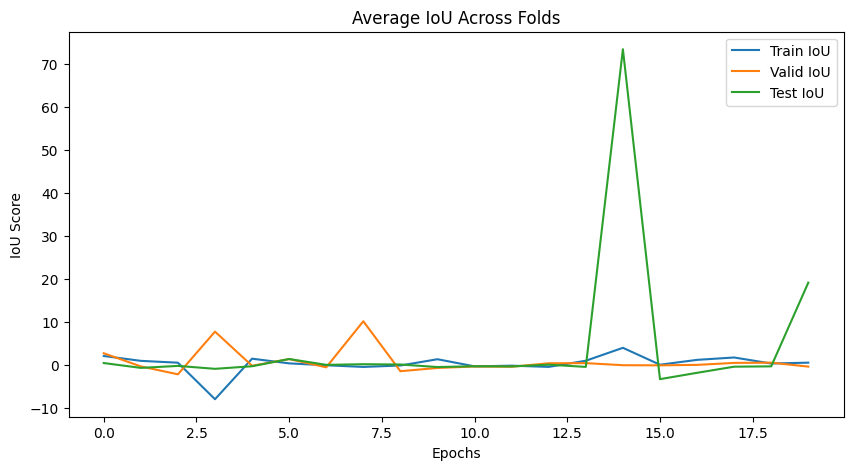

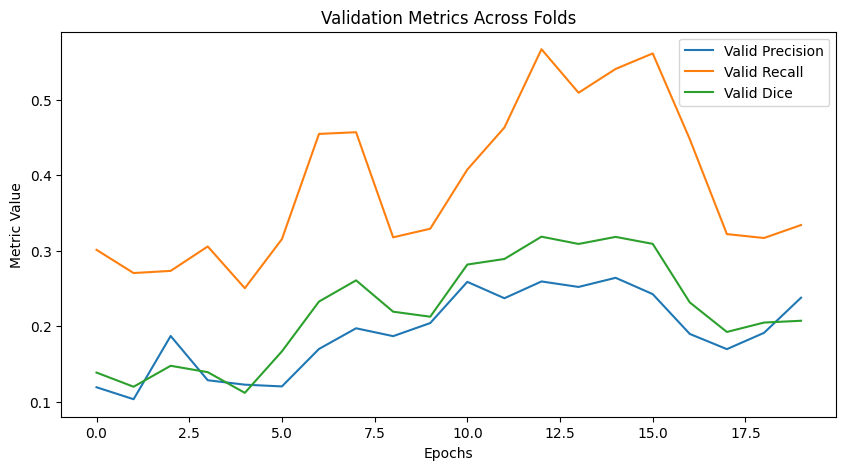

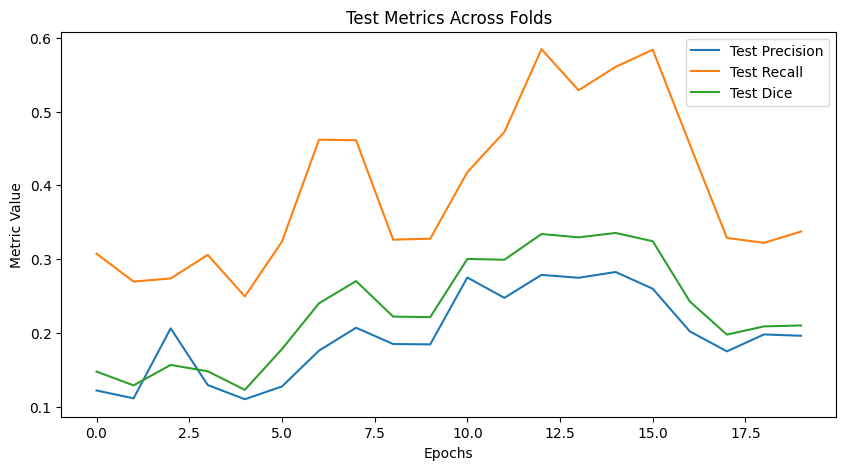

Metrics have been saved to 'Dataset1_model_HRNet.csv'


/tmp/ipykernel_130578/1280507250.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_fpath)
/tmp/ipykernel_130578/2646527758.py:355: Use

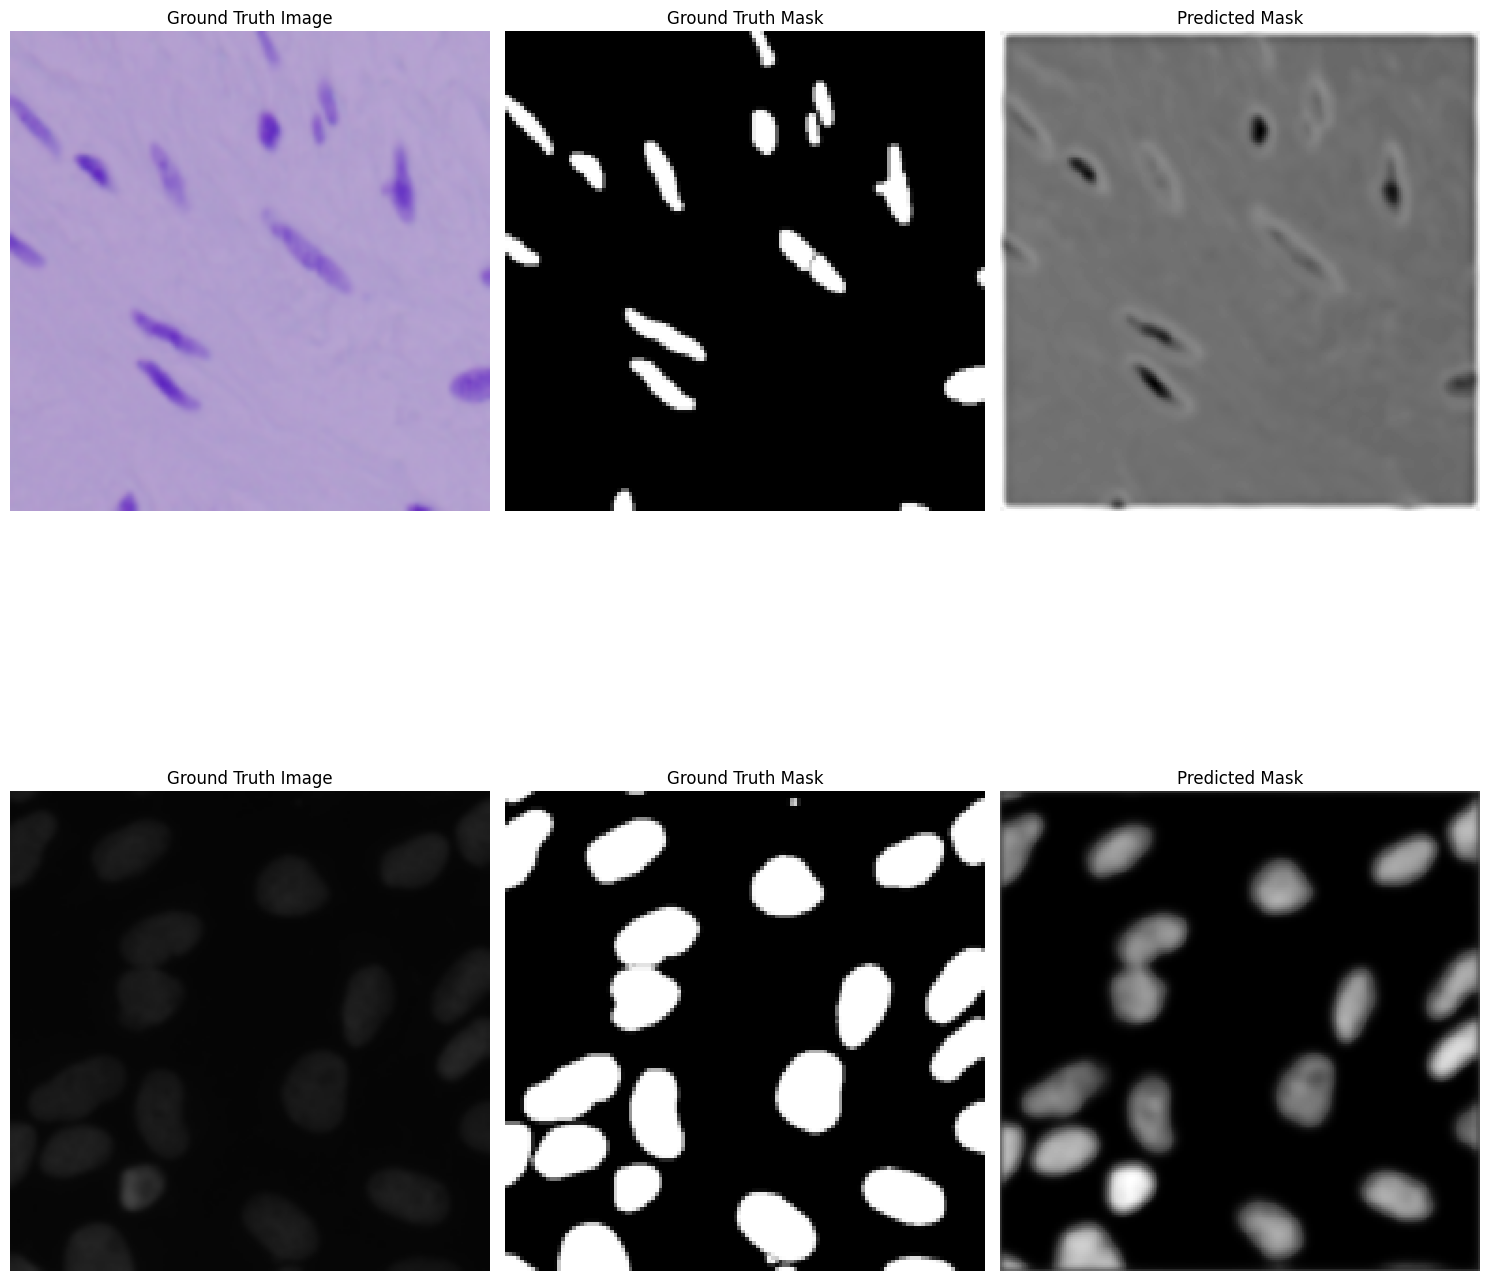

In [3]:
# Set up necessary directories and loss function
if not os.path.exists("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/HRNet"):
    os.makedirs("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/HRNet")

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        
        return out

class HRNet(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(HRNet, self).__init__()
        self.stage1 = self._make_layer(BasicBlock, in_channels, 64, 4)
        
        self.stage2_branch1 = self._make_layer(BasicBlock, 64, 32, 4)
        self.stage2_branch2 = self._make_layer(BasicBlock, 64, 32, 4, stride=2)
        
        self.stage3_branch1 = self._make_layer(BasicBlock, 32, 32, 4)
        self.stage3_branch2 = self._make_layer(BasicBlock, 32, 32, 4)
        self.stage3_branch3 = self._make_layer(BasicBlock, 32, 32, 4, stride=2)
        
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)
    
    def _make_layer(self, block, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.stage1(x)
        x1 = self.stage2_branch1(x)
        x2 = self.stage2_branch2(x)
        
        x1 = self.stage3_branch1(x1)
        x2 = self.stage3_branch2(x2)
        x3 = self.stage3_branch3(x2)
        
        out = self.final_conv(x1)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)
        
        return out
    
# Initialize model and optimizer for each fold
model = HRNet(1,3)  # Assuming UNet is defined earlier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Parameters and Data
num_epochs = 20
k_folds = 7
checkpoint_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/HRNet/chkpoint_'
best_model_path = '/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/HRNet/bestmodel.pt'

# Initialize metrics
accuracy_metric = IoU()  # Assuming IoU is a metric you defined earlier
criterion = DiceLoss()  # Assuming DiceLoss is defined earlier
valid_loss_min = np.inf

# Store results
total_train_loss, total_train_score  = [], []
total_valid_loss, total_valid_score  = [], []
total_test_loss, total_test_score  = [], []

total_train_precision, total_valid_precision, total_test_precision = [], [], []
total_train_recall, total_valid_recall, total_test_recall = [], [], []
total_train_dice, total_valid_dice, total_test_dice = [], [], []

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 7-fold Cross Validation Loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"\n####### Fold {fold+1}/{k_folds} #######")

    # Create data subsets for current fold
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=16, shuffle=False)

    # Track losses and scores for each fold
    fold_train_loss, fold_train_score = [], []
    fold_valid_loss, fold_valid_score = [], []
    fold_test_loss, fold_test_score = [], []
    
    fold_train_precision, fold_valid_precision, fold_test_precision = [], [], []
    fold_train_recall, fold_valid_recall, fold_test_recall = [], [], []
    fold_train_dice, fold_valid_dice, fold_test_dice = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_score = [], []

        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for x_train, y_train in pbar:
            x_train = torch.autograd.Variable(x_train)
            y_train = torch.autograd.Variable(y_train)
            optimizer.zero_grad()
            output = model(x_train)

            # Compute Loss and Score
            loss = criterion(output, y_train)
            score = accuracy_metric(output, y_train)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_score.append(score.item())
            pbar.set_description(f"Epoch {epoch+1} - Loss: {loss.item():.4f}, IoU: {score:.4f}")

        fold_train_loss.append(np.mean(train_loss))
        fold_train_score.append(np.mean(train_score))

        # Validation Loop
        model.eval()
        valid_loss, valid_score= [], []

        valid_precision = []
        valid_recall = []
        valid_dice = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = torch.autograd.Variable(x_val)
                y_val = torch.autograd.Variable(y_val)
                output = model(x_val)

                # Compute Loss and Score
                loss = criterion(output, y_val)
                score = accuracy_metric(output, y_val)

                valid_loss.append(loss.item())
                valid_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_val_bin = (y_val > 0.5).float()

                valid_precision.append(precision_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_recall.append(recall_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                valid_dice.append(f1_score(y_val_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_valid_loss.append(np.mean(valid_loss))
        fold_valid_score.append(np.mean(valid_score))
        
        fold_valid_precision.append(np.mean(valid_precision))
        fold_valid_recall.append(np.mean(valid_recall))
        fold_valid_dice.append(np.mean(valid_dice))

        # Test Loop
        test_loss = []
        test_score = []
        
        test_precision = []
        test_recall = []
        test_dice = []

        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test = torch.autograd.Variable(x_test)
                y_test = torch.autograd.Variable(y_test)
                output = model(x_test)

                # Compute Loss and Score
                loss = criterion(output, y_test)
                score = accuracy_metric(output, y_test)

                test_loss.append(loss.item())
                test_score.append(score.item())

                # Convert output and ground truth to binary for precision, recall, and dice
                output_bin = (output > 0.5).float()
                y_test_bin = (y_test > 0.5).float()

                test_precision.append(precision_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_recall.append(recall_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))
                test_dice.append(f1_score(y_test_bin.view(-1).cpu(), output_bin.view(-1).cpu()))

        fold_test_loss.append(np.mean(test_loss))
        fold_test_score.append(np.mean(test_score))

        fold_test_precision.append(np.mean(test_precision))
        fold_test_recall.append(np.mean(test_recall))
        fold_test_dice.append(np.mean(test_dice))

        print(f"Fold {fold+1} - Epoch {epoch+1} - Train Loss: {np.mean(train_loss):.4f}, IoU: {np.mean(train_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Loss: {np.mean(valid_loss):.4f}, IoU: {np.mean(valid_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Loss: {np.mean(test_loss):.4f}, IoU: {np.mean(test_score):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Valid Precision: {np.mean(valid_precision):.4f}, Recall: {np.mean(valid_recall):.4f}, Dice: {np.mean(valid_dice):.4f}")
        print(f"Fold {fold+1} - Epoch {epoch+1} - Test Precision: {np.mean(test_precision):.4f}, Recall: {np.mean(test_recall):.4f}, Dice: {np.mean(test_dice):.4f}")

        # Save checkpoint and best model
        checkpoint = {
            'epoch': epoch+1,
            'valid_loss_min': fold_valid_loss[-1],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        if fold_valid_loss[-1] <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {fold_valid_loss[-1]:.6f}). Saving model...')
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = fold_valid_loss[-1]

    # Append fold results
    total_train_loss.append(fold_train_loss)
    total_train_score.append(fold_train_score)
    total_valid_loss.append(fold_valid_loss)
    total_valid_score.append(fold_valid_score)
    total_test_loss.append(fold_test_loss)
    total_test_score.append(fold_test_score)

    total_train_precision.append(fold_train_precision)
    total_valid_precision.append(fold_valid_precision)
    total_test_precision.append(fold_test_precision)

    total_train_recall.append(fold_train_recall)
    total_valid_recall.append(fold_valid_recall)
    total_test_recall.append(fold_test_recall)

    total_train_dice.append(fold_train_dice)
    total_valid_dice.append(fold_valid_dice)
    total_test_dice.append(fold_test_dice)

# Calculate average results over all folds
avg_train_loss = np.mean(total_train_loss, axis=0)
avg_train_score = np.mean(total_train_score, axis=0)
avg_valid_loss = np.mean(total_valid_loss, axis=0)
avg_valid_score = np.mean(total_valid_score, axis=0)
avg_test_loss = np.mean(total_test_loss, axis=0)
avg_test_score = np.mean(total_test_score, axis=0)

avg_train_precision = np.mean(total_train_precision, axis=0)
avg_valid_precision = np.mean(total_valid_precision, axis=0)
avg_test_precision = np.mean(total_test_precision, axis=0)

avg_train_recall = np.mean(total_train_recall, axis=0)
avg_valid_recall = np.mean(total_valid_recall, axis=0)
avg_test_recall = np.mean(total_test_recall, axis=0)

avg_train_dice = np.mean(total_train_dice, axis=0)
avg_valid_dice = np.mean(total_valid_dice, axis=0)
avg_test_dice = np.mean(total_test_dice, axis=0)

# Plot final averaged results for losses and metrics
plt.figure(figsize=(10,5))
plt.plot(avg_train_loss, label="Train Loss")
plt.plot(avg_valid_loss, label="Valid Loss")
plt.plot(avg_test_loss, label="Test Loss")
plt.legend()
plt.title("Average Loss Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot IoU scores
plt.figure(figsize=(10,5))
plt.plot(avg_train_score, label="Train IoU")
plt.plot(avg_valid_score, label="Valid IoU")
plt.plot(avg_test_score, label="Test IoU")
plt.legend()
plt.title("Average IoU Across Folds")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.show()

# Plot Precision, Recall, and Dice scores for validation and test sets
plt.figure(figsize=(10,5))
plt.plot(avg_valid_precision, label="Valid Precision")
plt.plot(avg_valid_recall, label="Valid Recall")
plt.plot(avg_valid_dice, label="Valid Dice")
plt.legend()
plt.title("Validation Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(avg_test_precision, label="Test Precision")
plt.plot(avg_test_recall, label="Test Recall")
plt.plot(avg_test_dice, label="Test Dice")
plt.legend()
plt.title("Test Metrics Across Folds")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

import pandas as pd

# Create a DataFrame to store results
columns = [
    'Fold', 'Epoch', 'Train_Loss', 'Train_IoU', 'Valid_Loss', 'Valid_IoU', 'Test_Loss', 'Test_IoU',
    'Valid_Precision', 'Valid_Recall', 'Valid_Dice', 'Test_Precision', 'Test_Recall', 'Test_Dice'
]

results = []

# Collect the results after all folds and epochs
for fold in range(k_folds):
    for epoch in range(num_epochs):
        results.append([
            fold + 1, epoch + 1,
            total_train_loss[fold][epoch], total_train_score[fold][epoch],
            total_valid_loss[fold][epoch], total_valid_score[fold][epoch],total_test_loss[fold][epoch], total_test_score[fold][epoch],
            total_valid_precision[fold][epoch], total_valid_recall[fold][epoch], total_valid_dice[fold][epoch],
            total_test_precision[fold][epoch], total_test_recall[fold][epoch], total_test_dice[fold][epoch]
        ])

# Convert results to a pandas DataFrame
df = pd.DataFrame(results, columns=columns)

# Save DataFrame to CSV
df.to_csv("/home/sayantan/VENV1/ShreyaBTP2/btp2/Dataset1/HRNet/Dataset1_model_HRNet.csv", index=False)

print("Metrics have been saved to 'Dataset1_model_HRNet.csv'")

#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

def visualize_predict(model, n_images):
  #model = model.eval()
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in test_loader:
        data = torch.autograd.Variable(data, volatile=True)
        mask = torch.autograd.Variable(mask, volatile=True)
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Ground Truth Image")
    ax[img_no, 1].set_title("Ground Truth Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
  plt.tight_layout()
  plt.show()
  
visualize_predict(model, 2)